In [1]:
from gurobipy import *
from random import uniform
import itertools as it
import time
import cProfile as cP
import collections as coll
import math
import numpy as np
from IPython.display import Image
import networkx as nx
import matplotlib.pyplot as plt
from copy import deepcopy
%matplotlib inline  
plt.rcParams['figure.figsize'] = 12, 5
def contig_name(contig):
    return contig[:contig.rfind('_')]



In [18]:
def read_position(datei, ending = True):
    f = open(datei)
    
    position = {}
    contig_repeat = coll.defaultdict(list)
    
    for line in f:
        if ending:
            contig, pos = line.split()
            repeat = contig + '_' + str(len(contig_repeat[contig]))
            
        else:
            repeat, pos = line.split()
            contig = contig_name(repeat)
        
        position[repeat] = float(pos)
        contig_repeat[contig].append(repeat)

    return position, contig_repeat
 
def sortiere_repeats(position, contig_repeat):
    
    for contig,repeats in contig_repeat.items():
        if len(repeats) == 1:
            continue
        
        for rep, pos in zip(repeats, sorted([position[rep] for rep in repeats])):
            position[rep] = pos
            
def get_intName(position):

    pos = sorted([(value, key) for key, value in position.items()])
    
    intName = {k: i for i, (v, k) in enumerate(pos)}
    intName.update({i: k for i, (v, k) in enumerate(pos)})
    
    return intName
def get_contigs(data):
    contigs = set()
    for a, b, _ in data:
        contigs.add(a)
        contigs.add(b)
    return contigs

def solve_LP_standard(positionen, data):
    model = Model()
    #model.setParam(GRB.Param.LogToConsole, 0)
    
    # Variablen
    contig = model.addVars(positionen)
    
    model.update()
    
    sorted_pos = sorted(positionen , key = lambda x: positionen[x])
    data = data + [
        (a, b, positionen[b] - positionen[a]) 
        for a, b in zip(sorted_pos[:-1],sorted_pos[1:])
    ]
        
    # Bedingungen
    fehler = []
    for a, b, dist in data:
        eps = model.addVar()
        model.addConstr( contig[b] - contig[a] - int(dist) <= eps) # |(b - a) - dist| = fehler
        model.addConstr(-contig[b] + contig[a] + int(dist) <= eps) #
        fehler.append(eps)
        
    # Lösen
    model.setObjective(sum(fehler), GRB.MINIMIZE)
    model.update()
    model.optimize()
    return {cont: contig[cont].X for cont in contig}

def solve_LP(contigs, constraints, bekannte_positionen = {}):
    model = Model()
    model.setParam(GRB.Param.LogToConsole, 0)
    
    # Variablen
    contig = model.addVars(contigs)
    
    contig.update(bekannte_positionen)
  #  model.update()
        
    # Bedingungen
    fehler = []
    for a, b, dist in constraints:
        if a in bekannte_positionen and b in bekannte_positionen:
            continue
        eps = model.addVar()
       # faktor = (1000 + dist)/33942.74
        model.addConstr( contig[b] - contig[a] - dist <= eps ) # |(b - a) - dist| = fehler
        model.addConstr(-contig[b] + contig[a] + dist <= eps ) #
        fehler.append(eps)
        
    # Lösen
    model.setObjective(sum(fehler)/len(fehler), GRB.MINIMIZE)
    #model.update()
    model.optimize()
    return {cont: contig[cont].X for cont in contigs if cont not in bekannte_positionen}

def solve_LP(contigs, constraints, bekannte_positionen = {}):
    model = Model()
    #model.setParam(GRB.Param.LogToConsole, 0)
        
    # Variablen
    contig = model.addVars(contigs)
    
    
    sorted_pos = sorted(bekannte_positionen , key = lambda x: bekannte_positionen[x])
    for a, b in zip(sorted_pos[:-1],sorted_pos[1:]):
        model.addConstr( 
            bekannte_positionen[b] - bekannte_positionen[a] <= contig[b] - contig[a]
        )
        
  #  model.update()
        
    # Bedingungen
    fehler = []
    for a, b, dist in constraints:
        if a in bekannte_positionen and b in bekannte_positionen:
            continue
        eps = model.addVar()
       # faktor = (1000 + dist)/33942.74
        model.addConstr( contig[b] - contig[a] - dist <= eps ) # |(b - a) - dist| = fehler
        model.addConstr(-contig[b] + contig[a] + dist <= eps ) #
        fehler.append(eps)
        
    # Lösen
    model.setObjective(sum(fehler)/len(fehler), GRB.MINIMIZE)
    #model.update()
    model.optimize()
    return {cont: contig[cont].X for cont in contigs}

def read_file(file_name):
    data = []
    with open(file_name) as file:
        for line in file:
            a, b, dist = line.split()
            data.append([a, b, float(dist)])
    return data

def find(x, i):
    
    l = [i]
    while i in x and i != x[i]:
        i = x[i]
        l += [i]
    
    for j in l:
        x[j] = i
        
    return i

def union(x,i,j):
    i = find(x,i)
    j = find(x,j)
    x[i] = j
        
def to_sets(struct):
    sets = coll.defaultdict(set)
    for element in struct:
        root = find(struct, element)
        sets[root].add(element)
    return sorted(sets.values(), key = lambda x: len(x), reverse = True)

def connected(data):
    struct = {}
    for a, b, _ in data:
        union(struct, a, b)
    sets = to_sets(struct)
    
    if len(sets) == 1:
        print('Die Daten sind zusammenhängend')
    else:
        print('Es gibt unzusammenhängende Regionen in den Daten')
        value = round(100 * len(sets[0]) / sum(len(x) for x in sets), 2)
        print(str(value) + '% der Contigs sind in der größten Komponente.')
       # print(sum(len(x) for x in sets[1:]))
       #print(sum(len(x) for x in sets[:]))
        
    return [constraint for constraint in data if constraint[0] in sets[0]]
def umsortieren(data, repeats, position):
    counter = 0
    for i, bedingung in enumerate(data):
        a, b, dist = bedingung
        
        contig_a = contig_name(a)
        contig_b = contig_name(b)
        
        # a und b werden zu den Repeat-Versionen umgeändert, die am besten
        # zu den Daten passen. Also zu denen Versionen a_i und b_j gemacht, 
        # für die b_j - a_i am nähsten an der vorgegebenen Distanz ist.
        if contig_a not in repeats or contig_b not in repeats:
          #  print('not',a, b, dist)
            continue
        new_a, new_b = min( 
            it.product(repeats[contig_a], repeats[contig_b]), 
            key = lambda contig: abs(position[contig[1]] - position[contig[0]] - dist)
        )
            
        bedingung[0] = new_a
        bedingung[1] = new_b
        if new_a != a or new_b != b:
            counter += 1
         #   print('\t'.join([a,b,str(dist),str(position[b] - position[a])]))
          #  print('\t'.join([new_a, new_b,str(dist), str(position[new_b] - position[new_a])]))
          #  print()
    print('Anzahl der Änderungen:',counter)
    print()

def get_constr_pos(data, position):
    constr_pos = coll.defaultdict(list)
    for a, b, dist in data:
        contig_a = contig_name(a)
        contig_b = contig_name(b)
        
        constr_pos[contig_b].append((position[a] + dist, a, 1))
        constr_pos[contig_a].append((position[b] - dist, b, 0))
    return dict(constr_pos)

def extrahiere_daten(gruppe):
    gruppe, counter, dist  = gruppe
    
    Repeat = coll.namedtuple('Repeat', ['pos', 'güte'])

    anzahl = len(gruppe)
    güte = (anzahl-1)**2 * (max(counter.values()) - 1) * (len(dist) - 1) / (200+np.std(gruppe))
    return Repeat(
        pos = gruppe[anzahl//2], 
        güte = güte
    )
   
    
def gruppierung(positionen, anzahl, min_abstand):
    
    sorted_pos = sorted(positionen) 
    # gruppiere sich stützende Daten
    previous = sorted_pos[0][0]
    current_group = [[],coll.Counter(),set()]
    groups = []
    gruppen_abstand = []
    for current, contig, direction in sorted_pos:
        if current - previous > min_abstand:
            groups.append(current_group)
            current_group = [[],coll.Counter(),set()]
            gruppen_abstand.append([current - previous, groups[-1], current_group])
        current_group[0].append(current)
        current_group[1][contig] += 1
        current_group[2].add(direction)
        previous = current
    groups.append(current_group)
    
    if len(groups) <= anzahl:
        return
    
    
    gruppen_abstand.sort()
    
    repeat_daten = [extrahiere_daten(g) for g in groups]
    repeat_daten.sort(key = lambda x: x.güte, reverse=True)
    # print('daten')
    #for x in repeat_daten:
    #    print(x)
    max_güte = repeat_daten[anzahl].güte
    ret = deepcopy([max_güte, repeat_daten[:anzahl+1], groups])
    
   # print(repeat_daten)
    return ret


def get_repeat(constr_pos, contig_repeats, min_repeat_abstand = 500, min_güte = 0):
    max_güte = min_güte
    for contig in constr_pos:
        groups = gruppierung(constr_pos[contig], len(contig_repeats[contig]), min_repeat_abstand)
        if not groups:
            continue
            
        güte, repeats, groups = groups
        
        if güte > max_güte:
            max_güte = güte
            ret = contig, repeats, güte, groups
    if max_güte == min_güte:
        return None, None, 0,[]
    print('güte', max_güte)
    #for r in ret[1]:
    #    print(r)
    for g in ret[3]:
        data = g[0]
        anzd = len(data)
        anzC = len(g[1])
        np.mean(g[0])
        print(int(data[anzd//2]),anzd,anzC,np.std(data))
    print()
    return ret

pos, rep = read_position('apdsolution_coords.lst')
sortiere_repeats(pos, rep)
intNameX = get_intName(pos)
reps = {r for r in rep if len(rep[r])>1}

In [19]:

def get_constr_pos(data, position):
    constr_pos = coll.defaultdict(list)
    for a, b, dist in data:
        contig_a = contig_name(a)
        contig_b = contig_name(b)
        
        constr_pos[contig_b].append((position[a] + dist, a, 1))
        constr_pos[contig_a].append((position[b] - dist, b, 0))
    return dict(constr_pos)

def extrahiere_daten(gruppe):
    gruppe, counter, dist  = gruppe
    
    Repeat = coll.namedtuple('Repeat', ['pos', 'güte', 'güte_0'])

    anzahl = len(gruppe)
    güte = (anzahl-1)**2 * (max(counter.values()) - 1) * (len(dist) - 1) / (200+np.std(gruppe))
    return Repeat(
        pos = gruppe[anzahl//2], 
        güte = güte,
        güte_0 = anzahl**2 * (max(counter.values())-0.8) * (len(dist)-0.8) / (200+np.std(gruppe))
    )
   
    
def gruppierung(positionen, min_abstand, min_güte_0 = 0.0, min_güte = 100):
    
    sorted_pos = sorted(positionen) 
    # gruppiere sich stützende Daten
    previous = sorted_pos[0][0]
    current_group = [[],coll.Counter(),set()]
    groups = []
    gruppen_abstand = []
    for current, contig, direction in sorted_pos:
        if current - previous > min_abstand:
            groups.append(current_group)
            current_group = [[],coll.Counter(),set()]
        current_group[0].append(current)
        current_group[1][contig] += 1
        current_group[2].add(direction)
        previous = current
    groups.append(current_group)
    
    
    repeat_daten = [extrahiere_daten(g) for g in groups]
    repeat_daten.sort(key = lambda x: x.güte, reverse = True)
    
    if repeat_daten[0].güte < min_güte:
        gruppe = max(repeat_daten, key = lambda x: x.güte_0)
        if gruppe.güte_0 < min_güte_0:
            return []
        return [gruppe]
    return [gruppe for gruppe in repeat_daten if gruppe.güte >= min_güte]
    

def ordne_repeats_zu(contig, position, contig_repeats, gruppen):
    repeats = []
    for i, gruppe in enumerate(sorted(gruppen, key = lambda gruppe: gruppe.pos)):
        contig_version = contig + '_' + str(i)
        repeats += [contig_version]
        position[contig_version] = gruppe.pos
    contig_repeats[contig] = repeats

def get_repeat(constr_pos, min_repeat_abstand = 500, min_güte = 100):
    position = {}
    contig_repeats = {}
    for contig in constr_pos:
        gruppen = gruppierung(constr_pos[contig], min_repeat_abstand, min_güte = min_güte)
        ordne_repeats_zu(contig, position, contig_repeats, gruppen)
    return position, contig_repeats


def umsortieren(data, repeats, position):
    counter = 0
    bad_counter = 0
    for i, bedingung in enumerate(data):
        a, b, dist = bedingung
        
        contig_a = contig_name(a)
        contig_b = contig_name(b)
        
        # a und b werden zu den Repeat-Versionen umgeändert, die am besten
        # zu den Daten passen. Also zu denen Versionen a_i und b_j gemacht, 
        # für die b_j - a_i am nähsten an der vorgegebenen Distanz ist.
        if contig_a not in repeats or contig_b not in repeats:
            bad_counter += 1
            continue
        new_a, new_b = min( 
            it.product(repeats[contig_a], repeats[contig_b]), 
            key = lambda contig: abs(position[contig[1]] - position[contig[0]] - dist)
        )
            
        bedingung[0] = new_a
        bedingung[1] = new_b
        if new_a != a or new_b != b:
            counter += 1
         #   print('\t'.join([a,b,str(dist),str(position[b] - position[a])]))
          #  print('\t'.join([new_a, new_b,str(dist), str(position[new_b] - position[new_a])]))
          #  print()
    print('Anzahl der Änderungen:',counter)
    print('Anzahl der fehlenden:',bad_counter)
    print()
    
def plot_graph(position, data, X = set(), repeat = '', von = 0, bis = 400, kantenanzahl = 2, fehler = 1000):
    
    intName = get_intName(position)
    
    s = coll.defaultdict(set)
    p = coll.defaultdict(set)

    graph = nx.DiGraph() 
    for c in X:
        if intName[c] < von or intName[c] > bis:
            continue
        c_name = intName[c]
        if c in intNameX:
            c_name = (c_name, intNameX[c])
        if contig_name(c) == repeat:
            graph.add_node(c_name, color = 'green')
        else:
            graph.add_node(c_name, color = 'red')
    for a, b, dist in data:
        if intName[a] < von or intName[b] < von or intName[a] > bis or intName[b] > bis:
            continue
        real_dist = position[b] - position[a]
        if abs(real_dist - dist) < fehler and a != b:
            if position[a] > position[b]:
                a, b, real_dist = b, a, -real_dist
            s[a].add(b)
            p[b].add(a)
    
    ss = {a: sorted(s[a], key = lambda x: intName[x])[:kantenanzahl] for a in s}
    pp = {a: sorted(p[a], key = lambda x: intName[x])[-kantenanzahl:] for a in p}
    
    ss2 = {a: sorted(s[a], key = lambda x: intName[x])[-1] for a in s}
    pp2 = {a: sorted(p[a], key = lambda x: intName[x])[0] for a in p}
    
    
    for a, b in ss2.items():
        if pp2[b] == a:
            b_name = intName[b]
            if b in intNameX:
                b_name = (b_name, intNameX[b])
            a_name = intName[a]
            if a in intNameX:
                a_name = (a_name, intNameX[a])
            graph.add_edge(a_name,b_name,color = 'red')
            
    for b in pp:
        for a in pp[b]:
            b_name = intName[b]
            if b in intNameX:
                b_name = (b_name, intNameX[b])
            a_name = intName[a]
            if a in intNameX:
                a_name = (a_name, intNameX[a])
            graph.add_edge(a_name,b_name)
    for a in ss:
        for b in ss[a]:
            b_name = intName[b]
            if b in intNameX:
                b_name = (b_name, intNameX[b])
            a_name = intName[a]
            if a in intNameX:
                a_name = (a_name, intNameX[a])
            graph.add_edge(a_name,b_name)

    pydot = nx.nx_pydot.to_pydot(graph)
    pydot.set_rankdir('LR')
    
    pydot.write_png('t.png')
    #display(Image(filename='t.png'))

In [44]:

def gruppiert(werte, min_abstand):
    sorted_werte = sorted(werte) 
    # gruppiere sich stützende Daten
    previous = sorted_werte[0]
    current_group = []
    groups = []
    for current in sorted_werte:
        if current - previous > min_abstand:
            groups.append([current_group[len(current_group)//2], len(current_group)])
            current_group = []
        current_group.append(current)
        previous = current
    groups.append([current_group[len(current_group)//2], len(current_group)])
    return groups

data2 = data #read_file('my_apd199.lst')#data5
z = coll.defaultdict(list)
for a,b,d in data2:
    if a>b:
        z[(b,a)].append(-d)
    elif a<b:
        z[(a,b)].append(d)
        
Z = {x: gruppiert(z[x], 500) for x in z}
#sorted([dist,a,b] for (a,b),(dist,gewicht) in Z.items())
print('len z[x] %6d'%sum(len(z[x]) for x in z))
print('len Z[x] %6d'%sum(len(Z[x]) for x in Z))
print('len C    %6d'%len(Z))
print('len Z-C  %6d'%(sum(len(Z[x]) for x in Z) - len(Z)))
print('len z-Z  %6d'%(sum(len(z[x]) for x in z) - sum(len(Z[x]) for x in Z)))


data3 = [[dist,a,b,gewicht] for (a,b),liste in Z.items() for dist,gewicht in liste]
for da in data3:
    d,a,b,g = da
    if d < 0:
        da[0] = -d
        da[1] = b
        da[2] = a 
        da[3] = g
    if a == '501APD_0' and b == '440APD_0':
        print(a,b,d,g)
for da in data3:
    d,a,b,g = da
    if d < 0:
        da[0] = -d
        da[1] = b
        da[2] = a 
        da[3] = g
    if a == '501APD_0' and b == '440APD_0':
        print(a,b,d,g)
len(data3)

len z[x] 122015
len Z[x]  55522
len C     50901
len Z-C    4621
len z-Z   66493
501APD_0 440APD_0 21606.0 4


55522

In [59]:
intName = get_intName(position)


In [88]:
print({intNameX[i] for i in range(1609,1620)})

{'2457APD_1', '1398APD_0', '393APD_0', '537APD_0', '1859APD_0', '214APD_1', '2457APD_0', '401APD_1', '457APD_0', '574APD_0', '473APD_0'}


In [86]:
intNameX[1609]

'473APD_0'

In [85]:
intName['302APD_0']
for i in range(1750,1790):
    c = intName[i]
    
    if c in intNameX:
        c = intNameX[c]
    print(c)

1598
1599
1600
1601
1602
1603
259APD_0
1604
1605
1606
1607
1608
1609
1610
1611
1612
1613
1619
1614
137APD_0
1616
1617
1618
214APD_2
236APD_0
1620
1621
1622
2090APD_0
1623
1624
1625
1626
1627
1628
2352APD_0
1629
1630
1656APD_0
1631


In [54]:
pos['457APD_0']-pos['302APD_0']

56849.0

In [56]:
position['457APD_0']-pos['302APD_0']

52429.11103893118

In [77]:
data4 = [(a,b,d,g) for d,a,b,g in data3 if g > 0 and not -2000 <= position[b] - position[a] - d <= 2000 and {'457APD_0','302APD_0'}&{a,b}]
x = coll.Counter()
for a,b,d,g in data4:
  #  if {a,b} & {'501APD_0'}:
   #     continue
    x[a] += 1
    x[b] += 1
    print(a,b,int(position[b] - position[a] - d),g)
print(x)

137APD_0 302APD_0 -63502 2
302APD_0 259APD_0 -19284 1
302APD_0 305APD_0 -5117 1
302APD_0 305APD_0 -14016 1
457APD_0 2457APD_0 -25914 1
457APD_0 302APD_0 -63492 5
457APD_0 305APD_0 -63504 1
Counter({'302APD_0': 5, '305APD_0': 3, '457APD_0': 3, '137APD_0': 1, '259APD_0': 1, '2457APD_0': 1})


In [ ]:
graph3[]

In [30]:
data4 = [(a,b,d,g) for d,a,b,g in data3 if g > 2 and not -2000 <= pos[b] - pos[a] - d <= 2000]
for a,b,d,g in data4:
    print(a,b,d,g)
    

KeyError: '1656APD_0'

In [26]:
def extrahiere_daten_0(gruppe):
    gruppe, counter, dist  = gruppe
    
    Repeat = coll.namedtuple('Repeat', ['pos', 'güte', 'güte_0'])

    anzahl = len(gruppe)
    güte = (anzahl-1)**2 * (max(counter.values())-1) * (len(dist) - 1) / (200+np.std(gruppe))
    return Repeat(
        pos = gruppe[anzahl//2], 
        güte = güte,
        güte_0 = anzahl**2 * (max(counter.values())-0.8) * (len(dist)-0.8) / (200+np.std(gruppe))
    )
def gruppierung_0(positionen, min_abstand, min_güte_0 = 0.0, min_güte = 100):
    
    sorted_pos = sorted(positionen) 
    # gruppiere sich stützende Daten
    previous = sorted_pos[0][0]
    current_group = [[],coll.Counter(),set()]
    groups = []
    gruppen_abstand = []
    for current, contig, direction in sorted_pos:
        if current - previous > min_abstand:
            groups.append(current_group)
            current_group = [[],coll.Counter(),set()]
        current_group[0].append(current)
        current_group[1][contig] += 1
        current_group[2].add(direction)
        previous = current
    groups.append(current_group)
    
    
    repeat_daten = [extrahiere_daten_0(g) for g in groups]
    repeat_daten.sort(key = lambda x: x.pos)
    
    return [gruppe for gruppe in repeat_daten if gruppe.güte_0 > 0.1]

In [27]:
intNameX['233APD_0'],intNameX['175APD_0'],intNameX['175APD_1'],intName['233APD_0'],intName['175APD_0']

NameError: name 'intName' is not defined

In [28]:
const_p = get_constr_pos(data5, pos)
for c in const_p:
    for g in gruppierung_0(constr_pos[c], 500):
        print(c, int(g.pos), round(g.güte_0,3), round(g.güte,3))

NameError: name 'data5' is not defined

In [71]:
for c in constr_pos:
    k = gruppierung_0(constr_pos[c], 500)
    if len(k) > len(contig_repeat[c]):
        for g in k:
            print(c, int(g.pos), round(g.güte_0,3), round(g.güte,3))
            
106APD 434916 0.149 0.0
501APD 1300363 4.987 0.0
501APD 1301551 0.873 0.0
25APD 4391470 0.333 0.0
236APD 4017417 0.107 0.0
302APD 4003964 0.2 0.0
457APD 3933771 0.146 0.0


106APD 434916 0.149 0.0
106APD 444593 2065.865 1675.46
501APD 1300363 4.987 0.0
501APD 1301551 0.873 0.0
501APD 1354187 2.309 1.549
501APD 1355114 2.563 1.76
501APD 1406789 0.244 0.13
25APD 4307613 1171.239 950.39
25APD 4391470 0.333 0.0
236APD 4016162 354.18 282.965
236APD 4017417 0.107 0.0
302APD 3940471 35.516 27.151
302APD 4003964 0.2 0.0
457APD 3933771 0.146 0.0
457APD 3997263 161.162 126.969


In [134]:
plot_graph(position, data, {c for r in repeats for c in contig_repeat[r]}, von = 1936, bis = 1949,kantenanzahl=4)

In [147]:
pos['175APD_1']-pos['175APD_0'] , 4510620-position['175APD_0']

(36315.0, 36082.430390282534)

In [146]:
intNameX[1770],intNameX[1773]

('233APD_0', '146APD_0')

In [149]:
for a,b,d in data:
    if a == '233APD_0' and b == '146APD_0':
        print(d)

3383.0


In [ ]:
dataX = [[a,b,d] for a,b,d in data if a != '175APD_0' and b != '175APD_0']

In [60]:
for i in range(430,440):
    print(intNameX[i])
print()
for i in range(488,500):
    print(intName[i])
for i in range(488,500):
    print(intName[i])

198APD_0
348APD_0
829APD_0
1525APD_0
1295APD_0
371APD_1
1016APD_0
1074APD_0
501APD_0
145APD_0

1874APD_0
1015APD_0
1813APD_0
2034APD_0
182APD_0
342APD_0
342APD_1
501APD_0
501APD_1
1742APD_0
316APD_0
131APD_0


In [48]:
pos['501APD_0'],pos['501APD_1'],position['501APD_0'],position['501APD_1'],position['501APD_2']

(1298463.0, 1353233.0, 1353971.0, 1354895.0, 1406580.0)

In [6]:
len(get_contigs(data))

2124

In [24]:
II = coll.defaultdict(list)
for line in open('apd5.lst'):
    a,b,d = line.split()
    d = float(d)
    if d > 50000:
        II[(a,b)].append(d)
        
for k,l in II.items():
    if len(l)>2:
        print(k,sorted(l))

('51APD', '1747APD') [54251.0, 54345.0, 55616.0]
('51APD', '1416APD') [55031.0, 55093.0, 56410.0]
('51APD', '1191APD') [56236.0, 56284.0, 57657.0]
('51APD', '1706APD') [57700.0, 57715.0, 59153.0]
('51APD', '1941APD') [58864.0, 58871.0, 60348.0]
('253APD', '1747APD') [53576.0, 53652.0, 54926.0]
('253APD', '1416APD') [54356.0, 54400.0, 55720.0]
('253APD', '1191APD') [55561.0, 55591.0, 56967.0]
('253APD', '1706APD') [57022.0, 57025.0, 58463.0]
('253APD', '1941APD') [58178.0, 58189.0, 59658.0]
('454APD', '1191APD') [51155.0, 51161.0, 52427.0]
('454APD', '1706APD') [52592.0, 52619.0, 53923.0]
('454APD', '1941APD') [53748.0, 53783.0, 55118.0]
('2338APD', '74APD') [60195.0, 61093.0, 73242.0]
('4APD', '74APD') [57948.0, 58794.0, 70943.0]


In [ ]:
('558APD', '419APD') [-65.0, -58.0, -65.0, -60.0, -65.0, -64.0, -64.0, -64.0, -64.0, -62.0, -64.0, -64.0, -64.0, -58.0, -63.0, -64.0, -64.0, -64.0, -64.0, -65.0, -64.0, -64.0, -62.6221323350818]
('1557APD', '1267APD') [-26.0, -26.0, -32.0, -26.0, -26.0, -29.0, -37.0, -29.0, -27.0, -25.0, -20.0, -25.0, -29.0, -29.0, -25.0, -26.0, -25.0, -25.0, -34.0, -26.0, -19.0, -28.0, -18.2009812986361]


In [21]:
II = coll.defaultdict(list)
for line in open('toContigs.bam.sorted.pairDistances.summary'):
    if (2283, 1849) == tuple(int(x[1:-3]) for x in line.split()[0].split('_')):
        print(line)
    if line.split()[1] != 'NA':
        II[tuple(int(x[1:-3]) for x in line.split()[0].split('_'))].append(tuple(x[0] for x in line.split()[0].split('_')))

-2283APD_+1849APD	NA	1	-210	615.384615384615

+2283APD_-1849APD	NA	1	-1422.30769230769	615.384615384615

+2283APD_+1849APD	-4244.85846854958	1433	-4252.51847204796	1.11529346159208

-2283APD_-1849APD	0.858468549580934	1433	13.2517774989544	1.11529346159208



In [14]:
max(pos.values())

4899601.0

In [77]:
feste_position = {'2345APD_0': 0, '1395APD_0': 6982.0, '1596APD_0': 9952.0, '2235APD_0': 14269.0, '1534APD_0': 14941.0, '546APD_0': 16511.0, '577APD_0': 19014.0, '998APD_0': 32313.0, '209APD_0': 34132.0, '1635APD_0': 43535.0, '2109APD_0': 45637.0, '996APD_0': 47657.0, '1481APD_0': 49144.0, '2113APD_0': 55767.0, '1332APD_0': 64494.0, '225APD_0': 68363.0, '1894APD_0': 77439.0, '521APD_0': 80995.0, '1076APD_0': 83301.0, '301APD_0': 86477.0, '50APD_0': 88528.0, '2396APD_0': 90554.9323053167, '1980APD_0': 92187.9323053167, '958APD_0': 93267.9323053167, '2050APD_0': 95081.9323053167, '1113APD_0': 99611.16150611905, '960APD_0': 101534.16150611905, '831APD_0': 103166.0, '1877APD_0': 106398.0, '1337APD_0': 107251.0, '59APD_0': 114474.9323053167, '542APD_0': 120932.9323053167, '1631APD_0': 124902.9323053167, '176APD_0': 126130.0, '567APD_0': 128337.9323053167, '776APD_0': 130202.9323053167, '86APD_0': 131491.16150611907, '1529APD_0': 138169.0, '1057APD_0': 138854.0, '1472APD_0': 141026.0, '1714APD_0': 142777.9323053167, '1400APD_0': 145988.0, '2058APD_0': 149580.16150611907, '943APD_0': 151240.0, '511APD_0': 151970.9323053167, '1698APD_0': 157366.0, '1903APD_0': 158556.9323053167, '2387APD_0': 164056.9323053167, '1317APD_0': 165654.9323053167, '1857APD_0': 183019.0, '931APD_0': 185975.0, '1375APD_0': 186830.0, '156APD_0': 187849.0, '19APD_0': 190568.9323053167, '1252APD_0': 193655.9323053167, '772APD_0': 194388.0, '896APD_0': 195101.9323053167, '2013APD_0': 196813.0, '2322APD_0': 199619.0, '439APD_0': 202543.9323053167, '948APD_0': 203489.0, '1151APD_0': 205933.9323053167, '1904APD_0': 212325.16150611907, '945APD_0': 214369.9323053167, '2085APD_0': 215023.9323053167, '1779APD_0': 218431.0167818591, '1363APD_0': 219604.0, '1380APD_0': 220389.0, '1921APD_0': 222788.16150611907, '1465APD_0': 224878.0, '876APD_0': 226088.0, '793APD_0': 227266.0, '1991APD_0': 229453.9323053167, '2003APD_0': 232875.9323053167, '1397APD_0': 233538.0, '885APD_0': 235105.0, '205APD_0': 235920.0, '1017APD_0': 239570.0, '277APD_0': 241603.0167818591, '444APD_0': 243329.0, '374APD_0': 244151.0167818591, '1866APD_0': 246176.0, '1514APD_0': 246999.0167818591, '2197APD_0': 251052.0, '2088APD_0': 252362.16150611907, '580APD_0': 254846.0, '506APD_0': 264011.0, '2458APD_0': 267844.0, '480APD_0': 268721.0, '1246APD_0': 271731.0, '1334APD_0': 272710.0, '466APD_0': 274608.0, '855APD_0': 278930.9323053167, '547APD_0': 279883.0, '318APD_0': 280245.0, '682APD_0': 282088.2346662088, '601APD_0': 282728.0, '1939APD_0': 286081.0, '789APD_0': 287110.0, '1930APD_0': 288485.02958898427, '1543APD_0': 289322.16150611907, '88APD_0': 291709.0, '1955APD_0': 295408.0, '2380APD_0': 297161.0, '1390APD_0': 298599.0, '638APD_0': 300652.0, '216APD_0': 302252.9323053167, '1701APD_0': 307529.9323053167, '684APD_0': 309029.8899950047, '2125APD_0': 310899.9323053167, '764APD_0': 311342.9323053167, '898APD_0': 312158.0, '1966APD_0': 313387.9323053167, '1621APD_0': 313981.0, '157APD_0': 314613.0, '2122APD_0': 322106.0, '1942APD_0': 324504.16150611907, '1586APD_0': 325187.9323053167, '1494APD_0': 326706.9323053167, '832APD_0': 327686.0, '1590APD_0': 328986.0, '1248APD_0': 330380.0, '1889APD_0': 331059.0, '1622APD_0': 331540.16150611907, '241APD_0': 332401.0, '235APD_0': 340630.0, '184APD_0': 343575.0, '2296APD_0': 344552.0, '593APD_0': 347359.0, '2021APD_0': 347952.0, '986APD_0': 352602.0, '850APD_0': 355611.0, '1986APD_0': 357012.0, '35APD_0': 358780.0, '1672APD_0': 363706.0, '1445APD_0': 365326.0, '1454APD_0': 367103.0, '921APD_0': 367424.0, '2032APD_0': 372182.0, '1981APD_0': 374655.0, '735APD_0': 376433.0, '740APD_0': 379498.0, '1850APD_0': 380887.0, '1967APD_0': 382780.0, '1675APD_0': 384590.473152517, '1169APD_0': 385234.0, '1268APD_0': 385986.0, '208APD_0': 387502.0, '2149APD_0': 389692.0, '276APD_0': 392176.0, '98APD_0': 399605.0, '874APD_0': 400819.0, '1137APD_0': 401970.0, '2071APD_0': 402724.0, '1077APD_0': 403656.0, '80APD_0': 404188.0, '2011APD_0': 404954.0, '379APD_0': 405566.0, '1024APD_0': 406019.0, '588APD_0': 407292.0, '939APD_0': 410839.0, '1433APD_0': 413623.0, '1647APD_0': 414037.0, '1467APD_0': 416897.0, '1192APD_0': 418252.0, '335APD_0': 419175.0, '2256APD_0': 420358.0, '1038APD_0': 421940.23829773226, '429APD_0': 423034.23829773226, '68APD_0': 426336.23829773226, '2390APD_0': 426790.23829773226, '1010APD_0': 429184.0, '680APD_0': 432401.0, '1185APD_0': 436204.0, '1199APD_0': 436836.0, '1574APD_0': 438671.23829773226, '989APD_0': 439790.0, '106APD_0': 443893.0, '2423APD_0': 451664.0, '2434APD_0': 452712.0, '2461APD_0': 454268.0, '1281APD_0': 456958.0, '202APD_0': 461086.0, '90APD_0': 462372.473152517, '2367APD_0': 467252.0, '1661APD_0': 471243.0, '569APD_0': 473697.0, '1309APD_0': 474252.473152517, '1665APD_0': 475212.0, '153APD_0': 477523.23829773226, '1816APD_0': 478302.0, '1330APD_0': 480585.0, '2335APD_0': 482507.0, '1751APD_0': 483573.0, '904APD_0': 487632.0, '548APD_0': 488540.0, '811APD_0': 492088.0, '2415APD_0': 493902.0, '2204APD_0': 494838.0, '196APD_0': 501205.0, '714APD_0': 504981.0, '31APD_0': 506999.0, '656APD_0': 513325.0, '1410APD_0': 522508.0, '1852APD_0': 526822.0, '151APD_0': 528818.0, '861APD_0': 542020.0, '187APD_0': 542707.0, '1162APD_0': 551982.0, '459APD_0': 552763.0, '57APD_0': 556966.0, '900APD_0': 557883.0, '766APD_0': 558723.0, '189APD_0': 559552.2382977323, '1815APD_0': 573220.0, '2205APD_0': 575383.0, '58APD_0': 580807.0, '599APD_0': 588925.0, '345APD_0': 593363.0, '1463APD_0': 604009.2382977323, '865APD_0': 605198.2382977323, '407APD_0': 610069.2382977323, '2394APD_0': 611819.2382977323, '462APD_0': 613570.2382977323, '1500APD_0': 614341.2382977323, '1APD_0': 615116.2382977323, '1245APD_0': 623603.2382977323, '1423APD_0': 624932.2382977323, '2420APD_0': 632416.2382977323, '1439APD_0': 635553.2382977323, '703APD_0': 638143.2382977323, '421APD_0': 658217.2382977323, '37APD_0': 666831.2382977323, '44APD_0': 668089.2382977323, '11APD_0': 674309.2382977323, '1783APD_0': 680909.2382977323, '69APD_0': 686494.2382977323, '1022APD_0': 687364.2382977323, '681APD_0': 692015.2382977323, '2110APD_0': 695000.2382977323, '1773APD_0': 698388.2382977323, '94APD_0': 702701.2382977323, '1721APD_0': 711151.2382977323, '2410APD_0': 715968.2382977323, '89APD_0': 722997.2382977323, '1366APD_0': 726734.2382977323, '1651APD_0': 727275.2382977323, '119APD_0': 733462.2382977323, '572APD_0': 743783.2382977323, '2155APD_0': 753799.2382977323, '708APD_0': 759510.0766310074, '1522APD_0': 761041.0766310074, '134APD_0': 762423.0766310074, '525APD_0': 765329.0766310074, '597APD_0': 768257.0766310074, '75APD_0': 776675.0766310074, '497APD_0': 788319.0766310074, '464APD_0': 789953.0766310074, '1474APD_0': 790704.0766310074, '565APD_0': 791637.0766310074, '653APD_0': 794547.0766310074, '391APD_0': 795158.0766310074, '1507APD_0': 807370.0766310074, '167APD_0': 807934.0766310074, '2337APD_0': 816330.0766310074, '385APD_0': 817439.0766310074, '307APD_0': 818885.0766310074, '1261APD_0': 829336.0766310074, '1691APD_0': 830651.509677197, '452APD_0': 831324.509677197, '781APD_0': 854408.509677197, '1753APD_0': 855410.509677197, '1523APD_0': 860820.509677197, '995APD_0': 866848.509677197, '2460APD_0': 871756.509677197, '1033APD_0': 873861.509677197, '568APD_0': 875303.509677197, '1970APD_0': 882183.509677197, '820APD_0': 889271.509677197, '77APD_0': 889993.509677197, '1258APD_0': 891631.509677197, '1265APD_0': 897209.509677197, '1253APD_0': 899628.509677197, '73APD_0': 903466.509677197, '1460APD_0': 912104.509677197, '376APD_0': 917482.509677197, '806APD_0': 932673.7778545924, '2250APD_0': 936708.7778545924, '3APD_0': 944904.6069821372, '573APD_0': 949058.6069821372, '48APD_0': 957960.6069821372, '1055APD_0': 963369.3104909246, '117APD_0': 968094.3104909246, '639APD_0': 976938.7385117481, '2211APD_0': 981654.7385117481, '802APD_0': 984160.7385117481, '2077APD_0': 991534.7385117481, '1177APD_0': 1005285.7385117481, '1679APD_0': 1009248.7385117481, '1073APD_0': 1010693.7385117481, '1249APD_0': 1031567.7385117481, '1506APD_0': 1034245.7385117481, '783APD_0': 1035515.7385117481, '609APD_0': 1042600.2396140165, '1335APD_0': 1054141.7385117481, '742APD_0': 1056408.7385117481, '1835APD_0': 1057288.7385117481, '1837APD_0': 1058359.7385117481, '367APD_0': 1061414.9869302353, '2038APD_0': 1064096.9869302353, '398APD_0': 1075523.9869302353, '2275APD_0': 1081823.9869302353, '877APD_0': 1083407.9869302353, '2351APD_0': 1084567.524259436, '543APD_0': 1087041.524259436, '551APD_0': 1089926.524259436, '62APD_0': 1099063.524259436, '1048APD_0': 1101164.524259436, '2019APD_0': 1103959.543550645, '399APD_0': 1104615.524259436, '232APD_0': 1105361.524259436, '1453APD_0': 1106271.524259436, '2412APD_0': 1109844.524259436, '1798APD_0': 1117879.524259436, '23APD_0': 1118663.524259436, '265APD_0': 1122172.524259436, '1063APD_0': 1122776.524259436, '1817APD_0': 1124614.9840092727, '2112APD_0': 1127916.9840092727, '1893APD_0': 1129071.0238666832, '2190APD_0': 1133304.0238666832, '1568APD_0': 1133799.0238666832, '337APD_0': 1134539.9840092727, '980APD_0': 1137458.0238666832, '623APD_0': 1138213.0238666832, '745APD_0': 1140201.9840092727, '351APD_0': 1141512.9840092727, '2015APD_0': 1146344.524259436, '2339APD_0': 1149338.0238666832, '670APD_0': 1150422.0238666832, '1054APD_0': 1151076.0238666832, '2426APD_0': 1151832.9840092727, '358APD_0': 1153636.0238666832, '195APD_0': 1157457.0238666832, '1878APD_0': 1162614.0238666832, '788APD_0': 1163669.0238666832, '2223APD_0': 1164575.0238666832, '1935APD_0': 1165060.0238666832, '1583APD_0': 1166299.0238666832, '1785APD_0': 1169714.4089970493, '1789APD_0': 1170301.0238666832, '596APD_0': 1171273.0623984544, '1097APD_0': 1171803.0238666832, '944APD_0': 1176194.0238666832, '1895APD_0': 1177652.0238666832, '1544APD_0': 1178786.0238666832, '2368APD_0': 1180067.0238666832, '2331APD_0': 1181570.0238666832, '414APD_0': 1182334.0238666832, '2247APD_0': 1183868.0238666832, '2173APD_0': 1185732.0238666832, '1730APD_0': 1186410.0238666832, '2142APD_0': 1187391.0238666832, '219APD_0': 1188841.0238666832, '1607APD_0': 1192157.0238666832, '12APD_0': 1195788.0238666832, '2459APD_0': 1196378.0238666832, '501APD_0': 1196772.0238666832, '1259APD_0': 1206769.0238666832, '1693APD_0': 1208525.0238666832, '909APD_0': 1208902.0238666832, '640APD_0': 1209895.0238666832, '1049APD_0': 1217014.0238666832, '1391APD_0': 1220414.0238666832, '1495APD_0': 1220940.0238666832, '1974APD_0': 1223001.0238666832, '1430APD_0': 1232235.0238666832, '326APD_0': 1233492.0238666832, '1379APD_0': 1233790.0238666832, '584APD_0': 1234577.0238666832, '1969APD_0': 1235030.0238666832, '1396APD_0': 1236300.0238666832, '2386APD_0': 1240106.0238666832, '2214APD_0': 1241899.0238666832, '919APD_0': 1246741.0238666832, '1769APD_0': 1247895.0238666832, '1952APD_0': 1259512.0238666832, '198APD_0': 1264981.0238666832, '348APD_0': 1269459.0238666832, '829APD_0': 1270629.0238666832, '1525APD_0': 1272194.0238666832, '1295APD_0': 1277888.0238666832, '371APD_0': 1278455.0238666832, '1016APD_0': 1284785.0238666832, '1074APD_0': 1292005.0238666832, '145APD_0': 1315541.0238666832, '440APD_0': 1321144.0238666832, '290APD_0': 1328348.0238666832, '1874APD_0': 1331523.0238666832, '1015APD_0': 1340671.0238666832, '1813APD_0': 1343046.0238666832, '1505APD_0': 1343671.0238666832, '2034APD_0': 1345203.0238666832, '182APD_0': 1346946.0238666832, '332APD_0': 1357928.0238666832, '1742APD_0': 1358216.0238666832, '316APD_0': 1359317.369214408, '131APD_0': 1363760.369214408, '1011APD_0': 1363905.369214408, '751APD_0': 1365310.369214408, '2324APD_0': 1366145.369214408, '84APD_0': 1366553.369214408, '14APD_0': 1373477.369214408, '970APD_0': 1381312.369214408, '342APD_0': 1382895.369214408, '271APD_0': 1385353.369214408, '132APD_0': 1393197.369214408, '279APD_0': 1398014.7182576736, '737APD_0': 1403887.7182576736, '211APD_0': 1405167.7182576736, '2195APD_0': 1409297.7182576736, '18APD_0': 1410982.7182576736, '477APD_0': 1418966.7182576736, '113APD_0': 1418993.7182576736, '40APD_0': 1429462.7182576736, '2066APD_0': 1441869.7182576736, '1285APD_0': 1443455.7182576736, '483APD_0': 1444532.7182576736, '2043APD_0': 1450151.7182576736, '300APD_0': 1452435.7182576736, '64APD_0': 1452873.7182576736, '1208APD_0': 1456196.7182576736, '658APD_0': 1457200.7182576736, '1510APD_0': 1458102.7182576736, '1114APD_0': 1460300.7182576736, '2278APD_0': 1463197.7182576736, '1948APD_0': 1491153.7182576736, '1822APD_0': 1492372.7182576736, '494APD_0': 1496221.5314285422, '2455APD_0': 1497723.5314285422, '2399APD_0': 1501679.5314285422, '1572APD_0': 1502815.5314285422, '999APD_0': 1504320.5314285422, '2141APD_0': 1506354.5314285422, '485APD_0': 1507068.5314285422, '484APD_0': 1518077.5314285422, '51APD_0': 1524929.5314285422, '253APD_0': 1527112.8130824585, '454APD_0': 1527807.5314285422, '2391APD_0': 1532212.5314285422, '994APD_0': 1538153.5314285422, '361APD_0': 1539649.5314285422, '1599APD_0': 1546926.5314285422, '2046APD_0': 1550002.014474229, '891APD_0': 1550808.5314285422, '555APD_0': 1551117.5314285422, '1412APD_0': 1561298.5314285422, '1922APD_0': 1561736.5314285422, '1750APD_0': 1563498.5314285422, '903APD_0': 1567811.5314285422, '724APD_0': 1569813.5314285422, '1276APD_0': 1570241.5314285422, '1634APD_0': 1571365.5314285422, '2102APD_0': 1574074.5314285422, '1747APD_0': 1581549.5314285422, '1416APD_0': 1582316.5314285422, '1191APD_0': 1583509.5314285422, '1706APD_0': 1584954.5314285422, '1941APD_0': 1586118.5314285422, '2172APD_0': 1589955.5314285422, '2004APD_0': 1591677.5314285422, '210APD_0': 1595605.5314285422, '2370APD_0': 1597981.5314285422, '273APD_0': 1598742.5314285422, '894APD_0': 1607854.5314285422, '1908APD_0': 1609867.5314285422, '1749APD_0': 1612703.5314285422, '559APD_0': 1613989.5314285422, '1441APD_0': 1618013.5314285422, '350APD_0': 1619774.2862152983, '1240APD_0': 1624161.5314285422, '2287APD_0': 1627953.5314285422, '1368APD_0': 1632134.5314285422, '381APD_0': 1636696.2862152983, '1181APD_0': 1646248.5314285422, '768APD_0': 1649171.5314285422, '2073APD_0': 1650243.5314285422, '722APD_0': 1652672.4096520562, '441APD_0': 1654792.5314285422, '1386APD_0': 1657156.5314285422, '955APD_0': 1658211.5314285422, '1812APD_0': 1660698.5314285422, '2269APD_0': 1662383.2862152983, '1002APD_0': 1665505.5314285422, '1195APD_0': 1667282.5314285422, '2039APD_0': 1673734.5314285422, '1473APD_0': 1675924.5314285422, '1003APD_0': 1677133.5314285422, '964APD_0': 1677869.5314285422, '902APD_0': 1678866.5314285422, '1440APD_0': 1682982.5314285422, '1406APD_0': 1684275.5314285422, '1880APD_0': 1686998.5314285422, '859APD_0': 1689967.5314285422, '2020APD_0': 1691811.5314285422, '610APD_0': 1695043.5314285422, '1035APD_0': 1696247.5314285422, '975APD_0': 1697380.5314285422, '1491APD_0': 1699225.5314285422, '2159APD_0': 1701062.5314285422, '1689APD_0': 1706709.5314285422, '1417APD_0': 1709036.5314285422, '755APD_0': 1709920.5314285422, '1415APD_0': 1711052.5314285422, '1223APD_0': 1714607.5314285422, '1823APD_0': 1717875.5314285422, '2286APD_0': 1719567.5314285422, '564APD_0': 1721994.5314285422, '1346APD_0': 1725143.5314285422, '384APD_0': 1742586.5314285422, '240APD_0': 1746515.5314285422, '2212APD_0': 1753493.5314285422, '549APD_0': 1760751.5314285422, '777APD_0': 1766395.5314285422, '1006APD_0': 1767002.5314285422, '1978APD_0': 1769598.5314285422, '2037APD_0': 1771842.5314285422, '2182APD_0': 1777768.5314285422, '2395APD_0': 1780030.5314285422, '380APD_0': 1782958.5314285422, '510APD_0': 1784733.5314285422, '2349APD_0': 1785333.5314285422, '147APD_0': 1792756.5314285422, '2323APD_0': 1797041.5314285422, '357APD_0': 1801139.5314285422, '1644APD_0': 1803140.5314285422, '1968APD_0': 1805176.5314285422, '676APD_0': 1807244.5314285422, '1030APD_0': 1813027.5314285422, '1354APD_0': 1815060.5314285422, '2157APD_0': 1819596.5314285422, '1977APD_0': 1821951.5314285422, '2056APD_0': 1825356.5314285422, '2148APD_0': 1828092.5314285422, '1451APD_0': 1828905.206260193, '280APD_0': 1829932.206260193, '1799APD_0': 1834814.206260193, '743APD_0': 1838149.5314285422, '878APD_0': 1838997.206260193, '1809APD_0': 1840124.5314285422, '1752APD_0': 1844970.5314285422, '1744APD_0': 1847337.5314285422, '1150APD_0': 1850008.5314285422, '2297APD_0': 1851716.5314285422, '2000APD_0': 1854339.5314285422, '1503APD_0': 1856270.5314285422, '476APD_0': 1857877.5314285422, '1405APD_0': 1873833.5314285422, '523APD_0': 1875971.5314285422, '394APD_0': 1894311.5314285422, '178APD_0': 1896977.5314285422, '498APD_0': 1898244.5314285422, '251APD_0': 1906720.5314285422, '2083APD_0': 1910207.5314285422, '1389APD_0': 1911599.5314285422, '1358APD_0': 1913563.5314285422, '2413APD_0': 1917630.5314285422, '779APD_0': 1918390.4116226004, '325APD_0': 1918943.5314285422, '927APD_0': 1930234.5314285422, '365APD_0': 1932838.5314285422, '1704APD_0': 1946217.5314285422, '2118APD_0': 1947393.82415232, '408APD_0': 1949721.82415232, '936APD_0': 1950279.82415232, '311APD_0': 1950791.5314285422, '1155APD_0': 1957010.5314285422, '1369APD_0': 1958828.5314285422, '1851APD_0': 1960731.5314285422, '1547APD_0': 1963595.5314285422, '1428APD_0': 1965332.5314285422, '892APD_0': 1968404.5314285422, '148APD_0': 1971529.5314285422, '2044APD_0': 1972787.5314285422, '827APD_0': 1975410.5314285422, '2227APD_0': 1976510.5314285422, '2429APD_0': 1977313.5314285422, '982APD_0': 1978786.5314285422, '2051APD_0': 1979985.5314285422, '835APD_0': 1980500.5314285422, '1404APD_0': 1982641.5314285422, '738APD_0': 1985396.5314285422, '1552APD_0': 1986107.5314285422, '727APD_0': 1988950.5314285422, '631APD_0': 1989961.5314285422, '748APD_0': 1992904.5314285422, '1347APD_0': 1994403.5314285422, '217APD_0': 1996310.5314285422, '527APD_0': 2001059.5314285422, '529APD_0': 2001913.5314285422, '1946APD_0': 2004566.5314285422, '1104APD_0': 2005257.5314285422, '759APD_0': 2006004.5314285422, '188APD_0': 2008473.5314285422, '1825APD_0': 2009511.5314285422, '320APD_0': 2010225.5314285422, '1860APD_0': 2012693.5314285422, '1926APD_0': 2013108.5314285422, '2398APD_0': 2013882.5314285422, '125APD_0': 2022790.5314285422, '1711APD_0': 2029238.5314285422, '1845APD_0': 2032731.8534698505, '1928APD_0': 2034733.8534698505, '2187APD_0': 2036564.5314285422, '1733APD_0': 2038196.5314285422, '1176APD_0': 2039363.5314285422, '55APD_0': 2040551.5314285422, '1157APD_0': 2042015.5314285422, '716APD_0': 2046966.5314285422, '1570APD_0': 2048178.5314285422, '6APD_0': 2049078.5314285422, '1436APD_0': 2051779.5314285422, '2326APD_0': 2052257.5314285422, '1535APD_0': 2053109.8534698505, '1143APD_0': 2053800.8534698505, '1408APD_0': 2054784.5314285422, '2379APD_0': 2059986.5314285422, '463APD_0': 2060598.5314285422, '1140APD_0': 2062309.8534698505, '347APD_0': 2066239.5314285422, '1283APD_0': 2066739.5314285422, '1649APD_0': 2068169.5314285422, '1413APD_0': 2069400.5314285422, '2099APD_0': 2070673.5314285422, '2409APD_0': 2072026.5314285422, '1103APD_0': 2072696.4829437663, '1088APD_0': 2073087.5314285422, '1036APD_0': 2078405.5314285422, '2255APD_0': 2080499.5314285422, '1485APD_0': 2080817.5314285422, '1819APD_0': 2086800.5314285422, '1456APD_0': 2087720.5314285422, '285APD_0': 2090724.5314285422, '2369APD_0': 2093385.5314285422, '1827APD_0': 2095206.5314285422, '2108APD_0': 2095955.5314285422, '2293APD_0': 2096399.5314285422, '168APD_0': 2098700.531428542, '545APD_0': 2101529.531428542, '1937APD_0': 2101852.531428542, '2359APD_0': 2103520.531428542, '1393APD_0': 2104850.531428542, '356APD_0': 2105484.531428542, '1385APD_0': 2107232.531428542, '2APD_0': 2108087.531428542, '1321APD_0': 2109848.002978301, '109APD_0': 2110162.531428542, '2145APD_0': 2111026.531428542, '1776APD_0': 2111939.531428542, '1717APD_0': 2112561.531428542, '1886APD_0': 2113527.531428542, '2203APD_0': 2114061.531428542, '1458APD_0': 2115262.002978301, '1457APD_0': 2117053.531428542, '1746APD_0': 2117608.531428542, '946APD_0': 2119803.531428542, '1549APD_0': 2121067.531428542, '1351APD_0': 2122762.531428542, '988APD_0': 2123274.6736311223, '518APD_0': 2123864.6736311223, '1164APD_0': 2124586.6736311223, '1132APD_0': 2129669.531428542, '882APD_0': 2130885.531428542, '778APD_0': 2133206.6736311223, '1696APD_0': 2136044.531428542, '675APD_0': 2136795.6736311223, '590APD_0': 2139885.6736311223, '1197APD_0': 2142051.531428542, '1756APD_0': 2146387.6736311223, '990APD_0': 2146990.531428542, '683APD_0': 2147780.531428542, '191APD_0': 2150626.6736311223, '785APD_0': 2151715.6736311223, '1479APD_0': 2153310.531428542, '813APD_0': 2153971.6736311223, '519APD_0': 2156337.531428542, '1031APD_0': 2156961.6736311223, '884APD_0': 2159381.531428542, '1723APD_0': 2164313.6736311223, '1515APD_0': 2165278.531428542, '2305APD_0': 2166144.531428542, '797APD_0': 2167537.6736311223, '1231APD_0': 2168126.531428542, '2009APD_0': 2169472.6736311223, '1524APD_0': 2170262.531428542, '1084APD_0': 2171814.531428542, '1272APD_0': 2173460.531428542, '104APD_0': 2174330.531428542, '1826APD_0': 2177729.531428542, '1301APD_0': 2178672.531428542, '478APD_0': 2180877.531428542, '340APD_0': 2186446.531428542, '2277APD_0': 2188152.531428542, '315APD_0': 2190997.531428542, '1528APD_0': 2193726.531428542, '2404APD_0': 2198756.531428542, '1356APD_0': 2200352.458615996, '2193APD_0': 2200954.3257299787, '1499APD_0': 2203366.3257299787, '1090APD_0': 2204219.531428542, '1957APD_0': 2206137.531428542, '1210APD_0': 2207264.531428542, '1443APD_0': 2207747.06174536, '314APD_0': 2208335.06174536, '1867APD_0': 2211146.06174536, '1101APD_0': 2212627.06174536, '1117APD_0': 2214541.06174536, '1862APD_0': 2216565.06174536, '79APD_0': 2218444.06174536, '1025APD_0': 2225807.531428542, '1487APD_0': 2226485.531428542, '101APD_0': 2227556.531428542, '389APD_0': 2229042.531428542, '93APD_0': 2231679.531428542, '403APD_0': 2235203.531428542, '920APD_0': 2239732.531428542, '857APD_0': 2243571.531428542, '1179APD_0': 2245437.531428542, '1149APD_0': 2246937.531428542, '70APD_0': 2248049.531428542, '61APD_0': 2252676.531428542, '2435APD_0': 2255997.531428542, '1600APD_0': 2256690.531428542, '1242APD_0': 2257558.531428542, '1578APD_0': 2258147.531428542, '1314APD_0': 2259258.531428542, '856APD_0': 2259908.531428542, '1189APD_0': 2261187.531428542, '359APD_0': 2266218.531428542, '1227APD_0': 2269688.531428542, '1720APD_0': 2274681.531428542, '1323APD_0': 2278463.531428542, '846APD_0': 2282199.531428542, '492APD_0': 2283391.531428542, '226APD_0': 2284806.531428542, '1213APD_0': 2287091.531428542, '1876APD_0': 2288450.531428542, '624APD_0': 2292762.531428542, '2103APD_0': 2295015.358430599, '2140APD_0': 2296085.358430599, '1085APD_0': 2296866.531428542, '1007APD_0': 2298010.358430599, '185APD_0': 2299492.358430599, '1842APD_0': 2302435.531428542, '1275APD_0': 2303680.531428542, '2153APD_0': 2304372.531428542, '312APD_0': 2305488.531428542, '752APD_0': 2307467.531428542, '2209APD_0': 2309820.531428542, '1520APD_0': 2310511.531428542, '2081APD_0': 2311619.531428542, '1605APD_0': 2313754.531428542, '536APD_0': 2316180.531428542, '1551APD_0': 2317687.531428542, '608APD_0': 2318170.010256245, '2346APD_0': 2318759.010256245, '668APD_0': 2324665.010256245, '1645APD_0': 2325355.010256245, '286APD_0': 2330033.010256245, '814APD_0': 2336957.010256245, '138APD_0': 2338100.010256245, '1148APD_0': 2341433.010256245, '1641APD_0': 2343655.010256245, '38APD_0': 2345887.04885921, '880APD_0': 2351142.010256245, '177APD_0': 2353867.010256245, '2316APD_0': 2355761.010256245, '1498APD_0': 2360524.010256245, '224APD_0': 2362479.010256245, '976APD_0': 2368260.010256245, '1954APD_0': 2373006.010256245, '1341APD_0': 2374430.010256245, '2052APD_0': 2375058.010256245, '1770APD_0': 2376441.010256245, '1289APD_0': 2377210.010256245, '739APD_0': 2377933.010256245, '1975APD_0': 2378416.010256245, '1247APD_0': 2385201.010256245, '950APD_0': 2387293.010256245, '809APD_0': 2398080.010256245, '1655APD_0': 2398866.010256245, '2279APD_0': 2400433.010256245, '2040APD_0': 2403406.010256245, '1965APD_0': 2404521.010256245, '2131APD_0': 2406830.010256245, '1122APD_0': 2410254.010256245, '602APD_0': 2412225.010256245, '1280APD_0': 2414612.010256245, '475APD_0': 2416239.010256245, '2230APD_0': 2420144.010256245, '436APD_0': 2420792.618639554, '1262APD_0': 2421225.758403923, '873APD_0': 2421860.758403923, '774APD_0': 2424669.758403923, '1538APD_0': 2426840.859372155, '556APD_0': 2430122.859372155, '2406APD_0': 2431625.859372155, '1671APD_0': 2433929.859372155, '1938APD_0': 2434325.859372155, '524APD_0': 2438791.859372155, '1767APD_0': 2445279.859372155, '193APD_0': 2447515.859372155, '227APD_0': 2451980.859372155, '528APD_0': 2459678.859372155, '1079APD_0': 2462665.859372155, '126APD_0': 2463480.859372155, '368APD_0': 2464354.859372155, '1836APD_0': 2465666.859372155, '431APD_0': 2468958.859372155, '2237APD_0': 2476097.9336795155, '1102APD_0': 2479476.9336795155, '566APD_0': 2481813.859372155, '756APD_0': 2484324.859372155, '1919APD_0': 2487282.859372155, '1421APD_0': 2491603.859372155, '1814APD_0': 2492601.859372155, '1383APD_0': 2494318.5249846797, '2062APD_0': 2496028.859372155, '2290APD_0': 2500836.859372155, '973APD_0': 2501635.859372155, '2023APD_0': 2506532.466780926, '1843APD_0': 2506883.466780926, '604APD_0': 2507651.466780926, '1099APD_0': 2511366.466780926, '2055APD_0': 2512981.466780926, '1871APD_0': 2516296.466780926, '826APD_0': 2517880.859372155, '1732APD_0': 2522464.466780926, '1172APD_0': 2523609.466780926, '2192APD_0': 2524921.3390496876, '1971APD_0': 2526379.3390496876, '2219APD_0': 2528798.466780926, '1348APD_0': 2532689.466780926, '170APD_0': 2533376.466780926, '461APD_0': 2537288.466780926, '2432APD_0': 2538772.466780926, '127APD_0': 2540192.466780926, '2189APD_0': 2540880.466780926, '1532APD_0': 2541699.466780926, '1979APD_0': 2546977.466780926, '578APD_0': 2548582.466780926, '121APD_0': 2550616.6353011206, '2327APD_0': 2551018.466780926, '1066APD_0': 2551518.3390496876, '1226APD_0': 2554660.466780926, '1091APD_0': 2555563.3390496876, '2184APD_0': 2556848.466780926, '1563APD_0': 2562612.3390496876, '910APD_0': 2566238.3390496876, '929APD_0': 2568957.466780926, '1361APD_0': 2570857.3390496876, '1993APD_0': 2575081.3390496876, '2315APD_0': 2578644.3390496876, '616APD_0': 2579916.3390496876, '102APD_0': 2582426.3390496876, '287APD_0': 2588089.3390496876, '1204APD_0': 2591998.3390496876, '1273APD_0': 2594317.3390496876, '2454APD_0': 2598098.3390496876, '1902APD_0': 2600934.3390496876, '130APD_0': 2603395.3390496876, '1205APD_0': 2603969.3390496876, '1159APD_0': 2604700.3390496876, '1349APD_0': 2606102.3390496876, '619APD_0': 2609435.3390496876, '1669APD_0': 2611391.3390496876, '1620APD_0': 2613654.3390496876, '360APD_0': 2614520.3390496876, '1708APD_0': 2621372.3390496876, '2330APD_0': 2622127.3390496876, '313APD_0': 2625257.3390496876, '1037APD_0': 2628555.3390496876, '1562APD_0': 2631074.3390496876, '2226APD_0': 2634091.3390496876, '141APD_0': 2639565.3390496876, '2438APD_0': 2641152.3390496876, '1373APD_0': 2643583.3390496876, '63APD_0': 2644798.3390496876, '2320APD_0': 2649962.3390496876, '888APD_0': 2652713.3390496876, '917APD_0': 2654667.3390496876, '1225APD_0': 2655352.3390496876, '1142APD_0': 2658017.3390496876, '824APD_0': 2660007.3390496876, '2202APD_0': 2661198.3390496876, '274APD_0': 2662711.3390496876, '1021APD_0': 2663580.5338916057, '526APD_0': 2664110.2886260333, '1290APD_0': 2664859.8532682345, '1685APD_0': 2665632.657245382, '522APD_0': 2668828.657245382, '2174APD_0': 2671481.657245382, '1804APD_0': 2672227.657245382, '2259APD_0': 2674590.716189146, '1582APD_0': 2677142.716189146, '844APD_0': 2678972.657245382, '922APD_0': 2679832.657245382, '2342APD_0': 2680591.657245382, '795APD_0': 2682725.657245382, '1830APD_0': 2683573.716189146, '1536APD_0': 2686342.657245382, '2225APD_0': 2688378.657245382, '2036APD_0': 2689820.657245382, '2340APD_0': 2691530.657245382, '834APD_0': 2692068.657245382, '563APD_0': 2694385.657245382, '1699APD_0': 2694755.657245382, '1748APD_0': 2696511.657245382, '1475APD_0': 2698098.657245382, '2200APD_0': 2699407.657245382, '405APD_0': 2701129.657245382, '1125APD_0': 2702698.657245382, '1617APD_0': 2712674.657245382, '1220APD_0': 2713811.657245382, '862APD_0': 2714284.657245382, '1640APD_0': 2720307.657245382, '504APD_0': 2720979.657245382, '49APD_0': 2727127.359840935, '116APD_0': 2737539.359840935, '150APD_0': 2737592.359840935, '2236APD_0': 2739300.359840935, '1224APD_0': 2739800.359840935, '2123APD_0': 2739873.359840935, '799APD_0': 2740390.359840935, '1800APD_0': 2742574.8247637777, '736APD_0': 2743080.891897501, '230APD_0': 2743667.3849714817, '432APD_0': 2745099.3849714817, '1923APD_0': 2752533.3849714817, '2169APD_0': 2753006.3531530458, '1420APD_0': 2756476.3531530458, '1657APD_0': 2758125.3531530458, '849APD_0': 2762321.3531530458, '1471APD_0': 2773821.3531530458, '618APD_0': 2778642.3531530458, '303APD_0': 2779190.3531530458, '15APD_0': 2781904.3531530458, '2210APD_0': 2785929.3531530458, '430APD_0': 2788685.3531530458, '319APD_0': 2800630.3531530458, '1612APD_0': 2803593.3531530458, '853APD_0': 2816901.3531530458, '1160APD_0': 2817143.3531530458, '428APD_0': 2819959.3531530458, '1818APD_0': 2820702.3531530458, '544APD_0': 2821283.3531530458, '1449APD_0': 2821799.3531530458, '2301APD_0': 2822339.3531530458, '2048APD_0': 2824613.3531530458, '672APD_0': 2831730.3531530458, '2091APD_0': 2840176.3531530458, '633APD_0': 2846366.3531530458, '650APD_0': 2847807.3531530458, '221APD_0': 2850008.3531530458, '53APD_0': 2850326.3531530458, '72APD_0': 2851200.3531530458, '445APD_0': 2851211.3531530458, '2178APD_0': 2852450.3531530458, '1959APD_0': 2853313.3531530458, '291APD_0': 2854667.3531530458, '346APD_0': 2855913.3531530458, '220APD_0': 2857410.3531530458, '744APD_0': 2860893.3531530458, '1211APD_0': 2861241.3531530458, '576APD_0': 2862055.3531530458, '369APD_0': 2862541.3531530458, '1064APD_0': 2864478.3531530458, '816APD_0': 2864971.5896890964, '411APD_0': 2865255.599981639, '465APD_0': 2865813.599981639, '159APD_0': 2869767.599981639, '2007APD_0': 2876422.599981639, '2243APD_0': 2878714.599981639, '78APD_0': 2879270.599981639, '655APD_0': 2879909.8921388504, '1427APD_0': 2886107.8921388504, '1316APD_0': 2898771.599981639, '2086APD_0': 2902124.646998983, '1338APD_0': 2903141.599981639, '1611APD_0': 2903762.599981639, '142APD_0': 2907872.599981639, '1448APD_0': 2918145.646998983, '1945APD_0': 2919329.646998983, '390APD_0': 2921607.036299473, '258APD_0': 2932419.599981639, '1885APD_0': 2942964.599981639, '1279APD_0': 2944340.599981639, '422APD_0': 2960591.599981639, '20APD_0': 2964844.599981639, '1296APD_0': 2972644.599981639, '143APD_0': 2974740.599981639, '887APD_0': 2977544.599981639, '249APD_0': 2978947.599981639, '2341APD_0': 2982572.599981639, '257APD_0': 2984477.8921388504, '246APD_0': 2985353.8921388504, '201APD_0': 2985885.599981639, '1924APD_0': 2988603.599981639, '531APD_0': 2989893.646998983, '2422APD_0': 2990854.599981639, '2384APD_0': 2991927.646998983, '1762APD_0': 2993460.646998983, '136APD_0': 3001159.599981639, '1202APD_0': 3004872.599981639, '983APD_0': 3010681.599981639, '1278APD_0': 3013514.646998983, '1116APD_0': 3016387.599981639, '1201APD_0': 3017585.646998983, '67APD_0': 3018485.599981639, '1264APD_0': 3022147.646998983, '1754APD_0': 3023328.002491878, '2428APD_0': 3025187.002491878, '1043APD_0': 3028113.8921388504, '1803APD_0': 3030225.646998983, '1909APD_0': 3031500.599981639, '733APD_0': 3033568.599981639, '1128APD_0': 3042860.599981639, '821APD_0': 3044142.036299473, '1960APD_0': 3045188.036299473, '36APD_0': 3048765.646998983, '1434APD_0': 3052661.599981639, '355APD_0': 3053683.036299473, '2360APD_0': 3054476.8921388504, '133APD_0': 3055560.036299473, '1545APD_0': 3056828.599981639, '1327APD_0': 3058557.036299473, '600APD_0': 3059565.036299473, '972APD_0': 3060479.036299473, '1927APD_0': 3060763.599981639, '2098APD_0': 3061744.599981639, '2082APD_0': 3062432.599981639, '622APD_0': 3063716.13312504, '1602APD_0': 3064529.599981639, '1736APD_0': 3065564.646998983, '328APD_0': 3066240.599981639, '598APD_0': 3066682.599981639, '2168APD_0': 3068642.599981639, '2267APD_0': 3069077.599981639, '1805APD_0': 3071127.599981639, '1221APD_0': 3072788.599981639, '1394APD_0': 3073499.599981639, '1239APD_0': 3077016.8921388504, '363APD_0': 3077395.599981639, '692APD_0': 3077986.599981639, '652APD_0': 3078389.719620163, '2318APD_0': 3078702.599981639, '792APD_0': 3080780.599981639, '1051APD_0': 3082570.599981639, '1915APD_0': 3084089.646998983, '895APD_0': 3085843.646998983, '1333APD_0': 3088953.599981639, '343APD_0': 3091105.599981639, '1759APD_0': 3096951.599981639, '697APD_0': 3098085.599981639, '1112APD_0': 3101574.599981639, '1198APD_0': 3102892.599981639, '1796APD_0': 3105935.599981639, '282APD_0': 3107152.599981639, '2416APD_0': 3109777.599981639, '1336APD_0': 3111481.599981639, '2163APD_0': 3113368.599981639, '2053APD_0': 3116255.599981639, '1917APD_0': 3117908.599981639, '605APD_0': 3119889.599981639, '1682APD_0': 3122285.599981639, '2047APD_0': 3125302.599981639, '336APD_0': 3129144.599981639, '2436APD_0': 3132877.599981639, '540APD_0': 3133681.599981639, '1042APD_0': 3137909.599981639, '702APD_0': 3139991.599981639, '966APD_0': 3141798.599981639, '842APD_0': 3143304.599981639, '1565APD_0': 3144364.599981639, '415APD_0': 3150547.599981639, '1891APD_0': 3157154.599981639, '1342APD_0': 3158149.599981639, '1614APD_0': 3158856.599981639, '283APD_0': 3159452.599981639, '21APD_0': 3162900.599981639, '2449APD_0': 3163734.599981639, '1546APD_0': 3164977.599981639, '1209APD_0': 3167925.599981639, '1303APD_0': 3170492.599981639, '1131APD_0': 3171808.599981639, '1492APD_0': 3172388.599981639, '1444APD_0': 3174605.599981639, '1910APD_0': 3175900.014494519, '2262APD_0': 3183910.599981639, '1556APD_0': 3187021.599981639, '1442APD_0': 3188805.599981639, '1217APD_0': 3189842.599981639, '2152APD_0': 3191661.599981639, '2452APD_0': 3194362.599981639, '2217APD_0': 3195941.014494519, '1755APD_0': 3197632.599981639, '333APD_0': 3198394.599981639, '763APD_0': 3200208.599981639, '754APD_0': 3203538.599981639, '981APD_0': 3204524.599981639, '1998APD_0': 3207363.599981639, '1722APD_0': 3207939.599981639, '1588APD_0': 3210031.532099344, '2338APD_0': 3211107.599981639, '704APD_0': 3212568.599981639, '4APD_0': 3213159.599981639, '140APD_0': 3214436.599981639, '1305APD_0': 3226537.599981639, '686APD_0': 3227222.599981639, '296APD_0': 3228963.599981639, '1623APD_0': 3229400.599981639, '1446APD_0': 3230920.599981639, '2027APD_0': 3232430.599981639, '2421APD_0': 3235281.599981639, '124APD_0': 3237997.599981639, '1890APD_0': 3241896.599981639, '848APD_0': 3244442.599981639, '386APD_0': 3246245.599981639, '1912APD_0': 3248216.599981639, '263APD_0': 3248675.599981639, '181APD_0': 3251564.599981639, '1230APD_0': 3252075.599981639, '1173APD_0': 3253843.599981639, '2362APD_0': 3254676.599981639, '1865APD_0': 3255958.599981639, '1687APD_0': 3256624.599981639, '1739APD_0': 3257527.599981639, '932APD_0': 3259018.599981639, '2006APD_0': 3261398.599981639, '611APD_0': 3262636.599981639, '1072APD_0': 3263143.599981639, '1709APD_0': 3265363.599981639, '732APD_0': 3266390.599981639, '243APD_0': 3267289.599981639, '28APD_0': 3269928.599981639, '1034APD_0': 3272856.599981639, '74APD_0': 3273465.599981639, '487APD_0': 3274509.599981639, '2104APD_0': 3277461.599981639, '2325APD_0': 3278346.599981639, '2310APD_0': 3279318.599981639, '317APD_0': 3279819.599981639, '1183APD_0': 3282255.599981639, '2357APD_0': 3282732.599981639, '1872APD_0': 3283406.599981639, '392APD_0': 3286731.599981639, '1196APD_0': 3288603.599981639, '2150APD_0': 3289813.599981639, '1286APD_0': 3290327.599981639, '1452APD_0': 3291129.599981639, '289APD_0': 3291509.599981639, '626APD_0': 3293505.599981639, '1392APD_0': 3296476.599981639, '1964APD_0': 3298047.599981639, '798APD_0': 3299935.599981639, '2427APD_0': 3300801.599981639, '2271APD_0': 3301381.599981639, '782APD_0': 3302596.599981639, '534APD_0': 3305039.599981639, '550APD_0': 3306552.599981639, '231APD_0': 3307350.599981639, '539APD_0': 3308599.599981639, '1462APD_0': 3309538.599981639, '1683APD_0': 3312802.599981639, '1089APD_0': 3313441.599981639, '1616APD_0': 3314489.599981639, '30APD_0': 3315346.599981639, '456APD_0': 3316093.599981639, '2274APD_0': 3321519.599981639, '2238APD_0': 3322037.599981639, '1581APD_0': 3324324.599981639, '2139APD_0': 3325206.599981639, '949APD_0': 3327349.599981639, '1724APD_0': 3330170.599981639, '2268APD_0': 3330892.599981639, '2005APD_0': 3331395.599981639, '144APD_0': 3336349.599981639, '174APD_0': 3339767.599981639, '930APD_0': 3342470.599981639, '1178APD_0': 3343334.599981639, '513APD_0': 3347496.8821616448, '203APD_0': 3348169.599981639, '1190APD_0': 3350715.599981639, '2176APD_0': 3351368.599981639, '1120APD_0': 3352604.599981639, '2165APD_0': 3354852.599981639, '66APD_0': 3355851.599981639, '517APD_0': 3359539.599981639, '1662APD_0': 3364219.782576262, '354APD_0': 3364677.193713262, '796APD_0': 3365227.4497246174, '710APD_0': 3365737.4497246174, '804APD_0': 3366703.4497246174, '402APD_0': 3367422.4497246174, '2447APD_0': 3369006.4497246174, '45APD_0': 3370111.4497246174, '1999APD_0': 3371024.4497246174, '1419APD_0': 3371859.4497246174, '557APD_0': 3374346.4497246174, '252APD_0': 3376159.4497246174, '2101APD_0': 3380637.4497246174, '1690APD_0': 3383623.4497246174, '2371APD_0': 3386712.4497246174, '1214APD_0': 3387059.4497246174, '647APD_0': 3389386.4497246174, '815APD_0': 3393274.4497246174, '691APD_0': 3393929.4497246174, '1790APD_0': 3394461.4497246174, '2115APD_0': 3395223.4497246174, '967APD_0': 3396221.4497246174, '2078APD_0': 3398810.4497246174, '499APD_0': 3412476.4497246174, '901APD_0': 3422635.4497246174, '1810APD_0': 3424696.4497246174, '26APD_0': 3425193.4497246174, '1028APD_0': 3430606.4497246174, '911APD_0': 3431501.4497246174, '1961APD_0': 3433763.4497246174, '907APD_0': 3434575.4497246174, '607APD_0': 3435482.4497246174, '1497APD_0': 3436961.4497246174, '2328APD_0': 3441429.4497246174, '2185APD_0': 3442395.4497246174, '558APD_0': 3442984.4497246174, '419APD_0': 3452639.4497246174, '1697APD_0': 3453571.4497246174, '52APD_0': 3460753.4497246174, '47APD_0': 3461405.4497246174, '162APD_0': 3463606.4497246174, '108APD_0': 3464746.4497246174, '1004APD_0': 3465017.4497246174, '2374APD_0': 3466888.4497246174, '370APD_0': 3467264.4497246174, '2213APD_0': 3497483.4497246174, '8APD_0': 3502095.4497246174, '339APD_0': 3506108.4497246174, '1426APD_0': 3506637.4497246174, '34APD_0': 3508539.4497246174, '22APD_0': 3510034.4497246174, '678APD_0': 3513168.4497246174, '2462APD_0': 3515523.4497246174, '135APD_0': 3516353.4497246174, '1294APD_0': 3519438.4497246174, '234APD_0': 3523186.4497246174, '847APD_0': 3527651.4497246174, '2028APD_0': 3530741.4497246174, '292APD_0': 3534345.4497246174, '442APD_0': 3543819.4497246174, '1832APD_0': 3548428.4497246174, '2129APD_0': 3550007.4497246174, '264APD_0': 3552416.4497246174, '2201APD_0': 3554889.4497246174, '561APD_0': 3555740.406569368, '453APD_0': 3556693.4497246174, '769APD_0': 3557194.4497246174, '2453APD_0': 3559324.406569368, '115APD_0': 3561715.406569368, '1372APD_0': 3563953.4497246174, '107APD_0': 3565296.4497246174, '1129APD_0': 3570196.4497246174, '1606APD_0': 3570852.4497246174, '1540APD_0': 3575934.4497246174, '1431APD_0': 3578372.4497246174, '1407APD_0': 3580306.4497246174, '1663APD_0': 3583670.4497246174, '1094APD_0': 3585753.4497246174, '643APD_0': 3586237.4497246174, '2251APD_0': 3586814.4497246174, '250APD_0': 3587533.4497246174, '1257APD_0': 3590215.4497246174, '2010APD_0': 3590741.4497246174, '807APD_0': 3592785.4497246174, '1901APD_0': 3594281.4497246174, '197APD_0': 3594644.4497246174, '2317APD_0': 3596887.4497246174, '2303APD_0': 3598785.4497246174, '1726APD_0': 3599502.4497246174, '712APD_0': 3600418.4497246174, '1325APD_0': 3600767.4497246174, '489APD_0': 3604315.4497246174, '1521APD_0': 3605461.4497246174, '2111APD_0': 3606125.4497246174, '956APD_0': 3607303.4497246174, '60APD_0': 3608199.4497246174, '1801APD_0': 3609100.4497246174, '951APD_0': 3610856.4497246174, '111APD_0': 3611381.4497246174, '1095APD_0': 3612447.4497246174, '163APD_0': 3614885.4497246174, '1664APD_0': 3616823.4497246174, '417APD_0': 3620690.4497246174, '660APD_0': 3627365.4497246174, '129APD_0': 3630905.4497246174, '693APD_0': 3634353.4497246174, '268APD_0': 3636552.4497246174, '412APD_0': 3638785.4497246174, '1778APD_0': 3640565.4497246174, '1308APD_0': 3642156.4497246174, '1152APD_0': 3645491.4497246174, '92APD_0': 3647209.4497246174, '974APD_0': 3651928.4497246174, '1188APD_0': 3652897.4497246174, '2167APD_0': 3654753.4497246174, '1597APD_0': 3660531.4497246174, '397APD_0': 3661377.4497246174, '2070APD_0': 3662494.4497246174, '1950APD_0': 3664358.4497246174, '860APD_0': 3665898.6494051707, '267APD_0': 3669093.6494051707, '1234APD_0': 3670499.1260864856, '1493APD_0': 3679904.6494051707, '2309APD_0': 3680616.490764594, '962APD_0': 3682420.4497246174, '423APD_0': 3683242.490764594, '1795APD_0': 3685363.490764594, '914APD_0': 3687007.490764594, '1328APD_0': 3687626.490764594, '1123APD_0': 3688669.490764594, '1019APD_0': 3689572.490764594, '425APD_0': 3691192.4497246174, '420APD_0': 3692692.4497246174, '112APD_0': 3694528.4497246174, '1594APD_0': 3697804.4497246174, '828APD_0': 3698952.4497246174, '625APD_0': 3700934.4497246174, '2295APD_0': 3705883.490764594, '709APD_0': 3708279.4497246174, '1531APD_0': 3709498.4497246174, '2407APD_0': 3711392.4497246174, '586APD_0': 3716040.839088388, '5APD_0': 3718210.4497246174, '200APD_0': 3719363.4497246174, '905APD_0': 3721807.4497246174, '1988APD_0': 3723092.490764594, '76APD_0': 3723655.490764594, '161APD_0': 3724734.490764594, '192APD_0': 3730616.4497246174, '649APD_0': 3734714.4497246174, '256APD_0': 3740781.4497246174, '1464APD_0': 3749725.4497246174, '554APD_0': 3750186.4497246174, '1788APD_0': 3752924.4497246174, '979APD_0': 3756305.4497246174, '765APD_0': 3757656.4497246174, '1639APD_0': 3762030.4497246174, '288APD_0': 3763246.490764594, '1569APD_0': 3782085.4497246174, '1881APD_0': 3782704.4497246174, '1027APD_0': 3788105.490764594, '2260APD_0': 3789700.490764594, '1855APD_0': 3795046.4497246174, '1490APD_0': 3796425.4497246174, '2233APD_0': 3798535.4497246174, '1377APD_0': 3799745.4497246174, '1045APD_0': 3801044.490764594, '278APD_0': 3803060.4497246174, '2061APD_0': 3810585.4497246174, '16APD_0': 3812960.4497246174, '1905APD_0': 3816172.4497246174, '1899APD_0': 3818359.4497246174, '294APD_0': 3818981.4497246174, '207APD_0': 3820686.017365565, '1758APD_0': 3821154.4497246174, '2045APD_0': 3823268.4497246174, '1576APD_0': 3824302.4497246174, '1642APD_0': 3828133.4497246174, '1080APD_0': 3839909.4497246174, '541APD_0': 3840708.4497246174, '1897APD_0': 3846266.4497246174, '1943APD_0': 3854934.4497246174, '1469APD_0': 3859492.4497246174, '114APD_0': 3860199.4497246174, '238APD_0': 3864538.4497246174, '2332APD_0': 3876305.490764594, '688APD_0': 3877027.126846501, '1784APD_0': 3880095.126846501, '321APD_0': 3883435.126846501, '1182APD_0': 3887992.4497246174, '1061APD_0': 3889247.4497246174, '1429APD_0': 3891941.126846501, '1838APD_0': 3892722.4497246174, '2288APD_0': 3893946.126846501, '2376APD_0': 3895046.123790133, '2282APD_0': 3900579.4497246174, '925APD_0': 3902295.123790133, '373APD_0': 3903329.850641494, '512APD_0': 3909481.850641494, '245APD_0': 3915675.5069529675, '105APD_0': 3921440.5069529675, '508APD_0': 3923681.5069529675, '418APD_0': 3928123.5069529675, '214APD_0': 3931234.5069529675, '869APD_0': 3939422.5069529675, '302APD_0': 3944363.281222913, '401APD_0': 3945427.281222913, '259APD_0': 3948088.281222913, '305APD_0': 3950795.281222913, '2375APD_0': 3959872.281222913, '1139APD_0': 3961563.281222913, '160APD_0': 3967070.281222913, '687APD_0': 3975214.281222913, '473APD_0': 3976267.281222913, '2457APD_0': 3978136.281222913, '1859APD_0': 3985676.281222913, '574APD_0': 3987073.281222913, '393APD_0': 3992875.281222913, '457APD_0': 4001218.281222913, '137APD_0': 4007912.281222913, '537APD_0': 4014698.281222913, '236APD_0': 4020025.281222913, '298APD_0': 4024033.281222913, '2207APD_0': 4028043.281222913, '2012APD_0': 4030903.281222913, '1298APD_0': 4031345.281222913, '2232APD_0': 4031949.281222913, '868APD_0': 4035990.281222913, '1001APD_0': 4041475.281222913, '416APD_0': 4045418.281222913, '2352APD_0': 4049340.281222913, '872APD_0': 4050468.281222913, '1656APD_0': 4051170.281222913, '1324APD_0': 4051793.998208275, '1496APD_0': 4052300.281222913, '1573APD_0': 4052988.050119097, '1718APD_0': 4053595.281222913, '10APD_0': 4055980.281222913, '272APD_0': 4057187.281222913, '1559APD_0': 4058952.281222913, '1700APD_0': 4060042.281222913, '1418APD_0': 4061173.281222913, '532APD_0': 4064040.281222913, '85APD_0': 4065197.281222913, '1488APD_0': 4067533.281222913, '169APD_0': 4068959.281222913, '530APD_0': 4069521.601724825, '388APD_0': 4069744.281222913, '1734APD_0': 4069977.0333716692, '2147APD_0': 4070408.2194195376, '1831APD_0': 4071396.4960264815, '1371APD_0': 4071879.9301062142, '2018APD_0': 4072409.8692438547, '1501APD_0': 4072877.8042381653, '985APD_0': 4073514.8042381653, '7APD_0': 4074231.8042381653, '582APD_0': 4075418.903336851, '297APD_0': 4076644.903336851, '1648APD_0': 4080282.8042381653, '1331APD_0': 4080964.1380827404, '749APD_0': 4082965.1380827404, '2403APD_0': 4083701.8042381653, '496APD_0': 4084284.1373860636, '426APD_0': 4085501.8042381653, '493APD_0': 4087739.8042381653, '695APD_0': 4093720.8042381653, '100APD_0': 4095993.8042381653, '2246APD_0': 4114414.8042381653, '940APD_0': 4119360.8042381653, '1561APD_0': 4119891.8042381653, '851APD_0': 4128177.8042381653, '2241APD_0': 4129765.8042381653, '2067APD_0': 4130797.8042381653, '1666APD_0': 4132688.8042381653, '1558APD_0': 4137403.8042381653, '721APD_0': 4140491.8042381653, '552APD_0': 4143774.8042381653, '2451APD_0': 4147898.8042381653, '330APD_0': 4149315.8042381653, '353APD_0': 4157343.8042381653, '2443APD_0': 4165952.8042381653, '1130APD_0': 4168721.8042381653, '1553APD_0': 4171298.8042381653, '912APD_0': 4175586.8042381653, '1133APD_0': 4177750.8042381653, '635APD_0': 4179137.8042381653, '323APD_0': 4185417.8042381653, '1046APD_0': 4193626.8042381653, '1550APD_0': 4194332.804238165, '2270APD_0': 4196513.804238165, '262APD_0': 4199493.804238165, '437APD_0': 4201252.804238165, '479APD_0': 4205125.804238165, '2234APD_0': 4224293.804238165, '2208APD_0': 4228509.804238165, '587APD_0': 4230054.804238165, '1603APD_0': 4233763.804238165, '39APD_0': 4238449.486222172, '606APD_0': 4250156.486222172, '1951APD_0': 4250666.486222172, '2347APD_0': 4252360.486222172, '81APD_0': 4255758.486222172, '923APD_0': 4265884.486222172, '1715APD_0': 4266450.486222172, '634APD_0': 4273864.43066609, '803APD_0': 4276633.851744375, '1735APD_0': 4278970.851744375, '2215APD_0': 4282738.851744375, '965APD_0': 4284255.851744375, '1760APD_0': 4286111.851744375, '1824APD_0': 4287460.851744375, '1203APD_0': 4289071.851744375, '987APD_0': 4289794.851744375, '1896APD_0': 4294330.851744375, '1384APD_0': 4299307.851744375, '46APD_0': 4300203.851744375, '349APD_0': 4302900.851744375, '1564APD_0': 4304840.851744375, '585APD_0': 4305896.851744375, '2424APD_0': 4308508.851744375, '1526APD_0': 4309485.851744375, '25APD_0': 4311980.851744375, '801APD_0': 4324381.851744375, '2116APD_0': 4325763.851744375, '1339APD_0': 4327858.851744375, '926APD_0': 4332015.851744375, '1887APD_0': 4333244.851744375, '1791APD_0': 4335519.851744375, '1304APD_0': 4337230.851744375, '663APD_0': 4342577.851744375, '2441APD_0': 4346929.851744375, '213APD_0': 4353990.555569843, '443APD_0': 4358916.851744375, '1447APD_0': 4359623.851744375, '467APD_0': 4367035.851744375, '2198APD_0': 4369966.851744375, '1364APD_0': 4370938.851744375, '1032APD_0': 4382144.851744375, '488APD_0': 4383102.851744375, '570APD_0': 4384846.851744375, '470APD_0': 4387922.851744375, '56APD_0': 4393034.851744375, '310APD_0': 4396572.851744375, '2418APD_0': 4398233.851744375, '1489APD_0': 4399278.851744375, '451APD_0': 4402429.851744375, '2120APD_0': 4408314.851744375, '2281APD_0': 4409117.851744375, '2343APD_0': 4414388.851744375, '2030APD_0': 4417698.851744375, '1352APD_0': 4419604.851744375, '2314APD_0': 4420265.851744375, '514APD_0': 4421077.851744375, '1727APD_0': 4422271.851744375, '1110APD_0': 4422957.851744375, '953APD_0': 4424517.851744375, '2311APD_0': 4429689.851744375, '375APD_0': 4439694.851744375, '2017APD_0': 4450631.851744375, '1455APD_0': 4454669.851744375, '2444APD_0': 4456184.851744375, '1673APD_0': 4459795.851744375, '1484APD_0': 4468847.290277878, '175APD_0': 4477780.851744375, '400APD_0': 4487460.851744375, '1638APD_0': 4490250.431654903, '233APD_0': 4503855.431654903, '146APD_0': 4506836.851744375, '870APD_0': 4516180.851744375, '1650APD_0': 4517665.851744375, '1972APD_0': 4522379.851744375, '875APD_0': 4525188.1280494295, '396APD_0': 4526048.1280494295, '2433APD_0': 4527591.1280494295, '819APD_0': 4528239.959093883, '1792APD_0': 4528674.925567179, '378APD_0': 4529063.1280494295, '247APD_0': 4533243.1280494295, '839APD_0': 4534653.1280494295, '329APD_0': 4536220.1280494295, '2300APD_0': 4537237.1280494295, '628APD_0': 4539136.1280494295, '1115APD_0': 4543946.1280494295, '2254APD_0': 4545518.1280494295, '971APD_0': 4546608.1280494295, '1587APD_0': 4550283.1280494295, '897APD_0': 4552557.1280494295, '1984APD_0': 4554378.1280494295, '1659APD_0': 4556958.1280494295, '734APD_0': 4558259.1280494295, '1643APD_0': 4559874.1280494295, '1728APD_0': 4561067.709313405, '1670APD_0': 4561650.202977378, '155APD_0': 4561932.855724657, '1307APD_0': 4562989.855724657, '2402APD_0': 4563449.855724657, '2186APD_0': 4571506.855724657, '2084APD_0': 4572086.855724657, '790APD_0': 4573274.855724657, '1166APD_0': 4573919.855724657, '450APD_0': 4577213.855724657, '784APD_0': 4579528.855724657, '636APD_0': 4582699.855724657, '409APD_0': 4589697.855724657, '1401APD_0': 4595288.9622142855, '1686APD_0': 4598008.855724657, '1144APD_0': 4599862.855724657, '538APD_0': 4601140.855724657, '2042APD_0': 4608852.855724657, '679APD_0': 4609965.855724657, '1849APD_0': 4611197.855724657, '2283APD_0': 4613172.855724657, '2245APD_0': 4615982.855724657, '1868APD_0': 4617108.855724657, '1047APD_0': 4617915.855724657, '719APD_0': 4621306.855724657, '215APD_0': 4621991.855724657, '1787APD_0': 4623416.855724657, '1598APD_0': 4625522.855724657, '2216APD_0': 4626144.855724657, '2031APD_0': 4627793.855724657, '1780APD_0': 4628400.855724657, '2105APD_0': 4629892.855724657, '1875APD_0': 4630377.855724657, '2294APD_0': 4633068.855724657, '1509APD_0': 4633955.855724657, '1519APD_0': 4635086.855724657, '1056APD_0': 4636426.855724657, '474APD_0': 4637529.855724657, '642APD_0': 4641748.855724657, '729APD_0': 4642654.855724657, '194APD_0': 4643833.855724657, '41APD_0': 4644949.855724657, '730APD_0': 4645948.855724657, '2405APD_0': 4646754.855724657, '841APD_0': 4647558.855724657, '1382APD_0': 4647995.855724657, '2065APD_0': 4648849.855724657, '1180APD_0': 4649432.855724657, '723APD_0': 4651122.855724657, '469APD_0': 4652510.855724657, '753APD_0': 4655256.855724657, '1376APD_0': 4660018.855724657, '1936APD_0': 4662436.855724657, '1743APD_0': 4666454.855724657, '1848APD_0': 4672220.855724657, '767APD_0': 4673272.855724657, '33APD_0': 4674227.855724657, '505APD_0': 4674818.855724657, '2095APD_0': 4683743.855724657, '1367APD_0': 4686512.855724657, '42APD_0': 4687849.855724657, '2397APD_0': 4689832.855724657, '1973APD_0': 4690456.855724657, '659APD_0': 4690990.855724657, '1087APD_0': 4691469.855724657, '787APD_0': 4695809.855724657, '13APD_0': 4696223.855724657, '2306APD_0': 4696987.855724657, '762APD_0': 4698468.855724657, '1050APD_0': 4699238.855724657, '97APD_0': 4701730.855724657, '1082APD_0': 4702656.855724657, '1557APD_0': 4703086.855724657, '1267APD_0': 4704406.855724657, '1766APD_0': 4705638.855724657, '937APD_0': 4706429.855724657, '87APD_0': 4707257.855724657, '794APD_0': 4711433.855724657, '1235APD_0': 4713486.855724657, '434APD_0': 4713927.855724657, '1109APD_0': 4714427.855724657, '893APD_0': 4714876.855724657, '1175APD_0': 4716843.855724657, '977APD_0': 4717399.855724657, '2035APD_0': 4718939.855724657, '166APD_0': 4719498.855724657, '455APD_0': 4720554.855724657, '1200APD_0': 4721941.855724657, '1345APD_0': 4723986.855724657, '614APD_0': 4724453.855724657, '1676APD_0': 4728734.855724657, '1834APD_0': 4730320.855724657, '637APD_0': 4730988.855724657, '671APD_0': 4731739.855724657, '1070APD_0': 4732413.855724657, '2344APD_0': 4733368.855724657, '696APD_0': 4734069.855724657, '29APD_0': 4739348.855724657, '1424APD_0': 4742567.855724657, '1652APD_0': 4743834.855724657, '293APD_0': 4745621.855724657, '122APD_0': 4746590.855724657, '1340APD_0': 4747357.855724657, '1953APD_0': 4750926.855724657, '592APD_0': 4752447.855724657, '2063APD_0': 4752903.183839138, '1350APD_0': 4756200.855724657, '2194APD_0': 4758561.855724657, '1918APD_0': 4760523.855724657, '957APD_0': 4762214.855724657, '1667APD_0': 4762759.855724657, '1186APD_0': 4763414.855724657, '632APD_0': 4765411.855724657, '179APD_0': 4767577.855724657, '1218APD_0': 4768307.855724657, '248APD_0': 4769320.855724657, '165APD_0': 4770997.855724657, '707APD_0': 4771511.855724657, '304APD_0': 4772985.855724657, '1504APD_0': 4777575.855724657, '2348APD_0': 4781774.855724657, '1898APD_0': 4784457.511058344, '2299APD_0': 4785022.007914501, '1660APD_0': 4785327.237928801, '1378APD_0': 4786711.237928801, '468APD_0': 4787392.237928801, '2298APD_0': 4789718.237928801, '446APD_0': 4790570.237928801, '123APD_0': 4797709.237928801, '2218APD_0': 4799264.237928801, '2385APD_0': 4800134.237928801, '1078APD_0': 4802866.237928801, '1705APD_0': 4809000.237928801, '1997APD_0': 4813139.237928801, '938APD_0': 4814874.237928801, '1260APD_0': 4816109.237928801, '2280APD_0': 4820443.237928801, '1100APD_0': 4821494.237928801, '1212APD_0': 4822274.237928801, '1807APD_0': 4822851.237928801, '1786APD_0': 4824087.237928801, '2456APD_0': 4825806.237928801, '1311APD_0': 4826876.237928801, '837APD_0': 4827609.237928801, '2041APD_0': 4828867.237928801, '2057APD_0': 4830643.237928801, '825APD_0': 4831092.237928801, '2014APD_0': 4831644.237928801, '2401APD_0': 4833178.237928801, '2133APD_0': 4833517.237928801, '594APD_0': 4834213.237928801, '2304APD_0': 4836468.237928801, '472APD_0': 4841039.237928801, '2445APD_0': 4848497.237928801, '2329APD_0': 4852360.237928801, '1470APD_0': 4856051.237928801, '2049APD_0': 4858338.237928801, '954APD_0': 4860521.237928801, '1215APD_0': 4861587.237928801, '223APD_0': 4863178.237928801, '269APD_0': 4863706.237928801, '2080APD_0': 4864401.237928801, '501APD_1': 1406222.7182576736, '332APD_1': 1725894.5314285422, '477APD_1': 1734272.5314285422, '40APD_1': 1960815.5314285422, '1693APD_1': 1962220.5314285422, '211APD_1': 1963467.5314285422, '113APD_1': 1963668.5314285422, '1505APD_1': 2709780.657245382, '1391APD_1': 2825959.3531530458, '2459APD_1': 2838093.3531530458, '658APD_1': 2853944.3531530458, '64APD_1': 2859939.3531530458, '178APD_1': 2909023.599981639, '1874APD_1': 2938696.599981639, '2278APD_1': 2944614.599981639, '326APD_1': 2959622.599981639, '2043APD_1': 2960037.599981639, '1769APD_1': 2988670.599981639, '271APD_1': 2989072.599981639, '355APD_1': 3783952.4497246174, '353APD_1': 4470881.851744375}
datei = 'my_apd199.lst'
data = read_file(datei)

data = connected(data)

count = coll.Counter((a,b) for a, b, d in data)
abgesichert = set()
for (i,j), a in count.items():
    if a > 2:
        abgesichert |= {i,j}
abgesichert |= set(feste_position)

Es gibt unzusammenhängende Regionen in den Daten
99.86% der Contigs sind in der größten Komponente.


In [7]:
max(feste_position.items(), key = lambda x:x[1])

('2080APD_0', 4897609.297905118)

In [21]:
feste_position = {'2345APD_0': 0, '1483APD_0': 6662.0, '1395APD_0': 6985.0, '1596APD_0': 9952.629129467889, '2235APD_0': 14272.0, '1534APD_0': 14944.0, '546APD_0': 16513.62912946789, '577APD_0': 19016.62912946789, '998APD_0': 32313.62912946789, '209APD_0': 34132.62912946789, '1635APD_0': 43535.62912946789, '1911APD_0': 45500.974360969696, '2109APD_0': 45639.62912946789, '996APD_0': 47659.62912946789, '1907APD_0': 48897.97919173, '1481APD_0': 49148.62912946789, '2113APD_0': 55769.62912946789, '1402APD_0': 64348.99773653042, '1332APD_0': 64492.62912946789, '1067APD_0': 67989.62912946788, '225APD_0': 68360.62912946788, '1894APD_0': 77428.62912946788, '2448APD_0': 80411.62912946788, '521APD_0': 80982.62912946788, '2319APD_0': 82899.62912946788, '1076APD_0': 83282.62912946788, '301APD_0': 86439.62912946788, '50APD_0': 88496.62912946788, '2396APD_0': 90523.56143478458, '1980APD_0': 92157.62912946788, '958APD_0': 93237.56143478458, '2050APD_0': 95051.56143478458, '1113APD_0': 99593.56143478458, '960APD_0': 101513.56143478458, '831APD_0': 103144.56143478458, '1877APD_0': 106376.56143478458, '1337APD_0': 107229.56143478458, '59APD_0': 114474.62912946788, '542APD_0': 120932.62912946788, '1631APD_0': 124902.62912946788, '176APD_0': 126118.62912946788, '567APD_0': 128321.56143478458, '776APD_0': 130186.56143478458, '86APD_0': 131473.56143478458, '71APD_0': 137926.10979978362, '1529APD_0': 138150.56143478458, '1057APD_0': 138835.56143478458, '1472APD_0': 141008.56143478458, '1714APD_0': 142758.56143478458, '1480APD_0': 145446.38413647152, '1400APD_0': 145967.56143478458, '2058APD_0': 149564.62912946788, '943APD_0': 151223.56143478458, '511APD_0': 151959.06031242787, '1698APD_0': 157350.62912946788, '1903APD_0': 158547.06031242787, '1625APD_0': 163517.06031242787, '2387APD_0': 164035.06031242787, '1317APD_0': 165636.56143478458, '212APD_0': 182587.84750133945, '1857APD_0': 182998.56143478458, '931APD_0': 185957.56143478458, '1771APD_0': 186477.4466261544, '1375APD_0': 186809.56143478458, '156APD_0': 187828.56143478458, '19APD_0': 190545.06031242787, '1252APD_0': 193633.5757946029, '772APD_0': 194368.62912946788, '896APD_0': 195079.5757946029, '2013APD_0': 196792.56143478458, '2322APD_0': 199596.56143478458, '439APD_0': 202521.5757946029, '906APD_0': 203084.54714176292, '948APD_0': 203466.62912946788, '1151APD_0': 205911.56143478458, '1904APD_0': 212305.56143478458, '945APD_0': 214350.56143478458, '2085APD_0': 215004.56143478458, '1779APD_0': 218411.64591132698, '1363APD_0': 219583.64591132698, '1380APD_0': 220369.56143478458, '1921APD_0': 222768.56143478458, '1465APD_0': 224857.56143478458, '579APD_0': 225617.56143478458, '876APD_0': 226067.56143478458, '793APD_0': 227245.06031242787, '1991APD_0': 229432.62912946788, '2003APD_0': 232854.62912946788, '1238APD_0': 233381.20667004058, '1397APD_0': 233522.62912946788, '885APD_0': 235086.56143478458, '205APD_0': 235901.62912946788, '2022APD_0': 238706.62912946788, '1409APD_0': 239083.70982165076, '1017APD_0': 239549.56143478458, '277APD_0': 241583.56143478458, '444APD_0': 243331.62912946788, '374APD_0': 244130.56143478458, '1866APD_0': 246336.56143478458, '1514APD_0': 246978.56143478458, '2197APD_0': 251031.56143478458, '2088APD_0': 252343.56143478458, '580APD_0': 254826.62912946788, '506APD_0': 263993.56143478455, '2458APD_0': 267823.56143478455, '480APD_0': 268700.56143478455, '1246APD_0': 271709.6291294679, '1334APD_0': 272689.56143478455, '466APD_0': 274587.56143478455, '855APD_0': 278921.6291294679, '547APD_0': 279855.6291294679, '318APD_0': 280231.6291294679, '682APD_0': 282074.8637956767, '601APD_0': 282700.6291294679, '1939APD_0': 286056.56143478455, '789APD_0': 287085.56143478455, '242APD_0': 288299.40690459806, '1930APD_0': 288445.0040845461, '1543APD_0': 289302.56143478455, '88APD_0': 291691.6291294679, '1955APD_0': 295392.6291294679, '2380APD_0': 297144.6291294679, '1626APD_0': 298319.6914581534, '1390APD_0': 298580.56143478455, '638APD_0': 300634.56143478455, '216APD_0': 302233.56143478455, '1701APD_0': 307510.6291294679, '684APD_0': 309010.6291294679, '2125APD_0': 310880.56143478455, '764APD_0': 311323.6291294679, '898APD_0': 312138.56143478455, '1966APD_0': 313368.56143478455, '1621APD_0': 313961.56143478455, '157APD_0': 314593.6291294679, '2122APD_0': 322087.56143478455, '261APD_0': 324311.8758867108, '1942APD_0': 324484.56143478455, '1586APD_0': 325169.6291294679, '1494APD_0': 326687.6291294679, '832APD_0': 327666.56143478455, '1590APD_0': 328966.56143478455, '1248APD_0': 330361.6291294679, '1889APD_0': 331040.6291294679, '1622APD_0': 331520.56143478455, '241APD_0': 332383.56143478455, '235APD_0': 340609.56143478455, '641APD_0': 343248.8139688917, '184APD_0': 343559.56143478455, '2296APD_0': 344533.56143478455, '593APD_0': 347338.56143478455, '2021APD_0': 347953.56143478455, '1156APD_0': 352422.44559873146, '986APD_0': 352596.56143478455, '850APD_0': 355546.56143478455, '1986APD_0': 356936.56143478455, '35APD_0': 358731.56143478455, '1672APD_0': 363660.56143478455, '1445APD_0': 365278.56143478455, '1454APD_0': 367054.56143478455, '921APD_0': 367378.56143478455, '2032APD_0': 372136.3846948354, '1981APD_0': 374609.3846948354, '735APD_0': 376385.56143478455, '740APD_0': 379450.56143478455, '1850APD_0': 380838.56143478455, '1967APD_0': 382732.56143478455, '1675APD_0': 384541.56143478455, '1169APD_0': 385186.56143478455, '1268APD_0': 385936.56143478455, '208APD_0': 387454.56143478455, '2149APD_0': 389647.56143478455, '276APD_0': 392128.56143478455, '98APD_0': 399559.3846948354, '874APD_0': 400773.3846948354, '2068APD_0': 401559.3846948354, '1137APD_0': 401926.56143478455, '2071APD_0': 402681.3846948354, '1077APD_0': 403607.3846948354, '80APD_0': 404133.3846948354, '2011APD_0': 404903.3846948354, '379APD_0': 405513.3846948354, '1024APD_0': 405975.56143478455, '266APD_0': 407018.14774772746, '588APD_0': 407249.56143478455, '939APD_0': 410796.56143478455, '1433APD_0': 413579.56143478455, '1647APD_0': 413994.56143478455, '1467APD_0': 416851.3846948354, '1192APD_0': 418207.56143478455, '335APD_0': 419131.56143478455, '2256APD_0': 420313.56143478455, '1038APD_0': 421896.56143478455, '429APD_0': 422989.56143478455, '1595APD_0': 425410.3846948354, '2160APD_0': 425715.56143478455, '68APD_0': 426292.3846948354, '2390APD_0': 426747.3846948354, '1010APD_0': 429141.3846948354, '680APD_0': 432356.56143478455, '1185APD_0': 436158.3846948354, '1199APD_0': 436791.56143478455, '1574APD_0': 438627.56143478455, '2092APD_0': 439376.56143478455, '989APD_0': 439746.3846948354, '106APD_0': 443848.56143478455, '2423APD_0': 451619.56143478455, '2434APD_0': 452667.56143478455, '2461APD_0': 454224.56143478455, '1281APD_0': 456912.56143478455, '202APD_0': 461041.56143478455, '2350APD_0': 461890.56143478455, '90APD_0': 462326.56143478455, '2367APD_0': 467207.56143478455, '1661APD_0': 471197.56143478455, '569APD_0': 473651.56143478455, '1309APD_0': 474206.56143478455, '1665APD_0': 475166.56143478455, '153APD_0': 477478.56143478455, '1816APD_0': 478256.56143478455, '1330APD_0': 480539.56143478455, '2335APD_0': 482461.56143478455, '1751APD_0': 483527.56143478455, '904APD_0': 487586.56143478455, '548APD_0': 488494.56143478455, '811APD_0': 492042.56143478455, '2415APD_0': 493856.56143478455, '2204APD_0': 494792.56143478455, '196APD_0': 501159.56143478455, '714APD_0': 504935.56143478455, '31APD_0': 506953.56143478455, '656APD_0': 513279.56143478455, '1410APD_0': 522462.56143478455, '1852APD_0': 526778.5614347846, '151APD_0': 528774.5614347846, '978APD_0': 541761.5482148221, '861APD_0': 541972.5614347846, '187APD_0': 542660.5614347846, '1162APD_0': 551939.5614347846, '459APD_0': 552720.5614347846, '57APD_0': 556922.5614347846, '900APD_0': 557839.5614347846, '766APD_0': 558680.5614347846, '189APD_0': 559508.5614347846, '1815APD_0': 573176.3846948354, '2205APD_0': 575338.5614347846, '58APD_0': 580762.5614347846, '599APD_0': 588884.5614347846, '345APD_0': 593320.5614347846, '1463APD_0': 603965.5614347846, '865APD_0': 605154.5614347846, '615APD_0': 609593.5614347846, '407APD_0': 610067.5614347846, '2394APD_0': 611817.5614347846, '694APD_0': 613249.9596065885, '491APD_0': 613400.5614347846, '462APD_0': 613571.5614347846, '413APD_0': 613767.9232518638, '1500APD_0': 614339.5614347846, '1APD_0': 615111.5614347846, '1245APD_0': 623599.5614347846, '1423APD_0': 624924.5614347846, '2420APD_0': 632440.5614347846, '1439APD_0': 635582.5614347846, '703APD_0': 638179.5614347846, '421APD_0': 658265.5614347846, '37APD_0': 666879.5614347846, '44APD_0': 668137.5614347846, '11APD_0': 674357.5614347846, '1783APD_0': 680957.5614347846, '2075APD_0': 684499.5614347846, '69APD_0': 686529.5614347846, '1022APD_0': 687401.5614347846, '681APD_0': 692053.5614347846, '2110APD_0': 695034.5614347846, '1374APD_0': 698050.5614347846, '1773APD_0': 698396.5614347846, '94APD_0': 702712.5614347846, '1721APD_0': 711164.5614347846, '2410APD_0': 716003.5614347846, '89APD_0': 723033.5614347846, '1366APD_0': 726804.5614347846, '1651APD_0': 727343.5220247669, '119APD_0': 733528.5220247669, '572APD_0': 743848.5220247669, '2155APD_0': 753852.5614347846, '708APD_0': 759563.5614347846, '1522APD_0': 761094.5614347846, '134APD_0': 762477.5614347846, '525APD_0': 765382.5614347846, '1729APD_0': 765804.9222401356, '597APD_0': 768311.5614347846, '2134APD_0': 776562.8345703685, '75APD_0': 776729.5614347846, '497APD_0': 788373.5614347846, '464APD_0': 790007.5614347846, '1474APD_0': 790758.5614347846, '565APD_0': 791691.5614347846, '653APD_0': 794601.5614347846, '391APD_0': 795212.5614347846, '1507APD_0': 807424.5614347846, '167APD_0': 807988.5614347846, '2337APD_0': 816384.5614347846, '385APD_0': 817493.5614347846, '307APD_0': 818939.5614347846, '1261APD_0': 829390.5614347846, '1691APD_0': 830705.9944809742, '452APD_0': 831378.9944809742, '781APD_0': 854462.9944809742, '1753APD_0': 855464.9944809742, '1523APD_0': 860874.9944809742, '995APD_0': 866902.9944809742, '2460APD_0': 871810.9944809742, '1033APD_0': 873915.9944809742, '568APD_0': 875357.9944809742, '1970APD_0': 882237.9944809742, '820APD_0': 889325.9944809742, '77APD_0': 890047.9944809742, '1258APD_0': 891685.9944809742, '1265APD_0': 897263.9944809742, '1253APD_0': 899682.9944809742, '73APD_0': 903520.9944809742, '1460APD_0': 912158.9944809742, '376APD_0': 917536.9944809742, '806APD_0': 932728.2626583696, '2250APD_0': 936763.2626583696, '2358APD_0': 944618.9944809742, '3APD_0': 944959.9944809742, '573APD_0': 949113.9944809742, '48APD_0': 958015.9944809742, '1055APD_0': 963424.6979897616, '117APD_0': 968149.6979897616, '639APD_0': 976994.1260105851, '2211APD_0': 981710.1260105851, '802APD_0': 984216.1260105851, '2077APD_0': 991590.1260105851, '1177APD_0': 1005341.1260105851, '1679APD_0': 1009304.1260105851, '1073APD_0': 1010749.1260105851, '1249APD_0': 1031623.1260105851, '1506APD_0': 1034301.1260105851, '783APD_0': 1035571.1260105851, '609APD_0': 1042655.6271128535, '1335APD_0': 1054197.126010585, '742APD_0': 1056464.126010585, '1835APD_0': 1057344.126010585, '1837APD_0': 1058415.126010585, '367APD_0': 1061470.3744290723, '2038APD_0': 1064152.3744290723, '398APD_0': 1075579.3744290723, '2275APD_0': 1081879.3744290723, '877APD_0': 1083463.3744290723, '2351APD_0': 1084622.911758273, '543APD_0': 1087096.911758273, '551APD_0': 1089981.911758273, '62APD_0': 1099118.911758273, '1048APD_0': 1101219.911758273, '2019APD_0': 1104014.931049482, '2114APD_0': 1104336.911758273, '399APD_0': 1104671.911758273, '1147APD_0': 1105260.985999884, '232APD_0': 1105417.911758273, '1145APD_0': 1106012.911758273, '1453APD_0': 1106326.911758273, '2412APD_0': 1109900.911758273, '1798APD_0': 1117934.911758273, '23APD_0': 1118718.911758273, '265APD_0': 1122228.911758273, '1063APD_0': 1122832.911758273, '1817APD_0': 1124670.911758273, '2112APD_0': 1127972.911758273, '1893APD_0': 1129126.9516156835, '2190APD_0': 1133359.9516156835, '1568APD_0': 1133854.9516156835, '337APD_0': 1134595.911758273, '980APD_0': 1137513.9516156835, '623APD_0': 1138268.9516156835, '2001APD_0': 1139979.218358891, '745APD_0': 1140258.601348389, '881APD_0': 1141301.753519059, '351APD_0': 1141569.9516156835, '1692APD_0': 1146253.358902906, '2015APD_0': 1146406.9516156835, '2339APD_0': 1149393.9516156835, '670APD_0': 1150477.9516156835, '1054APD_0': 1151131.9516156835, '1059APD_0': 1151595.9516156835, '2426APD_0': 1151901.911758273, '1990APD_0': 1152833.911758273, '410APD_0': 1153219.601348389, '358APD_0': 1153708.601348389, '195APD_0': 1157523.601348389, '1878APD_0': 1162674.9516156835, '788APD_0': 1163729.9516156835, '2223APD_0': 1164634.9516156835, '1935APD_0': 1165113.9516156835, '1583APD_0': 1166349.5466689486, '1785APD_0': 1169764.9317993147, '1789APD_0': 1170358.601348389, '596APD_0': 1171330.63988016, '99APD_0': 1171855.8114166749, '1097APD_0': 1171875.601348389, '944APD_0': 1176264.601348389, '516APD_0': 1177475.3016096794, '1895APD_0': 1177722.601348389, '654APD_0': 1178512.5446232092, '1544APD_0': 1178847.601348389, '2368APD_0': 1180131.601348389, '244APD_0': 1181016.9915427838, '229APD_0': 1181326.601348389, '2331APD_0': 1181643.601348389, '414APD_0': 1182406.601348389, '2247APD_0': 1183941.601348389, '2173APD_0': 1185802.9516156835, '1730APD_0': 1186482.601348389, '2249APD_0': 1187059.5505745595, '2142APD_0': 1187463.9516156835, '219APD_0': 1188913.601348389, '1607APD_0': 1192229.601348389, '12APD_0': 1195860.601348389, '2459APD_0': 1196449.601348389, '501APD_0': 1196843.601348389, '1259APD_0': 1206840.601348389, '1693APD_0': 1208596.601348389, '909APD_0': 1208973.601348389, '486APD_0': 1209438.601348389, '640APD_0': 1209959.601348389, '1049APD_0': 1217084.601348389, '1391APD_0': 1220484.601348389, '1495APD_0': 1221004.601348389, '1974APD_0': 1223065.601348389, '1430APD_0': 1232299.601348389, '1284APD_0': 1232826.7544170553, '275APD_0': 1233290.0231238564, '326APD_0': 1233556.601348389, '1379APD_0': 1233855.601348389, '584APD_0': 1234641.601348389, '1969APD_0': 1235094.601348389, '1396APD_0': 1236364.601348389, '2128APD_0': 1239849.2076219614, '2386APD_0': 1240170.601348389, '2206APD_0': 1241773.7134498837, '2214APD_0': 1241964.601348389, '919APD_0': 1246806.601348389, '1769APD_0': 1247960.601348389, '1952APD_0': 1259577.601348389, '198APD_0': 1265046.601348389, '281APD_0': 1269156.059065132, '348APD_0': 1269525.601348389, '829APD_0': 1270695.601348389, '1525APD_0': 1272260.601348389, '1295APD_0': 1277954.601348389, '371APD_0': 1278521.601348389, '1016APD_0': 1284851.601348389, '1074APD_0': 1292071.601348389, '145APD_0': 1315607.601348389, '440APD_0': 1321210.601348389, '290APD_0': 1328414.601348389, '1874APD_0': 1331589.601348389, '1015APD_0': 1340737.601348389, '1813APD_0': 1343112.601348389, '1505APD_0': 1343737.601348389, '2034APD_0': 1345269.601348389, '182APD_0': 1347012.601348389, '342APD_0': 1351001.601348389, '18APD_0': 1358286.601348389, '316APD_0': 1359373.601348389, '131APD_0': 1363818.601348389, '1011APD_0': 1363902.5589440393, '751APD_0': 1365368.601348389, '2324APD_0': 1366201.601348389, '84APD_0': 1366617.601348389, '14APD_0': 1373548.601348389, '2060APD_0': 1380682.6584815434, '1629APD_0': 1381009.6584815434, '970APD_0': 1381379.6584815434, '271APD_0': 1385420.6584815434, '132APD_0': 1393263.6584815434, '279APD_0': 1398075.6584815434, '737APD_0': 1403944.6584815434, '211APD_0': 1405231.6584815434, '2195APD_0': 1409348.6584815434, '477APD_0': 1419030.6584815434, '113APD_0': 1419210.6584815434, '40APD_0': 1429670.6584815434, '2066APD_0': 1442071.6584815434, '1285APD_0': 1443653.5542061173, '483APD_0': 1444730.6584815434, '2043APD_0': 1450349.6584815434, '300APD_0': 1452625.5542061173, '64APD_0': 1453063.5542061173, '1208APD_0': 1456368.5542061173, '658APD_0': 1457379.5542061173, '1510APD_0': 1458272.5542061173, '1114APD_0': 1460466.3384096376, '2278APD_0': 1463361.5542061173, '1948APD_0': 1491069.6584815434, '1822APD_0': 1492285.6584815434, '494APD_0': 1496138.6584815434, '2455APD_0': 1497639.6584815434, '2399APD_0': 1501600.6144474207, '1572APD_0': 1502736.6144474207, '999APD_0': 1504237.6584815434, '2141APD_0': 1506276.6144474207, '485APD_0': 1506991.6584815434, '484APD_0': 1517999.6144474207, '51APD_0': 1524852.6584815434, '253APD_0': 1527035.6584815434, '454APD_0': 1527730.6584815434, '2391APD_0': 1532135.6584815434, '994APD_0': 1538074.6584815434, '361APD_0': 1539570.6584815434, '1599APD_0': 1546842.6584815434, '2046APD_0': 1549901.6584815434, '891APD_0': 1550722.6584815434, '555APD_0': 1551032.6584815434, '1412APD_0': 1561212.6584815434, '1922APD_0': 1561657.6584815434, '1750APD_0': 1563417.6584815434, '903APD_0': 1567730.6584815434, '724APD_0': 1569734.6584815434, '1276APD_0': 1570160.2464111398, '1634APD_0': 1571284.2464111398, '2102APD_0': 1573986.5542061173, '1747APD_0': 1581462.5542061173, '1416APD_0': 1582230.5542061173, '1191APD_0': 1583423.5542061173, '1706APD_0': 1584869.5542061173, '1941APD_0': 1586032.5542061173, '2172APD_0': 1589870.5542061173, '2004APD_0': 1591589.5358207605, '210APD_0': 1595519.5542061173, '2370APD_0': 1597893.5358207605, '273APD_0': 1598654.5358207605, '553APD_0': 1607628.2739875119, '894APD_0': 1607768.6584815434, '1908APD_0': 1609782.6584815434, '1749APD_0': 1612618.2533758287, '559APD_0': 1613905.2533758287, '1441APD_0': 1617911.5542061173, '350APD_0': 1619671.2533758287, '1240APD_0': 1624046.3384096376, '2287APD_0': 1627844.6584815434, '1368APD_0': 1631997.2533758287, '381APD_0': 1636526.6584815434, '1181APD_0': 1645865.2533758287, '768APD_0': 1648788.2533758287, '2073APD_0': 1649857.2533758287, '722APD_0': 1652286.1315993427, '441APD_0': 1654403.2533758287, '1386APD_0': 1656766.6584815434, '955APD_0': 1657829.2533758287, '1812APD_0': 1660308.2533758287, '2269APD_0': 1662004.1315993427, '1002APD_0': 1665111.2533758287, '1195APD_0': 1666887.2533758287, '2039APD_0': 1673344.2533758287, '1473APD_0': 1675535.2533758287, '1003APD_0': 1676744.2533758287, '964APD_0': 1677482.2533758287, '902APD_0': 1678480.2533758287, '1883APD_0': 1682218.2533758287, '1440APD_0': 1682593.2533758287, '1406APD_0': 1683886.2533758287, '1880APD_0': 1686607.2533758287, '859APD_0': 1689575.2533758287, '2020APD_0': 1691419.2533758287, '610APD_0': 1694652.2533758287, '1035APD_0': 1695857.2533758287, '975APD_0': 1696989.2533758287, '1491APD_0': 1698835.2533758287, '2159APD_0': 1700672.1540633298, '1689APD_0': 1706326.2533758287, '1417APD_0': 1708651.2533758287, '755APD_0': 1709535.2533758287, '1415APD_0': 1710667.2533758287, '817APD_0': 1713821.2533758287, '1223APD_0': 1714225.2533758287, '1355APD_0': 1717190.2533758287, '1823APD_0': 1717493.2533758287, '2286APD_0': 1719185.2533758287, '564APD_0': 1721609.2533758287, '1346APD_0': 1724761.2533758287, '332APD_0': 1725510.2533758287, '384APD_0': 1742198.2533758287, '240APD_0': 1746127.2533758287, '1508APD_0': 1752731.2533758287, '2212APD_0': 1753104.2533758287, '549APD_0': 1760363.2533758287, '777APD_0': 1766008.299241867, '1006APD_0': 1766614.2533758287, '1978APD_0': 1769210.2533758287, '2037APD_0': 1771456.2533758287, '2182APD_0': 1777384.2533758287, '2395APD_0': 1779645.2533758287, '1828APD_0': 1782285.566265286, '380APD_0': 1782572.7295197332, '510APD_0': 1784347.7295197332, '963APD_0': 1784899.727755656, '2349APD_0': 1784948.7295197332, '147APD_0': 1792372.2533758287, '149APD_0': 1796494.411619949, '2323APD_0': 1796657.2533758287, '357APD_0': 1800755.2533758287, '1644APD_0': 1802754.7295197332, '1968APD_0': 1804790.7295197332, '676APD_0': 1806858.7295197332, '1030APD_0': 1812641.7295197332, '1354APD_0': 1814674.7295197332, '2157APD_0': 1819210.7295197332, '1977APD_0': 1821565.7295197332, '2056APD_0': 1824970.7295197332, '2148APD_0': 1827706.7295197332, '1451APD_0': 1828519.404351384, '280APD_0': 1829546.404351384, '1799APD_0': 1834428.404351384, '743APD_0': 1837763.7295197332, '878APD_0': 1838611.404351384, '1809APD_0': 1839738.7295197332, '1752APD_0': 1844584.7295197332, '1744APD_0': 1846951.7295197332, '1150APD_0': 1849622.7295197332, '2297APD_0': 1851330.7295197332, '2000APD_0': 1853953.7295197332, '1503APD_0': 1855884.7295197332, '476APD_0': 1857491.7295197332, '1405APD_0': 1873447.7295197332, '523APD_0': 1875585.7295197332, '394APD_0': 1893925.7295197332, '178APD_0': 1896591.7295197332, '498APD_0': 1897858.7295197332, '251APD_0': 1906334.7295197332, '2083APD_0': 1909821.7295197332, '1389APD_0': 1911213.7295197332, '1358APD_0': 1913177.7295197332, '2413APD_0': 1917244.7295197332, '779APD_0': 1918004.6097137914, '758APD_0': 1918548.171821872, '325APD_0': 1918558.7295197332, '927APD_0': 1929848.7295197332, '365APD_0': 1932453.7295197332, '1096APD_0': 1945354.7295197332, '1704APD_0': 1945820.7295197332, '2118APD_0': 1946996.7295197332, '408APD_0': 1949324.7295197332, '936APD_0': 1949882.7295197332, '311APD_0': 1950397.7295197332, '1155APD_0': 1956616.7295197332, '1920APD_0': 1958034.7295197332, '1369APD_0': 1958436.7295197332, '1851APD_0': 1960338.7295197332, '1547APD_0': 1963203.7295197332, '1428APD_0': 1964943.7295197332, '892APD_0': 1968014.7295197332, '148APD_0': 1971137.7295197332, '2044APD_0': 1972398.7295197332, '2378APD_0': 1974663.7295197332, '827APD_0': 1975017.7295197332, '2227APD_0': 1976116.7295197332, '2429APD_0': 1976920.7295197332, '982APD_0': 1978389.7295197332, '2051APD_0': 1979587.7295197332, '835APD_0': 1980105.7295197332, '1404APD_0': 1982244.7295197332, '738APD_0': 1985000.7295197332, '720APD_0': 1985472.3082460337, '1552APD_0': 1985714.136190522, '727APD_0': 1988557.7295197332, '631APD_0': 1989569.7295197332, '748APD_0': 1992510.7295197332, '1347APD_0': 1994009.7295197332, '217APD_0': 1995918.7295197332, '527APD_0': 2000667.7295197332, '529APD_0': 2001521.7295197332, '1946APD_0': 2004174.7295197332, '1104APD_0': 2004865.7295197332, '759APD_0': 2005612.7295197332, '188APD_0': 2008081.7295197332, '1825APD_0': 2009119.7295197332, '320APD_0': 2009833.7295197332, '1860APD_0': 2012301.7295197332, '1926APD_0': 2012716.7295197332, '2398APD_0': 2013490.7295197332, '125APD_0': 2022398.7295197332, '1711APD_0': 2028846.7295197332, '1845APD_0': 2032340.0515610415, '1928APD_0': 2034342.0515610415, '2187APD_0': 2036172.7295197332, '1733APD_0': 2037804.7295197332, '1176APD_0': 2038971.7295197332, '55APD_0': 2040159.7295197332, '1157APD_0': 2041623.7295197332, '716APD_0': 2046574.7295197332, '1870APD_0': 2047497.5670601646, '1570APD_0': 2047786.7295197332, '6APD_0': 2048686.7295197332, '1436APD_0': 2051387.7295197332, '2326APD_0': 2051865.7295197332, '1535APD_0': 2052718.0515610415, '1143APD_0': 2053409.0515610415, '1171APD_0': 2053720.7295197332, '1408APD_0': 2054376.7295197332, '2379APD_0': 2059520.7295197332, '463APD_0': 2060196.7295197332, '1140APD_0': 2061910.289439809, '2076APD_0': 2063868.7295197332, '1174APD_0': 2064306.289439809, '347APD_0': 2065839.7295197332, '1283APD_0': 2066342.7295197332, '1649APD_0': 2067765.7295197332, '1241APD_0': 2068826.4973642463, '1413APD_0': 2068994.3727421125, '2099APD_0': 2070272.7295197332, '2409APD_0': 2071626.7295197332, '1103APD_0': 2072294.7295197332, '1088APD_0': 2072685.7295197332, '1036APD_0': 2078001.7295197332, '2255APD_0': 2080095.3513560037, '1485APD_0': 2080413.7295197332, '1819APD_0': 2086396.7295197332, '1456APD_0': 2087316.7295197332, '285APD_0': 2090323.7295197332, '2369APD_0': 2092985.7295197332, '1827APD_0': 2094805.7295197332, '2108APD_0': 2095552.7295197332, '2293APD_0': 2095998.7295197332, '168APD_0': 2098298.729519733, '545APD_0': 2101126.729519733, '1937APD_0': 2101451.729519733, '2359APD_0': 2103120.729519733, '1393APD_0': 2104449.729519733, '356APD_0': 2105083.729519733, '1385APD_0': 2106831.729519733, '2APD_0': 2107686.729519733, '1321APD_0': 2109447.2010694924, '109APD_0': 2109761.729519733, '2145APD_0': 2110625.729519733, '1776APD_0': 2111538.729519733, '1717APD_0': 2112161.729519733, '1886APD_0': 2113126.729519733, '2203APD_0': 2113660.729519733, '1458APD_0': 2114861.729519733, '1457APD_0': 2116652.729519733, '1746APD_0': 2117207.729519733, '946APD_0': 2119402.729519733, '1716APD_0': 2120406.227612827, '1549APD_0': 2120667.729519733, '1351APD_0': 2122362.729519733, '988APD_0': 2122874.8717223136, '518APD_0': 2123464.8717223136, '1164APD_0': 2124186.8717223136, '1132APD_0': 2129268.729519733, '882APD_0': 2130484.729519733, '778APD_0': 2132806.729519733, '1696APD_0': 2135643.729519733, '675APD_0': 2136395.729519733, '590APD_0': 2139485.8717223136, '1197APD_0': 2141650.729519733, '1009APD_0': 2143879.638369625, '1764APD_0': 2144223.8717223136, '1756APD_0': 2145995.729519733, '990APD_0': 2146612.8717223136, '683APD_0': 2147407.8717223136, '191APD_0': 2150238.729519733, '1925APD_0': 2150929.729519733, '785APD_0': 2151332.729519733, '1479APD_0': 2152922.729519733, '813APD_0': 2153583.729519733, '519APD_0': 2155952.729519733, '1031APD_0': 2156575.729519733, '884APD_0': 2158993.729519733, '1723APD_0': 2163925.729519733, '1515APD_0': 2164890.729519733, '308APD_0': 2165241.729519733, '2305APD_0': 2165721.729519733, '797APD_0': 2167090.729519733, '1231APD_0': 2167650.729519733, '2009APD_0': 2169080.729519733, '331APD_0': 2169460.3541428046, '1524APD_0': 2169855.729519733, '1084APD_0': 2171407.729519733, '2002APD_0': 2172740.729519733, '1272APD_0': 2173050.729519733, '104APD_0': 2173920.729519733, '1992APD_0': 2177084.242781018, '1826APD_0': 2177321.729519733, '1255APD_0': 2177897.8026980595, '1301APD_0': 2178258.729519733, '478APD_0': 2180467.729519733, '340APD_0': 2186032.729519733, '2277APD_0': 2187740.729519733, '315APD_0': 2190577.729519733, '1528APD_0': 2193314.729519733, '1256APD_0': 2197941.729519733, '2404APD_0': 2198351.52630032, '1356APD_0': 2199966.729519733, '2193APD_0': 2200550.729519733, '1499APD_0': 2202956.729519733, '1090APD_0': 2203808.729519733, '1136APD_0': 2205226.2803735067, '1957APD_0': 2205730.729519733, '1210APD_0': 2206855.729519733, '1443APD_0': 2207345.729519733, '1106APD_0': 2207925.941499657, '314APD_0': 2207933.729519733, '1867APD_0': 2210744.729519733, '1101APD_0': 2212224.7083288156, '1117APD_0': 2214138.729519733, '1862APD_0': 2216162.7083288156, '79APD_0': 2218041.729519733, '1228APD_0': 2225128.8824060373, '1025APD_0': 2225408.729519733, '1487APD_0': 2226085.729519733, '101APD_0': 2227157.729519733, '389APD_0': 2228642.729519733, '93APD_0': 2231279.729519733, '1858APD_0': 2234591.7873652265, '403APD_0': 2234804.729519733, '920APD_0': 2239333.729519733, '857APD_0': 2243172.729519733, '1179APD_0': 2245038.729519733, '1149APD_0': 2246538.729519733, '2097APD_0': 2247337.3153558127, '70APD_0': 2247652.729519733, '61APD_0': 2252278.729519733, '1934APD_0': 2255296.874425198, '2435APD_0': 2255652.729519733, '1600APD_0': 2256291.874425198, '1242APD_0': 2257215.729519733, '1578APD_0': 2257749.99550932, '750APD_0': 2258636.305226152, '1314APD_0': 2258902.874425198, '856APD_0': 2259527.729519733, '1189APD_0': 2260800.729519733, '359APD_0': 2265830.729519733, '1227APD_0': 2269301.729519733, '1720APD_0': 2274293.729519733, '1646APD_0': 2277889.31253105, '1323APD_0': 2278080.729519733, '846APD_0': 2281811.729519733, '492APD_0': 2283003.729519733, '1633APD_0': 2284067.729519733, '226APD_0': 2284415.818789091, '1213APD_0': 2286704.729519733, '1876APD_0': 2288053.729519733, '624APD_0': 2292356.729519733, '2103APD_0': 2294607.729519733, '2239APD_0': 2295516.642877836, '2140APD_0': 2295678.729519733, '1085APD_0': 2296456.729519733, '1007APD_0': 2297598.729519733, '185APD_0': 2299079.036819112, '1842APD_0': 2302046.729519733, '1275APD_0': 2303281.729519733, '2153APD_0': 2303973.729519733, '312APD_0': 2305090.818789091, '752APD_0': 2307068.818789091, '2209APD_0': 2309417.818789091, '1520APD_0': 2310106.818789091, '2081APD_0': 2311216.818789091, '1605APD_0': 2313351.818789091, '536APD_0': 2315776.818789091, '1551APD_0': 2317285.729519733, '608APD_0': 2317781.818789091, '2346APD_0': 2318378.818789091, '666APD_0': 2324007.5535276635, '668APD_0': 2324264.557219434, '1645APD_0': 2324960.557219434, '286APD_0': 2329534.818789091, '814APD_0': 2336459.557219434, '138APD_0': 2337546.818789091, '1148APD_0': 2340863.818789091, '1641APD_0': 2343045.557219434, '38APD_0': 2345283.818789091, '880APD_0': 2350475.818789091, '2450APD_0': 2352843.818789091, '177APD_0': 2353185.818789091, '2316APD_0': 2355061.818789091, '1498APD_0': 2359824.818789091, '224APD_0': 2361779.818789091, '976APD_0': 2367560.818789091, '1954APD_0': 2372306.818789091, '1341APD_0': 2373730.818789091, '2052APD_0': 2374358.818789091, '1770APD_0': 2375741.818789091, '1289APD_0': 2376510.818789091, '890APD_0': 2376913.2581333145, '739APD_0': 2377233.818789091, '1975APD_0': 2377716.818789091, '1247APD_0': 2384501.818789091, '950APD_0': 2386593.818789091, '809APD_0': 2397380.818789091, '1655APD_0': 2398166.818789091, '2279APD_0': 2399733.818789091, '2040APD_0': 2402706.818789091, '1965APD_0': 2403821.818789091, '438APD_0': 2405748.1008484955, '2131APD_0': 2406130.9152328786, '1122APD_0': 2409554.9152328786, '602APD_0': 2411525.9152328786, '1280APD_0': 2413912.9152328786, '475APD_0': 2415539.9152328786, '2230APD_0': 2419444.9152328786, '1262APD_0': 2420038.818789091, '873APD_0': 2420327.9152328786, '774APD_0': 2423631.9152328786, '1538APD_0': 2425798.9152328786, '556APD_0': 2429000.9152328786, '2406APD_0': 2430507.9152328786, '1671APD_0': 2432772.9152328786, '1938APD_0': 2433216.9152328786, '524APD_0': 2437682.9152328786, '1767APD_0': 2444171.9152328786, '193APD_0': 2446407.9152328786, '1636APD_0': 2450550.9152328786, '227APD_0': 2450872.9152328786, '528APD_0': 2458568.9152328786, '1146APD_0': 2461279.1531116436, '1079APD_0': 2461548.9152328786, '126APD_0': 2462362.9152328786, '368APD_0': 2463241.9152328786, '1836APD_0': 2464548.9152328786, '431APD_0': 2467840.9152328786, '2237APD_0': 2474979.9152328786, '1102APD_0': 2478358.9152328786, '566APD_0': 2480695.9152328786, '756APD_0': 2483199.9152328786, '1919APD_0': 2486164.9152328786, '1421APD_0': 2490485.9152328786, '1814APD_0': 2491481.9152328786, '1383APD_0': 2493198.5808454035, '2062APD_0': 2494909.9152328786, '2290APD_0': 2499718.9152328786, '973APD_0': 2500517.9152328786, '2023APD_0': 2505414.52264165, '1843APD_0': 2505765.52264165, '604APD_0': 2506533.52264165, '1099APD_0': 2510248.52264165, '2055APD_0': 2511863.52264165, '1871APD_0': 2515178.52264165, '826APD_0': 2516762.9152328786, '1732APD_0': 2521346.52264165, '1172APD_0': 2522491.52264165, '2192APD_0': 2523803.3949104114, '1971APD_0': 2525261.3949104114, '2219APD_0': 2527680.52264165, '1348APD_0': 2531571.52264165, '170APD_0': 2532258.52264165, '461APD_0': 2536170.52264165, '96APD_0': 2537399.545496894, '2432APD_0': 2537654.52264165, '127APD_0': 2539074.52264165, '2189APD_0': 2539762.52264165, '1532APD_0': 2540581.52264165, '1979APD_0': 2545859.52264165, '578APD_0': 2547464.52264165, '121APD_0': 2549498.6911618444, '2327APD_0': 2549900.52264165, '1066APD_0': 2550400.3949104114, '773APD_0': 2552701.3949104114, '1502APD_0': 2553178.3949104114, '1226APD_0': 2553549.52264165, '1091APD_0': 2554451.52264165, '1362APD_0': 2555362.694126344, '2184APD_0': 2555740.3949104114, '324APD_0': 2560245.3949104114, '706APD_0': 2560596.3949104114, '424APD_0': 2560983.705236982, '1563APD_0': 2561531.52264165, '910APD_0': 2565158.52264165, '929APD_0': 2567861.3949104114, '1361APD_0': 2569774.52264165, '780APD_0': 2573830.9819237865, '1993APD_0': 2573977.3949104114, '2315APD_0': 2577556.52264165, '616APD_0': 2578825.619906958, '102APD_0': 2581336.52264165, '287APD_0': 2586995.619906958, '1204APD_0': 2590902.52264165, '1273APD_0': 2593221.52264165, '2454APD_0': 2597002.52264165, '1902APD_0': 2599838.52264165, '130APD_0': 2602299.52264165, '1205APD_0': 2602873.52264165, '1159APD_0': 2603604.52264165, '1349APD_0': 2605006.52264165, '619APD_0': 2608339.52264165, '1669APD_0': 2610295.52264165, '1620APD_0': 2612558.52264165, '360APD_0': 2613424.52264165, '1708APD_0': 2620276.52264165, '2330APD_0': 2621031.52264165, '313APD_0': 2624161.52264165, '1037APD_0': 2627459.52264165, '1562APD_0': 2629978.52264165, '2226APD_0': 2632995.52264165, '141APD_0': 2638469.52264165, '2438APD_0': 2640056.52264165, '1373APD_0': 2642487.52264165, '63APD_0': 2643702.52264165, '2320APD_0': 2648866.52264165, '888APD_0': 2651617.52264165, '917APD_0': 2653571.52264165, '1225APD_0': 2654256.52264165, '1040APD_0': 2656677.5823633387, '1142APD_0': 2656918.52264165, '824APD_0': 2658908.52264165, '2285APD_0': 2659795.2377377898, '2202APD_0': 2660099.52264165, '274APD_0': 2661612.52264165, '1021APD_0': 2662481.717483568, '17APD_0': 2664025.52264165, '1685APD_0': 2664498.52264165, '522APD_0': 2667687.52264165, '2174APD_0': 2670340.52264165, '509APD_0': 2670732.52264165, '1804APD_0': 2671074.52264165, '2259APD_0': 2673435.52264165, '1582APD_0': 2675995.52264165, '844APD_0': 2677823.52264165, '922APD_0': 2678683.52264165, '2342APD_0': 2679443.2854752364, '795APD_0': 2681576.52264165, '1830APD_0': 2682424.52264165, '1580APD_0': 2684879.0878491136, '1536APD_0': 2685194.2854752364, '2225APD_0': 2687229.52264165, '1207APD_0': 2688317.52264165, '2036APD_0': 2688672.2854752364, '2340APD_0': 2690385.52264165, '834APD_0': 2690924.2854752364, '563APD_0': 2693239.52264165, '1699APD_0': 2693610.2854752364, '1748APD_0': 2695366.2854752364, '1475APD_0': 2696953.2854752364, '433APD_0': 2697948.180667789, '2200APD_0': 2698261.2854752364, '405APD_0': 2699983.2854752364, '1125APD_0': 2701552.2854752364, '1617APD_0': 2711571.2854752364, '1220APD_0': 2712708.281127093, '862APD_0': 2713181.281127093, '1640APD_0': 2719177.2854752364, '504APD_0': 2719848.2854752364, '49APD_0': 2726004.2854752364, '116APD_0': 2736416.2854752364, '150APD_0': 2736469.2854752364, '2236APD_0': 2738177.2854752364, '1224APD_0': 2738677.2854752364, '2123APD_0': 2738750.2854752364, '799APD_0': 2739267.2854752364, '853APD_0': 2741255.2854752364, '1160APD_0': 2741429.2854752364, '230APD_0': 2742476.2854752364, '432APD_0': 2743902.2854752364, '1923APD_0': 2751339.4810312535, '2169APD_0': 2751809.2536568004, '1420APD_0': 2755243.2854752364, '1657APD_0': 2756892.2854752364, '849APD_0': 2761090.2854752364, '1471APD_0': 2772590.2854752364, '618APD_0': 2777411.2854752364, '303APD_0': 2777959.2854752364, '15APD_0': 2780673.2854752364, '2210APD_0': 2784698.2854752364, '430APD_0': 2787454.2854752364, '319APD_0': 2799399.2854752364, '1612APD_0': 2802362.2854752364, '1800APD_0': 2815890.750398079, '736APD_0': 2816396.817531802, '428APD_0': 2818628.2854752364, '1933APD_0': 2819085.7657081727, '1818APD_0': 2819384.2854752364, '544APD_0': 2819960.2854752364, '1449APD_0': 2820475.2854752364, '2301APD_0': 2821016.2854752364, '2048APD_0': 2823290.2854752364, '672APD_0': 2830407.2854752364, '2091APD_0': 2838853.2854752364, '633APD_0': 2845081.55142632, '1768APD_0': 2848729.34526038, '221APD_0': 2848806.2854752364, '53APD_0': 2849123.2854752364, '1929APD_0': 2849425.2854752364, '72APD_0': 2849994.2854752364, '445APD_0': 2850005.2854752364, '2178APD_0': 2851200.2854752364, '1959APD_0': 2851801.2854752364, '291APD_0': 2853417.2854752364, '346APD_0': 2854650.2854752364, '220APD_0': 2856160.2854752364, '744APD_0': 2859630.2854752364, '1211APD_0': 2859979.2854752364, '576APD_0': 2860787.2854752364, '1554APD_0': 2863360.2854752364, '411APD_0': 2863615.2854752364, '465APD_0': 2864133.2854752364, '159APD_0': 2868027.2854752364, '2007APD_0': 2874682.2854752364, '2243APD_0': 2876971.2854752364, '78APD_0': 2877523.2854752364, '655APD_0': 2878161.2854752364, '1427APD_0': 2884359.2854752364, '1316APD_0': 2897031.2854752364, '2086APD_0': 2900384.33249258, '1338APD_0': 2901401.2854752364, '1611APD_0': 2902019.2854752364, '142APD_0': 2906132.2854752364, '1448APD_0': 2916405.33249258, '1945APD_0': 2917589.33249258, '390APD_0': 2919866.7217930704, '258APD_0': 2930679.2854752364, '1885APD_0': 2941199.2854752364, '1279APD_0': 2942575.2854752364, '650APD_0': 2943787.2854752364, '1811APD_0': 2955770.3870466477, '369APD_0': 2956068.2854752364, '1064APD_0': 2957977.2854752364, '816APD_0': 2958470.522011287, '422APD_0': 2959259.2854752364, '560APD_0': 2963211.928245739, '20APD_0': 2963435.2854752364, '1296APD_0': 2971127.2854752364, '143APD_0': 2973225.2854752364, '887APD_0': 2976005.2854752364, '249APD_0': 2977401.8544646003, '2341APD_0': 2981005.2854752364, '257APD_0': 2982884.2854752364, '246APD_0': 2983742.2854752364, '201APD_0': 2984289.2854752364, '1924APD_0': 2987005.2854752364, '531APD_0': 2988276.2854752364, '2422APD_0': 2989247.2854752364, '2384APD_0': 2990308.2854752364, '1762APD_0': 2991840.2854752364, '136APD_0': 2999541.2854752364, '1202APD_0': 3003248.2854752364, '983APD_0': 3009053.2854752364, '2264APD_0': 3011538.2854752364, '1278APD_0': 3011887.2854752364, '2100APD_0': 3014473.1081490214, '1116APD_0': 3014760.2854752364, '1201APD_0': 3015953.2854752364, '67APD_0': 3016854.2854752364, '1264APD_0': 3020516.2854752364, '1754APD_0': 3021699.2854752364, '1300APD_0': 3023345.241520842, '2428APD_0': 3023553.2854752364, '575APD_0': 3024992.2854752364, '2244APD_0': 3025471.2854752364, '1043APD_0': 3026477.2854752364, '1803APD_0': 3028589.2854752364, '1909APD_0': 3029867.2854752364, '733APD_0': 3031937.2854752364, '1128APD_0': 3041224.2854752364, '821APD_0': 3042503.2854752364, '1960APD_0': 3043546.2854752364, '36APD_0': 3047126.2854752364, '1434APD_0': 3051026.2854752364, '355APD_0': 3052044.2854752364, '2360APD_0': 3052844.2854752364, '133APD_0': 3053921.2854752364, '1545APD_0': 3055202.2854752364, '1327APD_0': 3056918.2854752364, '600APD_0': 3057926.2854752364, '972APD_0': 3058840.2854752364, '1927APD_0': 3059119.2854752364, '2098APD_0': 3060077.2854752364, '2082APD_0': 3060763.2854752364, '622APD_0': 3062046.8186186375, '1602APD_0': 3062862.5932056154, '1736APD_0': 3063930.2854752364, '328APD_0': 3064605.2854752364, '598APD_0': 3065005.2854752364, '2168APD_0': 3067007.2854752364, '2267APD_0': 3067403.2854752364, '1805APD_0': 3069456.2854752364, '1221APD_0': 3071135.2854752364, '1394APD_0': 3071825.2854752364, '1239APD_0': 3075379.2854752364, '363APD_0': 3075761.2854752364, '692APD_0': 3076350.2854752364, '652APD_0': 3076753.4051137604, '2318APD_0': 3077049.2854752364, '792APD_0': 3079134.8186186375, '1051APD_0': 3080921.2854752364, '1915APD_0': 3082442.8186186375, '1388APD_0': 3084037.325207699, '895APD_0': 3084202.2854752364, '1333APD_0': 3087302.2854752364, '343APD_0': 3089458.2854752364, '1759APD_0': 3095302.2854752364, '697APD_0': 3096436.2854752364, '1112APD_0': 3099924.2854752364, '447APD_0': 3100780.2854752364, '1198APD_0': 3101244.2854752364, '1796APD_0': 3104289.2854752364, '282APD_0': 3105503.2854752364, '2416APD_0': 3108130.2854752364, '1336APD_0': 3109832.2854752364, '2163APD_0': 3111719.2854752364, '2053APD_0': 3114606.2854752364, '1917APD_0': 3116252.2854752364, '605APD_0': 3118234.2854752364, '2177APD_0': 3120399.0704946234, '1682APD_0': 3120631.2854752364, '2047APD_0': 3123647.2854752364, '336APD_0': 3127488.2854752364, '2436APD_0': 3131222.2854752364, '540APD_0': 3132025.2854752364, '1042APD_0': 3136254.2854752364, '702APD_0': 3138336.2854752364, '966APD_0': 3140140.2854752364, '842APD_0': 3141649.2854752364, '1565APD_0': 3142708.2854752364, '415APD_0': 3148892.2854752364, '515APD_0': 3151216.2854752364, '852APD_0': 3151538.2854752364, '2229APD_0': 3153457.2854752364, '1165APD_0': 3153749.2854752364, '1891APD_0': 3155514.2854752364, '1342APD_0': 3156505.2854752364, '1614APD_0': 3157211.0882702773, '283APD_0': 3157804.2854752364, '21APD_0': 3161250.2854752364, '2333APD_0': 3161808.2854752364, '2449APD_0': 3162089.2854752364, '1546APD_0': 3163331.2854752364, '2393APD_0': 3165977.215271361, '1209APD_0': 3166279.2854752364, '1303APD_0': 3168846.2854752364, '1131APD_0': 3170172.2854752364, '1492APD_0': 3170746.2854752364, '1444APD_0': 3172960.2854752364, '1910APD_0': 3174254.2854752364, '662APD_0': 3179844.2854752364, '741APD_0': 3180293.2854752364, '1135APD_0': 3181856.2854752364, '2262APD_0': 3182277.2854752364, '1556APD_0': 3185384.2854752364, '2059APD_0': 3187028.1256294963, '1442APD_0': 3187168.2854752364, '1217APD_0': 3188200.2854752364, '2152APD_0': 3190024.2854752364, '2452APD_0': 3192720.2854752364, '2217APD_0': 3194293.2854752364, '1755APD_0': 3195984.2854752364, '333APD_0': 3196754.2854752364, '1126APD_0': 3198190.2854752364, '763APD_0': 3198562.2854752364, '754APD_0': 3201898.2854752364, '1869APD_0': 3202569.675652052, '981APD_0': 3202878.2854752364, '701APD_0': 3204786.2854752364, '1359APD_0': 3205148.2854752364, '1998APD_0': 3205724.2854752364, '1722APD_0': 3206304.2854752364, '1588APD_0': 3208395.2854752364, '2338APD_0': 3209472.2854752364, '172APD_0': 3210526.2854752364, '704APD_0': 3210932.2854752364, '4APD_0': 3211531.2854752364, '140APD_0': 3212810.2854752364, '1305APD_0': 3224914.2854752364, '686APD_0': 3225599.2854752364, '296APD_0': 3227338.2854752364, '1623APD_0': 3227777.2854752364, '204APD_0': 3228863.2854752364, '1446APD_0': 3229301.2854752364, '2027APD_0': 3230812.2854752364, '2421APD_0': 3233660.2854752364, '1624APD_0': 3236226.276101161, '124APD_0': 3236381.2854752364, '1890APD_0': 3240279.2854752364, '848APD_0': 3242845.2854752364, '1949APD_0': 3243252.2854752364, '761APD_0': 3243629.2854752364, '1761APD_0': 3244198.2854752364, '386APD_0': 3244658.2854752364, '82APD_0': 3246370.54073234, '1912APD_0': 3246636.2854752364, '263APD_0': 3247074.2854752364, '181APD_0': 3249969.2854752364, '1230APD_0': 3250427.2854752364, '1173APD_0': 3252213.2854752364, '2362APD_0': 3253047.2854752364, '1865APD_0': 3254346.2854752364, '1687APD_0': 3255010.2854752364, '1739APD_0': 3255911.2854752364, '1906APD_0': 3257221.0584814544, '932APD_0': 3257404.2854752364, '2006APD_0': 3259775.2854752364, '1882APD_0': 3260604.2854752364, '611APD_0': 3261033.2854752364, '1072APD_0': 3261528.2854752364, '1709APD_0': 3263731.2854752364, '732APD_0': 3264787.2854752364, '617APD_0': 3265229.2854752364, '243APD_0': 3265673.2854752364, '28APD_0': 3268313.2854752364, '1034APD_0': 3271241.2854752364, '74APD_0': 3271850.2854752364, '487APD_0': 3272893.2854752364, '2104APD_0': 3275845.2854752364, '2325APD_0': 3276733.2854752364, '2310APD_0': 3277705.2854752364, '317APD_0': 3278205.2854752364, '1183APD_0': 3280644.2854752364, '2357APD_0': 3281122.2854752364, '1872APD_0': 3281796.2854752364, '392APD_0': 3285122.2854752364, '255APD_0': 3286179.614370317, '535APD_0': 3286620.2854752364, '1196APD_0': 3286995.126797738, '2150APD_0': 3288203.2854752364, '1286APD_0': 3288710.2854752364, '1452APD_0': 3289518.2854752364, '289APD_0': 3289896.2854752364, '746APD_0': 3291504.593526313, '626APD_0': 3291898.2854752364, '1392APD_0': 3294865.2854752364, '1964APD_0': 3296434.2854752364, '798APD_0': 3298324.2854752364, '2427APD_0': 3299190.2854752364, '2271APD_0': 3299770.2854752364, '782APD_0': 3300983.2854752364, '534APD_0': 3303426.2854752364, '550APD_0': 3304940.2854752364, '231APD_0': 3305737.2854752364, '1425APD_0': 3306253.3181336313, '2132APD_0': 3306547.2854752364, '539APD_0': 3306989.2854752364, '1462APD_0': 3307926.2854752364, '1683APD_0': 3311179.2854752364, '1089APD_0': 3311820.2854752364, '913APD_0': 3312614.8704191353, '1616APD_0': 3312877.2854752364, '1461APD_0': 3313531.8162847054, '30APD_0': 3313735.2854752364, '456APD_0': 3314481.2854752364, '2274APD_0': 3319901.2854752364, '2238APD_0': 3320414.2854752364, '1581APD_0': 3322706.2854752364, '338APD_0': 3323113.679705196, '2139APD_0': 3323590.2854752364, '949APD_0': 3325733.2854752364, '1724APD_0': 3328550.2854752364, '2268APD_0': 3329274.2854752364, '2005APD_0': 3329775.2854752364, '144APD_0': 3334730.2854752364, '2373APD_0': 3337775.2854752364, '174APD_0': 3338149.2854752364, '2199APD_0': 3340135.2854752364, '1775APD_0': 3340429.2854752364, '930APD_0': 3340859.2854752364, '1178APD_0': 3341721.2854752364, '513APD_0': 3345904.2854752364, '1654APD_0': 3346443.164654258, '203APD_0': 3346566.2854752364, '1190APD_0': 3349114.2854752364, '2176APD_0': 3349765.2854752364, '1120APD_0': 3351003.2854752364, '2165APD_0': 3353247.2854752364, '66APD_0': 3354246.2854752364, '517APD_0': 3357934.2854752364, '1662APD_0': 3362614.4680698593, '354APD_0': 3363071.8792068595, '796APD_0': 3363527.2854752364, '710APD_0': 3364077.2854752364, '804APD_0': 3365016.2854752364, '2054APD_0': 3365571.8957743845, '402APD_0': 3365755.2854752364, '2228APD_0': 3367045.0241673514, '2447APD_0': 3367340.2854752364, '2248APD_0': 3368249.8300239495, '45APD_0': 3368445.2854752364, '1999APD_0': 3369357.2854752364, '270APD_0': 3369992.382086991, '1419APD_0': 3370191.2854752364, '665APD_0': 3372298.024658572, '557APD_0': 3372674.2854752364, '377APD_0': 3374278.7065895433, '252APD_0': 3374486.2854752364, '1319APD_0': 3378850.087674613, '2101APD_0': 3378950.2854752364, '1932APD_0': 3381631.1859019324, '1690APD_0': 3381934.2854752364, '2371APD_0': 3384952.2854752364, '1214APD_0': 3385374.2854752364, '647APD_0': 3387688.2854752364, '815APD_0': 3391562.2854752364, '691APD_0': 3392224.2854752364, '1790APD_0': 3392767.2854752364, '2115APD_0': 3393531.2854752364, '967APD_0': 3394291.2854752364, '2257APD_0': 3396627.714151605, '2078APD_0': 3396880.2854752364, '499APD_0': 3410596.2854752364, '901APD_0': 3420711.2854752364, '1810APD_0': 3422774.2854752364, '26APD_0': 3423274.2854752364, '1028APD_0': 3428598.2854752364, '911APD_0': 3429482.2854752364, '1961APD_0': 3431747.2854752364, '907APD_0': 3432561.6023196913, '607APD_0': 3433467.2854752364, '1497APD_0': 3434947.6023196913, '2328APD_0': 3439415.6023196913, '2185APD_0': 3440379.6023196913, '558APD_0': 3440969.6023196913, '419APD_0': 3450622.2854752364, '1697APD_0': 3451555.2854752364, '52APD_0': 3458739.2854752364, '47APD_0': 3459390.2854752364, '1806APD_0': 3461283.211153239, '162APD_0': 3461595.2854752364, '164APD_0': 3462590.2854752364, '108APD_0': 3462741.2854752364, '1004APD_0': 3463011.2854752364, '674APD_0': 3464754.207333117, '370APD_0': 3465244.2854752364, '2213APD_0': 3495464.2854752364, '2374APD_0': 3497602.2854752364, '8APD_0': 3500091.2854752364, '339APD_0': 3504088.2854752364, '1658APD_0': 3504256.5114078373, '1426APD_0': 3504625.2854752364, '34APD_0': 3506527.2854752364, '22APD_0': 3508022.2854752364, '678APD_0': 3511152.2854752364, '2462APD_0': 3513504.2854752364, '135APD_0': 3514336.2854752364, '1294APD_0': 3517432.2854752364, '234APD_0': 3521184.2854752364, '847APD_0': 3525648.2854752364, '2028APD_0': 3528729.2854752364, '292APD_0': 3532332.2854752364, '442APD_0': 3541803.2854752364, '1832APD_0': 3546408.2854752364, '2129APD_0': 3547987.2854752364, '264APD_0': 3550394.2854752364, '2201APD_0': 3552867.6023196913, '1476APD_0': 3553605.496895436, '561APD_0': 3553718.559164442, '453APD_0': 3554673.6023196913, '769APD_0': 3555172.6023196913, '1940APD_0': 3556995.2646823647, '2453APD_0': 3557302.2854752364, '115APD_0': 3559695.2854752364, '1372APD_0': 3561936.2854752364, '107APD_0': 3563277.2854752364, '1129APD_0': 3568176.2854752364, '1606APD_0': 3568832.6023196913, '1548APD_0': 3569158.2854752364, '1540APD_0': 3573925.2854752364, '1431APD_0': 3576356.2854752364, '2162APD_0': 3576683.2854752364, '1407APD_0': 3578292.2854752364, '1663APD_0': 3581658.2854752364, '1094APD_0': 3583736.2854752364, '643APD_0': 3584220.2854752364, '2251APD_0': 3584797.2854752364, '250APD_0': 3585517.2854752364, '1257APD_0': 3588197.2854752364, '2010APD_0': 3588724.2854752364, '807APD_0': 3590766.2854752364, '1592APD_0': 3591972.0882844552, '1901APD_0': 3592262.2854752364, '197APD_0': 3592626.2854752364, '2317APD_0': 3594869.2854752364, '2093APD_0': 3596616.4384451048, '2303APD_0': 3596776.2854752364, '1726APD_0': 3597493.2854752364, '712APD_0': 3598409.2854752364, '1325APD_0': 3598758.2854752364, '489APD_0': 3602305.2854752364, '863APD_0': 3603076.561943125, '1521APD_0': 3603447.2854752364, '2111APD_0': 3604115.2854752364, '956APD_0': 3605291.2854752364, '60APD_0': 3606186.2854752364, '1801APD_0': 3607087.2854752364, '951APD_0': 3608842.2854752364, '111APD_0': 3609366.2854752364, '1095APD_0': 3610436.2854752364, '186APD_0': 3612722.1170400563, '163APD_0': 3612876.2854752364, '1664APD_0': 3614819.2854752364, '2292APD_0': 3618395.111225461, '417APD_0': 3618681.2854752364, '660APD_0': 3625347.2854752364, '129APD_0': 3628892.2854752364, '693APD_0': 3632340.2854752364, '268APD_0': 3634539.2854752364, '412APD_0': 3636775.2854752364, '1778APD_0': 3638548.2854752364, '1308APD_0': 3640140.2854752364, '1152APD_0': 3643478.2854752364, '92APD_0': 3645192.2854752364, '974APD_0': 3649919.2854752364, '1188APD_0': 3650882.2854752364, '2167APD_0': 3652740.2854752364, '458APD_0': 3658055.2854752364, '1597APD_0': 3658522.2854752364, '397APD_0': 3659365.2854752364, '2070APD_0': 3660484.2854752364, '1950APD_0': 3662348.2854752364, '860APD_0': 3663889.2854752364, '267APD_0': 3667084.2854752364, '1234APD_0': 3668489.7621565512, '1493APD_0': 3677886.2854752364, '2309APD_0': 3678598.12683466, '962APD_0': 3680402.2854752364, '423APD_0': 3681224.12683466, '1795APD_0': 3683342.2854752364, '1288APD_0': 3684611.2854752364, '914APD_0': 3684990.2854752364, '1328APD_0': 3685612.998049992, '718APD_0': 3686001.2854752364, '2240APD_0': 3686368.2854752364, '1123APD_0': 3686663.2854752364, '1019APD_0': 3687563.2854752364, '83APD_0': 3688282.0801706617, '1864APD_0': 3688678.2854752364, '425APD_0': 3689173.998049992, '420APD_0': 3690672.998049992, '112APD_0': 3692501.998049992, '1594APD_0': 3695772.998049992, '828APD_0': 3696919.998049992, '625APD_0': 3698901.998049992, '2295APD_0': 3703849.998049992, '709APD_0': 3706243.998049992, '1531APD_0': 3707462.998049992, '2407APD_0': 3709351.998049992, '586APD_0': 3714018.2854752364, '5APD_0': 3716174.998049992, '200APD_0': 3717341.2854752364, '1008APD_0': 3719532.866989113, '905APD_0': 3719787.2854752364, '507APD_0': 3720881.3079180885, '1988APD_0': 3721077.998049992, '76APD_0': 3721634.2854752364, '161APD_0': 3722714.2854752364, '192APD_0': 3728589.0801706617, '649APD_0': 3732689.2854752364, '256APD_0': 3738745.998049992, '1464APD_0': 3747698.0801706617, '554APD_0': 3748170.0801706617, '1788APD_0': 3750900.0801706617, '65APD_0': 3753866.2655226784, '979APD_0': 3754283.0801706617, '765APD_0': 3755634.2854752364, '1639APD_0': 3760008.0801706617, '2365APD_0': 3760833.0801706617, '288APD_0': 3761218.998049992, '1567APD_0': 3779902.9277713513, '1569APD_0': 3780059.0801706617, '1881APD_0': 3780675.998049992, '1027APD_0': 3786081.998049992, '2260APD_0': 3787674.998049992, '1855APD_0': 3793020.0801706617, '1490APD_0': 3794404.998049992, '2233APD_0': 3796512.0801706617, '2144APD_0': 3797377.998049992, '1377APD_0': 3797722.998049992, '1045APD_0': 3799024.0801706617, '278APD_0': 3801040.0801706617, '2061APD_0': 3808564.998049992, '16APD_0': 3810938.1016481156, '1905APD_0': 3814150.1016481156, '1899APD_0': 3816334.998049992, '294APD_0': 3816956.998049992, '207APD_0': 3818661.56569094, '1758APD_0': 3819131.1016481156, '2045APD_0': 3821242.998049992, '1576APD_0': 3822277.998049992, '1642APD_0': 3826107.998049992, '1080APD_0': 3837883.0801706617, '541APD_0': 3838685.998049992, '1897APD_0': 3844243.0801706617, '661APD_0': 3852639.780855246, '1943APD_0': 3852914.998049992, '1469APD_0': 3857471.0801706617, '114APD_0': 3858174.0801706617, '238APD_0': 3862515.0801706617, '2332APD_0': 3874284.0801706617, '688APD_0': 3875005.7162525686, '1784APD_0': 3878073.7162525686, '321APD_0': 3881413.7162525686, '1182APD_0': 3885970.7162525686, '1061APD_0': 3887225.7162525686, '1429APD_0': 3889919.7162525686, '1838APD_0': 3890700.7162525686, '2288APD_0': 3891924.7162525686, '2376APD_0': 3893024.7131962003, '2175APD_0': 3898049.8883750085, '2282APD_0': 3898558.4991436736, '1069APD_0': 3899889.4991436736, '925APD_0': 3900273.7162525686, '2136APD_0': 3901015.6567765735, '373APD_0': 3901301.4991436736, '512APD_0': 3907453.4991436736, '245APD_0': 3913645.4991436736, '105APD_0': 3919410.4991436736, '508APD_0': 3921651.4991436736, '418APD_0': 3926093.4991436736, '214APD_0': 3929204.4991436736, '869APD_0': 3937392.4991436736, '302APD_0': 3942360.4991436736, '401APD_0': 3943412.4991436736, '259APD_0': 3946085.4991436736, '305APD_0': 3948789.3662486463, '2375APD_0': 3957867.3662486463, '1139APD_0': 3959557.3662486463, '160APD_0': 3965064.3662486463, '687APD_0': 3973208.3662486463, '473APD_0': 3974261.3662486463, '2457APD_0': 3976130.3662486463, '1859APD_0': 3983670.3662486463, '574APD_0': 3985067.3662486463, '393APD_0': 3990869.3662486463, '457APD_0': 3999212.3662486463, '137APD_0': 4005906.3662486463, '1398APD_0': 4012495.4334238945, '537APD_0': 4012743.3662486463, '236APD_0': 4018069.3662486463, '298APD_0': 4022072.3662486463, '2207APD_0': 4026082.3662486463, '2302APD_0': 4028537.3194490704, '2012APD_0': 4028943.8499203664, '1298APD_0': 4029384.3662486463, '2232APD_0': 4029986.8499203664, '868APD_0': 4034027.3662486463, '1001APD_0': 4039512.3662486463, '416APD_0': 4043455.3662486463, '2352APD_0': 4047377.3662486463, '500APD_0': 4047830.736273968, '872APD_0': 4048505.3662486463, '1656APD_0': 4049206.3662486463, '1324APD_0': 4049830.0832340084, '1496APD_0': 4050333.3662486463, '1573APD_0': 4051021.13514483, '1718APD_0': 4051628.3662486463, '10APD_0': 4054008.3662486463, '272APD_0': 4055218.3662486463, '1559APD_0': 4056983.3662486463, '1802APD_0': 4057604.3662486463, '1700APD_0': 4058077.3662486463, '1310APD_0': 4058701.865112001, '1418APD_0': 4059199.3662486463, '532APD_0': 4062071.3662486463, '2258APD_0': 4062900.3662486463, '85APD_0': 4063229.3662486463, '1488APD_0': 4065569.3662486463, '2137APD_0': 4066606.9456088375, '169APD_0': 4066989.3662486463, '530APD_0': 4067549.686750558, '388APD_0': 4067777.3662486463, '2018APD_0': 4070368.3662486463, '1501APD_0': 4070808.3662486463, '985APD_0': 4071475.3662486463, '7APD_0': 4072169.3662486463, '582APD_0': 4073347.3662486463, '297APD_0': 4074584.3662486463, '1648APD_0': 4077769.3662486463, '1331APD_0': 4078450.7000932214, '749APD_0': 4080451.7000932214, '2403APD_0': 4081188.3662486463, '496APD_0': 4081770.6993965446, '426APD_0': 4082988.3662486463, '493APD_0': 4085226.3662486463, '695APD_0': 4091207.3662486463, '100APD_0': 4093480.3662486463, '2246APD_0': 4111901.3662486463, '940APD_0': 4116847.3662486463, '1561APD_0': 4117378.3662486463, '851APD_0': 4125664.3662486463, '2241APD_0': 4127252.3662486463, '2067APD_0': 4128284.3662486463, '1628APD_0': 4129935.6218165923, '1666APD_0': 4130175.3662486463, '1558APD_0': 4134890.3662486463, '721APD_0': 4137978.3662486463, '552APD_0': 4141261.3662486463, '2451APD_0': 4145385.3662486463, '330APD_0': 4146802.3662486463, '353APD_0': 4154830.3662486463, '2443APD_0': 4163439.3662486463, '1542APD_0': 4166173.6575521054, '1130APD_0': 4166208.3662486463, '1553APD_0': 4168784.3662486463, '912APD_0': 4173080.3662486463, '1133APD_0': 4175240.3662486463, '635APD_0': 4176629.3662486463, '323APD_0': 4182909.3662486463, '1046APD_0': 4191112.3662486463, '1550APD_0': 4191820.3662486463, '2270APD_0': 4194002.3662486463, '262APD_0': 4196946.366248647, '437APD_0': 4198708.366248647, '479APD_0': 4202578.366248647, '2234APD_0': 4221785.366248647, '2208APD_0': 4225997.366248647, '587APD_0': 4227546.366248647, '1603APD_0': 4231251.366248647, '39APD_0': 4235937.366248647, '606APD_0': 4247644.366248647, '1951APD_0': 4248154.366248647, '2347APD_0': 4249848.366248647, '81APD_0': 4253246.366248647, '923APD_0': 4263372.366248647, '1715APD_0': 4263938.366248647, '634APD_0': 4271352.310692565, '803APD_0': 4274121.73177085, '1735APD_0': 4276458.73177085, '2215APD_0': 4280226.73177085, '965APD_0': 4281743.73177085, '1760APD_0': 4283599.73177085, '1824APD_0': 4284948.73177085, '1203APD_0': 4286559.73177085, '987APD_0': 4287282.73177085, '1896APD_0': 4291818.73177085, '1384APD_0': 4296795.73177085, '46APD_0': 4297691.73177085, '349APD_0': 4300388.73177085, '1564APD_0': 4302328.73177085, '2313APD_0': 4302922.441211143, '585APD_0': 4303384.73177085, '2424APD_0': 4305995.73177085, '1526APD_0': 4306972.73177085, '25APD_0': 4309467.73177085, '801APD_0': 4321868.73177085, '482APD_0': 4322951.1660545, '2116APD_0': 4323249.73177085, '1339APD_0': 4325345.73177085, '926APD_0': 4329502.73177085, '1887APD_0': 4330731.73177085, '1791APD_0': 4333006.73177085, '1304APD_0': 4334717.73177085, '2266APD_0': 4339825.7453577295, '663APD_0': 4340066.73177085, '2441APD_0': 4344418.73177085, '213APD_0': 4351479.435596318, '443APD_0': 4356405.73177085, '1447APD_0': 4357112.73177085, '467APD_0': 4364524.73177085, '2198APD_0': 4367455.73177085, '1364APD_0': 4368427.73177085, '1032APD_0': 4379633.73177085, '488APD_0': 4380591.73177085, '570APD_0': 4382335.73177085, '470APD_0': 4385411.73177085, '56APD_0': 4390523.73177085, '310APD_0': 4394061.73177085, '2418APD_0': 4395722.73177085, '1489APD_0': 4396767.73177085, '451APD_0': 4399918.73177085, '2120APD_0': 4405803.73177085, '2281APD_0': 4406606.73177085, '2343APD_0': 4411877.73177085, '2030APD_0': 4415187.73177085, '1352APD_0': 4417093.73177085, '2314APD_0': 4417754.73177085, '514APD_0': 4418566.73177085, '1985APD_0': 4419645.917715071, '1727APD_0': 4419759.73177085, '1110APD_0': 4420446.73177085, '953APD_0': 4422006.73177085, '2311APD_0': 4427178.73177085, '375APD_0': 4437183.73177085, '2017APD_0': 4448120.73177085, '1455APD_0': 4452158.73177085, '2444APD_0': 4453673.73177085, '1673APD_0': 4457284.73177085, '1484APD_0': 4466336.170304352, '175APD_0': 4475272.170304352, '400APD_0': 4484952.170304352, '1638APD_0': 4487741.75021488, '233APD_0': 4501346.75021488, '952APD_0': 4540420.021600064, '146APD_0': 4540710.021600064, '870APD_0': 4550055.021600064, '1650APD_0': 4551542.850830265, '341APD_0': 4555903.021600064, '1972APD_0': 4556241.021600064, '875APD_0': 4559049.297905118, '396APD_0': 4559909.297905118, '1684APD_0': 4561026.297905118, '2433APD_0': 4561459.297905118, '819APD_0': 4562108.128949571, '1792APD_0': 4562538.297905118, '378APD_0': 4562927.297905118, '247APD_0': 4567103.297905118, '839APD_0': 4568510.297905118, '329APD_0': 4570078.297905118, '2300APD_0': 4571098.297905118, '628APD_0': 4572995.297905118, '1115APD_0': 4577797.297905118, '689APD_0': 4579033.55006199, '2254APD_0': 4579371.297905118, '2372APD_0': 4580308.400990729, '971APD_0': 4580463.128949571, '1587APD_0': 4584141.128949571, '897APD_0': 4586416.128949571, '1984APD_0': 4588240.297905118, '1659APD_0': 4590816.128949571, '1381APD_0': 4591685.128949571, '734APD_0': 4592117.297905118, '1643APD_0': 4593736.297905118, '685APD_0': 4595224.249971122, '155APD_0': 4595739.128949571, '1307APD_0': 4596796.128949571, '2402APD_0': 4597249.128949571, '2186APD_0': 4605289.128949571, '2084APD_0': 4605838.128949571, '790APD_0': 4607021.128949571, '1166APD_0': 4607650.297905118, '899APD_0': 4608289.128949571, '2355APD_0': 4608614.297905118, '2442APD_0': 4608911.297905118, '450APD_0': 4610957.297905118, '784APD_0': 4613263.297905118, '636APD_0': 4616436.297905118, '1821APD_0': 4622021.297905118, '854APD_0': 4622443.297905118, '2392APD_0': 4623283.4350812305, '409APD_0': 4623457.297905118, '1401APD_0': 4628940.297905118, '1686APD_0': 4631354.297905118, '1144APD_0': 4633208.297905118, '538APD_0': 4634486.297905118, '2042APD_0': 4642198.297905118, '679APD_0': 4643311.297905118, '1849APD_0': 4644543.297905118, '2283APD_0': 4646518.297905118, '1963APD_0': 4648882.297905118, '2245APD_0': 4649326.297905118, '1868APD_0': 4650452.297905118, '1047APD_0': 4651259.297905118, '719APD_0': 4654648.297905118, '215APD_0': 4655332.297905118, '449APD_0': 4655942.297905118, '1601APD_0': 4656387.297905118, '1787APD_0': 4656760.297905118, '646APD_0': 4658583.982809861, '1598APD_0': 4658866.297905118, '2216APD_0': 4659487.297905118, '2031APD_0': 4661136.297905118, '1780APD_0': 4661744.297905118, '2105APD_0': 4663235.297905118, '1875APD_0': 4663720.297905118, '2294APD_0': 4666411.297905118, '812APD_0': 4666931.297905118, '1509APD_0': 4667301.297905118, '1519APD_0': 4668432.297905118, '1056APD_0': 4669772.297905118, '1437APD_0': 4670403.297905118, '474APD_0': 4670868.297905118, '642APD_0': 4675089.297905118, '729APD_0': 4675995.297905118, '194APD_0': 4677172.297905118, '1052APD_0': 4677885.297905118, '41APD_0': 4678289.297905118, '997APD_0': 4678843.297905118, '730APD_0': 4679269.974208304, '1615APD_0': 4679823.698564077, '2405APD_0': 4680089.297905118, '841APD_0': 4680891.974208304, '1382APD_0': 4681333.297905118, '2065APD_0': 4682184.297905118, '1180APD_0': 4682766.297905118, '2191APD_0': 4683400.297905118, '2127APD_0': 4683867.297905118, '723APD_0': 4684453.297905118, '469APD_0': 4685844.297905118, '753APD_0': 4688590.297905118, '1376APD_0': 4693357.297905118, '1936APD_0': 4695779.297905118, '1743APD_0': 4699793.297905118, '1848APD_0': 4705558.297905118, '767APD_0': 4706610.297905118, '33APD_0': 4707566.297905118, '505APD_0': 4708157.297905118, '2095APD_0': 4717081.297905118, '1367APD_0': 4719851.297905118, '42APD_0': 4721187.297905118, '2397APD_0': 4723170.297905118, '1973APD_0': 4723794.297905118, '659APD_0': 4724328.297905118, '1087APD_0': 4724807.297905118, '787APD_0': 4729147.297905118, '13APD_0': 4729561.297905118, '2306APD_0': 4730325.297905118, '1757APD_0': 4730861.297905118, '309APD_0': 4731225.297905118, '762APD_0': 4731826.297905118, '1050APD_0': 4732591.297905118, '97APD_0': 4735083.297905118, '1082APD_0': 4736010.297905118, '1557APD_0': 4736438.297905118, '1267APD_0': 4737760.297905118, '1766APD_0': 4738995.297905118, '937APD_0': 4739783.297905118, '1512APD_0': 4740305.927256974, '87APD_0': 4740614.297905118, '794APD_0': 4744776.297905118, '2263APD_0': 4746503.297905118, '1235APD_0': 4746835.297905118, '434APD_0': 4747273.297905118, '1109APD_0': 4747784.297905118, '893APD_0': 4748222.297905118, '1175APD_0': 4750187.297905118, '977APD_0': 4750745.297905118, '2035APD_0': 4752291.297905118, '166APD_0': 4752839.297905118, '455APD_0': 4753893.297905118, '2383APD_0': 4754944.297905118, '1200APD_0': 4755284.297905118, '1533APD_0': 4756365.297905118, '427APD_0': 4756707.297905118, '43APD_0': 4757004.297905118, '1345APD_0': 4757325.297905118, '614APD_0': 4757790.297905118, '118APD_0': 4761806.297905118, '1676APD_0': 4762076.297905118, '705APD_0': 4762577.297905118, '1888APD_0': 4763061.297905118, '1834APD_0': 4763661.297905118, '1138APD_0': 4763981.297905118, '637APD_0': 4764332.297905118, '1575APD_0': 4764834.842311337, '671APD_0': 4765079.297905118, '1070APD_0': 4765757.297905118, '2344APD_0': 4766707.297905118, '696APD_0': 4767405.297905118, '29APD_0': 4772682.297905118, '1994APD_0': 4775709.297905118, '1424APD_0': 4775907.297905118, '1652APD_0': 4777162.297905118, '293APD_0': 4778949.297905118, '122APD_0': 4779924.297905118, '1014APD_0': 4780394.932342962, '1340APD_0': 4780685.297905118, '1953APD_0': 4784257.297905118, '592APD_0': 4785781.297905118, '2063APD_0': 4786233.297905118, '1350APD_0': 4789528.297905118, '2194APD_0': 4791887.297905118, '1365APD_0': 4793474.297905118, '1918APD_0': 4793848.297905118, '1710APD_0': 4795302.945879517, '957APD_0': 4795542.297905118, '1667APD_0': 4796085.297905118, '1186APD_0': 4796740.297905118, '632APD_0': 4798736.297905118, '179APD_0': 4800903.297905118, '1931APD_0': 4801452.110558385, '1218APD_0': 4801631.297905118, '248APD_0': 4802635.297905118, '165APD_0': 4804322.297905118, '707APD_0': 4804830.297905118, '2146APD_0': 4805979.297905118, '304APD_0': 4806302.297905118, '32APD_0': 4809685.297905118, '657APD_0': 4810045.297905118, '2222APD_0': 4810413.297905118, '1504APD_0': 4810893.297905118, '2072APD_0': 4814791.297905118, '2348APD_0': 4815086.297905118, '1898APD_0': 4817768.953238805, '2299APD_0': 4818333.4500949625, '1660APD_0': 4818609.297905118, '1378APD_0': 4819992.297905118, '468APD_0': 4820673.297905118, '2298APD_0': 4822996.297905118, '446APD_0': 4823845.297905118, '123APD_0': 4830936.297905118, '2218APD_0': 4832501.297905118, '2385APD_0': 4833371.297905118, '1078APD_0': 4836101.297905118, '1705APD_0': 4842235.297905118, '1997APD_0': 4846377.297905118, '938APD_0': 4848109.297905118, '1260APD_0': 4849345.297905118, '2280APD_0': 4853673.297905118, '1100APD_0': 4854724.297905118, '1212APD_0': 4855505.0150238685, '1807APD_0': 4856071.297905118, '1786APD_0': 4857302.297905118, '2456APD_0': 4859022.297905118, '1311APD_0': 4860092.297905118, '837APD_0': 4860827.297905118, '2041APD_0': 4862081.297905118, '2008APD_0': 4863306.868695851, '2057APD_0': 4863862.297905118, '825APD_0': 4864301.297905118, '2014APD_0': 4864859.297905118, '2401APD_0': 4866392.297905118, '2133APD_0': 4866727.297905118, '594APD_0': 4867412.297905118, '2304APD_0': 4869646.297905118, '472APD_0': 4874226.297905118, '947APD_0': 4881206.213617264, '2445APD_0': 4881704.297905118, '2124APD_0': 4884678.297905118, '1962APD_0': 4885064.297905118, '2329APD_0': 4885566.297905118, '1470APD_0': 4889257.297905118, '2049APD_0': 4891545.297905118, '1668APD_0': 4893644.167054762, '954APD_0': 4893730.297905118, '1215APD_0': 4894796.297905118, '223APD_0': 4896387.297905118, '269APD_0': 4896915.297905118, '2080APD_0': 4897609.297905118, '157APD_1': 337299.56143478455, '58APD_1': 643739.5614347846, '407APD_1': 681159.5614347846, '2394APD_1': 682912.5614347846, '462APD_1': 684671.5614347846, '501APD_1': 1354369.601348389, '18APD_1': 1411060.6584815434, '342APD_1': 1467374.5542061173, '477APD_1': 1733940.2533758287, '1693APD_1': 1961827.7295197332, '1505APD_1': 2708682.2854752364, '150APD_1': 2810898.2854752364, '116APD_1': 2810902.2854752364, '799APD_1': 2813706.2854752364, '230APD_1': 2816913.2854752364, '432APD_1': 2818329.2854752364, '1391APD_1': 2824638.2854752364, '1224APD_1': 2840845.2854752364, '658APD_1': 2852694.2854752364, '64APD_1': 2858683.2854752364, '1379APD_1': 2862367.2854752364, '178APD_1': 2907280.2854752364, '221APD_1': 2945995.2854752364, '53APD_1': 2946306.2854752364, '1929APD_1': 2946597.2854752364, '445APD_1': 2947175.2854752364, '72APD_1': 2947181.2854752364, '291APD_1': 2948400.2854752364, '220APD_1': 2951074.2854752364, '744APD_1': 2954096.2854752364, '411APD_1': 2958706.2854752364, '1769APD_1': 2987086.2854752364, '271APD_1': 2987457.2854752364, '1497APD_1': 3467562.2854752364, '2328APD_1': 3472007.2854752364, '2185APD_1': 3472969.2854752364, '558APD_1': 3473587.2854752364, '108APD_1': 3495478.2854752364, '1004APD_1': 3495737.2854752364, '370APD_1': 3498091.2854752364, '355APD_1': 3781927.998049992, '302APD_1': 4005912.3662486463, '401APD_1': 4006963.3662486463, '214APD_1': 4016204.3662486463, '388APD_1': 4170572.3662486463, '353APD_1': 4468373.170304352, '175APD_1': 4511650.021600064}

In [22]:
xx = sorted(feste_position.items(), key = lambda x: x[1])


In [32]:
'''
datei = 'my_apd199.lst'
data = read_file(datei)

data = connected(data)
"""
while True:
    s = {a for a,_,_ in data}
    t = {a for _,a,_ in data}
    x1 = s - t - {'2345APD_0'}
    x2 = t - s - {'2080APD_0'}
    print(len(x1), len(x2))
    if x1 == x2 == set():
        break
    data = [[a,b,d] for a,b,d in data if not a in x1 and not b in x2]
    
count = coll.Counter((a,b) for a, b, d in data)
abgesichert = set()
for (i,j), a in count.items():
    if a > 1:
        abgesichert |= {i,j}
abgesichert |= set(feste_position)
"""
#data2 = [[a,b,d] for a,b,d in data if {a,b} <= abgesichert]
#print(len(data)-len(data2))
#data = data2
#data += [['2345APD_0', '2080APD_0', 5000000]]
contig_repeat = coll.defaultdict(list)
for contig in feste_position:
    contig_repeat[contig_name(contig)].append(contig)
umsortieren(data,contig_repeat,feste_position)

repeats = {k for k, v in contig_repeat.items() if len(v) > 1}
print(len(repeats),'repeats zu Beginn')
feste_position = {contig: pos for contig,pos in feste_position.items() if not contig_name(contig) in repeats}

contigs = get_contigs(data)
position = solve_LP(contigs, data, feste_position)
#position.update(feste_position)
contig_repeat = coll.defaultdict(list)
for contig in position:
    contig_repeat[contig_name(contig)].append(contig)
umsortieren(data,contig_repeat,position)
min_güte = 100'''
min_güte = 0.05
untere_schranke = 0.0005
#i = 0
while min_güte >= untere_schranke:
    i += 1
    print('Durchlauf, güte =', min_güte)
    feste_position = {contig: position[contig] for contig in feste_position if not contig_name(contig) in repeats}
    
   # print('332APD_1' in position)
    #print(contig_repeat['332APD'])
    position = solve_LP(position, data, feste_position)
    print('*')
    print('max', max(position.values()))
    print('*')
    
    if i % 5 == 1:
        bestätigte_data = [(a,b,d) for a,b,d in data if -1000 < position[b] - position[a] - d < 1000]
        position.update(solve_LP_standard(position, bestätigte_data))
    print('max', max(position.values()))
    print('sortiere Bedingungen anderen repeats zu')
    umsortieren(data, contig_repeat, position)

    constr_pos = get_constr_pos(data, position)
    position, contig_repeat = get_repeat(constr_pos, min_güte = min_güte)
    
    repeats_neu = {k for k, v in contig_repeat.items() if len(v) > 1}
    neu = len(repeats_neu-repeats)
    futsch = len(repeats - repeats_neu)
    print('anzahl neuer Repeats:', neu)
    print('anzahl gelöschter Repeats:', futsch)
    print(len(reps - repeats),len(reps & repeats),len(repeats-reps ))
    print(len(reps - repeats_neu),len(reps & repeats_neu),len(repeats_neu-reps ))
    if neu + futsch < 10:
        min_güte /= 1 + ((10 - neu - futsch)/10)**2
        if min_güte < untere_schranke and neu + futsch > 0:
            min_güte = untere_schranke
    
    repeats = repeats_neu
    print('anz Repeats:', len(repeats))
   # print(position)
    #print(contig_repeat)
    print('ordne neu:')
    umsortieren(data, contig_repeat, position)
    print()
    print()
    #out = 'out' + str(i//10) + '.lst'
    #write_file(out, data2)
    

Durchlauf, güte = 0.05
Optimize a model with 27887 rows, 15159 columns and 81680 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [8e-05, 8e-05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 3e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 732 rows and 721 columns
Presolve time: 0.23s
Presolved: 27155 rows, 14438 columns, 80162 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 140
 AA' NZ     : 4.004e+05
 Factor NZ  : 6.120e+05 (roughly 20 MBytes of memory)
 Factor Ops : 2.554e+07 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   5.46657612e+05  1.54117148e+01  5.49e+05 0.00e+00  5.46e+04     1s
   1   5.53597123e+05  4.23045621e+05  6.92e+04 2.03e-02  1.12e+04     1s
   2   5.56475837e+05  7.64562182e+05  1.94e+04 3.06e-03  1.73e+0

  RHS range        [1e+00, 3e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 730 rows and 720 columns
Presolve time: 0.21s
Presolved: 27157 rows, 14440 columns, 80168 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 140
 AA' NZ     : 4.007e+05
 Factor NZ  : 6.124e+05 (roughly 20 MBytes of memory)
 Factor Ops : 2.556e+07 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   5.46719368e+05  1.53424277e+01  5.49e+05 0.00e+00  5.46e+04     1s
   1   5.53659475e+05  4.22827157e+05  6.92e+04 2.03e-02  1.12e+04     1s
   2   5.56537955e+05  7.64179888e+05  1.94e+04 3.06e-03  1.73e+03     2s
   3   5.61482308e+05  1.24349645e+06  7.65e+03 8.34e-04  4.93e+02     2s
   4   5.53739867e+05  1.20864117e+06  3.38e+03 4.21e-04  2.56e+02     2s
   5   5.10297603e+05  3.52187591e+05  2.23e-05 1.02e-04  6

   6   3.39405782e+05  1.15098706e+04  2.68e-05 2.00e-06  8.77e+00     2s
   7   6.45470651e+04  7.99573326e+03  4.19e-06 1.23e-06  1.54e+00     2s
   8   1.96916803e+04  6.41784837e+03  8.60e-07 4.12e-07  3.38e-01     2s
   9   9.38982766e+03  6.46135987e+03  1.42e-07 1.23e-07  7.03e-02     2s
  10   7.24620426e+03  6.52594973e+03  2.89e-08 2.97e-08  1.73e-02     2s
  11   6.83606117e+03  6.55486866e+03  1.02e-08 1.05e-08  6.75e-03     2s
  12   6.69373429e+03  6.58326395e+03  4.19e-09 1.40e-09  2.64e-03     2s
  13   6.63190828e+03  6.59521260e+03  1.40e-09 1.43e-10  8.75e-04     2s
  14   6.61616861e+03  6.60116089e+03  9.31e-10 1.47e-10  3.58e-04     3s
  15   6.61192550e+03  6.60277547e+03  9.31e-10 1.14e-10  2.19e-04     3s
  16   6.60787981e+03  6.60472829e+03  9.31e-10 7.28e-11  7.56e-05     3s
  17   6.60710280e+03  6.60591512e+03  9.31e-10 3.07e-11  2.85e-05     3s
  18   6.60683577e+03  6.60625999e+03  9.31e-10 1.86e-11  1.39e-05     3s
  19   6.60675937e+03  6.60646193e+03 

  20   6.53157060e+03  6.53148763e+03  8.52e-10 2.53e-12  1.98e-06     3s
  21   6.53153510e+03  6.53152093e+03  4.66e-10 5.54e-13  3.39e-07     3s
  22   6.53152582e+03  6.53152475e+03  7.19e-10 6.78e-14  2.57e-08     4s
  23   6.53152492e+03  6.53152488e+03  7.08e-10 1.08e-13  1.05e-09     4s

Barrier solved model in 23 iterations and 3.80 seconds
Optimal objective 6.53152492e+03

Crossover log...

       0 DPushes remaining with DInf 1.7391958e-16                 4s

   13998 PPushes remaining with PInf 0.0000000e+00                 4s
       0 PPushes remaining with PInf 0.0000000e+00                 4s

  Push phase complete: Pinf 0.0000000e+00, Dinf 2.7601331e-03      4s

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   14633    6.5315249e+03   0.000000e+00   2.760133e-03      4s
   14666    6.5315249e+03   0.000000e+00   0.000000e+00      4s

Solved with barrier
Solved in 14666 iterations and 4.20 seconds
Optimal objective  6.531524886e+03
*
max 4896706.4694783


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.3621312e-02      5s

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   14790    6.5068072e+03   0.000000e+00   1.362131e-02      5s
   14885    6.5068072e+03   0.000000e+00   0.000000e+00      5s

Solved with barrier
Solved in 14885 iterations and 4.78 seconds
Optimal objective  6.506807196e+03
*
max 4895454.088976232
*
max 4895454.088976232
sortiere Bedingungen anderen repeats zu
Anzahl der Änderungen: 26
Anzahl der fehlenden: 0

anzahl neuer Repeats: 0
anzahl gelöschter Repeats: 1
10 32 30
10 32 29
anz Repeats: 61
ordne neu:
Anzahl der Änderungen: 27
Anzahl der fehlenden: 0



Durchlauf, güte = 0.0007837663114476456
Optimize a model with 28509 rows, 15477 columns and 83546 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [8e-05, 8e-05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 3e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...


In [71]:

bestätigte_data = [(a,b,d) for a,b,d in data if -1000 < position[b] - position[a] - d < 1000]
#print('lll',set(position) - pp)
position.update(solve_LP_standard(position, bestätigte_data))

Optimize a model with 242120 rows, 123252 columns and 726244 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 3e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 58 rows and 29 columns
Presolve time: 1.09s
Presolved: 242062 rows, 123223 columns, 726186 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1287
 AA' NZ     : 4.529e+06
 Factor NZ  : 7.150e+06 (roughly 200 MBytes of memory)
 Factor Ops : 1.111e+09 (roughly 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   9.02199847e+10  1.60830000e+04  0.00e+00 0.00e+00  4.50e+05     5s
   1   3.05232209e+10  1.01660092e+07  0.00e+00 2.63e-02  8.83e+04     5s
   2   5.22607229e+09  1.73019569e+07  0.00e+00 8.01e-03  1.46e+04     6s
   3   1.6

In [ ]:
plot_graph(position,data,[c for r in repeats for c in contig_repeat[r]])

In [29]:
max 4865941.049987752
max 4859525.0
max 4860800.589356549
max 4858564.0
max 4859784.731881315
max 4858273.0
max 4859514.094941055

['419APD_0',
 '419APD_1',
 '342APD_0',
 '342APD_1',
 '388APD_0',
 '388APD_1',
 '58APD_0',
 '58APD_1',
 '58APD_2',
 '445APD_0',
 '445APD_1',
 '1769APD_0',
 '1769APD_1',
 '370APD_0',
 '370APD_1',
 '47APD_0',
 '47APD_1',
 '157APD_0',
 '157APD_1',
 '401APD_0',
 '401APD_1',
 '116APD_0',
 '116APD_1',
 '411APD_0',
 '411APD_1',
 '432APD_0',
 '432APD_1',
 '576APD_0',
 '576APD_1',
 '407APD_0',
 '407APD_1',
 '650APD_0',
 '650APD_1',
 '162APD_0',
 '162APD_1',
 '355APD_0',
 '355APD_1',
 '1004APD_0',
 '1004APD_1',
 '72APD_0',
 '72APD_1',
 '1497APD_0',
 '1497APD_1',
 '214APD_0',
 '214APD_1',
 '2328APD_0',
 '2328APD_1',
 '326APD_0',
 '326APD_1',
 '898APD_0',
 '898APD_1',
 '558APD_0',
 '558APD_1',
 '52APD_0',
 '52APD_1',
 '74APD_0',
 '74APD_1',
 '1929APD_0',
 '1929APD_1',
 '1379APD_0',
 '1379APD_1',
 '744APD_0',
 '744APD_1',
 '2185APD_0',
 '2185APD_1',
 '1697APD_0',
 '1697APD_1',
 '462APD_0',
 '462APD_1',
 '53APD_0',
 '53APD_1',
 '339APD_0',
 '339APD_1',
 '1160APD_0',
 '1160APD_1',
 '271APD_0',
 '271AP

In [21]:
4865748
4863960
4865215
def gruppiert(werte, min_abstand):
    sorted_werte = sorted(werte) 
    # gruppiere sich stützende Daten
    previous = sorted_werte[0]
    current_group = []
    groups = []
    for current in sorted_werte:
        if current - previous > min_abstand:
            groups.append([current_group[len(current_group)//2], len(current_group)])
            current_group = []
        current_group.append(current)
        previous = current
    groups.append([current_group[len(current_group)//2], len(current_group)])
    return groups

data2 = read_file('my_apd199.lst')
z = coll.defaultdict(list)
for a,b,d in data2:
    if a>b:
        z[(b,a)].append(-d)
    elif a<b:
        z[(a,b)].append(d)
        
Z = {x: gruppiert(z[x], 500) for x in z}
#sorted([dist,a,b] for (a,b),(dist,gewicht) in Z.items())
print('len z[x] %6d'%sum(len(z[x]) for x in z))
print('len Z[x] %6d'%sum(len(Z[x]) for x in Z))
print('len C    %6d'%len(Z))
print('len Z-C  %6d'%(sum(len(Z[x]) for x in Z) - len(Z)))
print('len z-Z  %6d'%(sum(len(z[x]) for x in z) - sum(len(Z[x]) for x in Z)))


data3 = [[dist,a,b,gewicht] for (a,b),liste in Z.items() for dist,gewicht in liste]
for da in data3:
    d,a,b,g = da
    if d < 0:
        da[0] = -d
        da[1] = b
        da[2] = a 
        da[3] = g


len z[x] 121971
len Z[x]  55429
len C     49218
len Z-C    6211
len z-Z   66542


In [48]:
Z2 = {k: {e[0] for e in v if e[1] > 0} for k,v in Z.items()}

In [49]:
for a, b in Z2:
    if a in position and b in position:
        Z2[(a,b)].add(position[b]-position[a])

In [50]:
dataX = []
for a,b,d in data:
    if a < b:
        aX = contig_name(a) + '_0'
        bX = contig_name(b) + '_0'
        if (aX,bX) not in Z2:
            continue
        for d2 in Z2[aX,bX]:
            if -500 <= d2-d <= 500:
                dataX.append([a,b,d])
                break
    else:
        aX = contig_name(b) + '_0'
        bX = contig_name(a) + '_0'
        if (bX,aX) not in Z2:
            continue
        for d2 in Z2[b,a]:
            if -500 <= d2+d <= 500:
                dataX.append([a,b,d])
                break
        

In [51]:
def solve_LP(contigs, data):
    model = Model()
    #model.setParam(GRB.Param.LogToConsole, 0)
    
    # Variablen
    contig = model.addVars(contigs)
    
    model.update()
        
    # Bedingungen
    fehler = []
    bedingung = []
    for a, b, dist in data:
        eps = model.addVar()
        model.addConstr( contig[b] - contig[a] - dist <= eps) # |(b - a) - dist| = fehler
        model.addConstr(-contig[b] + contig[a] + dist <= eps) #
        fehler.append(eps)
        
    # Lösen
    model.setObjective(sum(fehler)/len(fehler), GRB.MINIMIZE)
    model.update()
    model.optimize()
    return {cont: contig[cont].X for cont in contig}
contigs = get_contigs(dataX)
posi = solve_LP(contigs, dataX)

Optimize a model with 119952 rows, 62067 columns and 359856 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-05, 2e-05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 3e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 82 rows and 82 columns
Presolve time: 0.55s
Presolved: 119870 rows, 61985 columns, 359608 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 752
 AA' NZ     : 4.115e+06
 Factor NZ  : 7.481e+06 (roughly 130 MBytes of memory)
 Factor Ops : 1.331e+09 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   6.58963664e+05  0.00000000e+00  6.59e+05 0.00e+00  6.57e+04     3s
   1   6.67601797e+05 -1.25688927e+04  9.75e-10 1.01e-02  6.79e+03     4s
   2   6.67174773e+05  1.65387830e+02  4.85e-09 8.43e-07  4.26e+00     5s
   3   1.17

In [52]:
sorted(posi.values())

[0.0,
 0.0,
 0.0,
 0.0,
 506.06713372346303,
 566.496856157791,
 2724.0,
 4590.0,
 5868.0,
 6686.0,
 7001.0,
 9924.0,
 13583.293952717286,
 14278.0,
 14694.0,
 14977.0,
 15966.293952717286,
 16551.0,
 17925.293952717286,
 19068.0,
 20280.293952717286,
 20724.293952717286,
 21844.293952717286,
 22623.293952717286,
 26023.293952717286,
 26724.293952717286,
 27335.293952717286,
 27749.293952717286,
 28122.293952717286,
 29945.97885746014,
 30229.293952717286,
 30855.293952717286,
 32365.0,
 32505.293952717286,
 33095.293952717286,
 34280.0,
 34601.459196930824,
 35085.293952717286,
 37784.293952717286,
 38276.293952717286,
 38702.293952717286,
 39835.293952717286,
 40102.293952717286,
 40416.293952717286,
 41181.293952717286,
 41827.293952717286,
 42286.293952717286,
 42518.293952717286,
 43684.0,
 45642.702710173704,
 45811.0,
 46509.293952717286,
 46510.293952717286,
 47429.293952717286,
 47829.0,
 48568.293952717286,
 49277.0,
 49370.293952717286,
 49678.293952717286,
 50264.2939527172

In [42]:
repeats

{'1004APD',
 '108APD',
 '1160APD',
 '116APD',
 '1224APD',
 '1332APD',
 '1379APD',
 '145APD',
 '1474APD',
 '1497APD',
 '1510APD',
 '157APD',
 '162APD',
 '1693APD',
 '1697APD',
 '175APD',
 '1769APD',
 '178APD',
 '1874APD',
 '1929APD',
 '2043APD',
 '2088APD',
 '211APD',
 '214APD',
 '2185APD',
 '221APD',
 '2328APD',
 '2374APD',
 '271APD',
 '291APD',
 '326APD',
 '339APD',
 '342APD',
 '34APD',
 '355APD',
 '370APD',
 '388APD',
 '391APD',
 '401APD',
 '407APD',
 '40APD',
 '411APD',
 '419APD',
 '432APD',
 '445APD',
 '462APD',
 '464APD',
 '47APD',
 '491APD',
 '501APD',
 '52APD',
 '53APD',
 '558APD',
 '565APD',
 '576APD',
 '58APD',
 '64APD',
 '72APD',
 '744APD',
 '74APD',
 '898APD'}

In [43]:
data5 = read_file('my_apd199.lst')
data5 = [[a,b,d] for a,b,d in data5 if a in position and b in position]
umsortieren(data5, contig_repeat, position)

Anzahl der Änderungen: 6502
Anzahl der fehlenden: 0



In [110]:
data5 = read_file('my_apd199.lst')
data5 = [[a,b,d] for a,b,d in data5 if a in pos and b in pos]
umsortieren(data5, rep, pos)

Anzahl der Änderungen: 4393
Anzahl der fehlenden: 0



In [93]:
plot_graph(position, data5, {c for r in repeats for c in contig_repeat[r]}, von = 1750, bis = 1790)

In [92]:
intNameX[intName[1598]]

1451

In [16]:
for c in ['1360APD','1554APD','175APD','1806APD','2443APD','2457APD','346APD','371APD','694APD','873APD']:
    print(intNameX[c+'_0'])
    print(intNameX[c+'_1'])

901
902
1072
1103
1767
1771
1395
1410
1642
1679
1610
1615
1067
1098
428
435
249
264
888
889


In [14]:
reps - repeats

{'1360APD',
 '1554APD',
 '175APD',
 '1806APD',
 '2443APD',
 '2457APD',
 '346APD',
 '371APD',
 '694APD',
 '873APD'}

(1940, 1950)

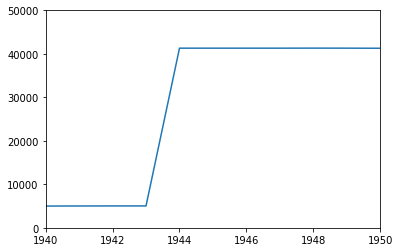

In [27]:

intName = get_intName(position)
x = []
a = []
for i in range(2000):
    if not i in intName:
        break
    if not intName[i] in intNameX:
        continue
    x.append(i)
    a.append(pos[intName[i]] - position[intName[i]])
plt.plot(x,a,)
plt.ylim(0,50000)
plt.xlim(1940,1950)

In [29]:
intNameX[1943]

'1918APD_0'

In [3]:
def verbessere_loop(datei, out): 
    
    data = read_file(datei, '')
    r = coll.Counter()
    for a,b,d in data:
        r[a] += 1
        r[b] += 1
    
    data2 = data
    data = [[a,b,d] for a,b,d in data if r[a] > 1 and r[b] > 1]# and a not in X and b not in X]
   # for i in range(1000):
    #    data.append(['2205APD_0','69APD_0',103069])
   # for i in range(100):
    #    data.append(['2345APD_0','2080APD_0',4099601.0])
    data = connected(data)
    position = {a for a,_,_ in data} | {b for _,b,_ in data}
    contig_repeat = coll.defaultdict(list)
    for contig in position:
        contig_repeat[contig_name(contig)].append(contig)
        
    Ret = coll.namedtuple('Ret', ['contig','güte'])
    ret = Ret(contig = [], güte = [])
    for i in range(2):
        print(str(i) + '. Durchlauf')
        position = solve_LP(position, data)
        print('max', max(position.values()))
        print('sortiere Bedingungen anderen repeats zu')
        umsortieren(data, contig_repeat, position)
        position = solve_LP(position, data)
        print('max', max(position.values()))
        print('sortiere Bedingungen anderen repeats zu')
        umsortieren(data, contig_repeat, position)
        return position, data, 1
        #constr_pos = get_constr_pos(data, contig_repeat, position)
        constr_pos = get_X_pos(data2, contig_repeat, position, X)
        #get_repeat_X(position,constr_pos, contig_repeat)
        contig, repeats, güte, groups = get_repeat(constr_pos, contig_repeat)
        if güte == 0:
            print(111)
            write_file(out, data)
            return position, data
        print(str(len(contig_repeat[contig])) + '. Repeat von '+contig)
        print('alte Positionen:')
        for rep in contig_repeat[contig]:
            print('\t', position[rep])
            
        new_contig = contig +'_'+ str(len(contig_repeat[contig]))
        contig_repeat[contig].append(new_contig)
        
        print('neue Positionen:')
        for name, werte in zip(contig_repeat[contig], repeats):
            position[name] = werte.pos
            print('\t', werte.pos)
            
        
        print('ordne neuem repeat zu: ')
        umsortieren(data2, contig_repeat, position)
        print()
        print()
        #out = 'out' + str(i//10) + '.lst'
        write_file(out, data2)
     #   ret.contig.append(contig)
     #   ret.güte.append(güte)
        #data = connected(data)
        #ret.append(Ret(
         #   contig = contig,
          #  güte = güte,
           # repeats = repeats,
            #constr_pos = constr_pos,
    #        pos = position,
     #       rep = contig_repeat,
      #      data = data
       # ))
    return position, data2, 1 #,ret
#position, data = verbessere_loop('my_apd200.lst', 'out.lst' )

#position2, data2, ret = verbessere_loop('my_apd199.lst', 'test.lst' )
position2, data2, ret = verbessere_loop('test.lst', 'test.lst' )


TypeError: read_file() takes 1 positional argument but 2 were given

In [9]:
contig_repeat = coll.defaultdict(list)
for contig in position:
    contig_repeat[contig_name(contig)].append(contig)

In [10]:
def entferne_sackgassen(graph, start = '2345APD_0', ziel = '2080APD_0'):
    änderungen = True
    while änderungen:
        änderungen = False
        for x in list(graph):
            if graph.in_degree[x] == 0 and x != start:
                graph.remove_node(x)
                änderungen = True
            elif graph.out_degree[x] == 0 and x != ziel:
                graph.remove_node(x)
                änderungen = True
                
def mehrfach(adj):
    for b,l in adj.items():
        if len(l) > 1:
            return True
    return False

def singels(graph):
    evil = []
    for a in graph:
        if mehrfach(graph.succ[a]) or mehrfach(graph.pred[a]):
            continue
        evil.append(a)
    return evil


graph = nx.MultiDiGraph() 
for a, b, d in data:
    if a != b:
        graph.add_edge(a,b,d)
        
evil = singels(graph)

count = coll.Counter((a,b) for a, b, d in data)
abgesichert = set()
for (i,j), a in count.items():
    if a > 1:
        abgesichert |= {i,j}

In [27]:
feste_position = {'2345APD_0': 0, '1395APD_0': 6982.0, '1596APD_0': 9952.0, '2235APD_0': 14269.0, '1534APD_0': 14941.0, '546APD_0': 16511.0, '577APD_0': 19014.0, '998APD_0': 32313.0, '209APD_0': 34132.0, '1635APD_0': 43535.0, '2109APD_0': 45637.0, '996APD_0': 47657.0, '1481APD_0': 49144.0, '2113APD_0': 55767.0, '1332APD_0': 64494.0, '225APD_0': 68363.0, '1894APD_0': 77439.0, '521APD_0': 80995.0, '1076APD_0': 83301.0, '301APD_0': 86477.0, '50APD_0': 88528.0, '2396APD_0': 90554.9323053167, '1980APD_0': 92187.9323053167, '958APD_0': 93267.9323053167, '2050APD_0': 95081.9323053167, '1113APD_0': 99611.16150611905, '960APD_0': 101534.16150611905, '831APD_0': 103166.0, '1877APD_0': 106398.0, '1337APD_0': 107251.0, '59APD_0': 114474.9323053167, '542APD_0': 120932.9323053167, '1631APD_0': 124902.9323053167, '176APD_0': 126130.0, '567APD_0': 128337.9323053167, '776APD_0': 130202.9323053167, '86APD_0': 131491.16150611907, '1529APD_0': 138169.0, '1057APD_0': 138854.0, '1472APD_0': 141026.0, '1714APD_0': 142777.9323053167, '1400APD_0': 145988.0, '2058APD_0': 149580.16150611907, '943APD_0': 151240.0, '511APD_0': 151970.9323053167, '1698APD_0': 157366.0, '1903APD_0': 158556.9323053167, '2387APD_0': 164056.9323053167, '1317APD_0': 165654.9323053167, '1857APD_0': 183019.0, '931APD_0': 185975.0, '1375APD_0': 186830.0, '156APD_0': 187849.0, '19APD_0': 190568.9323053167, '1252APD_0': 193655.9323053167, '772APD_0': 194388.0, '896APD_0': 195101.9323053167, '2013APD_0': 196813.0, '2322APD_0': 199619.0, '439APD_0': 202543.9323053167, '948APD_0': 203489.0, '1151APD_0': 205933.9323053167, '1904APD_0': 212325.16150611907, '945APD_0': 214369.9323053167, '2085APD_0': 215023.9323053167, '1779APD_0': 218431.0167818591, '1363APD_0': 219604.0, '1380APD_0': 220389.0, '1921APD_0': 222788.16150611907, '1465APD_0': 224878.0, '876APD_0': 226088.0, '793APD_0': 227266.0, '1991APD_0': 229453.9323053167, '2003APD_0': 232875.9323053167, '1397APD_0': 233538.0, '885APD_0': 235105.0, '205APD_0': 235920.0, '1017APD_0': 239570.0, '277APD_0': 241603.0167818591, '444APD_0': 243329.0, '374APD_0': 244151.0167818591, '1866APD_0': 246176.0, '1514APD_0': 246999.0167818591, '2197APD_0': 251052.0, '2088APD_0': 252362.16150611907, '580APD_0': 254846.0, '506APD_0': 264011.0, '2458APD_0': 267844.0, '480APD_0': 268721.0, '1246APD_0': 271731.0, '1334APD_0': 272710.0, '466APD_0': 274608.0, '855APD_0': 278930.9323053167, '547APD_0': 279883.0, '318APD_0': 280245.0, '682APD_0': 282088.2346662088, '601APD_0': 282728.0, '1939APD_0': 286081.0, '789APD_0': 287110.0, '1930APD_0': 288485.02958898427, '1543APD_0': 289322.16150611907, '88APD_0': 291709.0, '1955APD_0': 295408.0, '2380APD_0': 297161.0, '1390APD_0': 298599.0, '638APD_0': 300652.0, '216APD_0': 302252.9323053167, '1701APD_0': 307529.9323053167, '684APD_0': 309029.8899950047, '2125APD_0': 310899.9323053167, '764APD_0': 311342.9323053167, '898APD_0': 312158.0, '1966APD_0': 313387.9323053167, '1621APD_0': 313981.0, '157APD_0': 314613.0, '2122APD_0': 322106.0, '1942APD_0': 324504.16150611907, '1586APD_0': 325187.9323053167, '1494APD_0': 326706.9323053167, '832APD_0': 327686.0, '1590APD_0': 328986.0, '1248APD_0': 330380.0, '1889APD_0': 331059.0, '1622APD_0': 331540.16150611907, '241APD_0': 332401.0, '235APD_0': 340630.0, '184APD_0': 343575.0, '2296APD_0': 344552.0, '593APD_0': 347359.0, '2021APD_0': 347952.0, '986APD_0': 352602.0, '850APD_0': 355611.0, '1986APD_0': 357012.0, '35APD_0': 358780.0, '1672APD_0': 363706.0, '1445APD_0': 365326.0, '1454APD_0': 367103.0, '921APD_0': 367424.0, '2032APD_0': 372182.0, '1981APD_0': 374655.0, '735APD_0': 376433.0, '740APD_0': 379498.0, '1850APD_0': 380887.0, '1967APD_0': 382780.0, '1675APD_0': 384590.473152517, '1169APD_0': 385234.0, '1268APD_0': 385986.0, '208APD_0': 387502.0, '2149APD_0': 389692.0, '276APD_0': 392176.0, '98APD_0': 399605.0, '874APD_0': 400819.0, '1137APD_0': 401970.0, '2071APD_0': 402724.0, '1077APD_0': 403656.0, '80APD_0': 404188.0, '2011APD_0': 404954.0, '379APD_0': 405566.0, '1024APD_0': 406019.0, '588APD_0': 407292.0, '939APD_0': 410839.0, '1433APD_0': 413623.0, '1647APD_0': 414037.0, '1467APD_0': 416897.0, '1192APD_0': 418252.0, '335APD_0': 419175.0, '2256APD_0': 420358.0, '1038APD_0': 421940.23829773226, '429APD_0': 423034.23829773226, '68APD_0': 426336.23829773226, '2390APD_0': 426790.23829773226, '1010APD_0': 429184.0, '680APD_0': 432401.0, '1185APD_0': 436204.0, '1199APD_0': 436836.0, '1574APD_0': 438671.23829773226, '989APD_0': 439790.0, '106APD_0': 443893.0, '2423APD_0': 451664.0, '2434APD_0': 452712.0, '2461APD_0': 454268.0, '1281APD_0': 456958.0, '202APD_0': 461086.0, '90APD_0': 462372.473152517, '2367APD_0': 467252.0, '1661APD_0': 471243.0, '569APD_0': 473697.0, '1309APD_0': 474252.473152517, '1665APD_0': 475212.0, '153APD_0': 477523.23829773226, '1816APD_0': 478302.0, '1330APD_0': 480585.0, '2335APD_0': 482507.0, '1751APD_0': 483573.0, '904APD_0': 487632.0, '548APD_0': 488540.0, '811APD_0': 492088.0, '2415APD_0': 493902.0, '2204APD_0': 494838.0, '196APD_0': 501205.0, '714APD_0': 504981.0, '31APD_0': 506999.0, '656APD_0': 513325.0, '1410APD_0': 522508.0, '1852APD_0': 526822.0, '151APD_0': 528818.0, '861APD_0': 542020.0, '187APD_0': 542707.0, '1162APD_0': 551982.0, '459APD_0': 552763.0, '57APD_0': 556966.0, '900APD_0': 557883.0, '766APD_0': 558723.0, '189APD_0': 559552.2382977323, '1815APD_0': 573220.0, '2205APD_0': 575383.0, '58APD_0': 580807.0, '599APD_0': 588925.0, '345APD_0': 593363.0, '1463APD_0': 604009.2382977323, '865APD_0': 605198.2382977323, '407APD_0': 610069.2382977323, '2394APD_0': 611819.2382977323, '462APD_0': 613570.2382977323, '1500APD_0': 614341.2382977323, '1APD_0': 615116.2382977323, '1245APD_0': 623603.2382977323, '1423APD_0': 624932.2382977323, '2420APD_0': 632416.2382977323, '1439APD_0': 635553.2382977323, '703APD_0': 638143.2382977323, '421APD_0': 658217.2382977323, '37APD_0': 666831.2382977323, '44APD_0': 668089.2382977323, '11APD_0': 674309.2382977323, '1783APD_0': 680909.2382977323, '69APD_0': 686494.2382977323, '1022APD_0': 687364.2382977323, '681APD_0': 692015.2382977323, '2110APD_0': 695000.2382977323, '1773APD_0': 698388.2382977323, '94APD_0': 702701.2382977323, '1721APD_0': 711151.2382977323, '2410APD_0': 715968.2382977323, '89APD_0': 722997.2382977323, '1366APD_0': 726734.2382977323, '1651APD_0': 727275.2382977323, '119APD_0': 733462.2382977323, '572APD_0': 743783.2382977323, '2155APD_0': 753799.2382977323, '708APD_0': 759510.0766310074, '1522APD_0': 761041.0766310074, '134APD_0': 762423.0766310074, '525APD_0': 765329.0766310074, '597APD_0': 768257.0766310074, '75APD_0': 776675.0766310074, '497APD_0': 788319.0766310074, '464APD_0': 789953.0766310074, '1474APD_0': 790704.0766310074, '565APD_0': 791637.0766310074, '653APD_0': 794547.0766310074, '391APD_0': 795158.0766310074, '1507APD_0': 807370.0766310074, '167APD_0': 807934.0766310074, '2337APD_0': 816330.0766310074, '385APD_0': 817439.0766310074, '307APD_0': 818885.0766310074, '1261APD_0': 829336.0766310074, '1691APD_0': 830651.509677197, '452APD_0': 831324.509677197, '781APD_0': 854408.509677197, '1753APD_0': 855410.509677197, '1523APD_0': 860820.509677197, '995APD_0': 866848.509677197, '2460APD_0': 871756.509677197, '1033APD_0': 873861.509677197, '568APD_0': 875303.509677197, '1970APD_0': 882183.509677197, '820APD_0': 889271.509677197, '77APD_0': 889993.509677197, '1258APD_0': 891631.509677197, '1265APD_0': 897209.509677197, '1253APD_0': 899628.509677197, '73APD_0': 903466.509677197, '1460APD_0': 912104.509677197, '376APD_0': 917482.509677197, '806APD_0': 932673.7778545924, '2250APD_0': 936708.7778545924, '3APD_0': 944904.6069821372, '573APD_0': 949058.6069821372, '48APD_0': 957960.6069821372, '1055APD_0': 963369.3104909246, '117APD_0': 968094.3104909246, '639APD_0': 976938.7385117481, '2211APD_0': 981654.7385117481, '802APD_0': 984160.7385117481, '2077APD_0': 991534.7385117481, '1177APD_0': 1005285.7385117481, '1679APD_0': 1009248.7385117481, '1073APD_0': 1010693.7385117481, '1249APD_0': 1031567.7385117481, '1506APD_0': 1034245.7385117481, '783APD_0': 1035515.7385117481, '609APD_0': 1042600.2396140165, '1335APD_0': 1054141.7385117481, '742APD_0': 1056408.7385117481, '1835APD_0': 1057288.7385117481, '1837APD_0': 1058359.7385117481, '367APD_0': 1061414.9869302353, '2038APD_0': 1064096.9869302353, '398APD_0': 1075523.9869302353, '2275APD_0': 1081823.9869302353, '877APD_0': 1083407.9869302353, '2351APD_0': 1084567.524259436, '543APD_0': 1087041.524259436, '551APD_0': 1089926.524259436, '62APD_0': 1099063.524259436, '1048APD_0': 1101164.524259436, '2019APD_0': 1103959.543550645, '399APD_0': 1104615.524259436, '232APD_0': 1105361.524259436, '1453APD_0': 1106271.524259436, '2412APD_0': 1109844.524259436, '1798APD_0': 1117879.524259436, '23APD_0': 1118663.524259436, '265APD_0': 1122172.524259436, '1063APD_0': 1122776.524259436, '1817APD_0': 1124614.9840092727, '2112APD_0': 1127916.9840092727, '1893APD_0': 1129071.0238666832, '2190APD_0': 1133304.0238666832, '1568APD_0': 1133799.0238666832, '337APD_0': 1134539.9840092727, '980APD_0': 1137458.0238666832, '623APD_0': 1138213.0238666832, '745APD_0': 1140201.9840092727, '351APD_0': 1141512.9840092727, '2015APD_0': 1146344.524259436, '2339APD_0': 1149338.0238666832, '670APD_0': 1150422.0238666832, '1054APD_0': 1151076.0238666832, '2426APD_0': 1151832.9840092727, '358APD_0': 1153636.0238666832, '195APD_0': 1157457.0238666832, '1878APD_0': 1162614.0238666832, '788APD_0': 1163669.0238666832, '2223APD_0': 1164575.0238666832, '1935APD_0': 1165060.0238666832, '1583APD_0': 1166299.0238666832, '1785APD_0': 1169714.4089970493, '1789APD_0': 1170301.0238666832, '596APD_0': 1171273.0623984544, '1097APD_0': 1171803.0238666832, '944APD_0': 1176194.0238666832, '1895APD_0': 1177652.0238666832, '1544APD_0': 1178786.0238666832, '2368APD_0': 1180067.0238666832, '2331APD_0': 1181570.0238666832, '414APD_0': 1182334.0238666832, '2247APD_0': 1183868.0238666832, '2173APD_0': 1185732.0238666832, '1730APD_0': 1186410.0238666832, '2142APD_0': 1187391.0238666832, '219APD_0': 1188841.0238666832, '1607APD_0': 1192157.0238666832, '12APD_0': 1195788.0238666832, '2459APD_0': 1196378.0238666832, '501APD_0': 1196772.0238666832, '1259APD_0': 1206769.0238666832, '1693APD_0': 1208525.0238666832, '909APD_0': 1208902.0238666832, '640APD_0': 1209895.0238666832, '1049APD_0': 1217014.0238666832, '1391APD_0': 1220414.0238666832, '1495APD_0': 1220940.0238666832, '1974APD_0': 1223001.0238666832, '1430APD_0': 1232235.0238666832, '326APD_0': 1233492.0238666832, '1379APD_0': 1233790.0238666832, '584APD_0': 1234577.0238666832, '1969APD_0': 1235030.0238666832, '1396APD_0': 1236300.0238666832, '2386APD_0': 1240106.0238666832, '2214APD_0': 1241899.0238666832, '919APD_0': 1246741.0238666832, '1769APD_0': 1247895.0238666832, '1952APD_0': 1259512.0238666832, '198APD_0': 1264981.0238666832, '348APD_0': 1269459.0238666832, '829APD_0': 1270629.0238666832, '1525APD_0': 1272194.0238666832, '1295APD_0': 1277888.0238666832, '371APD_0': 1278455.0238666832, '1016APD_0': 1284785.0238666832, '1074APD_0': 1292005.0238666832, '145APD_0': 1315541.0238666832, '440APD_0': 1321144.0238666832, '290APD_0': 1328348.0238666832, '1874APD_0': 1331523.0238666832, '1015APD_0': 1340671.0238666832, '1813APD_0': 1343046.0238666832, '1505APD_0': 1343671.0238666832, '2034APD_0': 1345203.0238666832, '182APD_0': 1346946.0238666832, '332APD_0': 1357928.0238666832, '1742APD_0': 1358216.0238666832, '316APD_0': 1359317.369214408, '131APD_0': 1363760.369214408, '1011APD_0': 1363905.369214408, '751APD_0': 1365310.369214408, '2324APD_0': 1366145.369214408, '84APD_0': 1366553.369214408, '14APD_0': 1373477.369214408, '970APD_0': 1381312.369214408, '342APD_0': 1382895.369214408, '271APD_0': 1385353.369214408, '132APD_0': 1393197.369214408, '279APD_0': 1398014.7182576736, '737APD_0': 1403887.7182576736, '211APD_0': 1405167.7182576736, '2195APD_0': 1409297.7182576736, '18APD_0': 1410982.7182576736, '477APD_0': 1418966.7182576736, '113APD_0': 1418993.7182576736, '40APD_0': 1429462.7182576736, '2066APD_0': 1441869.7182576736, '1285APD_0': 1443455.7182576736, '483APD_0': 1444532.7182576736, '2043APD_0': 1450151.7182576736, '300APD_0': 1452435.7182576736, '64APD_0': 1452873.7182576736, '1208APD_0': 1456196.7182576736, '658APD_0': 1457200.7182576736, '1510APD_0': 1458102.7182576736, '1114APD_0': 1460300.7182576736, '2278APD_0': 1463197.7182576736, '1948APD_0': 1491153.7182576736, '1822APD_0': 1492372.7182576736, '494APD_0': 1496221.5314285422, '2455APD_0': 1497723.5314285422, '2399APD_0': 1501679.5314285422, '1572APD_0': 1502815.5314285422, '999APD_0': 1504320.5314285422, '2141APD_0': 1506354.5314285422, '485APD_0': 1507068.5314285422, '484APD_0': 1518077.5314285422, '51APD_0': 1524929.5314285422, '253APD_0': 1527112.8130824585, '454APD_0': 1527807.5314285422, '2391APD_0': 1532212.5314285422, '994APD_0': 1538153.5314285422, '361APD_0': 1539649.5314285422, '1599APD_0': 1546926.5314285422, '2046APD_0': 1550002.014474229, '891APD_0': 1550808.5314285422, '555APD_0': 1551117.5314285422, '1412APD_0': 1561298.5314285422, '1922APD_0': 1561736.5314285422, '1750APD_0': 1563498.5314285422, '903APD_0': 1567811.5314285422, '724APD_0': 1569813.5314285422, '1276APD_0': 1570241.5314285422, '1634APD_0': 1571365.5314285422, '2102APD_0': 1574074.5314285422, '1747APD_0': 1581549.5314285422, '1416APD_0': 1582316.5314285422, '1191APD_0': 1583509.5314285422, '1706APD_0': 1584954.5314285422, '1941APD_0': 1586118.5314285422, '2172APD_0': 1589955.5314285422, '2004APD_0': 1591677.5314285422, '210APD_0': 1595605.5314285422, '2370APD_0': 1597981.5314285422, '273APD_0': 1598742.5314285422, '894APD_0': 1607854.5314285422, '1908APD_0': 1609867.5314285422, '1749APD_0': 1612703.5314285422, '559APD_0': 1613989.5314285422, '1441APD_0': 1618013.5314285422, '350APD_0': 1619774.2862152983, '1240APD_0': 1624161.5314285422, '2287APD_0': 1627953.5314285422, '1368APD_0': 1632134.5314285422, '381APD_0': 1636696.2862152983, '1181APD_0': 1646248.5314285422, '768APD_0': 1649171.5314285422, '2073APD_0': 1650243.5314285422, '722APD_0': 1652672.4096520562, '441APD_0': 1654792.5314285422, '1386APD_0': 1657156.5314285422, '955APD_0': 1658211.5314285422, '1812APD_0': 1660698.5314285422, '2269APD_0': 1662383.2862152983, '1002APD_0': 1665505.5314285422, '1195APD_0': 1667282.5314285422, '2039APD_0': 1673734.5314285422, '1473APD_0': 1675924.5314285422, '1003APD_0': 1677133.5314285422, '964APD_0': 1677869.5314285422, '902APD_0': 1678866.5314285422, '1440APD_0': 1682982.5314285422, '1406APD_0': 1684275.5314285422, '1880APD_0': 1686998.5314285422, '859APD_0': 1689967.5314285422, '2020APD_0': 1691811.5314285422, '610APD_0': 1695043.5314285422, '1035APD_0': 1696247.5314285422, '975APD_0': 1697380.5314285422, '1491APD_0': 1699225.5314285422, '2159APD_0': 1701062.5314285422, '1689APD_0': 1706709.5314285422, '1417APD_0': 1709036.5314285422, '755APD_0': 1709920.5314285422, '1415APD_0': 1711052.5314285422, '1223APD_0': 1714607.5314285422, '1823APD_0': 1717875.5314285422, '2286APD_0': 1719567.5314285422, '564APD_0': 1721994.5314285422, '1346APD_0': 1725143.5314285422, '384APD_0': 1742586.5314285422, '240APD_0': 1746515.5314285422, '2212APD_0': 1753493.5314285422, '549APD_0': 1760751.5314285422, '777APD_0': 1766395.5314285422, '1006APD_0': 1767002.5314285422, '1978APD_0': 1769598.5314285422, '2037APD_0': 1771842.5314285422, '2182APD_0': 1777768.5314285422, '2395APD_0': 1780030.5314285422, '380APD_0': 1782958.5314285422, '510APD_0': 1784733.5314285422, '2349APD_0': 1785333.5314285422, '147APD_0': 1792756.5314285422, '2323APD_0': 1797041.5314285422, '357APD_0': 1801139.5314285422, '1644APD_0': 1803140.5314285422, '1968APD_0': 1805176.5314285422, '676APD_0': 1807244.5314285422, '1030APD_0': 1813027.5314285422, '1354APD_0': 1815060.5314285422, '2157APD_0': 1819596.5314285422, '1977APD_0': 1821951.5314285422, '2056APD_0': 1825356.5314285422, '2148APD_0': 1828092.5314285422, '1451APD_0': 1828905.206260193, '280APD_0': 1829932.206260193, '1799APD_0': 1834814.206260193, '743APD_0': 1838149.5314285422, '878APD_0': 1838997.206260193, '1809APD_0': 1840124.5314285422, '1752APD_0': 1844970.5314285422, '1744APD_0': 1847337.5314285422, '1150APD_0': 1850008.5314285422, '2297APD_0': 1851716.5314285422, '2000APD_0': 1854339.5314285422, '1503APD_0': 1856270.5314285422, '476APD_0': 1857877.5314285422, '1405APD_0': 1873833.5314285422, '523APD_0': 1875971.5314285422, '394APD_0': 1894311.5314285422, '178APD_0': 1896977.5314285422, '498APD_0': 1898244.5314285422, '251APD_0': 1906720.5314285422, '2083APD_0': 1910207.5314285422, '1389APD_0': 1911599.5314285422, '1358APD_0': 1913563.5314285422, '2413APD_0': 1917630.5314285422, '779APD_0': 1918390.4116226004, '325APD_0': 1918943.5314285422, '927APD_0': 1930234.5314285422, '365APD_0': 1932838.5314285422, '1704APD_0': 1946217.5314285422, '2118APD_0': 1947393.82415232, '408APD_0': 1949721.82415232, '936APD_0': 1950279.82415232, '311APD_0': 1950791.5314285422, '1155APD_0': 1957010.5314285422, '1369APD_0': 1958828.5314285422, '1851APD_0': 1960731.5314285422, '1547APD_0': 1963595.5314285422, '1428APD_0': 1965332.5314285422, '892APD_0': 1968404.5314285422, '148APD_0': 1971529.5314285422, '2044APD_0': 1972787.5314285422, '827APD_0': 1975410.5314285422, '2227APD_0': 1976510.5314285422, '2429APD_0': 1977313.5314285422, '982APD_0': 1978786.5314285422, '2051APD_0': 1979985.5314285422, '835APD_0': 1980500.5314285422, '1404APD_0': 1982641.5314285422, '738APD_0': 1985396.5314285422, '1552APD_0': 1986107.5314285422, '727APD_0': 1988950.5314285422, '631APD_0': 1989961.5314285422, '748APD_0': 1992904.5314285422, '1347APD_0': 1994403.5314285422, '217APD_0': 1996310.5314285422, '527APD_0': 2001059.5314285422, '529APD_0': 2001913.5314285422, '1946APD_0': 2004566.5314285422, '1104APD_0': 2005257.5314285422, '759APD_0': 2006004.5314285422, '188APD_0': 2008473.5314285422, '1825APD_0': 2009511.5314285422, '320APD_0': 2010225.5314285422, '1860APD_0': 2012693.5314285422, '1926APD_0': 2013108.5314285422, '2398APD_0': 2013882.5314285422, '125APD_0': 2022790.5314285422, '1711APD_0': 2029238.5314285422, '1845APD_0': 2032731.8534698505, '1928APD_0': 2034733.8534698505, '2187APD_0': 2036564.5314285422, '1733APD_0': 2038196.5314285422, '1176APD_0': 2039363.5314285422, '55APD_0': 2040551.5314285422, '1157APD_0': 2042015.5314285422, '716APD_0': 2046966.5314285422, '1570APD_0': 2048178.5314285422, '6APD_0': 2049078.5314285422, '1436APD_0': 2051779.5314285422, '2326APD_0': 2052257.5314285422, '1535APD_0': 2053109.8534698505, '1143APD_0': 2053800.8534698505, '1408APD_0': 2054784.5314285422, '2379APD_0': 2059986.5314285422, '463APD_0': 2060598.5314285422, '1140APD_0': 2062309.8534698505, '347APD_0': 2066239.5314285422, '1283APD_0': 2066739.5314285422, '1649APD_0': 2068169.5314285422, '1413APD_0': 2069400.5314285422, '2099APD_0': 2070673.5314285422, '2409APD_0': 2072026.5314285422, '1103APD_0': 2072696.4829437663, '1088APD_0': 2073087.5314285422, '1036APD_0': 2078405.5314285422, '2255APD_0': 2080499.5314285422, '1485APD_0': 2080817.5314285422, '1819APD_0': 2086800.5314285422, '1456APD_0': 2087720.5314285422, '285APD_0': 2090724.5314285422, '2369APD_0': 2093385.5314285422, '1827APD_0': 2095206.5314285422, '2108APD_0': 2095955.5314285422, '2293APD_0': 2096399.5314285422, '168APD_0': 2098700.531428542, '545APD_0': 2101529.531428542, '1937APD_0': 2101852.531428542, '2359APD_0': 2103520.531428542, '1393APD_0': 2104850.531428542, '356APD_0': 2105484.531428542, '1385APD_0': 2107232.531428542, '2APD_0': 2108087.531428542, '1321APD_0': 2109848.002978301, '109APD_0': 2110162.531428542, '2145APD_0': 2111026.531428542, '1776APD_0': 2111939.531428542, '1717APD_0': 2112561.531428542, '1886APD_0': 2113527.531428542, '2203APD_0': 2114061.531428542, '1458APD_0': 2115262.002978301, '1457APD_0': 2117053.531428542, '1746APD_0': 2117608.531428542, '946APD_0': 2119803.531428542, '1549APD_0': 2121067.531428542, '1351APD_0': 2122762.531428542, '988APD_0': 2123274.6736311223, '518APD_0': 2123864.6736311223, '1164APD_0': 2124586.6736311223, '1132APD_0': 2129669.531428542, '882APD_0': 2130885.531428542, '778APD_0': 2133206.6736311223, '1696APD_0': 2136044.531428542, '675APD_0': 2136795.6736311223, '590APD_0': 2139885.6736311223, '1197APD_0': 2142051.531428542, '1756APD_0': 2146387.6736311223, '990APD_0': 2146990.531428542, '683APD_0': 2147780.531428542, '191APD_0': 2150626.6736311223, '785APD_0': 2151715.6736311223, '1479APD_0': 2153310.531428542, '813APD_0': 2153971.6736311223, '519APD_0': 2156337.531428542, '1031APD_0': 2156961.6736311223, '884APD_0': 2159381.531428542, '1723APD_0': 2164313.6736311223, '1515APD_0': 2165278.531428542, '2305APD_0': 2166144.531428542, '797APD_0': 2167537.6736311223, '1231APD_0': 2168126.531428542, '2009APD_0': 2169472.6736311223, '1524APD_0': 2170262.531428542, '1084APD_0': 2171814.531428542, '1272APD_0': 2173460.531428542, '104APD_0': 2174330.531428542, '1826APD_0': 2177729.531428542, '1301APD_0': 2178672.531428542, '478APD_0': 2180877.531428542, '340APD_0': 2186446.531428542, '2277APD_0': 2188152.531428542, '315APD_0': 2190997.531428542, '1528APD_0': 2193726.531428542, '2404APD_0': 2198756.531428542, '1356APD_0': 2200352.458615996, '2193APD_0': 2200954.3257299787, '1499APD_0': 2203366.3257299787, '1090APD_0': 2204219.531428542, '1957APD_0': 2206137.531428542, '1210APD_0': 2207264.531428542, '1443APD_0': 2207747.06174536, '314APD_0': 2208335.06174536, '1867APD_0': 2211146.06174536, '1101APD_0': 2212627.06174536, '1117APD_0': 2214541.06174536, '1862APD_0': 2216565.06174536, '79APD_0': 2218444.06174536, '1025APD_0': 2225807.531428542, '1487APD_0': 2226485.531428542, '101APD_0': 2227556.531428542, '389APD_0': 2229042.531428542, '93APD_0': 2231679.531428542, '403APD_0': 2235203.531428542, '920APD_0': 2239732.531428542, '857APD_0': 2243571.531428542, '1179APD_0': 2245437.531428542, '1149APD_0': 2246937.531428542, '70APD_0': 2248049.531428542, '61APD_0': 2252676.531428542, '2435APD_0': 2255997.531428542, '1600APD_0': 2256690.531428542, '1242APD_0': 2257558.531428542, '1578APD_0': 2258147.531428542, '1314APD_0': 2259258.531428542, '856APD_0': 2259908.531428542, '1189APD_0': 2261187.531428542, '359APD_0': 2266218.531428542, '1227APD_0': 2269688.531428542, '1720APD_0': 2274681.531428542, '1323APD_0': 2278463.531428542, '846APD_0': 2282199.531428542, '492APD_0': 2283391.531428542, '226APD_0': 2284806.531428542, '1213APD_0': 2287091.531428542, '1876APD_0': 2288450.531428542, '624APD_0': 2292762.531428542, '2103APD_0': 2295015.358430599, '2140APD_0': 2296085.358430599, '1085APD_0': 2296866.531428542, '1007APD_0': 2298010.358430599, '185APD_0': 2299492.358430599, '1842APD_0': 2302435.531428542, '1275APD_0': 2303680.531428542, '2153APD_0': 2304372.531428542, '312APD_0': 2305488.531428542, '752APD_0': 2307467.531428542, '2209APD_0': 2309820.531428542, '1520APD_0': 2310511.531428542, '2081APD_0': 2311619.531428542, '1605APD_0': 2313754.531428542, '536APD_0': 2316180.531428542, '1551APD_0': 2317687.531428542, '608APD_0': 2318170.010256245, '2346APD_0': 2318759.010256245, '668APD_0': 2324665.010256245, '1645APD_0': 2325355.010256245, '286APD_0': 2330033.010256245, '814APD_0': 2336957.010256245, '138APD_0': 2338100.010256245, '1148APD_0': 2341433.010256245, '1641APD_0': 2343655.010256245, '38APD_0': 2345887.04885921, '880APD_0': 2351142.010256245, '177APD_0': 2353867.010256245, '2316APD_0': 2355761.010256245, '1498APD_0': 2360524.010256245, '224APD_0': 2362479.010256245, '976APD_0': 2368260.010256245, '1954APD_0': 2373006.010256245, '1341APD_0': 2374430.010256245, '2052APD_0': 2375058.010256245, '1770APD_0': 2376441.010256245, '1289APD_0': 2377210.010256245, '739APD_0': 2377933.010256245, '1975APD_0': 2378416.010256245, '1247APD_0': 2385201.010256245, '950APD_0': 2387293.010256245, '809APD_0': 2398080.010256245, '1655APD_0': 2398866.010256245, '2279APD_0': 2400433.010256245, '2040APD_0': 2403406.010256245, '1965APD_0': 2404521.010256245, '2131APD_0': 2406830.010256245, '1122APD_0': 2410254.010256245, '602APD_0': 2412225.010256245, '1280APD_0': 2414612.010256245, '475APD_0': 2416239.010256245, '2230APD_0': 2420144.010256245, '436APD_0': 2420792.618639554, '1262APD_0': 2421225.758403923, '873APD_0': 2421860.758403923, '774APD_0': 2424669.758403923, '1538APD_0': 2426840.859372155, '556APD_0': 2430122.859372155, '2406APD_0': 2431625.859372155, '1671APD_0': 2433929.859372155, '1938APD_0': 2434325.859372155, '524APD_0': 2438791.859372155, '1767APD_0': 2445279.859372155, '193APD_0': 2447515.859372155, '227APD_0': 2451980.859372155, '528APD_0': 2459678.859372155, '1079APD_0': 2462665.859372155, '126APD_0': 2463480.859372155, '368APD_0': 2464354.859372155, '1836APD_0': 2465666.859372155, '431APD_0': 2468958.859372155, '2237APD_0': 2476097.9336795155, '1102APD_0': 2479476.9336795155, '566APD_0': 2481813.859372155, '756APD_0': 2484324.859372155, '1919APD_0': 2487282.859372155, '1421APD_0': 2491603.859372155, '1814APD_0': 2492601.859372155, '1383APD_0': 2494318.5249846797, '2062APD_0': 2496028.859372155, '2290APD_0': 2500836.859372155, '973APD_0': 2501635.859372155, '2023APD_0': 2506532.466780926, '1843APD_0': 2506883.466780926, '604APD_0': 2507651.466780926, '1099APD_0': 2511366.466780926, '2055APD_0': 2512981.466780926, '1871APD_0': 2516296.466780926, '826APD_0': 2517880.859372155, '1732APD_0': 2522464.466780926, '1172APD_0': 2523609.466780926, '2192APD_0': 2524921.3390496876, '1971APD_0': 2526379.3390496876, '2219APD_0': 2528798.466780926, '1348APD_0': 2532689.466780926, '170APD_0': 2533376.466780926, '461APD_0': 2537288.466780926, '2432APD_0': 2538772.466780926, '127APD_0': 2540192.466780926, '2189APD_0': 2540880.466780926, '1532APD_0': 2541699.466780926, '1979APD_0': 2546977.466780926, '578APD_0': 2548582.466780926, '121APD_0': 2550616.6353011206, '2327APD_0': 2551018.466780926, '1066APD_0': 2551518.3390496876, '1226APD_0': 2554660.466780926, '1091APD_0': 2555563.3390496876, '2184APD_0': 2556848.466780926, '1563APD_0': 2562612.3390496876, '910APD_0': 2566238.3390496876, '929APD_0': 2568957.466780926, '1361APD_0': 2570857.3390496876, '1993APD_0': 2575081.3390496876, '2315APD_0': 2578644.3390496876, '616APD_0': 2579916.3390496876, '102APD_0': 2582426.3390496876, '287APD_0': 2588089.3390496876, '1204APD_0': 2591998.3390496876, '1273APD_0': 2594317.3390496876, '2454APD_0': 2598098.3390496876, '1902APD_0': 2600934.3390496876, '130APD_0': 2603395.3390496876, '1205APD_0': 2603969.3390496876, '1159APD_0': 2604700.3390496876, '1349APD_0': 2606102.3390496876, '619APD_0': 2609435.3390496876, '1669APD_0': 2611391.3390496876, '1620APD_0': 2613654.3390496876, '360APD_0': 2614520.3390496876, '1708APD_0': 2621372.3390496876, '2330APD_0': 2622127.3390496876, '313APD_0': 2625257.3390496876, '1037APD_0': 2628555.3390496876, '1562APD_0': 2631074.3390496876, '2226APD_0': 2634091.3390496876, '141APD_0': 2639565.3390496876, '2438APD_0': 2641152.3390496876, '1373APD_0': 2643583.3390496876, '63APD_0': 2644798.3390496876, '2320APD_0': 2649962.3390496876, '888APD_0': 2652713.3390496876, '917APD_0': 2654667.3390496876, '1225APD_0': 2655352.3390496876, '1142APD_0': 2658017.3390496876, '824APD_0': 2660007.3390496876, '2202APD_0': 2661198.3390496876, '274APD_0': 2662711.3390496876, '1021APD_0': 2663580.5338916057, '526APD_0': 2664110.2886260333, '1290APD_0': 2664859.8532682345, '1685APD_0': 2665632.657245382, '522APD_0': 2668828.657245382, '2174APD_0': 2671481.657245382, '1804APD_0': 2672227.657245382, '2259APD_0': 2674590.716189146, '1582APD_0': 2677142.716189146, '844APD_0': 2678972.657245382, '922APD_0': 2679832.657245382, '2342APD_0': 2680591.657245382, '795APD_0': 2682725.657245382, '1830APD_0': 2683573.716189146, '1536APD_0': 2686342.657245382, '2225APD_0': 2688378.657245382, '2036APD_0': 2689820.657245382, '2340APD_0': 2691530.657245382, '834APD_0': 2692068.657245382, '563APD_0': 2694385.657245382, '1699APD_0': 2694755.657245382, '1748APD_0': 2696511.657245382, '1475APD_0': 2698098.657245382, '2200APD_0': 2699407.657245382, '405APD_0': 2701129.657245382, '1125APD_0': 2702698.657245382, '1617APD_0': 2712674.657245382, '1220APD_0': 2713811.657245382, '862APD_0': 2714284.657245382, '1640APD_0': 2720307.657245382, '504APD_0': 2720979.657245382, '49APD_0': 2727127.359840935, '116APD_0': 2737539.359840935, '150APD_0': 2737592.359840935, '2236APD_0': 2739300.359840935, '1224APD_0': 2739800.359840935, '2123APD_0': 2739873.359840935, '799APD_0': 2740390.359840935, '1800APD_0': 2742574.8247637777, '736APD_0': 2743080.891897501, '230APD_0': 2743667.3849714817, '432APD_0': 2745099.3849714817, '1923APD_0': 2752533.3849714817, '2169APD_0': 2753006.3531530458, '1420APD_0': 2756476.3531530458, '1657APD_0': 2758125.3531530458, '849APD_0': 2762321.3531530458, '1471APD_0': 2773821.3531530458, '618APD_0': 2778642.3531530458, '303APD_0': 2779190.3531530458, '15APD_0': 2781904.3531530458, '2210APD_0': 2785929.3531530458, '430APD_0': 2788685.3531530458, '319APD_0': 2800630.3531530458, '1612APD_0': 2803593.3531530458, '853APD_0': 2816901.3531530458, '1160APD_0': 2817143.3531530458, '428APD_0': 2819959.3531530458, '1818APD_0': 2820702.3531530458, '544APD_0': 2821283.3531530458, '1449APD_0': 2821799.3531530458, '2301APD_0': 2822339.3531530458, '2048APD_0': 2824613.3531530458, '672APD_0': 2831730.3531530458, '2091APD_0': 2840176.3531530458, '633APD_0': 2846366.3531530458, '650APD_0': 2847807.3531530458, '221APD_0': 2850008.3531530458, '53APD_0': 2850326.3531530458, '72APD_0': 2851200.3531530458, '445APD_0': 2851211.3531530458, '2178APD_0': 2852450.3531530458, '1959APD_0': 2853313.3531530458, '291APD_0': 2854667.3531530458, '346APD_0': 2855913.3531530458, '220APD_0': 2857410.3531530458, '744APD_0': 2860893.3531530458, '1211APD_0': 2861241.3531530458, '576APD_0': 2862055.3531530458, '369APD_0': 2862541.3531530458, '1064APD_0': 2864478.3531530458, '816APD_0': 2864971.5896890964, '411APD_0': 2865255.599981639, '465APD_0': 2865813.599981639, '159APD_0': 2869767.599981639, '2007APD_0': 2876422.599981639, '2243APD_0': 2878714.599981639, '78APD_0': 2879270.599981639, '655APD_0': 2879909.8921388504, '1427APD_0': 2886107.8921388504, '1316APD_0': 2898771.599981639, '2086APD_0': 2902124.646998983, '1338APD_0': 2903141.599981639, '1611APD_0': 2903762.599981639, '142APD_0': 2907872.599981639, '1448APD_0': 2918145.646998983, '1945APD_0': 2919329.646998983, '390APD_0': 2921607.036299473, '258APD_0': 2932419.599981639, '1885APD_0': 2942964.599981639, '1279APD_0': 2944340.599981639, '422APD_0': 2960591.599981639, '20APD_0': 2964844.599981639, '1296APD_0': 2972644.599981639, '143APD_0': 2974740.599981639, '887APD_0': 2977544.599981639, '249APD_0': 2978947.599981639, '2341APD_0': 2982572.599981639, '257APD_0': 2984477.8921388504, '246APD_0': 2985353.8921388504, '201APD_0': 2985885.599981639, '1924APD_0': 2988603.599981639, '531APD_0': 2989893.646998983, '2422APD_0': 2990854.599981639, '2384APD_0': 2991927.646998983, '1762APD_0': 2993460.646998983, '136APD_0': 3001159.599981639, '1202APD_0': 3004872.599981639, '983APD_0': 3010681.599981639, '1278APD_0': 3013514.646998983, '1116APD_0': 3016387.599981639, '1201APD_0': 3017585.646998983, '67APD_0': 3018485.599981639, '1264APD_0': 3022147.646998983, '1754APD_0': 3023328.002491878, '2428APD_0': 3025187.002491878, '1043APD_0': 3028113.8921388504, '1803APD_0': 3030225.646998983, '1909APD_0': 3031500.599981639, '733APD_0': 3033568.599981639, '1128APD_0': 3042860.599981639, '821APD_0': 3044142.036299473, '1960APD_0': 3045188.036299473, '36APD_0': 3048765.646998983, '1434APD_0': 3052661.599981639, '355APD_0': 3053683.036299473, '2360APD_0': 3054476.8921388504, '133APD_0': 3055560.036299473, '1545APD_0': 3056828.599981639, '1327APD_0': 3058557.036299473, '600APD_0': 3059565.036299473, '972APD_0': 3060479.036299473, '1927APD_0': 3060763.599981639, '2098APD_0': 3061744.599981639, '2082APD_0': 3062432.599981639, '622APD_0': 3063716.13312504, '1602APD_0': 3064529.599981639, '1736APD_0': 3065564.646998983, '328APD_0': 3066240.599981639, '598APD_0': 3066682.599981639, '2168APD_0': 3068642.599981639, '2267APD_0': 3069077.599981639, '1805APD_0': 3071127.599981639, '1221APD_0': 3072788.599981639, '1394APD_0': 3073499.599981639, '1239APD_0': 3077016.8921388504, '363APD_0': 3077395.599981639, '692APD_0': 3077986.599981639, '652APD_0': 3078389.719620163, '2318APD_0': 3078702.599981639, '792APD_0': 3080780.599981639, '1051APD_0': 3082570.599981639, '1915APD_0': 3084089.646998983, '895APD_0': 3085843.646998983, '1333APD_0': 3088953.599981639, '343APD_0': 3091105.599981639, '1759APD_0': 3096951.599981639, '697APD_0': 3098085.599981639, '1112APD_0': 3101574.599981639, '1198APD_0': 3102892.599981639, '1796APD_0': 3105935.599981639, '282APD_0': 3107152.599981639, '2416APD_0': 3109777.599981639, '1336APD_0': 3111481.599981639, '2163APD_0': 3113368.599981639, '2053APD_0': 3116255.599981639, '1917APD_0': 3117908.599981639, '605APD_0': 3119889.599981639, '1682APD_0': 3122285.599981639, '2047APD_0': 3125302.599981639, '336APD_0': 3129144.599981639, '2436APD_0': 3132877.599981639, '540APD_0': 3133681.599981639, '1042APD_0': 3137909.599981639, '702APD_0': 3139991.599981639, '966APD_0': 3141798.599981639, '842APD_0': 3143304.599981639, '1565APD_0': 3144364.599981639, '415APD_0': 3150547.599981639, '1891APD_0': 3157154.599981639, '1342APD_0': 3158149.599981639, '1614APD_0': 3158856.599981639, '283APD_0': 3159452.599981639, '21APD_0': 3162900.599981639, '2449APD_0': 3163734.599981639, '1546APD_0': 3164977.599981639, '1209APD_0': 3167925.599981639, '1303APD_0': 3170492.599981639, '1131APD_0': 3171808.599981639, '1492APD_0': 3172388.599981639, '1444APD_0': 3174605.599981639, '1910APD_0': 3175900.014494519, '2262APD_0': 3183910.599981639, '1556APD_0': 3187021.599981639, '1442APD_0': 3188805.599981639, '1217APD_0': 3189842.599981639, '2152APD_0': 3191661.599981639, '2452APD_0': 3194362.599981639, '2217APD_0': 3195941.014494519, '1755APD_0': 3197632.599981639, '333APD_0': 3198394.599981639, '763APD_0': 3200208.599981639, '754APD_0': 3203538.599981639, '981APD_0': 3204524.599981639, '1998APD_0': 3207363.599981639, '1722APD_0': 3207939.599981639, '1588APD_0': 3210031.532099344, '2338APD_0': 3211107.599981639, '704APD_0': 3212568.599981639, '4APD_0': 3213159.599981639, '140APD_0': 3214436.599981639, '1305APD_0': 3226537.599981639, '686APD_0': 3227222.599981639, '296APD_0': 3228963.599981639, '1623APD_0': 3229400.599981639, '1446APD_0': 3230920.599981639, '2027APD_0': 3232430.599981639, '2421APD_0': 3235281.599981639, '124APD_0': 3237997.599981639, '1890APD_0': 3241896.599981639, '848APD_0': 3244442.599981639, '386APD_0': 3246245.599981639, '1912APD_0': 3248216.599981639, '263APD_0': 3248675.599981639, '181APD_0': 3251564.599981639, '1230APD_0': 3252075.599981639, '1173APD_0': 3253843.599981639, '2362APD_0': 3254676.599981639, '1865APD_0': 3255958.599981639, '1687APD_0': 3256624.599981639, '1739APD_0': 3257527.599981639, '932APD_0': 3259018.599981639, '2006APD_0': 3261398.599981639, '611APD_0': 3262636.599981639, '1072APD_0': 3263143.599981639, '1709APD_0': 3265363.599981639, '732APD_0': 3266390.599981639, '243APD_0': 3267289.599981639, '28APD_0': 3269928.599981639, '1034APD_0': 3272856.599981639, '74APD_0': 3273465.599981639, '487APD_0': 3274509.599981639, '2104APD_0': 3277461.599981639, '2325APD_0': 3278346.599981639, '2310APD_0': 3279318.599981639, '317APD_0': 3279819.599981639, '1183APD_0': 3282255.599981639, '2357APD_0': 3282732.599981639, '1872APD_0': 3283406.599981639, '392APD_0': 3286731.599981639, '1196APD_0': 3288603.599981639, '2150APD_0': 3289813.599981639, '1286APD_0': 3290327.599981639, '1452APD_0': 3291129.599981639, '289APD_0': 3291509.599981639, '626APD_0': 3293505.599981639, '1392APD_0': 3296476.599981639, '1964APD_0': 3298047.599981639, '798APD_0': 3299935.599981639, '2427APD_0': 3300801.599981639, '2271APD_0': 3301381.599981639, '782APD_0': 3302596.599981639, '534APD_0': 3305039.599981639, '550APD_0': 3306552.599981639, '231APD_0': 3307350.599981639, '539APD_0': 3308599.599981639, '1462APD_0': 3309538.599981639, '1683APD_0': 3312802.599981639, '1089APD_0': 3313441.599981639, '1616APD_0': 3314489.599981639, '30APD_0': 3315346.599981639, '456APD_0': 3316093.599981639, '2274APD_0': 3321519.599981639, '2238APD_0': 3322037.599981639, '1581APD_0': 3324324.599981639, '2139APD_0': 3325206.599981639, '949APD_0': 3327349.599981639, '1724APD_0': 3330170.599981639, '2268APD_0': 3330892.599981639, '2005APD_0': 3331395.599981639, '144APD_0': 3336349.599981639, '174APD_0': 3339767.599981639, '930APD_0': 3342470.599981639, '1178APD_0': 3343334.599981639, '513APD_0': 3347496.8821616448, '203APD_0': 3348169.599981639, '1190APD_0': 3350715.599981639, '2176APD_0': 3351368.599981639, '1120APD_0': 3352604.599981639, '2165APD_0': 3354852.599981639, '66APD_0': 3355851.599981639, '517APD_0': 3359539.599981639, '1662APD_0': 3364219.782576262, '354APD_0': 3364677.193713262, '796APD_0': 3365227.4497246174, '710APD_0': 3365737.4497246174, '804APD_0': 3366703.4497246174, '402APD_0': 3367422.4497246174, '2447APD_0': 3369006.4497246174, '45APD_0': 3370111.4497246174, '1999APD_0': 3371024.4497246174, '1419APD_0': 3371859.4497246174, '557APD_0': 3374346.4497246174, '252APD_0': 3376159.4497246174, '2101APD_0': 3380637.4497246174, '1690APD_0': 3383623.4497246174, '2371APD_0': 3386712.4497246174, '1214APD_0': 3387059.4497246174, '647APD_0': 3389386.4497246174, '815APD_0': 3393274.4497246174, '691APD_0': 3393929.4497246174, '1790APD_0': 3394461.4497246174, '2115APD_0': 3395223.4497246174, '967APD_0': 3396221.4497246174, '2078APD_0': 3398810.4497246174, '499APD_0': 3412476.4497246174, '901APD_0': 3422635.4497246174, '1810APD_0': 3424696.4497246174, '26APD_0': 3425193.4497246174, '1028APD_0': 3430606.4497246174, '911APD_0': 3431501.4497246174, '1961APD_0': 3433763.4497246174, '907APD_0': 3434575.4497246174, '607APD_0': 3435482.4497246174, '1497APD_0': 3436961.4497246174, '2328APD_0': 3441429.4497246174, '2185APD_0': 3442395.4497246174, '558APD_0': 3442984.4497246174, '419APD_0': 3452639.4497246174, '1697APD_0': 3453571.4497246174, '52APD_0': 3460753.4497246174, '47APD_0': 3461405.4497246174, '162APD_0': 3463606.4497246174, '108APD_0': 3464746.4497246174, '1004APD_0': 3465017.4497246174, '2374APD_0': 3466888.4497246174, '370APD_0': 3467264.4497246174, '2213APD_0': 3497483.4497246174, '8APD_0': 3502095.4497246174, '339APD_0': 3506108.4497246174, '1426APD_0': 3506637.4497246174, '34APD_0': 3508539.4497246174, '22APD_0': 3510034.4497246174, '678APD_0': 3513168.4497246174, '2462APD_0': 3515523.4497246174, '135APD_0': 3516353.4497246174, '1294APD_0': 3519438.4497246174, '234APD_0': 3523186.4497246174, '847APD_0': 3527651.4497246174, '2028APD_0': 3530741.4497246174, '292APD_0': 3534345.4497246174, '442APD_0': 3543819.4497246174, '1832APD_0': 3548428.4497246174, '2129APD_0': 3550007.4497246174, '264APD_0': 3552416.4497246174, '2201APD_0': 3554889.4497246174, '561APD_0': 3555740.406569368, '453APD_0': 3556693.4497246174, '769APD_0': 3557194.4497246174, '2453APD_0': 3559324.406569368, '115APD_0': 3561715.406569368, '1372APD_0': 3563953.4497246174, '107APD_0': 3565296.4497246174, '1129APD_0': 3570196.4497246174, '1606APD_0': 3570852.4497246174, '1540APD_0': 3575934.4497246174, '1431APD_0': 3578372.4497246174, '1407APD_0': 3580306.4497246174, '1663APD_0': 3583670.4497246174, '1094APD_0': 3585753.4497246174, '643APD_0': 3586237.4497246174, '2251APD_0': 3586814.4497246174, '250APD_0': 3587533.4497246174, '1257APD_0': 3590215.4497246174, '2010APD_0': 3590741.4497246174, '807APD_0': 3592785.4497246174, '1901APD_0': 3594281.4497246174, '197APD_0': 3594644.4497246174, '2317APD_0': 3596887.4497246174, '2303APD_0': 3598785.4497246174, '1726APD_0': 3599502.4497246174, '712APD_0': 3600418.4497246174, '1325APD_0': 3600767.4497246174, '489APD_0': 3604315.4497246174, '1521APD_0': 3605461.4497246174, '2111APD_0': 3606125.4497246174, '956APD_0': 3607303.4497246174, '60APD_0': 3608199.4497246174, '1801APD_0': 3609100.4497246174, '951APD_0': 3610856.4497246174, '111APD_0': 3611381.4497246174, '1095APD_0': 3612447.4497246174, '163APD_0': 3614885.4497246174, '1664APD_0': 3616823.4497246174, '417APD_0': 3620690.4497246174, '660APD_0': 3627365.4497246174, '129APD_0': 3630905.4497246174, '693APD_0': 3634353.4497246174, '268APD_0': 3636552.4497246174, '412APD_0': 3638785.4497246174, '1778APD_0': 3640565.4497246174, '1308APD_0': 3642156.4497246174, '1152APD_0': 3645491.4497246174, '92APD_0': 3647209.4497246174, '974APD_0': 3651928.4497246174, '1188APD_0': 3652897.4497246174, '2167APD_0': 3654753.4497246174, '1597APD_0': 3660531.4497246174, '397APD_0': 3661377.4497246174, '2070APD_0': 3662494.4497246174, '1950APD_0': 3664358.4497246174, '860APD_0': 3665898.6494051707, '267APD_0': 3669093.6494051707, '1234APD_0': 3670499.1260864856, '1493APD_0': 3679904.6494051707, '2309APD_0': 3680616.490764594, '962APD_0': 3682420.4497246174, '423APD_0': 3683242.490764594, '1795APD_0': 3685363.490764594, '914APD_0': 3687007.490764594, '1328APD_0': 3687626.490764594, '1123APD_0': 3688669.490764594, '1019APD_0': 3689572.490764594, '425APD_0': 3691192.4497246174, '420APD_0': 3692692.4497246174, '112APD_0': 3694528.4497246174, '1594APD_0': 3697804.4497246174, '828APD_0': 3698952.4497246174, '625APD_0': 3700934.4497246174, '2295APD_0': 3705883.490764594, '709APD_0': 3708279.4497246174, '1531APD_0': 3709498.4497246174, '2407APD_0': 3711392.4497246174, '586APD_0': 3716040.839088388, '5APD_0': 3718210.4497246174, '200APD_0': 3719363.4497246174, '905APD_0': 3721807.4497246174, '1988APD_0': 3723092.490764594, '76APD_0': 3723655.490764594, '161APD_0': 3724734.490764594, '192APD_0': 3730616.4497246174, '649APD_0': 3734714.4497246174, '256APD_0': 3740781.4497246174, '1464APD_0': 3749725.4497246174, '554APD_0': 3750186.4497246174, '1788APD_0': 3752924.4497246174, '979APD_0': 3756305.4497246174, '765APD_0': 3757656.4497246174, '1639APD_0': 3762030.4497246174, '288APD_0': 3763246.490764594, '1569APD_0': 3782085.4497246174, '1881APD_0': 3782704.4497246174, '1027APD_0': 3788105.490764594, '2260APD_0': 3789700.490764594, '1855APD_0': 3795046.4497246174, '1490APD_0': 3796425.4497246174, '2233APD_0': 3798535.4497246174, '1377APD_0': 3799745.4497246174, '1045APD_0': 3801044.490764594, '278APD_0': 3803060.4497246174, '2061APD_0': 3810585.4497246174, '16APD_0': 3812960.4497246174, '1905APD_0': 3816172.4497246174, '1899APD_0': 3818359.4497246174, '294APD_0': 3818981.4497246174, '207APD_0': 3820686.017365565, '1758APD_0': 3821154.4497246174, '2045APD_0': 3823268.4497246174, '1576APD_0': 3824302.4497246174, '1642APD_0': 3828133.4497246174, '1080APD_0': 3839909.4497246174, '541APD_0': 3840708.4497246174, '1897APD_0': 3846266.4497246174, '1943APD_0': 3854934.4497246174, '1469APD_0': 3859492.4497246174, '114APD_0': 3860199.4497246174, '238APD_0': 3864538.4497246174, '2332APD_0': 3876305.490764594, '688APD_0': 3877027.126846501, '1784APD_0': 3880095.126846501, '321APD_0': 3883435.126846501, '1182APD_0': 3887992.4497246174, '1061APD_0': 3889247.4497246174, '1429APD_0': 3891941.126846501, '1838APD_0': 3892722.4497246174, '2288APD_0': 3893946.126846501, '2376APD_0': 3895046.123790133, '2282APD_0': 3900579.4497246174, '925APD_0': 3902295.123790133, '373APD_0': 3903329.850641494, '512APD_0': 3909481.850641494, '245APD_0': 3915675.5069529675, '105APD_0': 3921440.5069529675, '508APD_0': 3923681.5069529675, '418APD_0': 3928123.5069529675, '214APD_0': 3931234.5069529675, '869APD_0': 3939422.5069529675, '302APD_0': 3944363.281222913, '401APD_0': 3945427.281222913, '259APD_0': 3948088.281222913, '305APD_0': 3950795.281222913, '2375APD_0': 3959872.281222913, '1139APD_0': 3961563.281222913, '160APD_0': 3967070.281222913, '687APD_0': 3975214.281222913, '473APD_0': 3976267.281222913, '2457APD_0': 3978136.281222913, '1859APD_0': 3985676.281222913, '574APD_0': 3987073.281222913, '393APD_0': 3992875.281222913, '457APD_0': 4001218.281222913, '137APD_0': 4007912.281222913, '537APD_0': 4014698.281222913, '236APD_0': 4020025.281222913, '298APD_0': 4024033.281222913, '2207APD_0': 4028043.281222913, '2012APD_0': 4030903.281222913, '1298APD_0': 4031345.281222913, '2232APD_0': 4031949.281222913, '868APD_0': 4035990.281222913, '1001APD_0': 4041475.281222913, '416APD_0': 4045418.281222913, '2352APD_0': 4049340.281222913, '872APD_0': 4050468.281222913, '1656APD_0': 4051170.281222913, '1324APD_0': 4051793.998208275, '1496APD_0': 4052300.281222913, '1573APD_0': 4052988.050119097, '1718APD_0': 4053595.281222913, '10APD_0': 4055980.281222913, '272APD_0': 4057187.281222913, '1559APD_0': 4058952.281222913, '1700APD_0': 4060042.281222913, '1418APD_0': 4061173.281222913, '532APD_0': 4064040.281222913, '85APD_0': 4065197.281222913, '1488APD_0': 4067533.281222913, '169APD_0': 4068959.281222913, '530APD_0': 4069521.601724825, '388APD_0': 4069744.281222913, '1734APD_0': 4069977.0333716692, '2147APD_0': 4070408.2194195376, '1831APD_0': 4071396.4960264815, '1371APD_0': 4071879.9301062142, '2018APD_0': 4072409.8692438547, '1501APD_0': 4072877.8042381653, '985APD_0': 4073514.8042381653, '7APD_0': 4074231.8042381653, '582APD_0': 4075418.903336851, '297APD_0': 4076644.903336851, '1648APD_0': 4080282.8042381653, '1331APD_0': 4080964.1380827404, '749APD_0': 4082965.1380827404, '2403APD_0': 4083701.8042381653, '496APD_0': 4084284.1373860636, '426APD_0': 4085501.8042381653, '493APD_0': 4087739.8042381653, '695APD_0': 4093720.8042381653, '100APD_0': 4095993.8042381653, '2246APD_0': 4114414.8042381653, '940APD_0': 4119360.8042381653, '1561APD_0': 4119891.8042381653, '851APD_0': 4128177.8042381653, '2241APD_0': 4129765.8042381653, '2067APD_0': 4130797.8042381653, '1666APD_0': 4132688.8042381653, '1558APD_0': 4137403.8042381653, '721APD_0': 4140491.8042381653, '552APD_0': 4143774.8042381653, '2451APD_0': 4147898.8042381653, '330APD_0': 4149315.8042381653, '353APD_0': 4157343.8042381653, '2443APD_0': 4165952.8042381653, '1130APD_0': 4168721.8042381653, '1553APD_0': 4171298.8042381653, '912APD_0': 4175586.8042381653, '1133APD_0': 4177750.8042381653, '635APD_0': 4179137.8042381653, '323APD_0': 4185417.8042381653, '1046APD_0': 4193626.8042381653, '1550APD_0': 4194332.804238165, '2270APD_0': 4196513.804238165, '262APD_0': 4199493.804238165, '437APD_0': 4201252.804238165, '479APD_0': 4205125.804238165, '2234APD_0': 4224293.804238165, '2208APD_0': 4228509.804238165, '587APD_0': 4230054.804238165, '1603APD_0': 4233763.804238165, '39APD_0': 4238449.486222172, '606APD_0': 4250156.486222172, '1951APD_0': 4250666.486222172, '2347APD_0': 4252360.486222172, '81APD_0': 4255758.486222172, '923APD_0': 4265884.486222172, '1715APD_0': 4266450.486222172, '634APD_0': 4273864.43066609, '803APD_0': 4276633.851744375, '1735APD_0': 4278970.851744375, '2215APD_0': 4282738.851744375, '965APD_0': 4284255.851744375, '1760APD_0': 4286111.851744375, '1824APD_0': 4287460.851744375, '1203APD_0': 4289071.851744375, '987APD_0': 4289794.851744375, '1896APD_0': 4294330.851744375, '1384APD_0': 4299307.851744375, '46APD_0': 4300203.851744375, '349APD_0': 4302900.851744375, '1564APD_0': 4304840.851744375, '585APD_0': 4305896.851744375, '2424APD_0': 4308508.851744375, '1526APD_0': 4309485.851744375, '25APD_0': 4311980.851744375, '801APD_0': 4324381.851744375, '2116APD_0': 4325763.851744375, '1339APD_0': 4327858.851744375, '926APD_0': 4332015.851744375, '1887APD_0': 4333244.851744375, '1791APD_0': 4335519.851744375, '1304APD_0': 4337230.851744375, '663APD_0': 4342577.851744375, '2441APD_0': 4346929.851744375, '213APD_0': 4353990.555569843, '443APD_0': 4358916.851744375, '1447APD_0': 4359623.851744375, '467APD_0': 4367035.851744375, '2198APD_0': 4369966.851744375, '1364APD_0': 4370938.851744375, '1032APD_0': 4382144.851744375, '488APD_0': 4383102.851744375, '570APD_0': 4384846.851744375, '470APD_0': 4387922.851744375, '56APD_0': 4393034.851744375, '310APD_0': 4396572.851744375, '2418APD_0': 4398233.851744375, '1489APD_0': 4399278.851744375, '451APD_0': 4402429.851744375, '2120APD_0': 4408314.851744375, '2281APD_0': 4409117.851744375, '2343APD_0': 4414388.851744375, '2030APD_0': 4417698.851744375, '1352APD_0': 4419604.851744375, '2314APD_0': 4420265.851744375, '514APD_0': 4421077.851744375, '1727APD_0': 4422271.851744375, '1110APD_0': 4422957.851744375, '953APD_0': 4424517.851744375, '2311APD_0': 4429689.851744375, '375APD_0': 4439694.851744375, '2017APD_0': 4450631.851744375, '1455APD_0': 4454669.851744375, '2444APD_0': 4456184.851744375, '1673APD_0': 4459795.851744375, '1484APD_0': 4468847.290277878, '175APD_0': 4477780.851744375, '400APD_0': 4487460.851744375, '1638APD_0': 4490250.431654903, '233APD_0': 4503855.431654903, '146APD_0': 4506836.851744375, '870APD_0': 4516180.851744375, '1650APD_0': 4517665.851744375, '1972APD_0': 4522379.851744375, '875APD_0': 4525188.1280494295, '396APD_0': 4526048.1280494295, '2433APD_0': 4527591.1280494295, '819APD_0': 4528239.959093883, '1792APD_0': 4528674.925567179, '378APD_0': 4529063.1280494295, '247APD_0': 4533243.1280494295, '839APD_0': 4534653.1280494295, '329APD_0': 4536220.1280494295, '2300APD_0': 4537237.1280494295, '628APD_0': 4539136.1280494295, '1115APD_0': 4543946.1280494295, '2254APD_0': 4545518.1280494295, '971APD_0': 4546608.1280494295, '1587APD_0': 4550283.1280494295, '897APD_0': 4552557.1280494295, '1984APD_0': 4554378.1280494295, '1659APD_0': 4556958.1280494295, '734APD_0': 4558259.1280494295, '1643APD_0': 4559874.1280494295, '1728APD_0': 4561067.709313405, '1670APD_0': 4561650.202977378, '155APD_0': 4561932.855724657, '1307APD_0': 4562989.855724657, '2402APD_0': 4563449.855724657, '2186APD_0': 4571506.855724657, '2084APD_0': 4572086.855724657, '790APD_0': 4573274.855724657, '1166APD_0': 4573919.855724657, '450APD_0': 4577213.855724657, '784APD_0': 4579528.855724657, '636APD_0': 4582699.855724657, '409APD_0': 4589697.855724657, '1401APD_0': 4595288.9622142855, '1686APD_0': 4598008.855724657, '1144APD_0': 4599862.855724657, '538APD_0': 4601140.855724657, '2042APD_0': 4608852.855724657, '679APD_0': 4609965.855724657, '1849APD_0': 4611197.855724657, '2283APD_0': 4613172.855724657, '2245APD_0': 4615982.855724657, '1868APD_0': 4617108.855724657, '1047APD_0': 4617915.855724657, '719APD_0': 4621306.855724657, '215APD_0': 4621991.855724657, '1787APD_0': 4623416.855724657, '1598APD_0': 4625522.855724657, '2216APD_0': 4626144.855724657, '2031APD_0': 4627793.855724657, '1780APD_0': 4628400.855724657, '2105APD_0': 4629892.855724657, '1875APD_0': 4630377.855724657, '2294APD_0': 4633068.855724657, '1509APD_0': 4633955.855724657, '1519APD_0': 4635086.855724657, '1056APD_0': 4636426.855724657, '474APD_0': 4637529.855724657, '642APD_0': 4641748.855724657, '729APD_0': 4642654.855724657, '194APD_0': 4643833.855724657, '41APD_0': 4644949.855724657, '730APD_0': 4645948.855724657, '2405APD_0': 4646754.855724657, '841APD_0': 4647558.855724657, '1382APD_0': 4647995.855724657, '2065APD_0': 4648849.855724657, '1180APD_0': 4649432.855724657, '723APD_0': 4651122.855724657, '469APD_0': 4652510.855724657, '753APD_0': 4655256.855724657, '1376APD_0': 4660018.855724657, '1936APD_0': 4662436.855724657, '1743APD_0': 4666454.855724657, '1848APD_0': 4672220.855724657, '767APD_0': 4673272.855724657, '33APD_0': 4674227.855724657, '505APD_0': 4674818.855724657, '2095APD_0': 4683743.855724657, '1367APD_0': 4686512.855724657, '42APD_0': 4687849.855724657, '2397APD_0': 4689832.855724657, '1973APD_0': 4690456.855724657, '659APD_0': 4690990.855724657, '1087APD_0': 4691469.855724657, '787APD_0': 4695809.855724657, '13APD_0': 4696223.855724657, '2306APD_0': 4696987.855724657, '762APD_0': 4698468.855724657, '1050APD_0': 4699238.855724657, '97APD_0': 4701730.855724657, '1082APD_0': 4702656.855724657, '1557APD_0': 4703086.855724657, '1267APD_0': 4704406.855724657, '1766APD_0': 4705638.855724657, '937APD_0': 4706429.855724657, '87APD_0': 4707257.855724657, '794APD_0': 4711433.855724657, '1235APD_0': 4713486.855724657, '434APD_0': 4713927.855724657, '1109APD_0': 4714427.855724657, '893APD_0': 4714876.855724657, '1175APD_0': 4716843.855724657, '977APD_0': 4717399.855724657, '2035APD_0': 4718939.855724657, '166APD_0': 4719498.855724657, '455APD_0': 4720554.855724657, '1200APD_0': 4721941.855724657, '1345APD_0': 4723986.855724657, '614APD_0': 4724453.855724657, '1676APD_0': 4728734.855724657, '1834APD_0': 4730320.855724657, '637APD_0': 4730988.855724657, '671APD_0': 4731739.855724657, '1070APD_0': 4732413.855724657, '2344APD_0': 4733368.855724657, '696APD_0': 4734069.855724657, '29APD_0': 4739348.855724657, '1424APD_0': 4742567.855724657, '1652APD_0': 4743834.855724657, '293APD_0': 4745621.855724657, '122APD_0': 4746590.855724657, '1340APD_0': 4747357.855724657, '1953APD_0': 4750926.855724657, '592APD_0': 4752447.855724657, '2063APD_0': 4752903.183839138, '1350APD_0': 4756200.855724657, '2194APD_0': 4758561.855724657, '1918APD_0': 4760523.855724657, '957APD_0': 4762214.855724657, '1667APD_0': 4762759.855724657, '1186APD_0': 4763414.855724657, '632APD_0': 4765411.855724657, '179APD_0': 4767577.855724657, '1218APD_0': 4768307.855724657, '248APD_0': 4769320.855724657, '165APD_0': 4770997.855724657, '707APD_0': 4771511.855724657, '304APD_0': 4772985.855724657, '1504APD_0': 4777575.855724657, '2348APD_0': 4781774.855724657, '1898APD_0': 4784457.511058344, '2299APD_0': 4785022.007914501, '1660APD_0': 4785327.237928801, '1378APD_0': 4786711.237928801, '468APD_0': 4787392.237928801, '2298APD_0': 4789718.237928801, '446APD_0': 4790570.237928801, '123APD_0': 4797709.237928801, '2218APD_0': 4799264.237928801, '2385APD_0': 4800134.237928801, '1078APD_0': 4802866.237928801, '1705APD_0': 4809000.237928801, '1997APD_0': 4813139.237928801, '938APD_0': 4814874.237928801, '1260APD_0': 4816109.237928801, '2280APD_0': 4820443.237928801, '1100APD_0': 4821494.237928801, '1212APD_0': 4822274.237928801, '1807APD_0': 4822851.237928801, '1786APD_0': 4824087.237928801, '2456APD_0': 4825806.237928801, '1311APD_0': 4826876.237928801, '837APD_0': 4827609.237928801, '2041APD_0': 4828867.237928801, '2057APD_0': 4830643.237928801, '825APD_0': 4831092.237928801, '2014APD_0': 4831644.237928801, '2401APD_0': 4833178.237928801, '2133APD_0': 4833517.237928801, '594APD_0': 4834213.237928801, '2304APD_0': 4836468.237928801, '472APD_0': 4841039.237928801, '2445APD_0': 4848497.237928801, '2329APD_0': 4852360.237928801, '1470APD_0': 4856051.237928801, '2049APD_0': 4858338.237928801, '954APD_0': 4860521.237928801, '1215APD_0': 4861587.237928801, '223APD_0': 4863178.237928801, '269APD_0': 4863706.237928801, '2080APD_0': 4864401.237928801, '501APD_1': 1406222.7182576736, '332APD_1': 1725894.5314285422, '477APD_1': 1734272.5314285422, '40APD_1': 1960815.5314285422, '1693APD_1': 1962220.5314285422, '211APD_1': 1963467.5314285422, '113APD_1': 1963668.5314285422, '1505APD_1': 2709780.657245382, '1391APD_1': 2825959.3531530458, '2459APD_1': 2838093.3531530458, '658APD_1': 2853944.3531530458, '64APD_1': 2859939.3531530458, '178APD_1': 2909023.599981639, '1874APD_1': 2938696.599981639, '2278APD_1': 2944614.599981639, '326APD_1': 2959622.599981639, '2043APD_1': 2960037.599981639, '1769APD_1': 2988670.599981639, '271APD_1': 2989072.599981639, '355APD_1': 3783952.4497246174, '353APD_1': 4470881.851744375}
datei = 'my_apd199.lst'
data = read_file(datei)

data = connected(data)
r = coll.Counter()
for a,b,d in data:
    r[a] += 1
    r[b] += 1
data = [[a,b,d] for a,b,d in data if r[a] > 1 and r[b] > 1]

contig_repeat = coll.defaultdict(list)
for contig in feste_position:
    contig_repeat[contig_name(contig)].append(contig)
#umsortieren(data,contig_repeat,feste_position)


graph = nx.MultiDiGraph() 
for a, b, d in data:
    if a != b:
        graph.add_edge(a,b,d)
        
print(len(graph))
entferne_sackgassen(graph)
print(len(graph))
evil = singels(graph)
graph.remove_nodes_from(evil)
print(len(graph))
print()

print(nx.is_weakly_connected(graph))

graph = nx.MultiDiGraph() 
for a, b, d in data:
    if a != b:
        graph.add_edge(a,b,d)
        
print(len(graph))
evil = singels(graph)
graph.remove_nodes_from(evil)
print(len(graph))
entferne_sackgassen(graph)
print(len(graph))

print(nx.is_weakly_connected(graph))

Es gibt unzusammenhängende Regionen in den Daten
99.86% der Contigs sind in der größten Komponente.
2081
2067
1850

True
2081
1851
1849
True


In [19]:
2102
2088
1861

True
2102
1862
1860
True

(14, 217, 230, 2)

In [90]:
contigs = get_contigs(data)

In [26]:
feste_position = {'2345APD_0': 0, '1395APD_0': 6982.0, '1596APD_0': 9952.0, '2235APD_0': 14269.0, '1534APD_0': 14941.0, '546APD_0': 16511.0, '577APD_0': 19014.0, '998APD_0': 32313.0, '209APD_0': 34132.0, '1635APD_0': 43535.0, '2109APD_0': 45637.0, '996APD_0': 47657.0, '1481APD_0': 49144.0, '2113APD_0': 55767.0, '1332APD_0': 64494.0, '225APD_0': 68363.0, '1894APD_0': 77439.0, '521APD_0': 80995.0, '1076APD_0': 83301.0, '301APD_0': 86477.0, '50APD_0': 88528.0, '2396APD_0': 90554.9323053167, '1980APD_0': 92187.9323053167, '958APD_0': 93267.9323053167, '2050APD_0': 95081.9323053167, '1113APD_0': 99611.16150611905, '960APD_0': 101534.16150611905, '831APD_0': 103166.0, '1877APD_0': 106398.0, '1337APD_0': 107251.0, '59APD_0': 114474.9323053167, '542APD_0': 120932.9323053167, '1631APD_0': 124902.9323053167, '176APD_0': 126130.0, '567APD_0': 128337.9323053167, '776APD_0': 130202.9323053167, '86APD_0': 131491.16150611907, '1529APD_0': 138169.0, '1057APD_0': 138854.0, '1472APD_0': 141026.0, '1714APD_0': 142777.9323053167, '1400APD_0': 145988.0, '2058APD_0': 149580.16150611907, '943APD_0': 151240.0, '511APD_0': 151970.9323053167, '1698APD_0': 157366.0, '1903APD_0': 158556.9323053167, '2387APD_0': 164056.9323053167, '1317APD_0': 165654.9323053167, '1857APD_0': 183019.0, '931APD_0': 185975.0, '1375APD_0': 186830.0, '156APD_0': 187849.0, '19APD_0': 190568.9323053167, '1252APD_0': 193655.9323053167, '772APD_0': 194388.0, '896APD_0': 195101.9323053167, '2013APD_0': 196813.0, '2322APD_0': 199619.0, '439APD_0': 202543.9323053167, '948APD_0': 203489.0, '1151APD_0': 205933.9323053167, '1904APD_0': 212325.16150611907, '945APD_0': 214369.9323053167, '2085APD_0': 215023.9323053167, '1779APD_0': 218431.0167818591, '1363APD_0': 219604.0, '1380APD_0': 220389.0, '1921APD_0': 222788.16150611907, '1465APD_0': 224878.0, '876APD_0': 226088.0, '793APD_0': 227266.0, '1991APD_0': 229453.9323053167, '2003APD_0': 232875.9323053167, '1397APD_0': 233538.0, '885APD_0': 235105.0, '205APD_0': 235920.0, '1017APD_0': 239570.0, '277APD_0': 241603.0167818591, '444APD_0': 243329.0, '374APD_0': 244151.0167818591, '1866APD_0': 246176.0, '1514APD_0': 246999.0167818591, '2197APD_0': 251052.0, '2088APD_0': 252362.16150611907, '580APD_0': 254846.0, '506APD_0': 264011.0, '2458APD_0': 267844.0, '480APD_0': 268721.0, '1246APD_0': 271731.0, '1334APD_0': 272710.0, '466APD_0': 274608.0, '855APD_0': 278930.9323053167, '547APD_0': 279883.0, '318APD_0': 280245.0, '682APD_0': 282088.2346662088, '601APD_0': 282728.0, '1939APD_0': 286081.0, '789APD_0': 287110.0, '1930APD_0': 288485.02958898427, '1543APD_0': 289322.16150611907, '88APD_0': 291709.0, '1955APD_0': 295408.0, '2380APD_0': 297161.0, '1390APD_0': 298599.0, '638APD_0': 300652.0, '216APD_0': 302252.9323053167, '1701APD_0': 307529.9323053167, '684APD_0': 309029.8899950047, '2125APD_0': 310899.9323053167, '764APD_0': 311342.9323053167, '898APD_0': 312158.0, '1966APD_0': 313387.9323053167, '1621APD_0': 313981.0, '157APD_0': 314613.0, '2122APD_0': 322106.0, '1942APD_0': 324504.16150611907, '1586APD_0': 325187.9323053167, '1494APD_0': 326706.9323053167, '832APD_0': 327686.0, '1590APD_0': 328986.0, '1248APD_0': 330380.0, '1889APD_0': 331059.0, '1622APD_0': 331540.16150611907, '241APD_0': 332401.0, '235APD_0': 340630.0, '184APD_0': 343575.0, '2296APD_0': 344552.0, '593APD_0': 347359.0, '2021APD_0': 347952.0, '986APD_0': 352602.0, '850APD_0': 355611.0, '1986APD_0': 357012.0, '35APD_0': 358780.0, '1672APD_0': 363706.0, '1445APD_0': 365326.0, '1454APD_0': 367103.0, '921APD_0': 367424.0, '2032APD_0': 372182.0, '1981APD_0': 374655.0, '735APD_0': 376433.0, '740APD_0': 379498.0, '1850APD_0': 380887.0, '1967APD_0': 382780.0, '1675APD_0': 384590.473152517, '1169APD_0': 385234.0, '1268APD_0': 385986.0, '208APD_0': 387502.0, '2149APD_0': 389692.0, '276APD_0': 392176.0, '98APD_0': 399605.0, '874APD_0': 400819.0, '1137APD_0': 401970.0, '2071APD_0': 402724.0, '1077APD_0': 403656.0, '80APD_0': 404188.0, '2011APD_0': 404954.0, '379APD_0': 405566.0, '1024APD_0': 406019.0, '588APD_0': 407292.0, '939APD_0': 410839.0, '1433APD_0': 413623.0, '1647APD_0': 414037.0, '1467APD_0': 416897.0, '1192APD_0': 418252.0, '335APD_0': 419175.0, '2256APD_0': 420358.0, '1038APD_0': 421940.23829773226, '429APD_0': 423034.23829773226, '68APD_0': 426336.23829773226, '2390APD_0': 426790.23829773226, '1010APD_0': 429184.0, '680APD_0': 432401.0, '1185APD_0': 436204.0, '1199APD_0': 436836.0, '1574APD_0': 438671.23829773226, '989APD_0': 439790.0, '106APD_0': 443893.0, '2423APD_0': 451664.0, '2434APD_0': 452712.0, '2461APD_0': 454268.0, '1281APD_0': 456958.0, '202APD_0': 461086.0, '90APD_0': 462372.473152517, '2367APD_0': 467252.0, '1661APD_0': 471243.0, '569APD_0': 473697.0, '1309APD_0': 474252.473152517, '1665APD_0': 475212.0, '153APD_0': 477523.23829773226, '1816APD_0': 478302.0, '1330APD_0': 480585.0, '2335APD_0': 482507.0, '1751APD_0': 483573.0, '904APD_0': 487632.0, '548APD_0': 488540.0, '811APD_0': 492088.0, '2415APD_0': 493902.0, '2204APD_0': 494838.0, '196APD_0': 501205.0, '714APD_0': 504981.0, '31APD_0': 506999.0, '656APD_0': 513325.0, '1410APD_0': 522508.0, '1852APD_0': 526822.0, '151APD_0': 528818.0, '861APD_0': 542020.0, '187APD_0': 542707.0, '1162APD_0': 551982.0, '459APD_0': 552763.0, '57APD_0': 556966.0, '900APD_0': 557883.0, '766APD_0': 558723.0, '189APD_0': 559552.2382977323, '1815APD_0': 573220.0, '2205APD_0': 575383.0, '58APD_0': 580807.0, '599APD_0': 588925.0, '345APD_0': 593363.0, '1463APD_0': 604009.2382977323, '865APD_0': 605198.2382977323, '407APD_0': 610069.2382977323, '2394APD_0': 611819.2382977323, '462APD_0': 613570.2382977323, '1500APD_0': 614341.2382977323, '1APD_0': 615116.2382977323, '1245APD_0': 623603.2382977323, '1423APD_0': 624932.2382977323, '2420APD_0': 632416.2382977323, '1439APD_0': 635553.2382977323, '703APD_0': 638143.2382977323, '421APD_0': 658217.2382977323, '37APD_0': 666831.2382977323, '44APD_0': 668089.2382977323, '11APD_0': 674309.2382977323, '1783APD_0': 680909.2382977323, '69APD_0': 686494.2382977323, '1022APD_0': 687364.2382977323, '681APD_0': 692015.2382977323, '2110APD_0': 695000.2382977323, '1773APD_0': 698388.2382977323, '94APD_0': 702701.2382977323, '1721APD_0': 711151.2382977323, '2410APD_0': 715968.2382977323, '89APD_0': 722997.2382977323, '1366APD_0': 726734.2382977323, '1651APD_0': 727275.2382977323, '119APD_0': 733462.2382977323, '572APD_0': 743783.2382977323, '2155APD_0': 753799.2382977323, '708APD_0': 759510.0766310074, '1522APD_0': 761041.0766310074, '134APD_0': 762423.0766310074, '525APD_0': 765329.0766310074, '597APD_0': 768257.0766310074, '75APD_0': 776675.0766310074, '497APD_0': 788319.0766310074, '464APD_0': 789953.0766310074, '1474APD_0': 790704.0766310074, '565APD_0': 791637.0766310074, '653APD_0': 794547.0766310074, '391APD_0': 795158.0766310074, '1507APD_0': 807370.0766310074, '167APD_0': 807934.0766310074, '2337APD_0': 816330.0766310074, '385APD_0': 817439.0766310074, '307APD_0': 818885.0766310074, '1261APD_0': 829336.0766310074, '1691APD_0': 830651.509677197, '452APD_0': 831324.509677197, '781APD_0': 854408.509677197, '1753APD_0': 855410.509677197, '1523APD_0': 860820.509677197, '995APD_0': 866848.509677197, '2460APD_0': 871756.509677197, '1033APD_0': 873861.509677197, '568APD_0': 875303.509677197, '1970APD_0': 882183.509677197, '820APD_0': 889271.509677197, '77APD_0': 889993.509677197, '1258APD_0': 891631.509677197, '1265APD_0': 897209.509677197, '1253APD_0': 899628.509677197, '73APD_0': 903466.509677197, '1460APD_0': 912104.509677197, '376APD_0': 917482.509677197, '806APD_0': 932673.7778545924, '2250APD_0': 936708.7778545924, '3APD_0': 944904.6069821372, '573APD_0': 949058.6069821372, '48APD_0': 957960.6069821372, '1055APD_0': 963369.3104909246, '117APD_0': 968094.3104909246, '639APD_0': 976938.7385117481, '2211APD_0': 981654.7385117481, '802APD_0': 984160.7385117481, '2077APD_0': 991534.7385117481, '1177APD_0': 1005285.7385117481, '1679APD_0': 1009248.7385117481, '1073APD_0': 1010693.7385117481, '1249APD_0': 1031567.7385117481, '1506APD_0': 1034245.7385117481, '783APD_0': 1035515.7385117481, '609APD_0': 1042600.2396140165, '1335APD_0': 1054141.7385117481, '742APD_0': 1056408.7385117481, '1835APD_0': 1057288.7385117481, '1837APD_0': 1058359.7385117481, '367APD_0': 1061414.9869302353, '2038APD_0': 1064096.9869302353, '398APD_0': 1075523.9869302353, '2275APD_0': 1081823.9869302353, '877APD_0': 1083407.9869302353, '2351APD_0': 1084567.524259436, '543APD_0': 1087041.524259436, '551APD_0': 1089926.524259436, '62APD_0': 1099063.524259436, '1048APD_0': 1101164.524259436, '2019APD_0': 1103959.543550645, '399APD_0': 1104615.524259436, '232APD_0': 1105361.524259436, '1453APD_0': 1106271.524259436, '2412APD_0': 1109844.524259436, '1798APD_0': 1117879.524259436, '23APD_0': 1118663.524259436, '265APD_0': 1122172.524259436, '1063APD_0': 1122776.524259436, '1817APD_0': 1124614.9840092727, '2112APD_0': 1127916.9840092727, '1893APD_0': 1129071.0238666832, '2190APD_0': 1133304.0238666832, '1568APD_0': 1133799.0238666832, '337APD_0': 1134539.9840092727, '980APD_0': 1137458.0238666832, '623APD_0': 1138213.0238666832, '745APD_0': 1140201.9840092727, '351APD_0': 1141512.9840092727, '2015APD_0': 1146344.524259436, '2339APD_0': 1149338.0238666832, '670APD_0': 1150422.0238666832, '1054APD_0': 1151076.0238666832, '2426APD_0': 1151832.9840092727, '358APD_0': 1153636.0238666832, '195APD_0': 1157457.0238666832, '1878APD_0': 1162614.0238666832, '788APD_0': 1163669.0238666832, '2223APD_0': 1164575.0238666832, '1935APD_0': 1165060.0238666832, '1583APD_0': 1166299.0238666832, '1785APD_0': 1169714.4089970493, '1789APD_0': 1170301.0238666832, '596APD_0': 1171273.0623984544, '1097APD_0': 1171803.0238666832, '944APD_0': 1176194.0238666832, '1895APD_0': 1177652.0238666832, '1544APD_0': 1178786.0238666832, '2368APD_0': 1180067.0238666832, '2331APD_0': 1181570.0238666832, '414APD_0': 1182334.0238666832, '2247APD_0': 1183868.0238666832, '2173APD_0': 1185732.0238666832, '1730APD_0': 1186410.0238666832, '2142APD_0': 1187391.0238666832, '219APD_0': 1188841.0238666832, '1607APD_0': 1192157.0238666832, '12APD_0': 1195788.0238666832, '2459APD_0': 1196378.0238666832, '501APD_0': 1196772.0238666832, '1259APD_0': 1206769.0238666832, '1693APD_0': 1208525.0238666832, '909APD_0': 1208902.0238666832, '640APD_0': 1209895.0238666832, '1049APD_0': 1217014.0238666832, '1391APD_0': 1220414.0238666832, '1495APD_0': 1220940.0238666832, '1974APD_0': 1223001.0238666832, '1430APD_0': 1232235.0238666832, '326APD_0': 1233492.0238666832, '1379APD_0': 1233790.0238666832, '584APD_0': 1234577.0238666832, '1969APD_0': 1235030.0238666832, '1396APD_0': 1236300.0238666832, '2386APD_0': 1240106.0238666832, '2214APD_0': 1241899.0238666832, '919APD_0': 1246741.0238666832, '1769APD_0': 1247895.0238666832, '1952APD_0': 1259512.0238666832, '198APD_0': 1264981.0238666832, '348APD_0': 1269459.0238666832, '829APD_0': 1270629.0238666832, '1525APD_0': 1272194.0238666832, '1295APD_0': 1277888.0238666832, '371APD_0': 1278455.0238666832, '1016APD_0': 1284785.0238666832, '1074APD_0': 1292005.0238666832, '145APD_0': 1315541.0238666832, '440APD_0': 1321144.0238666832, '290APD_0': 1328348.0238666832, '1874APD_0': 1331523.0238666832, '1015APD_0': 1340671.0238666832, '1813APD_0': 1343046.0238666832, '1505APD_0': 1343671.0238666832, '2034APD_0': 1345203.0238666832, '182APD_0': 1346946.0238666832, '332APD_0': 1357928.0238666832, '1742APD_0': 1358216.0238666832, '316APD_0': 1359317.369214408, '131APD_0': 1363760.369214408, '1011APD_0': 1363905.369214408, '751APD_0': 1365310.369214408, '2324APD_0': 1366145.369214408, '84APD_0': 1366553.369214408, '14APD_0': 1373477.369214408, '970APD_0': 1381312.369214408, '342APD_0': 1382895.369214408, '271APD_0': 1385353.369214408, '132APD_0': 1393197.369214408, '279APD_0': 1398014.7182576736, '737APD_0': 1403887.7182576736, '211APD_0': 1405167.7182576736, '2195APD_0': 1409297.7182576736, '18APD_0': 1410982.7182576736, '477APD_0': 1418966.7182576736, '113APD_0': 1418993.7182576736, '40APD_0': 1429462.7182576736, '2066APD_0': 1441869.7182576736, '1285APD_0': 1443455.7182576736, '483APD_0': 1444532.7182576736, '2043APD_0': 1450151.7182576736, '300APD_0': 1452435.7182576736, '64APD_0': 1452873.7182576736, '1208APD_0': 1456196.7182576736, '658APD_0': 1457200.7182576736, '1510APD_0': 1458102.7182576736, '1114APD_0': 1460300.7182576736, '2278APD_0': 1463197.7182576736, '1948APD_0': 1491153.7182576736, '1822APD_0': 1492372.7182576736, '494APD_0': 1496221.5314285422, '2455APD_0': 1497723.5314285422, '2399APD_0': 1501679.5314285422, '1572APD_0': 1502815.5314285422, '999APD_0': 1504320.5314285422, '2141APD_0': 1506354.5314285422, '485APD_0': 1507068.5314285422, '484APD_0': 1518077.5314285422, '51APD_0': 1524929.5314285422, '253APD_0': 1527112.8130824585, '454APD_0': 1527807.5314285422, '2391APD_0': 1532212.5314285422, '994APD_0': 1538153.5314285422, '361APD_0': 1539649.5314285422, '1599APD_0': 1546926.5314285422, '2046APD_0': 1550002.014474229, '891APD_0': 1550808.5314285422, '555APD_0': 1551117.5314285422, '1412APD_0': 1561298.5314285422, '1922APD_0': 1561736.5314285422, '1750APD_0': 1563498.5314285422, '903APD_0': 1567811.5314285422, '724APD_0': 1569813.5314285422, '1276APD_0': 1570241.5314285422, '1634APD_0': 1571365.5314285422, '2102APD_0': 1574074.5314285422, '1747APD_0': 1581549.5314285422, '1416APD_0': 1582316.5314285422, '1191APD_0': 1583509.5314285422, '1706APD_0': 1584954.5314285422, '1941APD_0': 1586118.5314285422, '2172APD_0': 1589955.5314285422, '2004APD_0': 1591677.5314285422, '210APD_0': 1595605.5314285422, '2370APD_0': 1597981.5314285422, '273APD_0': 1598742.5314285422, '894APD_0': 1607854.5314285422, '1908APD_0': 1609867.5314285422, '1749APD_0': 1612703.5314285422, '559APD_0': 1613989.5314285422, '1441APD_0': 1618013.5314285422, '350APD_0': 1619774.2862152983, '1240APD_0': 1624161.5314285422, '2287APD_0': 1627953.5314285422, '1368APD_0': 1632134.5314285422, '381APD_0': 1636696.2862152983, '1181APD_0': 1646248.5314285422, '768APD_0': 1649171.5314285422, '2073APD_0': 1650243.5314285422, '722APD_0': 1652672.4096520562, '441APD_0': 1654792.5314285422, '1386APD_0': 1657156.5314285422, '955APD_0': 1658211.5314285422, '1812APD_0': 1660698.5314285422, '2269APD_0': 1662383.2862152983, '1002APD_0': 1665505.5314285422, '1195APD_0': 1667282.5314285422, '2039APD_0': 1673734.5314285422, '1473APD_0': 1675924.5314285422, '1003APD_0': 1677133.5314285422, '964APD_0': 1677869.5314285422, '902APD_0': 1678866.5314285422, '1440APD_0': 1682982.5314285422, '1406APD_0': 1684275.5314285422, '1880APD_0': 1686998.5314285422, '859APD_0': 1689967.5314285422, '2020APD_0': 1691811.5314285422, '610APD_0': 1695043.5314285422, '1035APD_0': 1696247.5314285422, '975APD_0': 1697380.5314285422, '1491APD_0': 1699225.5314285422, '2159APD_0': 1701062.5314285422, '1689APD_0': 1706709.5314285422, '1417APD_0': 1709036.5314285422, '755APD_0': 1709920.5314285422, '1415APD_0': 1711052.5314285422, '1223APD_0': 1714607.5314285422, '1823APD_0': 1717875.5314285422, '2286APD_0': 1719567.5314285422, '564APD_0': 1721994.5314285422, '1346APD_0': 1725143.5314285422, '384APD_0': 1742586.5314285422, '240APD_0': 1746515.5314285422, '2212APD_0': 1753493.5314285422, '549APD_0': 1760751.5314285422, '777APD_0': 1766395.5314285422, '1006APD_0': 1767002.5314285422, '1978APD_0': 1769598.5314285422, '2037APD_0': 1771842.5314285422, '2182APD_0': 1777768.5314285422, '2395APD_0': 1780030.5314285422, '380APD_0': 1782958.5314285422, '510APD_0': 1784733.5314285422, '2349APD_0': 1785333.5314285422, '147APD_0': 1792756.5314285422, '2323APD_0': 1797041.5314285422, '357APD_0': 1801139.5314285422, '1644APD_0': 1803140.5314285422, '1968APD_0': 1805176.5314285422, '676APD_0': 1807244.5314285422, '1030APD_0': 1813027.5314285422, '1354APD_0': 1815060.5314285422, '2157APD_0': 1819596.5314285422, '1977APD_0': 1821951.5314285422, '2056APD_0': 1825356.5314285422, '2148APD_0': 1828092.5314285422, '1451APD_0': 1828905.206260193, '280APD_0': 1829932.206260193, '1799APD_0': 1834814.206260193, '743APD_0': 1838149.5314285422, '878APD_0': 1838997.206260193, '1809APD_0': 1840124.5314285422, '1752APD_0': 1844970.5314285422, '1744APD_0': 1847337.5314285422, '1150APD_0': 1850008.5314285422, '2297APD_0': 1851716.5314285422, '2000APD_0': 1854339.5314285422, '1503APD_0': 1856270.5314285422, '476APD_0': 1857877.5314285422, '1405APD_0': 1873833.5314285422, '523APD_0': 1875971.5314285422, '394APD_0': 1894311.5314285422, '178APD_0': 1896977.5314285422, '498APD_0': 1898244.5314285422, '251APD_0': 1906720.5314285422, '2083APD_0': 1910207.5314285422, '1389APD_0': 1911599.5314285422, '1358APD_0': 1913563.5314285422, '2413APD_0': 1917630.5314285422, '779APD_0': 1918390.4116226004, '325APD_0': 1918943.5314285422, '927APD_0': 1930234.5314285422, '365APD_0': 1932838.5314285422, '1704APD_0': 1946217.5314285422, '2118APD_0': 1947393.82415232, '408APD_0': 1949721.82415232, '936APD_0': 1950279.82415232, '311APD_0': 1950791.5314285422, '1155APD_0': 1957010.5314285422, '1369APD_0': 1958828.5314285422, '1851APD_0': 1960731.5314285422, '1547APD_0': 1963595.5314285422, '1428APD_0': 1965332.5314285422, '892APD_0': 1968404.5314285422, '148APD_0': 1971529.5314285422, '2044APD_0': 1972787.5314285422, '827APD_0': 1975410.5314285422, '2227APD_0': 1976510.5314285422, '2429APD_0': 1977313.5314285422, '982APD_0': 1978786.5314285422, '2051APD_0': 1979985.5314285422, '835APD_0': 1980500.5314285422, '1404APD_0': 1982641.5314285422, '738APD_0': 1985396.5314285422, '1552APD_0': 1986107.5314285422, '727APD_0': 1988950.5314285422, '631APD_0': 1989961.5314285422, '748APD_0': 1992904.5314285422, '1347APD_0': 1994403.5314285422, '217APD_0': 1996310.5314285422, '527APD_0': 2001059.5314285422, '529APD_0': 2001913.5314285422, '1946APD_0': 2004566.5314285422, '1104APD_0': 2005257.5314285422, '759APD_0': 2006004.5314285422, '188APD_0': 2008473.5314285422, '1825APD_0': 2009511.5314285422, '320APD_0': 2010225.5314285422, '1860APD_0': 2012693.5314285422, '1926APD_0': 2013108.5314285422, '2398APD_0': 2013882.5314285422, '125APD_0': 2022790.5314285422, '1711APD_0': 2029238.5314285422, '1845APD_0': 2032731.8534698505, '1928APD_0': 2034733.8534698505, '2187APD_0': 2036564.5314285422, '1733APD_0': 2038196.5314285422, '1176APD_0': 2039363.5314285422, '55APD_0': 2040551.5314285422, '1157APD_0': 2042015.5314285422, '716APD_0': 2046966.5314285422, '1570APD_0': 2048178.5314285422, '6APD_0': 2049078.5314285422, '1436APD_0': 2051779.5314285422, '2326APD_0': 2052257.5314285422, '1535APD_0': 2053109.8534698505, '1143APD_0': 2053800.8534698505, '1408APD_0': 2054784.5314285422, '2379APD_0': 2059986.5314285422, '463APD_0': 2060598.5314285422, '1140APD_0': 2062309.8534698505, '347APD_0': 2066239.5314285422, '1283APD_0': 2066739.5314285422, '1649APD_0': 2068169.5314285422, '1413APD_0': 2069400.5314285422, '2099APD_0': 2070673.5314285422, '2409APD_0': 2072026.5314285422, '1103APD_0': 2072696.4829437663, '1088APD_0': 2073087.5314285422, '1036APD_0': 2078405.5314285422, '2255APD_0': 2080499.5314285422, '1485APD_0': 2080817.5314285422, '1819APD_0': 2086800.5314285422, '1456APD_0': 2087720.5314285422, '285APD_0': 2090724.5314285422, '2369APD_0': 2093385.5314285422, '1827APD_0': 2095206.5314285422, '2108APD_0': 2095955.5314285422, '2293APD_0': 2096399.5314285422, '168APD_0': 2098700.531428542, '545APD_0': 2101529.531428542, '1937APD_0': 2101852.531428542, '2359APD_0': 2103520.531428542, '1393APD_0': 2104850.531428542, '356APD_0': 2105484.531428542, '1385APD_0': 2107232.531428542, '2APD_0': 2108087.531428542, '1321APD_0': 2109848.002978301, '109APD_0': 2110162.531428542, '2145APD_0': 2111026.531428542, '1776APD_0': 2111939.531428542, '1717APD_0': 2112561.531428542, '1886APD_0': 2113527.531428542, '2203APD_0': 2114061.531428542, '1458APD_0': 2115262.002978301, '1457APD_0': 2117053.531428542, '1746APD_0': 2117608.531428542, '946APD_0': 2119803.531428542, '1549APD_0': 2121067.531428542, '1351APD_0': 2122762.531428542, '988APD_0': 2123274.6736311223, '518APD_0': 2123864.6736311223, '1164APD_0': 2124586.6736311223, '1132APD_0': 2129669.531428542, '882APD_0': 2130885.531428542, '778APD_0': 2133206.6736311223, '1696APD_0': 2136044.531428542, '675APD_0': 2136795.6736311223, '590APD_0': 2139885.6736311223, '1197APD_0': 2142051.531428542, '1756APD_0': 2146387.6736311223, '990APD_0': 2146990.531428542, '683APD_0': 2147780.531428542, '191APD_0': 2150626.6736311223, '785APD_0': 2151715.6736311223, '1479APD_0': 2153310.531428542, '813APD_0': 2153971.6736311223, '519APD_0': 2156337.531428542, '1031APD_0': 2156961.6736311223, '884APD_0': 2159381.531428542, '1723APD_0': 2164313.6736311223, '1515APD_0': 2165278.531428542, '2305APD_0': 2166144.531428542, '797APD_0': 2167537.6736311223, '1231APD_0': 2168126.531428542, '2009APD_0': 2169472.6736311223, '1524APD_0': 2170262.531428542, '1084APD_0': 2171814.531428542, '1272APD_0': 2173460.531428542, '104APD_0': 2174330.531428542, '1826APD_0': 2177729.531428542, '1301APD_0': 2178672.531428542, '478APD_0': 2180877.531428542, '340APD_0': 2186446.531428542, '2277APD_0': 2188152.531428542, '315APD_0': 2190997.531428542, '1528APD_0': 2193726.531428542, '2404APD_0': 2198756.531428542, '1356APD_0': 2200352.458615996, '2193APD_0': 2200954.3257299787, '1499APD_0': 2203366.3257299787, '1090APD_0': 2204219.531428542, '1957APD_0': 2206137.531428542, '1210APD_0': 2207264.531428542, '1443APD_0': 2207747.06174536, '314APD_0': 2208335.06174536, '1867APD_0': 2211146.06174536, '1101APD_0': 2212627.06174536, '1117APD_0': 2214541.06174536, '1862APD_0': 2216565.06174536, '79APD_0': 2218444.06174536, '1025APD_0': 2225807.531428542, '1487APD_0': 2226485.531428542, '101APD_0': 2227556.531428542, '389APD_0': 2229042.531428542, '93APD_0': 2231679.531428542, '403APD_0': 2235203.531428542, '920APD_0': 2239732.531428542, '857APD_0': 2243571.531428542, '1179APD_0': 2245437.531428542, '1149APD_0': 2246937.531428542, '70APD_0': 2248049.531428542, '61APD_0': 2252676.531428542, '2435APD_0': 2255997.531428542, '1600APD_0': 2256690.531428542, '1242APD_0': 2257558.531428542, '1578APD_0': 2258147.531428542, '1314APD_0': 2259258.531428542, '856APD_0': 2259908.531428542, '1189APD_0': 2261187.531428542, '359APD_0': 2266218.531428542, '1227APD_0': 2269688.531428542, '1720APD_0': 2274681.531428542, '1323APD_0': 2278463.531428542, '846APD_0': 2282199.531428542, '492APD_0': 2283391.531428542, '226APD_0': 2284806.531428542, '1213APD_0': 2287091.531428542, '1876APD_0': 2288450.531428542, '624APD_0': 2292762.531428542, '2103APD_0': 2295015.358430599, '2140APD_0': 2296085.358430599, '1085APD_0': 2296866.531428542, '1007APD_0': 2298010.358430599, '185APD_0': 2299492.358430599, '1842APD_0': 2302435.531428542, '1275APD_0': 2303680.531428542, '2153APD_0': 2304372.531428542, '312APD_0': 2305488.531428542, '752APD_0': 2307467.531428542, '2209APD_0': 2309820.531428542, '1520APD_0': 2310511.531428542, '2081APD_0': 2311619.531428542, '1605APD_0': 2313754.531428542, '536APD_0': 2316180.531428542, '1551APD_0': 2317687.531428542, '608APD_0': 2318170.010256245, '2346APD_0': 2318759.010256245, '668APD_0': 2324665.010256245, '1645APD_0': 2325355.010256245, '286APD_0': 2330033.010256245, '814APD_0': 2336957.010256245, '138APD_0': 2338100.010256245, '1148APD_0': 2341433.010256245, '1641APD_0': 2343655.010256245, '38APD_0': 2345887.04885921, '880APD_0': 2351142.010256245, '177APD_0': 2353867.010256245, '2316APD_0': 2355761.010256245, '1498APD_0': 2360524.010256245, '224APD_0': 2362479.010256245, '976APD_0': 2368260.010256245, '1954APD_0': 2373006.010256245, '1341APD_0': 2374430.010256245, '2052APD_0': 2375058.010256245, '1770APD_0': 2376441.010256245, '1289APD_0': 2377210.010256245, '739APD_0': 2377933.010256245, '1975APD_0': 2378416.010256245, '1247APD_0': 2385201.010256245, '950APD_0': 2387293.010256245, '809APD_0': 2398080.010256245, '1655APD_0': 2398866.010256245, '2279APD_0': 2400433.010256245, '2040APD_0': 2403406.010256245, '1965APD_0': 2404521.010256245, '2131APD_0': 2406830.010256245, '1122APD_0': 2410254.010256245, '602APD_0': 2412225.010256245, '1280APD_0': 2414612.010256245, '475APD_0': 2416239.010256245, '2230APD_0': 2420144.010256245, '436APD_0': 2420792.618639554, '1262APD_0': 2421225.758403923, '873APD_0': 2421860.758403923, '774APD_0': 2424669.758403923, '1538APD_0': 2426840.859372155, '556APD_0': 2430122.859372155, '2406APD_0': 2431625.859372155, '1671APD_0': 2433929.859372155, '1938APD_0': 2434325.859372155, '524APD_0': 2438791.859372155, '1767APD_0': 2445279.859372155, '193APD_0': 2447515.859372155, '227APD_0': 2451980.859372155, '528APD_0': 2459678.859372155, '1079APD_0': 2462665.859372155, '126APD_0': 2463480.859372155, '368APD_0': 2464354.859372155, '1836APD_0': 2465666.859372155, '431APD_0': 2468958.859372155, '2237APD_0': 2476097.9336795155, '1102APD_0': 2479476.9336795155, '566APD_0': 2481813.859372155, '756APD_0': 2484324.859372155, '1919APD_0': 2487282.859372155, '1421APD_0': 2491603.859372155, '1814APD_0': 2492601.859372155, '1383APD_0': 2494318.5249846797, '2062APD_0': 2496028.859372155, '2290APD_0': 2500836.859372155, '973APD_0': 2501635.859372155, '2023APD_0': 2506532.466780926, '1843APD_0': 2506883.466780926, '604APD_0': 2507651.466780926, '1099APD_0': 2511366.466780926, '2055APD_0': 2512981.466780926, '1871APD_0': 2516296.466780926, '826APD_0': 2517880.859372155, '1732APD_0': 2522464.466780926, '1172APD_0': 2523609.466780926, '2192APD_0': 2524921.3390496876, '1971APD_0': 2526379.3390496876, '2219APD_0': 2528798.466780926, '1348APD_0': 2532689.466780926, '170APD_0': 2533376.466780926, '461APD_0': 2537288.466780926, '2432APD_0': 2538772.466780926, '127APD_0': 2540192.466780926, '2189APD_0': 2540880.466780926, '1532APD_0': 2541699.466780926, '1979APD_0': 2546977.466780926, '578APD_0': 2548582.466780926, '121APD_0': 2550616.6353011206, '2327APD_0': 2551018.466780926, '1066APD_0': 2551518.3390496876, '1226APD_0': 2554660.466780926, '1091APD_0': 2555563.3390496876, '2184APD_0': 2556848.466780926, '1563APD_0': 2562612.3390496876, '910APD_0': 2566238.3390496876, '929APD_0': 2568957.466780926, '1361APD_0': 2570857.3390496876, '1993APD_0': 2575081.3390496876, '2315APD_0': 2578644.3390496876, '616APD_0': 2579916.3390496876, '102APD_0': 2582426.3390496876, '287APD_0': 2588089.3390496876, '1204APD_0': 2591998.3390496876, '1273APD_0': 2594317.3390496876, '2454APD_0': 2598098.3390496876, '1902APD_0': 2600934.3390496876, '130APD_0': 2603395.3390496876, '1205APD_0': 2603969.3390496876, '1159APD_0': 2604700.3390496876, '1349APD_0': 2606102.3390496876, '619APD_0': 2609435.3390496876, '1669APD_0': 2611391.3390496876, '1620APD_0': 2613654.3390496876, '360APD_0': 2614520.3390496876, '1708APD_0': 2621372.3390496876, '2330APD_0': 2622127.3390496876, '313APD_0': 2625257.3390496876, '1037APD_0': 2628555.3390496876, '1562APD_0': 2631074.3390496876, '2226APD_0': 2634091.3390496876, '141APD_0': 2639565.3390496876, '2438APD_0': 2641152.3390496876, '1373APD_0': 2643583.3390496876, '63APD_0': 2644798.3390496876, '2320APD_0': 2649962.3390496876, '888APD_0': 2652713.3390496876, '917APD_0': 2654667.3390496876, '1225APD_0': 2655352.3390496876, '1142APD_0': 2658017.3390496876, '824APD_0': 2660007.3390496876, '2202APD_0': 2661198.3390496876, '274APD_0': 2662711.3390496876, '1021APD_0': 2663580.5338916057, '526APD_0': 2664110.2886260333, '1290APD_0': 2664859.8532682345, '1685APD_0': 2665632.657245382, '522APD_0': 2668828.657245382, '2174APD_0': 2671481.657245382, '1804APD_0': 2672227.657245382, '2259APD_0': 2674590.716189146, '1582APD_0': 2677142.716189146, '844APD_0': 2678972.657245382, '922APD_0': 2679832.657245382, '2342APD_0': 2680591.657245382, '795APD_0': 2682725.657245382, '1830APD_0': 2683573.716189146, '1536APD_0': 2686342.657245382, '2225APD_0': 2688378.657245382, '2036APD_0': 2689820.657245382, '2340APD_0': 2691530.657245382, '834APD_0': 2692068.657245382, '563APD_0': 2694385.657245382, '1699APD_0': 2694755.657245382, '1748APD_0': 2696511.657245382, '1475APD_0': 2698098.657245382, '2200APD_0': 2699407.657245382, '405APD_0': 2701129.657245382, '1125APD_0': 2702698.657245382, '1617APD_0': 2712674.657245382, '1220APD_0': 2713811.657245382, '862APD_0': 2714284.657245382, '1640APD_0': 2720307.657245382, '504APD_0': 2720979.657245382, '49APD_0': 2727127.359840935, '116APD_0': 2737539.359840935, '150APD_0': 2737592.359840935, '2236APD_0': 2739300.359840935, '1224APD_0': 2739800.359840935, '2123APD_0': 2739873.359840935, '799APD_0': 2740390.359840935, '1800APD_0': 2742574.8247637777, '736APD_0': 2743080.891897501, '230APD_0': 2743667.3849714817, '432APD_0': 2745099.3849714817, '1923APD_0': 2752533.3849714817, '2169APD_0': 2753006.3531530458, '1420APD_0': 2756476.3531530458, '1657APD_0': 2758125.3531530458, '849APD_0': 2762321.3531530458, '1471APD_0': 2773821.3531530458, '618APD_0': 2778642.3531530458, '303APD_0': 2779190.3531530458, '15APD_0': 2781904.3531530458, '2210APD_0': 2785929.3531530458, '430APD_0': 2788685.3531530458, '319APD_0': 2800630.3531530458, '1612APD_0': 2803593.3531530458, '853APD_0': 2816901.3531530458, '1160APD_0': 2817143.3531530458, '428APD_0': 2819959.3531530458, '1818APD_0': 2820702.3531530458, '544APD_0': 2821283.3531530458, '1449APD_0': 2821799.3531530458, '2301APD_0': 2822339.3531530458, '2048APD_0': 2824613.3531530458, '672APD_0': 2831730.3531530458, '2091APD_0': 2840176.3531530458, '633APD_0': 2846366.3531530458, '650APD_0': 2847807.3531530458, '221APD_0': 2850008.3531530458, '53APD_0': 2850326.3531530458, '72APD_0': 2851200.3531530458, '445APD_0': 2851211.3531530458, '2178APD_0': 2852450.3531530458, '1959APD_0': 2853313.3531530458, '291APD_0': 2854667.3531530458, '346APD_0': 2855913.3531530458, '220APD_0': 2857410.3531530458, '744APD_0': 2860893.3531530458, '1211APD_0': 2861241.3531530458, '576APD_0': 2862055.3531530458, '369APD_0': 2862541.3531530458, '1064APD_0': 2864478.3531530458, '816APD_0': 2864971.5896890964, '411APD_0': 2865255.599981639, '465APD_0': 2865813.599981639, '159APD_0': 2869767.599981639, '2007APD_0': 2876422.599981639, '2243APD_0': 2878714.599981639, '78APD_0': 2879270.599981639, '655APD_0': 2879909.8921388504, '1427APD_0': 2886107.8921388504, '1316APD_0': 2898771.599981639, '2086APD_0': 2902124.646998983, '1338APD_0': 2903141.599981639, '1611APD_0': 2903762.599981639, '142APD_0': 2907872.599981639, '1448APD_0': 2918145.646998983, '1945APD_0': 2919329.646998983, '390APD_0': 2921607.036299473, '258APD_0': 2932419.599981639, '1885APD_0': 2942964.599981639, '1279APD_0': 2944340.599981639, '422APD_0': 2960591.599981639, '20APD_0': 2964844.599981639, '1296APD_0': 2972644.599981639, '143APD_0': 2974740.599981639, '887APD_0': 2977544.599981639, '249APD_0': 2978947.599981639, '2341APD_0': 2982572.599981639, '257APD_0': 2984477.8921388504, '246APD_0': 2985353.8921388504, '201APD_0': 2985885.599981639, '1924APD_0': 2988603.599981639, '531APD_0': 2989893.646998983, '2422APD_0': 2990854.599981639, '2384APD_0': 2991927.646998983, '1762APD_0': 2993460.646998983, '136APD_0': 3001159.599981639, '1202APD_0': 3004872.599981639, '983APD_0': 3010681.599981639, '1278APD_0': 3013514.646998983, '1116APD_0': 3016387.599981639, '1201APD_0': 3017585.646998983, '67APD_0': 3018485.599981639, '1264APD_0': 3022147.646998983, '1754APD_0': 3023328.002491878, '2428APD_0': 3025187.002491878, '1043APD_0': 3028113.8921388504, '1803APD_0': 3030225.646998983, '1909APD_0': 3031500.599981639, '733APD_0': 3033568.599981639, '1128APD_0': 3042860.599981639, '821APD_0': 3044142.036299473, '1960APD_0': 3045188.036299473, '36APD_0': 3048765.646998983, '1434APD_0': 3052661.599981639, '355APD_0': 3053683.036299473, '2360APD_0': 3054476.8921388504, '133APD_0': 3055560.036299473, '1545APD_0': 3056828.599981639, '1327APD_0': 3058557.036299473, '600APD_0': 3059565.036299473, '972APD_0': 3060479.036299473, '1927APD_0': 3060763.599981639, '2098APD_0': 3061744.599981639, '2082APD_0': 3062432.599981639, '622APD_0': 3063716.13312504, '1602APD_0': 3064529.599981639, '1736APD_0': 3065564.646998983, '328APD_0': 3066240.599981639, '598APD_0': 3066682.599981639, '2168APD_0': 3068642.599981639, '2267APD_0': 3069077.599981639, '1805APD_0': 3071127.599981639, '1221APD_0': 3072788.599981639, '1394APD_0': 3073499.599981639, '1239APD_0': 3077016.8921388504, '363APD_0': 3077395.599981639, '692APD_0': 3077986.599981639, '652APD_0': 3078389.719620163, '2318APD_0': 3078702.599981639, '792APD_0': 3080780.599981639, '1051APD_0': 3082570.599981639, '1915APD_0': 3084089.646998983, '895APD_0': 3085843.646998983, '1333APD_0': 3088953.599981639, '343APD_0': 3091105.599981639, '1759APD_0': 3096951.599981639, '697APD_0': 3098085.599981639, '1112APD_0': 3101574.599981639, '1198APD_0': 3102892.599981639, '1796APD_0': 3105935.599981639, '282APD_0': 3107152.599981639, '2416APD_0': 3109777.599981639, '1336APD_0': 3111481.599981639, '2163APD_0': 3113368.599981639, '2053APD_0': 3116255.599981639, '1917APD_0': 3117908.599981639, '605APD_0': 3119889.599981639, '1682APD_0': 3122285.599981639, '2047APD_0': 3125302.599981639, '336APD_0': 3129144.599981639, '2436APD_0': 3132877.599981639, '540APD_0': 3133681.599981639, '1042APD_0': 3137909.599981639, '702APD_0': 3139991.599981639, '966APD_0': 3141798.599981639, '842APD_0': 3143304.599981639, '1565APD_0': 3144364.599981639, '415APD_0': 3150547.599981639, '1891APD_0': 3157154.599981639, '1342APD_0': 3158149.599981639, '1614APD_0': 3158856.599981639, '283APD_0': 3159452.599981639, '21APD_0': 3162900.599981639, '2449APD_0': 3163734.599981639, '1546APD_0': 3164977.599981639, '1209APD_0': 3167925.599981639, '1303APD_0': 3170492.599981639, '1131APD_0': 3171808.599981639, '1492APD_0': 3172388.599981639, '1444APD_0': 3174605.599981639, '1910APD_0': 3175900.014494519, '2262APD_0': 3183910.599981639, '1556APD_0': 3187021.599981639, '1442APD_0': 3188805.599981639, '1217APD_0': 3189842.599981639, '2152APD_0': 3191661.599981639, '2452APD_0': 3194362.599981639, '2217APD_0': 3195941.014494519, '1755APD_0': 3197632.599981639, '333APD_0': 3198394.599981639, '763APD_0': 3200208.599981639, '754APD_0': 3203538.599981639, '981APD_0': 3204524.599981639, '1998APD_0': 3207363.599981639, '1722APD_0': 3207939.599981639, '1588APD_0': 3210031.532099344, '2338APD_0': 3211107.599981639, '704APD_0': 3212568.599981639, '4APD_0': 3213159.599981639, '140APD_0': 3214436.599981639, '1305APD_0': 3226537.599981639, '686APD_0': 3227222.599981639, '296APD_0': 3228963.599981639, '1623APD_0': 3229400.599981639, '1446APD_0': 3230920.599981639, '2027APD_0': 3232430.599981639, '2421APD_0': 3235281.599981639, '124APD_0': 3237997.599981639, '1890APD_0': 3241896.599981639, '848APD_0': 3244442.599981639, '386APD_0': 3246245.599981639, '1912APD_0': 3248216.599981639, '263APD_0': 3248675.599981639, '181APD_0': 3251564.599981639, '1230APD_0': 3252075.599981639, '1173APD_0': 3253843.599981639, '2362APD_0': 3254676.599981639, '1865APD_0': 3255958.599981639, '1687APD_0': 3256624.599981639, '1739APD_0': 3257527.599981639, '932APD_0': 3259018.599981639, '2006APD_0': 3261398.599981639, '611APD_0': 3262636.599981639, '1072APD_0': 3263143.599981639, '1709APD_0': 3265363.599981639, '732APD_0': 3266390.599981639, '243APD_0': 3267289.599981639, '28APD_0': 3269928.599981639, '1034APD_0': 3272856.599981639, '74APD_0': 3273465.599981639, '487APD_0': 3274509.599981639, '2104APD_0': 3277461.599981639, '2325APD_0': 3278346.599981639, '2310APD_0': 3279318.599981639, '317APD_0': 3279819.599981639, '1183APD_0': 3282255.599981639, '2357APD_0': 3282732.599981639, '1872APD_0': 3283406.599981639, '392APD_0': 3286731.599981639, '1196APD_0': 3288603.599981639, '2150APD_0': 3289813.599981639, '1286APD_0': 3290327.599981639, '1452APD_0': 3291129.599981639, '289APD_0': 3291509.599981639, '626APD_0': 3293505.599981639, '1392APD_0': 3296476.599981639, '1964APD_0': 3298047.599981639, '798APD_0': 3299935.599981639, '2427APD_0': 3300801.599981639, '2271APD_0': 3301381.599981639, '782APD_0': 3302596.599981639, '534APD_0': 3305039.599981639, '550APD_0': 3306552.599981639, '231APD_0': 3307350.599981639, '539APD_0': 3308599.599981639, '1462APD_0': 3309538.599981639, '1683APD_0': 3312802.599981639, '1089APD_0': 3313441.599981639, '1616APD_0': 3314489.599981639, '30APD_0': 3315346.599981639, '456APD_0': 3316093.599981639, '2274APD_0': 3321519.599981639, '2238APD_0': 3322037.599981639, '1581APD_0': 3324324.599981639, '2139APD_0': 3325206.599981639, '949APD_0': 3327349.599981639, '1724APD_0': 3330170.599981639, '2268APD_0': 3330892.599981639, '2005APD_0': 3331395.599981639, '144APD_0': 3336349.599981639, '174APD_0': 3339767.599981639, '930APD_0': 3342470.599981639, '1178APD_0': 3343334.599981639, '513APD_0': 3347496.8821616448, '203APD_0': 3348169.599981639, '1190APD_0': 3350715.599981639, '2176APD_0': 3351368.599981639, '1120APD_0': 3352604.599981639, '2165APD_0': 3354852.599981639, '66APD_0': 3355851.599981639, '517APD_0': 3359539.599981639, '1662APD_0': 3364219.782576262, '354APD_0': 3364677.193713262, '796APD_0': 3365227.4497246174, '710APD_0': 3365737.4497246174, '804APD_0': 3366703.4497246174, '402APD_0': 3367422.4497246174, '2447APD_0': 3369006.4497246174, '45APD_0': 3370111.4497246174, '1999APD_0': 3371024.4497246174, '1419APD_0': 3371859.4497246174, '557APD_0': 3374346.4497246174, '252APD_0': 3376159.4497246174, '2101APD_0': 3380637.4497246174, '1690APD_0': 3383623.4497246174, '2371APD_0': 3386712.4497246174, '1214APD_0': 3387059.4497246174, '647APD_0': 3389386.4497246174, '815APD_0': 3393274.4497246174, '691APD_0': 3393929.4497246174, '1790APD_0': 3394461.4497246174, '2115APD_0': 3395223.4497246174, '967APD_0': 3396221.4497246174, '2078APD_0': 3398810.4497246174, '499APD_0': 3412476.4497246174, '901APD_0': 3422635.4497246174, '1810APD_0': 3424696.4497246174, '26APD_0': 3425193.4497246174, '1028APD_0': 3430606.4497246174, '911APD_0': 3431501.4497246174, '1961APD_0': 3433763.4497246174, '907APD_0': 3434575.4497246174, '607APD_0': 3435482.4497246174, '1497APD_0': 3436961.4497246174, '2328APD_0': 3441429.4497246174, '2185APD_0': 3442395.4497246174, '558APD_0': 3442984.4497246174, '419APD_0': 3452639.4497246174, '1697APD_0': 3453571.4497246174, '52APD_0': 3460753.4497246174, '47APD_0': 3461405.4497246174, '162APD_0': 3463606.4497246174, '108APD_0': 3464746.4497246174, '1004APD_0': 3465017.4497246174, '2374APD_0': 3466888.4497246174, '370APD_0': 3467264.4497246174, '2213APD_0': 3497483.4497246174, '8APD_0': 3502095.4497246174, '339APD_0': 3506108.4497246174, '1426APD_0': 3506637.4497246174, '34APD_0': 3508539.4497246174, '22APD_0': 3510034.4497246174, '678APD_0': 3513168.4497246174, '2462APD_0': 3515523.4497246174, '135APD_0': 3516353.4497246174, '1294APD_0': 3519438.4497246174, '234APD_0': 3523186.4497246174, '847APD_0': 3527651.4497246174, '2028APD_0': 3530741.4497246174, '292APD_0': 3534345.4497246174, '442APD_0': 3543819.4497246174, '1832APD_0': 3548428.4497246174, '2129APD_0': 3550007.4497246174, '264APD_0': 3552416.4497246174, '2201APD_0': 3554889.4497246174, '561APD_0': 3555740.406569368, '453APD_0': 3556693.4497246174, '769APD_0': 3557194.4497246174, '2453APD_0': 3559324.406569368, '115APD_0': 3561715.406569368, '1372APD_0': 3563953.4497246174, '107APD_0': 3565296.4497246174, '1129APD_0': 3570196.4497246174, '1606APD_0': 3570852.4497246174, '1540APD_0': 3575934.4497246174, '1431APD_0': 3578372.4497246174, '1407APD_0': 3580306.4497246174, '1663APD_0': 3583670.4497246174, '1094APD_0': 3585753.4497246174, '643APD_0': 3586237.4497246174, '2251APD_0': 3586814.4497246174, '250APD_0': 3587533.4497246174, '1257APD_0': 3590215.4497246174, '2010APD_0': 3590741.4497246174, '807APD_0': 3592785.4497246174, '1901APD_0': 3594281.4497246174, '197APD_0': 3594644.4497246174, '2317APD_0': 3596887.4497246174, '2303APD_0': 3598785.4497246174, '1726APD_0': 3599502.4497246174, '712APD_0': 3600418.4497246174, '1325APD_0': 3600767.4497246174, '489APD_0': 3604315.4497246174, '1521APD_0': 3605461.4497246174, '2111APD_0': 3606125.4497246174, '956APD_0': 3607303.4497246174, '60APD_0': 3608199.4497246174, '1801APD_0': 3609100.4497246174, '951APD_0': 3610856.4497246174, '111APD_0': 3611381.4497246174, '1095APD_0': 3612447.4497246174, '163APD_0': 3614885.4497246174, '1664APD_0': 3616823.4497246174, '417APD_0': 3620690.4497246174, '660APD_0': 3627365.4497246174, '129APD_0': 3630905.4497246174, '693APD_0': 3634353.4497246174, '268APD_0': 3636552.4497246174, '412APD_0': 3638785.4497246174, '1778APD_0': 3640565.4497246174, '1308APD_0': 3642156.4497246174, '1152APD_0': 3645491.4497246174, '92APD_0': 3647209.4497246174, '974APD_0': 3651928.4497246174, '1188APD_0': 3652897.4497246174, '2167APD_0': 3654753.4497246174, '1597APD_0': 3660531.4497246174, '397APD_0': 3661377.4497246174, '2070APD_0': 3662494.4497246174, '1950APD_0': 3664358.4497246174, '860APD_0': 3665898.6494051707, '267APD_0': 3669093.6494051707, '1234APD_0': 3670499.1260864856, '1493APD_0': 3679904.6494051707, '2309APD_0': 3680616.490764594, '962APD_0': 3682420.4497246174, '423APD_0': 3683242.490764594, '1795APD_0': 3685363.490764594, '914APD_0': 3687007.490764594, '1328APD_0': 3687626.490764594, '1123APD_0': 3688669.490764594, '1019APD_0': 3689572.490764594, '425APD_0': 3691192.4497246174, '420APD_0': 3692692.4497246174, '112APD_0': 3694528.4497246174, '1594APD_0': 3697804.4497246174, '828APD_0': 3698952.4497246174, '625APD_0': 3700934.4497246174, '2295APD_0': 3705883.490764594, '709APD_0': 3708279.4497246174, '1531APD_0': 3709498.4497246174, '2407APD_0': 3711392.4497246174, '586APD_0': 3716040.839088388, '5APD_0': 3718210.4497246174, '200APD_0': 3719363.4497246174, '905APD_0': 3721807.4497246174, '1988APD_0': 3723092.490764594, '76APD_0': 3723655.490764594, '161APD_0': 3724734.490764594, '192APD_0': 3730616.4497246174, '649APD_0': 3734714.4497246174, '256APD_0': 3740781.4497246174, '1464APD_0': 3749725.4497246174, '554APD_0': 3750186.4497246174, '1788APD_0': 3752924.4497246174, '979APD_0': 3756305.4497246174, '765APD_0': 3757656.4497246174, '1639APD_0': 3762030.4497246174, '288APD_0': 3763246.490764594, '1569APD_0': 3782085.4497246174, '1881APD_0': 3782704.4497246174, '1027APD_0': 3788105.490764594, '2260APD_0': 3789700.490764594, '1855APD_0': 3795046.4497246174, '1490APD_0': 3796425.4497246174, '2233APD_0': 3798535.4497246174, '1377APD_0': 3799745.4497246174, '1045APD_0': 3801044.490764594, '278APD_0': 3803060.4497246174, '2061APD_0': 3810585.4497246174, '16APD_0': 3812960.4497246174, '1905APD_0': 3816172.4497246174, '1899APD_0': 3818359.4497246174, '294APD_0': 3818981.4497246174, '207APD_0': 3820686.017365565, '1758APD_0': 3821154.4497246174, '2045APD_0': 3823268.4497246174, '1576APD_0': 3824302.4497246174, '1642APD_0': 3828133.4497246174, '1080APD_0': 3839909.4497246174, '541APD_0': 3840708.4497246174, '1897APD_0': 3846266.4497246174, '1943APD_0': 3854934.4497246174, '1469APD_0': 3859492.4497246174, '114APD_0': 3860199.4497246174, '238APD_0': 3864538.4497246174, '2332APD_0': 3876305.490764594, '688APD_0': 3877027.126846501, '1784APD_0': 3880095.126846501, '321APD_0': 3883435.126846501, '1182APD_0': 3887992.4497246174, '1061APD_0': 3889247.4497246174, '1429APD_0': 3891941.126846501, '1838APD_0': 3892722.4497246174, '2288APD_0': 3893946.126846501, '2376APD_0': 3895046.123790133, '2282APD_0': 3900579.4497246174, '925APD_0': 3902295.123790133, '373APD_0': 3903329.850641494, '512APD_0': 3909481.850641494, '245APD_0': 3915675.5069529675, '105APD_0': 3921440.5069529675, '508APD_0': 3923681.5069529675, '418APD_0': 3928123.5069529675, '214APD_0': 3931234.5069529675, '869APD_0': 3939422.5069529675, '302APD_0': 3944363.281222913, '401APD_0': 3945427.281222913, '259APD_0': 3948088.281222913, '305APD_0': 3950795.281222913, '2375APD_0': 3959872.281222913, '1139APD_0': 3961563.281222913, '160APD_0': 3967070.281222913, '687APD_0': 3975214.281222913, '473APD_0': 3976267.281222913, '2457APD_0': 3978136.281222913, '1859APD_0': 3985676.281222913, '574APD_0': 3987073.281222913, '393APD_0': 3992875.281222913, '457APD_0': 4001218.281222913, '137APD_0': 4007912.281222913, '537APD_0': 4014698.281222913, '236APD_0': 4020025.281222913, '298APD_0': 4024033.281222913, '2207APD_0': 4028043.281222913, '2012APD_0': 4030903.281222913, '1298APD_0': 4031345.281222913, '2232APD_0': 4031949.281222913, '868APD_0': 4035990.281222913, '1001APD_0': 4041475.281222913, '416APD_0': 4045418.281222913, '2352APD_0': 4049340.281222913, '872APD_0': 4050468.281222913, '1656APD_0': 4051170.281222913, '1324APD_0': 4051793.998208275, '1496APD_0': 4052300.281222913, '1573APD_0': 4052988.050119097, '1718APD_0': 4053595.281222913, '10APD_0': 4055980.281222913, '272APD_0': 4057187.281222913, '1559APD_0': 4058952.281222913, '1700APD_0': 4060042.281222913, '1418APD_0': 4061173.281222913, '532APD_0': 4064040.281222913, '85APD_0': 4065197.281222913, '1488APD_0': 4067533.281222913, '169APD_0': 4068959.281222913, '530APD_0': 4069521.601724825, '388APD_0': 4069744.281222913, '1734APD_0': 4069977.0333716692, '2147APD_0': 4070408.2194195376, '1831APD_0': 4071396.4960264815, '1371APD_0': 4071879.9301062142, '2018APD_0': 4072409.8692438547, '1501APD_0': 4072877.8042381653, '985APD_0': 4073514.8042381653, '7APD_0': 4074231.8042381653, '582APD_0': 4075418.903336851, '297APD_0': 4076644.903336851, '1648APD_0': 4080282.8042381653, '1331APD_0': 4080964.1380827404, '749APD_0': 4082965.1380827404, '2403APD_0': 4083701.8042381653, '496APD_0': 4084284.1373860636, '426APD_0': 4085501.8042381653, '493APD_0': 4087739.8042381653, '695APD_0': 4093720.8042381653, '100APD_0': 4095993.8042381653, '2246APD_0': 4114414.8042381653, '940APD_0': 4119360.8042381653, '1561APD_0': 4119891.8042381653, '851APD_0': 4128177.8042381653, '2241APD_0': 4129765.8042381653, '2067APD_0': 4130797.8042381653, '1666APD_0': 4132688.8042381653, '1558APD_0': 4137403.8042381653, '721APD_0': 4140491.8042381653, '552APD_0': 4143774.8042381653, '2451APD_0': 4147898.8042381653, '330APD_0': 4149315.8042381653, '353APD_0': 4157343.8042381653, '2443APD_0': 4165952.8042381653, '1130APD_0': 4168721.8042381653, '1553APD_0': 4171298.8042381653, '912APD_0': 4175586.8042381653, '1133APD_0': 4177750.8042381653, '635APD_0': 4179137.8042381653, '323APD_0': 4185417.8042381653, '1046APD_0': 4193626.8042381653, '1550APD_0': 4194332.804238165, '2270APD_0': 4196513.804238165, '262APD_0': 4199493.804238165, '437APD_0': 4201252.804238165, '479APD_0': 4205125.804238165, '2234APD_0': 4224293.804238165, '2208APD_0': 4228509.804238165, '587APD_0': 4230054.804238165, '1603APD_0': 4233763.804238165, '39APD_0': 4238449.486222172, '606APD_0': 4250156.486222172, '1951APD_0': 4250666.486222172, '2347APD_0': 4252360.486222172, '81APD_0': 4255758.486222172, '923APD_0': 4265884.486222172, '1715APD_0': 4266450.486222172, '634APD_0': 4273864.43066609, '803APD_0': 4276633.851744375, '1735APD_0': 4278970.851744375, '2215APD_0': 4282738.851744375, '965APD_0': 4284255.851744375, '1760APD_0': 4286111.851744375, '1824APD_0': 4287460.851744375, '1203APD_0': 4289071.851744375, '987APD_0': 4289794.851744375, '1896APD_0': 4294330.851744375, '1384APD_0': 4299307.851744375, '46APD_0': 4300203.851744375, '349APD_0': 4302900.851744375, '1564APD_0': 4304840.851744375, '585APD_0': 4305896.851744375, '2424APD_0': 4308508.851744375, '1526APD_0': 4309485.851744375, '25APD_0': 4311980.851744375, '801APD_0': 4324381.851744375, '2116APD_0': 4325763.851744375, '1339APD_0': 4327858.851744375, '926APD_0': 4332015.851744375, '1887APD_0': 4333244.851744375, '1791APD_0': 4335519.851744375, '1304APD_0': 4337230.851744375, '663APD_0': 4342577.851744375, '2441APD_0': 4346929.851744375, '213APD_0': 4353990.555569843, '443APD_0': 4358916.851744375, '1447APD_0': 4359623.851744375, '467APD_0': 4367035.851744375, '2198APD_0': 4369966.851744375, '1364APD_0': 4370938.851744375, '1032APD_0': 4382144.851744375, '488APD_0': 4383102.851744375, '570APD_0': 4384846.851744375, '470APD_0': 4387922.851744375, '56APD_0': 4393034.851744375, '310APD_0': 4396572.851744375, '2418APD_0': 4398233.851744375, '1489APD_0': 4399278.851744375, '451APD_0': 4402429.851744375, '2120APD_0': 4408314.851744375, '2281APD_0': 4409117.851744375, '2343APD_0': 4414388.851744375, '2030APD_0': 4417698.851744375, '1352APD_0': 4419604.851744375, '2314APD_0': 4420265.851744375, '514APD_0': 4421077.851744375, '1727APD_0': 4422271.851744375, '1110APD_0': 4422957.851744375, '953APD_0': 4424517.851744375, '2311APD_0': 4429689.851744375, '375APD_0': 4439694.851744375, '2017APD_0': 4450631.851744375, '1455APD_0': 4454669.851744375, '2444APD_0': 4456184.851744375, '1673APD_0': 4459795.851744375, '1484APD_0': 4468847.290277878, '175APD_0': 4477780.851744375, '400APD_0': 4487460.851744375, '1638APD_0': 4490250.431654903, '233APD_0': 4503855.431654903, '146APD_0': 4506836.851744375, '870APD_0': 4516180.851744375, '1650APD_0': 4517665.851744375, '1972APD_0': 4522379.851744375, '875APD_0': 4525188.1280494295, '396APD_0': 4526048.1280494295, '2433APD_0': 4527591.1280494295, '819APD_0': 4528239.959093883, '1792APD_0': 4528674.925567179, '378APD_0': 4529063.1280494295, '247APD_0': 4533243.1280494295, '839APD_0': 4534653.1280494295, '329APD_0': 4536220.1280494295, '2300APD_0': 4537237.1280494295, '628APD_0': 4539136.1280494295, '1115APD_0': 4543946.1280494295, '2254APD_0': 4545518.1280494295, '971APD_0': 4546608.1280494295, '1587APD_0': 4550283.1280494295, '897APD_0': 4552557.1280494295, '1984APD_0': 4554378.1280494295, '1659APD_0': 4556958.1280494295, '734APD_0': 4558259.1280494295, '1643APD_0': 4559874.1280494295, '1728APD_0': 4561067.709313405, '1670APD_0': 4561650.202977378, '155APD_0': 4561932.855724657, '1307APD_0': 4562989.855724657, '2402APD_0': 4563449.855724657, '2186APD_0': 4571506.855724657, '2084APD_0': 4572086.855724657, '790APD_0': 4573274.855724657, '1166APD_0': 4573919.855724657, '450APD_0': 4577213.855724657, '784APD_0': 4579528.855724657, '636APD_0': 4582699.855724657, '409APD_0': 4589697.855724657, '1401APD_0': 4595288.9622142855, '1686APD_0': 4598008.855724657, '1144APD_0': 4599862.855724657, '538APD_0': 4601140.855724657, '2042APD_0': 4608852.855724657, '679APD_0': 4609965.855724657, '1849APD_0': 4611197.855724657, '2283APD_0': 4613172.855724657, '2245APD_0': 4615982.855724657, '1868APD_0': 4617108.855724657, '1047APD_0': 4617915.855724657, '719APD_0': 4621306.855724657, '215APD_0': 4621991.855724657, '1787APD_0': 4623416.855724657, '1598APD_0': 4625522.855724657, '2216APD_0': 4626144.855724657, '2031APD_0': 4627793.855724657, '1780APD_0': 4628400.855724657, '2105APD_0': 4629892.855724657, '1875APD_0': 4630377.855724657, '2294APD_0': 4633068.855724657, '1509APD_0': 4633955.855724657, '1519APD_0': 4635086.855724657, '1056APD_0': 4636426.855724657, '474APD_0': 4637529.855724657, '642APD_0': 4641748.855724657, '729APD_0': 4642654.855724657, '194APD_0': 4643833.855724657, '41APD_0': 4644949.855724657, '730APD_0': 4645948.855724657, '2405APD_0': 4646754.855724657, '841APD_0': 4647558.855724657, '1382APD_0': 4647995.855724657, '2065APD_0': 4648849.855724657, '1180APD_0': 4649432.855724657, '723APD_0': 4651122.855724657, '469APD_0': 4652510.855724657, '753APD_0': 4655256.855724657, '1376APD_0': 4660018.855724657, '1936APD_0': 4662436.855724657, '1743APD_0': 4666454.855724657, '1848APD_0': 4672220.855724657, '767APD_0': 4673272.855724657, '33APD_0': 4674227.855724657, '505APD_0': 4674818.855724657, '2095APD_0': 4683743.855724657, '1367APD_0': 4686512.855724657, '42APD_0': 4687849.855724657, '2397APD_0': 4689832.855724657, '1973APD_0': 4690456.855724657, '659APD_0': 4690990.855724657, '1087APD_0': 4691469.855724657, '787APD_0': 4695809.855724657, '13APD_0': 4696223.855724657, '2306APD_0': 4696987.855724657, '762APD_0': 4698468.855724657, '1050APD_0': 4699238.855724657, '97APD_0': 4701730.855724657, '1082APD_0': 4702656.855724657, '1557APD_0': 4703086.855724657, '1267APD_0': 4704406.855724657, '1766APD_0': 4705638.855724657, '937APD_0': 4706429.855724657, '87APD_0': 4707257.855724657, '794APD_0': 4711433.855724657, '1235APD_0': 4713486.855724657, '434APD_0': 4713927.855724657, '1109APD_0': 4714427.855724657, '893APD_0': 4714876.855724657, '1175APD_0': 4716843.855724657, '977APD_0': 4717399.855724657, '2035APD_0': 4718939.855724657, '166APD_0': 4719498.855724657, '455APD_0': 4720554.855724657, '1200APD_0': 4721941.855724657, '1345APD_0': 4723986.855724657, '614APD_0': 4724453.855724657, '1676APD_0': 4728734.855724657, '1834APD_0': 4730320.855724657, '637APD_0': 4730988.855724657, '671APD_0': 4731739.855724657, '1070APD_0': 4732413.855724657, '2344APD_0': 4733368.855724657, '696APD_0': 4734069.855724657, '29APD_0': 4739348.855724657, '1424APD_0': 4742567.855724657, '1652APD_0': 4743834.855724657, '293APD_0': 4745621.855724657, '122APD_0': 4746590.855724657, '1340APD_0': 4747357.855724657, '1953APD_0': 4750926.855724657, '592APD_0': 4752447.855724657, '2063APD_0': 4752903.183839138, '1350APD_0': 4756200.855724657, '2194APD_0': 4758561.855724657, '1918APD_0': 4760523.855724657, '957APD_0': 4762214.855724657, '1667APD_0': 4762759.855724657, '1186APD_0': 4763414.855724657, '632APD_0': 4765411.855724657, '179APD_0': 4767577.855724657, '1218APD_0': 4768307.855724657, '248APD_0': 4769320.855724657, '165APD_0': 4770997.855724657, '707APD_0': 4771511.855724657, '304APD_0': 4772985.855724657, '1504APD_0': 4777575.855724657, '2348APD_0': 4781774.855724657, '1898APD_0': 4784457.511058344, '2299APD_0': 4785022.007914501, '1660APD_0': 4785327.237928801, '1378APD_0': 4786711.237928801, '468APD_0': 4787392.237928801, '2298APD_0': 4789718.237928801, '446APD_0': 4790570.237928801, '123APD_0': 4797709.237928801, '2218APD_0': 4799264.237928801, '2385APD_0': 4800134.237928801, '1078APD_0': 4802866.237928801, '1705APD_0': 4809000.237928801, '1997APD_0': 4813139.237928801, '938APD_0': 4814874.237928801, '1260APD_0': 4816109.237928801, '2280APD_0': 4820443.237928801, '1100APD_0': 4821494.237928801, '1212APD_0': 4822274.237928801, '1807APD_0': 4822851.237928801, '1786APD_0': 4824087.237928801, '2456APD_0': 4825806.237928801, '1311APD_0': 4826876.237928801, '837APD_0': 4827609.237928801, '2041APD_0': 4828867.237928801, '2057APD_0': 4830643.237928801, '825APD_0': 4831092.237928801, '2014APD_0': 4831644.237928801, '2401APD_0': 4833178.237928801, '2133APD_0': 4833517.237928801, '594APD_0': 4834213.237928801, '2304APD_0': 4836468.237928801, '472APD_0': 4841039.237928801, '2445APD_0': 4848497.237928801, '2329APD_0': 4852360.237928801, '1470APD_0': 4856051.237928801, '2049APD_0': 4858338.237928801, '954APD_0': 4860521.237928801, '1215APD_0': 4861587.237928801, '223APD_0': 4863178.237928801, '269APD_0': 4863706.237928801, '2080APD_0': 4864401.237928801, '501APD_1': 1406222.7182576736, '332APD_1': 1725894.5314285422, '477APD_1': 1734272.5314285422, '40APD_1': 1960815.5314285422, '1693APD_1': 1962220.5314285422, '211APD_1': 1963467.5314285422, '113APD_1': 1963668.5314285422, '1505APD_1': 2709780.657245382, '1391APD_1': 2825959.3531530458, '2459APD_1': 2838093.3531530458, '658APD_1': 2853944.3531530458, '64APD_1': 2859939.3531530458, '178APD_1': 2909023.599981639, '1874APD_1': 2938696.599981639, '2278APD_1': 2944614.599981639, '326APD_1': 2959622.599981639, '2043APD_1': 2960037.599981639, '1769APD_1': 2988670.599981639, '271APD_1': 2989072.599981639, '355APD_1': 3783952.4497246174, '353APD_1': 4470881.851744375}
datei = 'my_apd199.lst'
data = read_file(datei)

data = connected(data)
r = coll.Counter()
for a,b,d in data:
    r[a] += 1
    r[b] += 1
data = [[a,b,d] for a,b,d in data if r[a] > 1 and r[b] > 1]

contig_repeat = coll.defaultdict(list)
for contig in feste_position:
    contig_repeat[contig_name(contig)].append(contig)
umsortieren(data,contig_repeat,feste_position)

repeats = {k for k, v in contig_repeat.items() if len(v) > 1}
feste_position = {contig: pos for contig,pos in feste_position.items() if not contig_name(contig) in repeats}

contigs = get_contigs(data)
position = solve_LP(contigs, data, feste_position)
#position.update(feste_position)
contig_repeat = coll.defaultdict(list)
for contig in position:
    contig_repeat[contig_name(contig)].append(contig)
umsortieren(data,contig_repeat,position)

for i in range(100):
    print(str(i) + '. Durchlauf')
    feste_position = {contig: position[contig] for contig in feste_position if not contig_name(contig) in repeats}
    position = solve_LP(position, data, feste_position)
   # position.update(feste_position)
   # print('max', max(position.values()))
    print('sortiere Bedingungen anderen repeats zu')
    umsortieren(data, contig_repeat, position)
    
    constr_pos = get_constr_pos(data, position)
    contig, repeats, güte, groups = get_repeat(constr_pos, contig_repeat)
    
    if güte == 0:
        print(111)
        write_file(out, data)
        break
    print(str(len(contig_repeat[contig])) + '. Repeat von '+contig)
    print('alte Positionen:')
    for rep in contig_repeat[contig]:
        print('\t', position[rep])

    new_contig = contig +'_'+ str(len(contig_repeat[contig]))
    contig_repeat[contig].append(new_contig)

    print('neue Positionen:')
    for name, werte in zip(contig_repeat[contig], repeats):
        position[name] = werte.pos
        print('\t', werte.pos)


    print('ordne neuem repeat zu: ')
    umsortieren(data, contig_repeat, position)
    print()
    print()
    #out = 'out' + str(i//10) + '.lst'
    #write_file(out, data2)
    

Es gibt unzusammenhängende Regionen in den Daten
99.86% der Contigs sind in der größten Komponente.
Anzahl der Änderungen: 1494

Anzahl der Änderungen: 60

0. Durchlauf
sortiere Bedingungen anderen repeats zu
Anzahl der Änderungen: 3

güte 1202.6446222429959
2755033 5 1 131.03984126974512
2764845 13 13 131.9815741133935
2766138 187 50 156.84317918089673
2778272 212 53 281.25022911636

1. Repeat von 74APD
alte Positionen:
	 2767172.2328320006
neue Positionen:
	 2766138.2328320006
	 2778272.2328320006
ordne neuem repeat zu: 
Anzahl der Änderungen: 212



1. Durchlauf
sortiere Bedingungen anderen repeats zu
Anzahl der Änderungen: 1

güte 411.34560605859014
2664446 5 5 44.4026742091071
2666912 4 4 257.90084113945346
2670468 3 3 224.66050752914768
2690564 1 1 0.0
2697133 134 99 115.65725394922914
2699659 28 4 233.1824297662713
2703688 28 2 235.79539193944728
2723326 1 1 0.0
2729843 125 100 61.65831946353502
2731971 11 4 240.57564986189215
2735924 3 3 233.8433184424929

1. Repeat von 1497APD

sortiere Bedingungen anderen repeats zu
Anzahl der Änderungen: 23

güte 100.42365826033718
1790222 2 2 96.90431841148529
1822872 235 118 122.78694795031058
1849015 1 1 0.0
1855566 113 106 49.82161011265045

1. Repeat von 419APD
alte Positionen:
	 1822923.8905861634
neue Positionen:
	 1822872.0819493404
	 1855566.0819493404
ordne neuem repeat zu: 
Anzahl der Änderungen: 173



15. Durchlauf
sortiere Bedingungen anderen repeats zu
Anzahl der Änderungen: 12

güte 111.52504877985203
630487 3 1 31.026870075253587
718069 1 1 0.0
1261945 1 1 0.0
1264688 57 17 137.43092167827453
1267308 100 19 219.81559654050417
1273817 13 1 33.62040096350348
1279754 11 1 45.441452659820534
1287668 9 1 120.0294202618469

1. Repeat von 53APD
alte Positionen:
	 1267293.5950447454
neue Positionen:
	 1267308.5950447454
	 1264688.466729725
ordne neuem repeat zu: 
Anzahl der Änderungen: 62



16. Durchlauf
sortiere Bedingungen anderen repeats zu
Anzahl der Änderungen: 14

güte 73.25540245880103
1816355 54 18 106.762

Anzahl der Änderungen: 68



24. Durchlauf
sortiere Bedingungen anderen repeats zu
Anzahl der Änderungen: 133

güte 55.837576867297
141132 1 1 0.0
151718 1 1 0.0
160778 1 1 0.0
185654 1 1 0.0
190051 1 1 0.0
197850 1 1 0.0
202951 1 1 0.0
204120 1 1 0.0
206910 2 2 223.91116641415283
208474 1 1 0.0
209221 5 5 237.21263290554273
211609 38 13 143.24555389553728
214586 85 56 310.0286300465751
217077 1 1 0.0
217789 1 1 0.0
218421 1 1 0.0
219572 1 1 0.0
225109 1 1 0.0
226355 4 1 172.28029486856585
229296 12 5 427.8978056010436
232771 5 2 135.28208031220183
233800 3 3 81.96063842108612
235670 1 1 0.0
236954 1 1 0.0
238363 3 1 133.13902508280583
240465 1 1 0.0
241340 6 2 169.1179859630755
242347 7 2 283.2315300668628
252748 1 1 0.0
255333 1 1 0.0
256626 1 1 0.0
257378 17 5 149.0439883069251
258870 12 6 247.36578441877174
260608 3 3 6.761187897245206
261817 2 2 225.2104751139268
263284 2 2 202.16359643393662
264475 3 3 195.6668522996025
265935 3 3 67.10355227012627
269392 2 2 134.93344602896832
2

Anzahl der Änderungen: 72



32. Durchlauf
sortiere Bedingungen anderen repeats zu
Anzahl der Änderungen: 116

güte 102.30689144731942
237533 1 1 0.0
247403 1 1 0.0
249516 1 1 0.0
275262 1 1 0.0
290471 1 1 0.0
294684 1 1 0.0
297948 1 1 0.0
299161 1 1 0.0
301627 62 12 418.3063438358181
303230 2 2 149.39364560326794
305521 1 1 0.0
308015 146 76 298.3103100002022
309627 13 1 54.31902257053004
310709 14 2 125.40473976261042
315454 3 1 83.39064695755754
317398 1 1 0.0
322969 13 2 84.34655663017861
323782 1 1 0.0
329187 1 1 0.0
333015 9 1 98.52028681231214
335006 7 1 115.96357626603348
338491 1 1 0.0
345299 1 1 0.0
346085 1 1 0.0
346822 1 1 0.0
350228 1 1 0.0
350961 6 1 129.37370503914445
352333 1 1 0.0
352979 1 1 0.0
354359 1 1 0.0
359024 1 1 0.0
363237 1 1 0.0

1. Repeat von 1850APD
alte Positionen:
	 302429.15731973917
neue Positionen:
	 308015.90662218357
	 301627.90662218357
ordne neuem repeat zu: 
Anzahl der Änderungen: 72



33. Durchlauf
sortiere Bedingungen anderen repeats zu
Anzahl

güte 93.60918390432094
266913 60 7 283.424789241338
268939 9 1 70.00070546381728
273543 14 2 85.0478644607579
291068 2 2 29.40284907753812
295847 22 13 122.20891054034836
297588 4 1 184.27883085151154
298989 8 1 61.14519093927175
306525 1 1 0.0
307203 2 1 12.5
308793 1 1 0.0
309847 45 7 75.81846710187112
313674 2 1 58.0
318441 2 1 53.5
321670 1 1 0.0
328038 11 2 190.2822926317666
329417 2 2 130.73940341366688
330146 2 1 29.5
332566 85 71 148.66917231132717
334578 5 3 251.02672922369973
335653 2 1 9.5
340012 1 1 0.0
342558 1 1 0.0
346847 2 1 9.0

1. Repeat von 241APD
alte Positionen:
	 308108.27150096244
neue Positionen:
	 309847.28551039984
	 266913.67375326937
ordne neuem repeat zu: 
Anzahl der Änderungen: 89



43. Durchlauf
sortiere Bedingungen anderen repeats zu
Anzahl der Änderungen: 44

güte 151.3849551493494
2393854 4 4 26.984949508939238
2406101 1 1 0.0
2411921 51 6 51.23689733442738
2413510 1 1 0.0
2427595 3 1 115.62102846032042
2432312 6 1 114.49114473277932
2434016 17 1 17.2

KeyboardInterrupt: 

In [123]:
"""
feste_position = {'2345APD_0': 0, '1395APD_0': 6982.0, '1596APD_0': 9952.0, '2235APD_0': 14269.0, '1534APD_0': 14941.0, '546APD_0': 16511.0, '577APD_0': 19014.0, '998APD_0': 32313.0, '209APD_0': 34132.0, '1635APD_0': 43535.0, '2109APD_0': 45637.0, '996APD_0': 47657.0, '1481APD_0': 49144.0, '2113APD_0': 55767.0, '1332APD_0': 64494.0, '225APD_0': 68363.0, '1894APD_0': 77439.0, '521APD_0': 80995.0, '1076APD_0': 83301.0, '301APD_0': 86477.0, '50APD_0': 88528.0, '2396APD_0': 90554.9323053167, '1980APD_0': 92187.9323053167, '958APD_0': 93267.9323053167, '2050APD_0': 95081.9323053167, '1113APD_0': 99611.16150611905, '960APD_0': 101534.16150611905, '831APD_0': 103166.0, '1877APD_0': 106398.0, '1337APD_0': 107251.0, '59APD_0': 114474.9323053167, '542APD_0': 120932.9323053167, '1631APD_0': 124902.9323053167, '176APD_0': 126130.0, '567APD_0': 128337.9323053167, '776APD_0': 130202.9323053167, '86APD_0': 131491.16150611907, '1529APD_0': 138169.0, '1057APD_0': 138854.0, '1472APD_0': 141026.0, '1714APD_0': 142777.9323053167, '1400APD_0': 145988.0, '2058APD_0': 149580.16150611907, '943APD_0': 151240.0, '511APD_0': 151970.9323053167, '1698APD_0': 157366.0, '1903APD_0': 158556.9323053167, '2387APD_0': 164056.9323053167, '1317APD_0': 165654.9323053167, '1857APD_0': 183019.0, '931APD_0': 185975.0, '1375APD_0': 186830.0, '156APD_0': 187849.0, '19APD_0': 190568.9323053167, '1252APD_0': 193655.9323053167, '772APD_0': 194388.0, '896APD_0': 195101.9323053167, '2013APD_0': 196813.0, '2322APD_0': 199619.0, '439APD_0': 202543.9323053167, '948APD_0': 203489.0, '1151APD_0': 205933.9323053167, '1904APD_0': 212325.16150611907, '945APD_0': 214369.9323053167, '2085APD_0': 215023.9323053167, '1779APD_0': 218431.0167818591, '1363APD_0': 219604.0, '1380APD_0': 220389.0, '1921APD_0': 222788.16150611907, '1465APD_0': 224878.0, '876APD_0': 226088.0, '793APD_0': 227266.0, '1991APD_0': 229453.9323053167, '2003APD_0': 232875.9323053167, '1397APD_0': 233538.0, '885APD_0': 235105.0, '205APD_0': 235920.0, '1017APD_0': 239570.0, '277APD_0': 241603.0167818591, '444APD_0': 243329.0, '374APD_0': 244151.0167818591, '1866APD_0': 246176.0, '1514APD_0': 246999.0167818591, '2197APD_0': 251052.0, '2088APD_0': 252362.16150611907, '580APD_0': 254846.0, '506APD_0': 264011.0, '2458APD_0': 267844.0, '480APD_0': 268721.0, '1246APD_0': 271731.0, '1334APD_0': 272710.0, '466APD_0': 274608.0, '855APD_0': 278930.9323053167, '547APD_0': 279883.0, '318APD_0': 280245.0, '682APD_0': 282088.2346662088, '601APD_0': 282728.0, '1939APD_0': 286081.0, '789APD_0': 287110.0, '1930APD_0': 288485.02958898427, '1543APD_0': 289322.16150611907, '88APD_0': 291709.0, '1955APD_0': 295408.0, '2380APD_0': 297161.0, '1390APD_0': 298599.0, '638APD_0': 300652.0, '216APD_0': 302252.9323053167, '1701APD_0': 307529.9323053167, '684APD_0': 309029.8899950047, '2125APD_0': 310899.9323053167, '764APD_0': 311342.9323053167, '898APD_0': 312158.0, '1966APD_0': 313387.9323053167, '1621APD_0': 313981.0, '157APD_0': 314613.0, '2122APD_0': 322106.0, '1942APD_0': 324504.16150611907, '1586APD_0': 325187.9323053167, '1494APD_0': 326706.9323053167, '832APD_0': 327686.0, '1590APD_0': 328986.0, '1248APD_0': 330380.0, '1889APD_0': 331059.0, '1622APD_0': 331540.16150611907, '241APD_0': 332401.0, '235APD_0': 340630.0, '184APD_0': 343575.0, '2296APD_0': 344552.0, '593APD_0': 347359.0, '2021APD_0': 347952.0, '986APD_0': 352602.0, '850APD_0': 355611.0, '1986APD_0': 357012.0, '35APD_0': 358780.0, '1672APD_0': 363706.0, '1445APD_0': 365326.0, '1454APD_0': 367103.0, '921APD_0': 367424.0, '2032APD_0': 372182.0, '1981APD_0': 374655.0, '735APD_0': 376433.0, '740APD_0': 379498.0, '1850APD_0': 380887.0, '1967APD_0': 382780.0, '1675APD_0': 384590.473152517, '1169APD_0': 385234.0, '1268APD_0': 385986.0, '208APD_0': 387502.0, '2149APD_0': 389692.0, '276APD_0': 392176.0, '98APD_0': 399605.0, '874APD_0': 400819.0, '1137APD_0': 401970.0, '2071APD_0': 402724.0, '1077APD_0': 403656.0, '80APD_0': 404188.0, '2011APD_0': 404954.0, '379APD_0': 405566.0, '1024APD_0': 406019.0, '588APD_0': 407292.0, '939APD_0': 410839.0, '1433APD_0': 413623.0, '1647APD_0': 414037.0, '1467APD_0': 416897.0, '1192APD_0': 418252.0, '335APD_0': 419175.0, '2256APD_0': 420358.0, '1038APD_0': 421940.23829773226, '429APD_0': 423034.23829773226, '68APD_0': 426336.23829773226, '2390APD_0': 426790.23829773226, '1010APD_0': 429184.0, '680APD_0': 432401.0, '1185APD_0': 436204.0, '1199APD_0': 436836.0, '1574APD_0': 438671.23829773226, '989APD_0': 439790.0, '106APD_0': 443893.0, '2423APD_0': 451664.0, '2434APD_0': 452712.0, '2461APD_0': 454268.0, '1281APD_0': 456958.0, '202APD_0': 461086.0, '90APD_0': 462372.473152517, '2367APD_0': 467252.0, '1661APD_0': 471243.0, '569APD_0': 473697.0, '1309APD_0': 474252.473152517, '1665APD_0': 475212.0, '153APD_0': 477523.23829773226, '1816APD_0': 478302.0, '1330APD_0': 480585.0, '2335APD_0': 482507.0, '1751APD_0': 483573.0, '904APD_0': 487632.0, '548APD_0': 488540.0, '811APD_0': 492088.0, '2415APD_0': 493902.0, '2204APD_0': 494838.0, '196APD_0': 501205.0, '714APD_0': 504981.0, '31APD_0': 506999.0, '656APD_0': 513325.0, '1410APD_0': 522508.0, '1852APD_0': 526822.0, '151APD_0': 528818.0, '861APD_0': 542020.0, '187APD_0': 542707.0, '1162APD_0': 551982.0, '459APD_0': 552763.0, '57APD_0': 556966.0, '900APD_0': 557883.0, '766APD_0': 558723.0, '189APD_0': 559552.2382977323, '1815APD_0': 573220.0, '2205APD_0': 575383.0, '58APD_0': 580807.0, '599APD_0': 588925.0, '345APD_0': 593363.0, '1463APD_0': 604009.2382977323, '865APD_0': 605198.2382977323, '407APD_0': 610069.2382977323, '2394APD_0': 611819.2382977323, '462APD_0': 613570.2382977323, '1500APD_0': 614341.2382977323, '1APD_0': 615116.2382977323, '1245APD_0': 623603.2382977323, '1423APD_0': 624932.2382977323, '2420APD_0': 632416.2382977323, '1439APD_0': 635553.2382977323, '703APD_0': 638143.2382977323, '421APD_0': 658217.2382977323, '37APD_0': 666831.2382977323, '44APD_0': 668089.2382977323, '11APD_0': 674309.2382977323, '1783APD_0': 680909.2382977323, '69APD_0': 686494.2382977323, '1022APD_0': 687364.2382977323, '681APD_0': 692015.2382977323, '2110APD_0': 695000.2382977323, '1773APD_0': 698388.2382977323, '94APD_0': 702701.2382977323, '1721APD_0': 711151.2382977323, '2410APD_0': 715968.2382977323, '89APD_0': 722997.2382977323, '1366APD_0': 726734.2382977323, '1651APD_0': 727275.2382977323, '119APD_0': 733462.2382977323, '572APD_0': 743783.2382977323, '2155APD_0': 753799.2382977323, '708APD_0': 759510.0766310074, '1522APD_0': 761041.0766310074, '134APD_0': 762423.0766310074, '525APD_0': 765329.0766310074, '597APD_0': 768257.0766310074, '75APD_0': 776675.0766310074, '497APD_0': 788319.0766310074, '464APD_0': 789953.0766310074, '1474APD_0': 790704.0766310074, '565APD_0': 791637.0766310074, '653APD_0': 794547.0766310074, '391APD_0': 795158.0766310074, '1507APD_0': 807370.0766310074, '167APD_0': 807934.0766310074, '2337APD_0': 816330.0766310074, '385APD_0': 817439.0766310074, '307APD_0': 818885.0766310074, '1261APD_0': 829336.0766310074, '1691APD_0': 830651.509677197, '452APD_0': 831324.509677197, '781APD_0': 854408.509677197, '1753APD_0': 855410.509677197, '1523APD_0': 860820.509677197, '995APD_0': 866848.509677197, '2460APD_0': 871756.509677197, '1033APD_0': 873861.509677197, '568APD_0': 875303.509677197, '1970APD_0': 882183.509677197, '820APD_0': 889271.509677197, '77APD_0': 889993.509677197, '1258APD_0': 891631.509677197, '1265APD_0': 897209.509677197, '1253APD_0': 899628.509677197, '73APD_0': 903466.509677197, '1460APD_0': 912104.509677197, '376APD_0': 917482.509677197, '806APD_0': 932673.7778545924, '2250APD_0': 936708.7778545924, '3APD_0': 944904.6069821372, '573APD_0': 949058.6069821372, '48APD_0': 957960.6069821372, '1055APD_0': 963369.3104909246, '117APD_0': 968094.3104909246, '639APD_0': 976938.7385117481, '2211APD_0': 981654.7385117481, '802APD_0': 984160.7385117481, '2077APD_0': 991534.7385117481, '1177APD_0': 1005285.7385117481, '1679APD_0': 1009248.7385117481, '1073APD_0': 1010693.7385117481, '1249APD_0': 1031567.7385117481, '1506APD_0': 1034245.7385117481, '783APD_0': 1035515.7385117481, '609APD_0': 1042600.2396140165, '1335APD_0': 1054141.7385117481, '742APD_0': 1056408.7385117481, '1835APD_0': 1057288.7385117481, '1837APD_0': 1058359.7385117481, '367APD_0': 1061414.9869302353, '2038APD_0': 1064096.9869302353, '398APD_0': 1075523.9869302353, '2275APD_0': 1081823.9869302353, '877APD_0': 1083407.9869302353, '2351APD_0': 1084567.524259436, '543APD_0': 1087041.524259436, '551APD_0': 1089926.524259436, '62APD_0': 1099063.524259436, '1048APD_0': 1101164.524259436, '2019APD_0': 1103959.543550645, '399APD_0': 1104615.524259436, '232APD_0': 1105361.524259436, '1453APD_0': 1106271.524259436, '2412APD_0': 1109844.524259436, '1798APD_0': 1117879.524259436, '23APD_0': 1118663.524259436, '265APD_0': 1122172.524259436, '1063APD_0': 1122776.524259436, '1817APD_0': 1124614.9840092727, '2112APD_0': 1127916.9840092727, '1893APD_0': 1129071.0238666832, '2190APD_0': 1133304.0238666832, '1568APD_0': 1133799.0238666832, '337APD_0': 1134539.9840092727, '980APD_0': 1137458.0238666832, '623APD_0': 1138213.0238666832, '745APD_0': 1140201.9840092727, '351APD_0': 1141512.9840092727, '2015APD_0': 1146344.524259436, '2339APD_0': 1149338.0238666832, '670APD_0': 1150422.0238666832, '1054APD_0': 1151076.0238666832, '2426APD_0': 1151832.9840092727, '358APD_0': 1153636.0238666832, '195APD_0': 1157457.0238666832, '1878APD_0': 1162614.0238666832, '788APD_0': 1163669.0238666832, '2223APD_0': 1164575.0238666832, '1935APD_0': 1165060.0238666832, '1583APD_0': 1166299.0238666832, '1785APD_0': 1169714.4089970493, '1789APD_0': 1170301.0238666832, '596APD_0': 1171273.0623984544, '1097APD_0': 1171803.0238666832, '944APD_0': 1176194.0238666832, '1895APD_0': 1177652.0238666832, '1544APD_0': 1178786.0238666832, '2368APD_0': 1180067.0238666832, '2331APD_0': 1181570.0238666832, '414APD_0': 1182334.0238666832, '2247APD_0': 1183868.0238666832, '2173APD_0': 1185732.0238666832, '1730APD_0': 1186410.0238666832, '2142APD_0': 1187391.0238666832, '219APD_0': 1188841.0238666832, '1607APD_0': 1192157.0238666832, '12APD_0': 1195788.0238666832, '2459APD_0': 1196378.0238666832, '501APD_0': 1196772.0238666832, '1259APD_0': 1206769.0238666832, '1693APD_0': 1208525.0238666832, '909APD_0': 1208902.0238666832, '640APD_0': 1209895.0238666832, '1049APD_0': 1217014.0238666832, '1391APD_0': 1220414.0238666832, '1495APD_0': 1220940.0238666832, '1974APD_0': 1223001.0238666832, '1430APD_0': 1232235.0238666832, '326APD_0': 1233492.0238666832, '1379APD_0': 1233790.0238666832, '584APD_0': 1234577.0238666832, '1969APD_0': 1235030.0238666832, '1396APD_0': 1236300.0238666832, '2386APD_0': 1240106.0238666832, '2214APD_0': 1241899.0238666832, '919APD_0': 1246741.0238666832, '1769APD_0': 1247895.0238666832, '1952APD_0': 1259512.0238666832, '198APD_0': 1264981.0238666832, '348APD_0': 1269459.0238666832, '829APD_0': 1270629.0238666832, '1525APD_0': 1272194.0238666832, '1295APD_0': 1277888.0238666832, '371APD_0': 1278455.0238666832, '1016APD_0': 1284785.0238666832, '1074APD_0': 1292005.0238666832, '145APD_0': 1315541.0238666832, '440APD_0': 1321144.0238666832, '290APD_0': 1328348.0238666832, '1874APD_0': 1331523.0238666832, '1015APD_0': 1340671.0238666832, '1813APD_0': 1343046.0238666832, '1505APD_0': 1343671.0238666832, '2034APD_0': 1345203.0238666832, '182APD_0': 1346946.0238666832, '332APD_0': 1357928.0238666832, '1742APD_0': 1358216.0238666832, '316APD_0': 1359317.369214408, '131APD_0': 1363760.369214408, '1011APD_0': 1363905.369214408, '751APD_0': 1365310.369214408, '2324APD_0': 1366145.369214408, '84APD_0': 1366553.369214408, '14APD_0': 1373477.369214408, '970APD_0': 1381312.369214408, '342APD_0': 1382895.369214408, '271APD_0': 1385353.369214408, '132APD_0': 1393197.369214408, '279APD_0': 1398014.7182576736, '737APD_0': 1403887.7182576736, '211APD_0': 1405167.7182576736, '2195APD_0': 1409297.7182576736, '18APD_0': 1410982.7182576736, '477APD_0': 1418966.7182576736, '113APD_0': 1418993.7182576736, '40APD_0': 1429462.7182576736, '2066APD_0': 1441869.7182576736, '1285APD_0': 1443455.7182576736, '483APD_0': 1444532.7182576736, '2043APD_0': 1450151.7182576736, '300APD_0': 1452435.7182576736, '64APD_0': 1452873.7182576736, '1208APD_0': 1456196.7182576736, '658APD_0': 1457200.7182576736, '1510APD_0': 1458102.7182576736, '1114APD_0': 1460300.7182576736, '2278APD_0': 1463197.7182576736, '1948APD_0': 1491153.7182576736, '1822APD_0': 1492372.7182576736, '494APD_0': 1496221.5314285422, '2455APD_0': 1497723.5314285422, '2399APD_0': 1501679.5314285422, '1572APD_0': 1502815.5314285422, '999APD_0': 1504320.5314285422, '2141APD_0': 1506354.5314285422, '485APD_0': 1507068.5314285422, '484APD_0': 1518077.5314285422, '51APD_0': 1524929.5314285422, '253APD_0': 1527112.8130824585, '454APD_0': 1527807.5314285422, '2391APD_0': 1532212.5314285422, '994APD_0': 1538153.5314285422, '361APD_0': 1539649.5314285422, '1599APD_0': 1546926.5314285422, '2046APD_0': 1550002.014474229, '891APD_0': 1550808.5314285422, '555APD_0': 1551117.5314285422, '1412APD_0': 1561298.5314285422, '1922APD_0': 1561736.5314285422, '1750APD_0': 1563498.5314285422, '903APD_0': 1567811.5314285422, '724APD_0': 1569813.5314285422, '1276APD_0': 1570241.5314285422, '1634APD_0': 1571365.5314285422, '2102APD_0': 1574074.5314285422, '1747APD_0': 1581549.5314285422, '1416APD_0': 1582316.5314285422, '1191APD_0': 1583509.5314285422, '1706APD_0': 1584954.5314285422, '1941APD_0': 1586118.5314285422, '2172APD_0': 1589955.5314285422, '2004APD_0': 1591677.5314285422, '210APD_0': 1595605.5314285422, '2370APD_0': 1597981.5314285422, '273APD_0': 1598742.5314285422, '894APD_0': 1607854.5314285422, '1908APD_0': 1609867.5314285422, '1749APD_0': 1612703.5314285422, '559APD_0': 1613989.5314285422, '1441APD_0': 1618013.5314285422, '350APD_0': 1619774.2862152983, '1240APD_0': 1624161.5314285422, '2287APD_0': 1627953.5314285422, '1368APD_0': 1632134.5314285422, '381APD_0': 1636696.2862152983, '1181APD_0': 1646248.5314285422, '768APD_0': 1649171.5314285422, '2073APD_0': 1650243.5314285422, '722APD_0': 1652672.4096520562, '441APD_0': 1654792.5314285422, '1386APD_0': 1657156.5314285422, '955APD_0': 1658211.5314285422, '1812APD_0': 1660698.5314285422, '2269APD_0': 1662383.2862152983, '1002APD_0': 1665505.5314285422, '1195APD_0': 1667282.5314285422, '2039APD_0': 1673734.5314285422, '1473APD_0': 1675924.5314285422, '1003APD_0': 1677133.5314285422, '964APD_0': 1677869.5314285422, '902APD_0': 1678866.5314285422, '1440APD_0': 1682982.5314285422, '1406APD_0': 1684275.5314285422, '1880APD_0': 1686998.5314285422, '859APD_0': 1689967.5314285422, '2020APD_0': 1691811.5314285422, '610APD_0': 1695043.5314285422, '1035APD_0': 1696247.5314285422, '975APD_0': 1697380.5314285422, '1491APD_0': 1699225.5314285422, '2159APD_0': 1701062.5314285422, '1689APD_0': 1706709.5314285422, '1417APD_0': 1709036.5314285422, '755APD_0': 1709920.5314285422, '1415APD_0': 1711052.5314285422, '1223APD_0': 1714607.5314285422, '1823APD_0': 1717875.5314285422, '2286APD_0': 1719567.5314285422, '564APD_0': 1721994.5314285422, '1346APD_0': 1725143.5314285422, '384APD_0': 1742586.5314285422, '240APD_0': 1746515.5314285422, '2212APD_0': 1753493.5314285422, '549APD_0': 1760751.5314285422, '777APD_0': 1766395.5314285422, '1006APD_0': 1767002.5314285422, '1978APD_0': 1769598.5314285422, '2037APD_0': 1771842.5314285422, '2182APD_0': 1777768.5314285422, '2395APD_0': 1780030.5314285422, '380APD_0': 1782958.5314285422, '510APD_0': 1784733.5314285422, '2349APD_0': 1785333.5314285422, '147APD_0': 1792756.5314285422, '2323APD_0': 1797041.5314285422, '357APD_0': 1801139.5314285422, '1644APD_0': 1803140.5314285422, '1968APD_0': 1805176.5314285422, '676APD_0': 1807244.5314285422, '1030APD_0': 1813027.5314285422, '1354APD_0': 1815060.5314285422, '2157APD_0': 1819596.5314285422, '1977APD_0': 1821951.5314285422, '2056APD_0': 1825356.5314285422, '2148APD_0': 1828092.5314285422, '1451APD_0': 1828905.206260193, '280APD_0': 1829932.206260193, '1799APD_0': 1834814.206260193, '743APD_0': 1838149.5314285422, '878APD_0': 1838997.206260193, '1809APD_0': 1840124.5314285422, '1752APD_0': 1844970.5314285422, '1744APD_0': 1847337.5314285422, '1150APD_0': 1850008.5314285422, '2297APD_0': 1851716.5314285422, '2000APD_0': 1854339.5314285422, '1503APD_0': 1856270.5314285422, '476APD_0': 1857877.5314285422, '1405APD_0': 1873833.5314285422, '523APD_0': 1875971.5314285422, '394APD_0': 1894311.5314285422, '178APD_0': 1896977.5314285422, '498APD_0': 1898244.5314285422, '251APD_0': 1906720.5314285422, '2083APD_0': 1910207.5314285422, '1389APD_0': 1911599.5314285422, '1358APD_0': 1913563.5314285422, '2413APD_0': 1917630.5314285422, '779APD_0': 1918390.4116226004, '325APD_0': 1918943.5314285422, '927APD_0': 1930234.5314285422, '365APD_0': 1932838.5314285422, '1704APD_0': 1946217.5314285422, '2118APD_0': 1947393.82415232, '408APD_0': 1949721.82415232, '936APD_0': 1950279.82415232, '311APD_0': 1950791.5314285422, '1155APD_0': 1957010.5314285422, '1369APD_0': 1958828.5314285422, '1851APD_0': 1960731.5314285422, '1547APD_0': 1963595.5314285422, '1428APD_0': 1965332.5314285422, '892APD_0': 1968404.5314285422, '148APD_0': 1971529.5314285422, '2044APD_0': 1972787.5314285422, '827APD_0': 1975410.5314285422, '2227APD_0': 1976510.5314285422, '2429APD_0': 1977313.5314285422, '982APD_0': 1978786.5314285422, '2051APD_0': 1979985.5314285422, '835APD_0': 1980500.5314285422, '1404APD_0': 1982641.5314285422, '738APD_0': 1985396.5314285422, '1552APD_0': 1986107.5314285422, '727APD_0': 1988950.5314285422, '631APD_0': 1989961.5314285422, '748APD_0': 1992904.5314285422, '1347APD_0': 1994403.5314285422, '217APD_0': 1996310.5314285422, '527APD_0': 2001059.5314285422, '529APD_0': 2001913.5314285422, '1946APD_0': 2004566.5314285422, '1104APD_0': 2005257.5314285422, '759APD_0': 2006004.5314285422, '188APD_0': 2008473.5314285422, '1825APD_0': 2009511.5314285422, '320APD_0': 2010225.5314285422, '1860APD_0': 2012693.5314285422, '1926APD_0': 2013108.5314285422, '2398APD_0': 2013882.5314285422, '125APD_0': 2022790.5314285422, '1711APD_0': 2029238.5314285422, '1845APD_0': 2032731.8534698505, '1928APD_0': 2034733.8534698505, '2187APD_0': 2036564.5314285422, '1733APD_0': 2038196.5314285422, '1176APD_0': 2039363.5314285422, '55APD_0': 2040551.5314285422, '1157APD_0': 2042015.5314285422, '716APD_0': 2046966.5314285422, '1570APD_0': 2048178.5314285422, '6APD_0': 2049078.5314285422, '1436APD_0': 2051779.5314285422, '2326APD_0': 2052257.5314285422, '1535APD_0': 2053109.8534698505, '1143APD_0': 2053800.8534698505, '1408APD_0': 2054784.5314285422, '2379APD_0': 2059986.5314285422, '463APD_0': 2060598.5314285422, '1140APD_0': 2062309.8534698505, '347APD_0': 2066239.5314285422, '1283APD_0': 2066739.5314285422, '1649APD_0': 2068169.5314285422, '1413APD_0': 2069400.5314285422, '2099APD_0': 2070673.5314285422, '2409APD_0': 2072026.5314285422, '1103APD_0': 2072696.4829437663, '1088APD_0': 2073087.5314285422, '1036APD_0': 2078405.5314285422, '2255APD_0': 2080499.5314285422, '1485APD_0': 2080817.5314285422, '1819APD_0': 2086800.5314285422, '1456APD_0': 2087720.5314285422, '285APD_0': 2090724.5314285422, '2369APD_0': 2093385.5314285422, '1827APD_0': 2095206.5314285422, '2108APD_0': 2095955.5314285422, '2293APD_0': 2096399.5314285422, '168APD_0': 2098700.531428542, '545APD_0': 2101529.531428542, '1937APD_0': 2101852.531428542, '2359APD_0': 2103520.531428542, '1393APD_0': 2104850.531428542, '356APD_0': 2105484.531428542, '1385APD_0': 2107232.531428542, '2APD_0': 2108087.531428542, '1321APD_0': 2109848.002978301, '109APD_0': 2110162.531428542, '2145APD_0': 2111026.531428542, '1776APD_0': 2111939.531428542, '1717APD_0': 2112561.531428542, '1886APD_0': 2113527.531428542, '2203APD_0': 2114061.531428542, '1458APD_0': 2115262.002978301, '1457APD_0': 2117053.531428542, '1746APD_0': 2117608.531428542, '946APD_0': 2119803.531428542, '1549APD_0': 2121067.531428542, '1351APD_0': 2122762.531428542, '988APD_0': 2123274.6736311223, '518APD_0': 2123864.6736311223, '1164APD_0': 2124586.6736311223, '1132APD_0': 2129669.531428542, '882APD_0': 2130885.531428542, '778APD_0': 2133206.6736311223, '1696APD_0': 2136044.531428542, '675APD_0': 2136795.6736311223, '590APD_0': 2139885.6736311223, '1197APD_0': 2142051.531428542, '1756APD_0': 2146387.6736311223, '990APD_0': 2146990.531428542, '683APD_0': 2147780.531428542, '191APD_0': 2150626.6736311223, '785APD_0': 2151715.6736311223, '1479APD_0': 2153310.531428542, '813APD_0': 2153971.6736311223, '519APD_0': 2156337.531428542, '1031APD_0': 2156961.6736311223, '884APD_0': 2159381.531428542, '1723APD_0': 2164313.6736311223, '1515APD_0': 2165278.531428542, '2305APD_0': 2166144.531428542, '797APD_0': 2167537.6736311223, '1231APD_0': 2168126.531428542, '2009APD_0': 2169472.6736311223, '1524APD_0': 2170262.531428542, '1084APD_0': 2171814.531428542, '1272APD_0': 2173460.531428542, '104APD_0': 2174330.531428542, '1826APD_0': 2177729.531428542, '1301APD_0': 2178672.531428542, '478APD_0': 2180877.531428542, '340APD_0': 2186446.531428542, '2277APD_0': 2188152.531428542, '315APD_0': 2190997.531428542, '1528APD_0': 2193726.531428542, '2404APD_0': 2198756.531428542, '1356APD_0': 2200352.458615996, '2193APD_0': 2200954.3257299787, '1499APD_0': 2203366.3257299787, '1090APD_0': 2204219.531428542, '1957APD_0': 2206137.531428542, '1210APD_0': 2207264.531428542, '1443APD_0': 2207747.06174536, '314APD_0': 2208335.06174536, '1867APD_0': 2211146.06174536, '1101APD_0': 2212627.06174536, '1117APD_0': 2214541.06174536, '1862APD_0': 2216565.06174536, '79APD_0': 2218444.06174536, '1025APD_0': 2225807.531428542, '1487APD_0': 2226485.531428542, '101APD_0': 2227556.531428542, '389APD_0': 2229042.531428542, '93APD_0': 2231679.531428542, '403APD_0': 2235203.531428542, '920APD_0': 2239732.531428542, '857APD_0': 2243571.531428542, '1179APD_0': 2245437.531428542, '1149APD_0': 2246937.531428542, '70APD_0': 2248049.531428542, '61APD_0': 2252676.531428542, '2435APD_0': 2255997.531428542, '1600APD_0': 2256690.531428542, '1242APD_0': 2257558.531428542, '1578APD_0': 2258147.531428542, '1314APD_0': 2259258.531428542, '856APD_0': 2259908.531428542, '1189APD_0': 2261187.531428542, '359APD_0': 2266218.531428542, '1227APD_0': 2269688.531428542, '1720APD_0': 2274681.531428542, '1323APD_0': 2278463.531428542, '846APD_0': 2282199.531428542, '492APD_0': 2283391.531428542, '226APD_0': 2284806.531428542, '1213APD_0': 2287091.531428542, '1876APD_0': 2288450.531428542, '624APD_0': 2292762.531428542, '2103APD_0': 2295015.358430599, '2140APD_0': 2296085.358430599, '1085APD_0': 2296866.531428542, '1007APD_0': 2298010.358430599, '185APD_0': 2299492.358430599, '1842APD_0': 2302435.531428542, '1275APD_0': 2303680.531428542, '2153APD_0': 2304372.531428542, '312APD_0': 2305488.531428542, '752APD_0': 2307467.531428542, '2209APD_0': 2309820.531428542, '1520APD_0': 2310511.531428542, '2081APD_0': 2311619.531428542, '1605APD_0': 2313754.531428542, '536APD_0': 2316180.531428542, '1551APD_0': 2317687.531428542, '608APD_0': 2318170.010256245, '2346APD_0': 2318759.010256245, '668APD_0': 2324665.010256245, '1645APD_0': 2325355.010256245, '286APD_0': 2330033.010256245, '814APD_0': 2336957.010256245, '138APD_0': 2338100.010256245, '1148APD_0': 2341433.010256245, '1641APD_0': 2343655.010256245, '38APD_0': 2345887.04885921, '880APD_0': 2351142.010256245, '177APD_0': 2353867.010256245, '2316APD_0': 2355761.010256245, '1498APD_0': 2360524.010256245, '224APD_0': 2362479.010256245, '976APD_0': 2368260.010256245, '1954APD_0': 2373006.010256245, '1341APD_0': 2374430.010256245, '2052APD_0': 2375058.010256245, '1770APD_0': 2376441.010256245, '1289APD_0': 2377210.010256245, '739APD_0': 2377933.010256245, '1975APD_0': 2378416.010256245, '1247APD_0': 2385201.010256245, '950APD_0': 2387293.010256245, '809APD_0': 2398080.010256245, '1655APD_0': 2398866.010256245, '2279APD_0': 2400433.010256245, '2040APD_0': 2403406.010256245, '1965APD_0': 2404521.010256245, '2131APD_0': 2406830.010256245, '1122APD_0': 2410254.010256245, '602APD_0': 2412225.010256245, '1280APD_0': 2414612.010256245, '475APD_0': 2416239.010256245, '2230APD_0': 2420144.010256245, '436APD_0': 2420792.618639554, '1262APD_0': 2421225.758403923, '873APD_0': 2421860.758403923, '774APD_0': 2424669.758403923, '1538APD_0': 2426840.859372155, '556APD_0': 2430122.859372155, '2406APD_0': 2431625.859372155, '1671APD_0': 2433929.859372155, '1938APD_0': 2434325.859372155, '524APD_0': 2438791.859372155, '1767APD_0': 2445279.859372155, '193APD_0': 2447515.859372155, '227APD_0': 2451980.859372155, '528APD_0': 2459678.859372155, '1079APD_0': 2462665.859372155, '126APD_0': 2463480.859372155, '368APD_0': 2464354.859372155, '1836APD_0': 2465666.859372155, '431APD_0': 2468958.859372155, '2237APD_0': 2476097.9336795155, '1102APD_0': 2479476.9336795155, '566APD_0': 2481813.859372155, '756APD_0': 2484324.859372155, '1919APD_0': 2487282.859372155, '1421APD_0': 2491603.859372155, '1814APD_0': 2492601.859372155, '1383APD_0': 2494318.5249846797, '2062APD_0': 2496028.859372155, '2290APD_0': 2500836.859372155, '973APD_0': 2501635.859372155, '2023APD_0': 2506532.466780926, '1843APD_0': 2506883.466780926, '604APD_0': 2507651.466780926, '1099APD_0': 2511366.466780926, '2055APD_0': 2512981.466780926, '1871APD_0': 2516296.466780926, '826APD_0': 2517880.859372155, '1732APD_0': 2522464.466780926, '1172APD_0': 2523609.466780926, '2192APD_0': 2524921.3390496876, '1971APD_0': 2526379.3390496876, '2219APD_0': 2528798.466780926, '1348APD_0': 2532689.466780926, '170APD_0': 2533376.466780926, '461APD_0': 2537288.466780926, '2432APD_0': 2538772.466780926, '127APD_0': 2540192.466780926, '2189APD_0': 2540880.466780926, '1532APD_0': 2541699.466780926, '1979APD_0': 2546977.466780926, '578APD_0': 2548582.466780926, '121APD_0': 2550616.6353011206, '2327APD_0': 2551018.466780926, '1066APD_0': 2551518.3390496876, '1226APD_0': 2554660.466780926, '1091APD_0': 2555563.3390496876, '2184APD_0': 2556848.466780926, '1563APD_0': 2562612.3390496876, '910APD_0': 2566238.3390496876, '929APD_0': 2568957.466780926, '1361APD_0': 2570857.3390496876, '1993APD_0': 2575081.3390496876, '2315APD_0': 2578644.3390496876, '616APD_0': 2579916.3390496876, '102APD_0': 2582426.3390496876, '287APD_0': 2588089.3390496876, '1204APD_0': 2591998.3390496876, '1273APD_0': 2594317.3390496876, '2454APD_0': 2598098.3390496876, '1902APD_0': 2600934.3390496876, '130APD_0': 2603395.3390496876, '1205APD_0': 2603969.3390496876, '1159APD_0': 2604700.3390496876, '1349APD_0': 2606102.3390496876, '619APD_0': 2609435.3390496876, '1669APD_0': 2611391.3390496876, '1620APD_0': 2613654.3390496876, '360APD_0': 2614520.3390496876, '1708APD_0': 2621372.3390496876, '2330APD_0': 2622127.3390496876, '313APD_0': 2625257.3390496876, '1037APD_0': 2628555.3390496876, '1562APD_0': 2631074.3390496876, '2226APD_0': 2634091.3390496876, '141APD_0': 2639565.3390496876, '2438APD_0': 2641152.3390496876, '1373APD_0': 2643583.3390496876, '63APD_0': 2644798.3390496876, '2320APD_0': 2649962.3390496876, '888APD_0': 2652713.3390496876, '917APD_0': 2654667.3390496876, '1225APD_0': 2655352.3390496876, '1142APD_0': 2658017.3390496876, '824APD_0': 2660007.3390496876, '2202APD_0': 2661198.3390496876, '274APD_0': 2662711.3390496876, '1021APD_0': 2663580.5338916057, '526APD_0': 2664110.2886260333, '1290APD_0': 2664859.8532682345, '1685APD_0': 2665632.657245382, '522APD_0': 2668828.657245382, '2174APD_0': 2671481.657245382, '1804APD_0': 2672227.657245382, '2259APD_0': 2674590.716189146, '1582APD_0': 2677142.716189146, '844APD_0': 2678972.657245382, '922APD_0': 2679832.657245382, '2342APD_0': 2680591.657245382, '795APD_0': 2682725.657245382, '1830APD_0': 2683573.716189146, '1536APD_0': 2686342.657245382, '2225APD_0': 2688378.657245382, '2036APD_0': 2689820.657245382, '2340APD_0': 2691530.657245382, '834APD_0': 2692068.657245382, '563APD_0': 2694385.657245382, '1699APD_0': 2694755.657245382, '1748APD_0': 2696511.657245382, '1475APD_0': 2698098.657245382, '2200APD_0': 2699407.657245382, '405APD_0': 2701129.657245382, '1125APD_0': 2702698.657245382, '1617APD_0': 2712674.657245382, '1220APD_0': 2713811.657245382, '862APD_0': 2714284.657245382, '1640APD_0': 2720307.657245382, '504APD_0': 2720979.657245382, '49APD_0': 2727127.359840935, '116APD_0': 2737539.359840935, '150APD_0': 2737592.359840935, '2236APD_0': 2739300.359840935, '1224APD_0': 2739800.359840935, '2123APD_0': 2739873.359840935, '799APD_0': 2740390.359840935, '1800APD_0': 2742574.8247637777, '736APD_0': 2743080.891897501, '230APD_0': 2743667.3849714817, '432APD_0': 2745099.3849714817, '1923APD_0': 2752533.3849714817, '2169APD_0': 2753006.3531530458, '1420APD_0': 2756476.3531530458, '1657APD_0': 2758125.3531530458, '849APD_0': 2762321.3531530458, '1471APD_0': 2773821.3531530458, '618APD_0': 2778642.3531530458, '303APD_0': 2779190.3531530458, '15APD_0': 2781904.3531530458, '2210APD_0': 2785929.3531530458, '430APD_0': 2788685.3531530458, '319APD_0': 2800630.3531530458, '1612APD_0': 2803593.3531530458, '853APD_0': 2816901.3531530458, '1160APD_0': 2817143.3531530458, '428APD_0': 2819959.3531530458, '1818APD_0': 2820702.3531530458, '544APD_0': 2821283.3531530458, '1449APD_0': 2821799.3531530458, '2301APD_0': 2822339.3531530458, '2048APD_0': 2824613.3531530458, '672APD_0': 2831730.3531530458, '2091APD_0': 2840176.3531530458, '633APD_0': 2846366.3531530458, '650APD_0': 2847807.3531530458, '221APD_0': 2850008.3531530458, '53APD_0': 2850326.3531530458, '72APD_0': 2851200.3531530458, '445APD_0': 2851211.3531530458, '2178APD_0': 2852450.3531530458, '1959APD_0': 2853313.3531530458, '291APD_0': 2854667.3531530458, '346APD_0': 2855913.3531530458, '220APD_0': 2857410.3531530458, '744APD_0': 2860893.3531530458, '1211APD_0': 2861241.3531530458, '576APD_0': 2862055.3531530458, '369APD_0': 2862541.3531530458, '1064APD_0': 2864478.3531530458, '816APD_0': 2864971.5896890964, '411APD_0': 2865255.599981639, '465APD_0': 2865813.599981639, '159APD_0': 2869767.599981639, '2007APD_0': 2876422.599981639, '2243APD_0': 2878714.599981639, '78APD_0': 2879270.599981639, '655APD_0': 2879909.8921388504, '1427APD_0': 2886107.8921388504, '1316APD_0': 2898771.599981639, '2086APD_0': 2902124.646998983, '1338APD_0': 2903141.599981639, '1611APD_0': 2903762.599981639, '142APD_0': 2907872.599981639, '1448APD_0': 2918145.646998983, '1945APD_0': 2919329.646998983, '390APD_0': 2921607.036299473, '258APD_0': 2932419.599981639, '1885APD_0': 2942964.599981639, '1279APD_0': 2944340.599981639, '422APD_0': 2960591.599981639, '20APD_0': 2964844.599981639, '1296APD_0': 2972644.599981639, '143APD_0': 2974740.599981639, '887APD_0': 2977544.599981639, '249APD_0': 2978947.599981639, '2341APD_0': 2982572.599981639, '257APD_0': 2984477.8921388504, '246APD_0': 2985353.8921388504, '201APD_0': 2985885.599981639, '1924APD_0': 2988603.599981639, '531APD_0': 2989893.646998983, '2422APD_0': 2990854.599981639, '2384APD_0': 2991927.646998983, '1762APD_0': 2993460.646998983, '136APD_0': 3001159.599981639, '1202APD_0': 3004872.599981639, '983APD_0': 3010681.599981639, '1278APD_0': 3013514.646998983, '1116APD_0': 3016387.599981639, '1201APD_0': 3017585.646998983, '67APD_0': 3018485.599981639, '1264APD_0': 3022147.646998983, '1754APD_0': 3023328.002491878, '2428APD_0': 3025187.002491878, '1043APD_0': 3028113.8921388504, '1803APD_0': 3030225.646998983, '1909APD_0': 3031500.599981639, '733APD_0': 3033568.599981639, '1128APD_0': 3042860.599981639, '821APD_0': 3044142.036299473, '1960APD_0': 3045188.036299473, '36APD_0': 3048765.646998983, '1434APD_0': 3052661.599981639, '355APD_0': 3053683.036299473, '2360APD_0': 3054476.8921388504, '133APD_0': 3055560.036299473, '1545APD_0': 3056828.599981639, '1327APD_0': 3058557.036299473, '600APD_0': 3059565.036299473, '972APD_0': 3060479.036299473, '1927APD_0': 3060763.599981639, '2098APD_0': 3061744.599981639, '2082APD_0': 3062432.599981639, '622APD_0': 3063716.13312504, '1602APD_0': 3064529.599981639, '1736APD_0': 3065564.646998983, '328APD_0': 3066240.599981639, '598APD_0': 3066682.599981639, '2168APD_0': 3068642.599981639, '2267APD_0': 3069077.599981639, '1805APD_0': 3071127.599981639, '1221APD_0': 3072788.599981639, '1394APD_0': 3073499.599981639, '1239APD_0': 3077016.8921388504, '363APD_0': 3077395.599981639, '692APD_0': 3077986.599981639, '652APD_0': 3078389.719620163, '2318APD_0': 3078702.599981639, '792APD_0': 3080780.599981639, '1051APD_0': 3082570.599981639, '1915APD_0': 3084089.646998983, '895APD_0': 3085843.646998983, '1333APD_0': 3088953.599981639, '343APD_0': 3091105.599981639, '1759APD_0': 3096951.599981639, '697APD_0': 3098085.599981639, '1112APD_0': 3101574.599981639, '1198APD_0': 3102892.599981639, '1796APD_0': 3105935.599981639, '282APD_0': 3107152.599981639, '2416APD_0': 3109777.599981639, '1336APD_0': 3111481.599981639, '2163APD_0': 3113368.599981639, '2053APD_0': 3116255.599981639, '1917APD_0': 3117908.599981639, '605APD_0': 3119889.599981639, '1682APD_0': 3122285.599981639, '2047APD_0': 3125302.599981639, '336APD_0': 3129144.599981639, '2436APD_0': 3132877.599981639, '540APD_0': 3133681.599981639, '1042APD_0': 3137909.599981639, '702APD_0': 3139991.599981639, '966APD_0': 3141798.599981639, '842APD_0': 3143304.599981639, '1565APD_0': 3144364.599981639, '415APD_0': 3150547.599981639, '1891APD_0': 3157154.599981639, '1342APD_0': 3158149.599981639, '1614APD_0': 3158856.599981639, '283APD_0': 3159452.599981639, '21APD_0': 3162900.599981639, '2449APD_0': 3163734.599981639, '1546APD_0': 3164977.599981639, '1209APD_0': 3167925.599981639, '1303APD_0': 3170492.599981639, '1131APD_0': 3171808.599981639, '1492APD_0': 3172388.599981639, '1444APD_0': 3174605.599981639, '1910APD_0': 3175900.014494519, '2262APD_0': 3183910.599981639, '1556APD_0': 3187021.599981639, '1442APD_0': 3188805.599981639, '1217APD_0': 3189842.599981639, '2152APD_0': 3191661.599981639, '2452APD_0': 3194362.599981639, '2217APD_0': 3195941.014494519, '1755APD_0': 3197632.599981639, '333APD_0': 3198394.599981639, '763APD_0': 3200208.599981639, '754APD_0': 3203538.599981639, '981APD_0': 3204524.599981639, '1998APD_0': 3207363.599981639, '1722APD_0': 3207939.599981639, '1588APD_0': 3210031.532099344, '2338APD_0': 3211107.599981639, '704APD_0': 3212568.599981639, '4APD_0': 3213159.599981639, '140APD_0': 3214436.599981639, '1305APD_0': 3226537.599981639, '686APD_0': 3227222.599981639, '296APD_0': 3228963.599981639, '1623APD_0': 3229400.599981639, '1446APD_0': 3230920.599981639, '2027APD_0': 3232430.599981639, '2421APD_0': 3235281.599981639, '124APD_0': 3237997.599981639, '1890APD_0': 3241896.599981639, '848APD_0': 3244442.599981639, '386APD_0': 3246245.599981639, '1912APD_0': 3248216.599981639, '263APD_0': 3248675.599981639, '181APD_0': 3251564.599981639, '1230APD_0': 3252075.599981639, '1173APD_0': 3253843.599981639, '2362APD_0': 3254676.599981639, '1865APD_0': 3255958.599981639, '1687APD_0': 3256624.599981639, '1739APD_0': 3257527.599981639, '932APD_0': 3259018.599981639, '2006APD_0': 3261398.599981639, '611APD_0': 3262636.599981639, '1072APD_0': 3263143.599981639, '1709APD_0': 3265363.599981639, '732APD_0': 3266390.599981639, '243APD_0': 3267289.599981639, '28APD_0': 3269928.599981639, '1034APD_0': 3272856.599981639, '74APD_0': 3273465.599981639, '487APD_0': 3274509.599981639, '2104APD_0': 3277461.599981639, '2325APD_0': 3278346.599981639, '2310APD_0': 3279318.599981639, '317APD_0': 3279819.599981639, '1183APD_0': 3282255.599981639, '2357APD_0': 3282732.599981639, '1872APD_0': 3283406.599981639, '392APD_0': 3286731.599981639, '1196APD_0': 3288603.599981639, '2150APD_0': 3289813.599981639, '1286APD_0': 3290327.599981639, '1452APD_0': 3291129.599981639, '289APD_0': 3291509.599981639, '626APD_0': 3293505.599981639, '1392APD_0': 3296476.599981639, '1964APD_0': 3298047.599981639, '798APD_0': 3299935.599981639, '2427APD_0': 3300801.599981639, '2271APD_0': 3301381.599981639, '782APD_0': 3302596.599981639, '534APD_0': 3305039.599981639, '550APD_0': 3306552.599981639, '231APD_0': 3307350.599981639, '539APD_0': 3308599.599981639, '1462APD_0': 3309538.599981639, '1683APD_0': 3312802.599981639, '1089APD_0': 3313441.599981639, '1616APD_0': 3314489.599981639, '30APD_0': 3315346.599981639, '456APD_0': 3316093.599981639, '2274APD_0': 3321519.599981639, '2238APD_0': 3322037.599981639, '1581APD_0': 3324324.599981639, '2139APD_0': 3325206.599981639, '949APD_0': 3327349.599981639, '1724APD_0': 3330170.599981639, '2268APD_0': 3330892.599981639, '2005APD_0': 3331395.599981639, '144APD_0': 3336349.599981639, '174APD_0': 3339767.599981639, '930APD_0': 3342470.599981639, '1178APD_0': 3343334.599981639, '513APD_0': 3347496.8821616448, '203APD_0': 3348169.599981639, '1190APD_0': 3350715.599981639, '2176APD_0': 3351368.599981639, '1120APD_0': 3352604.599981639, '2165APD_0': 3354852.599981639, '66APD_0': 3355851.599981639, '517APD_0': 3359539.599981639, '1662APD_0': 3364219.782576262, '354APD_0': 3364677.193713262, '796APD_0': 3365227.4497246174, '710APD_0': 3365737.4497246174, '804APD_0': 3366703.4497246174, '402APD_0': 3367422.4497246174, '2447APD_0': 3369006.4497246174, '45APD_0': 3370111.4497246174, '1999APD_0': 3371024.4497246174, '1419APD_0': 3371859.4497246174, '557APD_0': 3374346.4497246174, '252APD_0': 3376159.4497246174, '2101APD_0': 3380637.4497246174, '1690APD_0': 3383623.4497246174, '2371APD_0': 3386712.4497246174, '1214APD_0': 3387059.4497246174, '647APD_0': 3389386.4497246174, '815APD_0': 3393274.4497246174, '691APD_0': 3393929.4497246174, '1790APD_0': 3394461.4497246174, '2115APD_0': 3395223.4497246174, '967APD_0': 3396221.4497246174, '2078APD_0': 3398810.4497246174, '499APD_0': 3412476.4497246174, '901APD_0': 3422635.4497246174, '1810APD_0': 3424696.4497246174, '26APD_0': 3425193.4497246174, '1028APD_0': 3430606.4497246174, '911APD_0': 3431501.4497246174, '1961APD_0': 3433763.4497246174, '907APD_0': 3434575.4497246174, '607APD_0': 3435482.4497246174, '1497APD_0': 3436961.4497246174, '2328APD_0': 3441429.4497246174, '2185APD_0': 3442395.4497246174, '558APD_0': 3442984.4497246174, '419APD_0': 3452639.4497246174, '1697APD_0': 3453571.4497246174, '52APD_0': 3460753.4497246174, '47APD_0': 3461405.4497246174, '162APD_0': 3463606.4497246174, '108APD_0': 3464746.4497246174, '1004APD_0': 3465017.4497246174, '2374APD_0': 3466888.4497246174, '370APD_0': 3467264.4497246174, '2213APD_0': 3497483.4497246174, '8APD_0': 3502095.4497246174, '339APD_0': 3506108.4497246174, '1426APD_0': 3506637.4497246174, '34APD_0': 3508539.4497246174, '22APD_0': 3510034.4497246174, '678APD_0': 3513168.4497246174, '2462APD_0': 3515523.4497246174, '135APD_0': 3516353.4497246174, '1294APD_0': 3519438.4497246174, '234APD_0': 3523186.4497246174, '847APD_0': 3527651.4497246174, '2028APD_0': 3530741.4497246174, '292APD_0': 3534345.4497246174, '442APD_0': 3543819.4497246174, '1832APD_0': 3548428.4497246174, '2129APD_0': 3550007.4497246174, '264APD_0': 3552416.4497246174, '2201APD_0': 3554889.4497246174, '561APD_0': 3555740.406569368, '453APD_0': 3556693.4497246174, '769APD_0': 3557194.4497246174, '2453APD_0': 3559324.406569368, '115APD_0': 3561715.406569368, '1372APD_0': 3563953.4497246174, '107APD_0': 3565296.4497246174, '1129APD_0': 3570196.4497246174, '1606APD_0': 3570852.4497246174, '1540APD_0': 3575934.4497246174, '1431APD_0': 3578372.4497246174, '1407APD_0': 3580306.4497246174, '1663APD_0': 3583670.4497246174, '1094APD_0': 3585753.4497246174, '643APD_0': 3586237.4497246174, '2251APD_0': 3586814.4497246174, '250APD_0': 3587533.4497246174, '1257APD_0': 3590215.4497246174, '2010APD_0': 3590741.4497246174, '807APD_0': 3592785.4497246174, '1901APD_0': 3594281.4497246174, '197APD_0': 3594644.4497246174, '2317APD_0': 3596887.4497246174, '2303APD_0': 3598785.4497246174, '1726APD_0': 3599502.4497246174, '712APD_0': 3600418.4497246174, '1325APD_0': 3600767.4497246174, '489APD_0': 3604315.4497246174, '1521APD_0': 3605461.4497246174, '2111APD_0': 3606125.4497246174, '956APD_0': 3607303.4497246174, '60APD_0': 3608199.4497246174, '1801APD_0': 3609100.4497246174, '951APD_0': 3610856.4497246174, '111APD_0': 3611381.4497246174, '1095APD_0': 3612447.4497246174, '163APD_0': 3614885.4497246174, '1664APD_0': 3616823.4497246174, '417APD_0': 3620690.4497246174, '660APD_0': 3627365.4497246174, '129APD_0': 3630905.4497246174, '693APD_0': 3634353.4497246174, '268APD_0': 3636552.4497246174, '412APD_0': 3638785.4497246174, '1778APD_0': 3640565.4497246174, '1308APD_0': 3642156.4497246174, '1152APD_0': 3645491.4497246174, '92APD_0': 3647209.4497246174, '974APD_0': 3651928.4497246174, '1188APD_0': 3652897.4497246174, '2167APD_0': 3654753.4497246174, '1597APD_0': 3660531.4497246174, '397APD_0': 3661377.4497246174, '2070APD_0': 3662494.4497246174, '1950APD_0': 3664358.4497246174, '860APD_0': 3665898.6494051707, '267APD_0': 3669093.6494051707, '1234APD_0': 3670499.1260864856, '1493APD_0': 3679904.6494051707, '2309APD_0': 3680616.490764594, '962APD_0': 3682420.4497246174, '423APD_0': 3683242.490764594, '1795APD_0': 3685363.490764594, '914APD_0': 3687007.490764594, '1328APD_0': 3687626.490764594, '1123APD_0': 3688669.490764594, '1019APD_0': 3689572.490764594, '425APD_0': 3691192.4497246174, '420APD_0': 3692692.4497246174, '112APD_0': 3694528.4497246174, '1594APD_0': 3697804.4497246174, '828APD_0': 3698952.4497246174, '625APD_0': 3700934.4497246174, '2295APD_0': 3705883.490764594, '709APD_0': 3708279.4497246174, '1531APD_0': 3709498.4497246174, '2407APD_0': 3711392.4497246174, '586APD_0': 3716040.839088388, '5APD_0': 3718210.4497246174, '200APD_0': 3719363.4497246174, '905APD_0': 3721807.4497246174, '1988APD_0': 3723092.490764594, '76APD_0': 3723655.490764594, '161APD_0': 3724734.490764594, '192APD_0': 3730616.4497246174, '649APD_0': 3734714.4497246174, '256APD_0': 3740781.4497246174, '1464APD_0': 3749725.4497246174, '554APD_0': 3750186.4497246174, '1788APD_0': 3752924.4497246174, '979APD_0': 3756305.4497246174, '765APD_0': 3757656.4497246174, '1639APD_0': 3762030.4497246174, '288APD_0': 3763246.490764594, '1569APD_0': 3782085.4497246174, '1881APD_0': 3782704.4497246174, '1027APD_0': 3788105.490764594, '2260APD_0': 3789700.490764594, '1855APD_0': 3795046.4497246174, '1490APD_0': 3796425.4497246174, '2233APD_0': 3798535.4497246174, '1377APD_0': 3799745.4497246174, '1045APD_0': 3801044.490764594, '278APD_0': 3803060.4497246174, '2061APD_0': 3810585.4497246174, '16APD_0': 3812960.4497246174, '1905APD_0': 3816172.4497246174, '1899APD_0': 3818359.4497246174, '294APD_0': 3818981.4497246174, '207APD_0': 3820686.017365565, '1758APD_0': 3821154.4497246174, '2045APD_0': 3823268.4497246174, '1576APD_0': 3824302.4497246174, '1642APD_0': 3828133.4497246174, '1080APD_0': 3839909.4497246174, '541APD_0': 3840708.4497246174, '1897APD_0': 3846266.4497246174, '1943APD_0': 3854934.4497246174, '1469APD_0': 3859492.4497246174, '114APD_0': 3860199.4497246174, '238APD_0': 3864538.4497246174, '2332APD_0': 3876305.490764594, '688APD_0': 3877027.126846501, '1784APD_0': 3880095.126846501, '321APD_0': 3883435.126846501, '1182APD_0': 3887992.4497246174, '1061APD_0': 3889247.4497246174, '1429APD_0': 3891941.126846501, '1838APD_0': 3892722.4497246174, '2288APD_0': 3893946.126846501, '2376APD_0': 3895046.123790133, '2282APD_0': 3900579.4497246174, '925APD_0': 3902295.123790133, '373APD_0': 3903329.850641494, '512APD_0': 3909481.850641494, '245APD_0': 3915675.5069529675, '105APD_0': 3921440.5069529675, '508APD_0': 3923681.5069529675, '418APD_0': 3928123.5069529675, '214APD_0': 3931234.5069529675, '869APD_0': 3939422.5069529675, '302APD_0': 3944363.281222913, '401APD_0': 3945427.281222913, '259APD_0': 3948088.281222913, '305APD_0': 3950795.281222913, '2375APD_0': 3959872.281222913, '1139APD_0': 3961563.281222913, '160APD_0': 3967070.281222913, '687APD_0': 3975214.281222913, '473APD_0': 3976267.281222913, '2457APD_0': 3978136.281222913, '1859APD_0': 3985676.281222913, '574APD_0': 3987073.281222913, '393APD_0': 3992875.281222913, '457APD_0': 4001218.281222913, '137APD_0': 4007912.281222913, '537APD_0': 4014698.281222913, '236APD_0': 4020025.281222913, '298APD_0': 4024033.281222913, '2207APD_0': 4028043.281222913, '2012APD_0': 4030903.281222913, '1298APD_0': 4031345.281222913, '2232APD_0': 4031949.281222913, '868APD_0': 4035990.281222913, '1001APD_0': 4041475.281222913, '416APD_0': 4045418.281222913, '2352APD_0': 4049340.281222913, '872APD_0': 4050468.281222913, '1656APD_0': 4051170.281222913, '1324APD_0': 4051793.998208275, '1496APD_0': 4052300.281222913, '1573APD_0': 4052988.050119097, '1718APD_0': 4053595.281222913, '10APD_0': 4055980.281222913, '272APD_0': 4057187.281222913, '1559APD_0': 4058952.281222913, '1700APD_0': 4060042.281222913, '1418APD_0': 4061173.281222913, '532APD_0': 4064040.281222913, '85APD_0': 4065197.281222913, '1488APD_0': 4067533.281222913, '169APD_0': 4068959.281222913, '530APD_0': 4069521.601724825, '388APD_0': 4069744.281222913, '1734APD_0': 4069977.0333716692, '2147APD_0': 4070408.2194195376, '1831APD_0': 4071396.4960264815, '1371APD_0': 4071879.9301062142, '2018APD_0': 4072409.8692438547, '1501APD_0': 4072877.8042381653, '985APD_0': 4073514.8042381653, '7APD_0': 4074231.8042381653, '582APD_0': 4075418.903336851, '297APD_0': 4076644.903336851, '1648APD_0': 4080282.8042381653, '1331APD_0': 4080964.1380827404, '749APD_0': 4082965.1380827404, '2403APD_0': 4083701.8042381653, '496APD_0': 4084284.1373860636, '426APD_0': 4085501.8042381653, '493APD_0': 4087739.8042381653, '695APD_0': 4093720.8042381653, '100APD_0': 4095993.8042381653, '2246APD_0': 4114414.8042381653, '940APD_0': 4119360.8042381653, '1561APD_0': 4119891.8042381653, '851APD_0': 4128177.8042381653, '2241APD_0': 4129765.8042381653, '2067APD_0': 4130797.8042381653, '1666APD_0': 4132688.8042381653, '1558APD_0': 4137403.8042381653, '721APD_0': 4140491.8042381653, '552APD_0': 4143774.8042381653, '2451APD_0': 4147898.8042381653, '330APD_0': 4149315.8042381653, '353APD_0': 4157343.8042381653, '2443APD_0': 4165952.8042381653, '1130APD_0': 4168721.8042381653, '1553APD_0': 4171298.8042381653, '912APD_0': 4175586.8042381653, '1133APD_0': 4177750.8042381653, '635APD_0': 4179137.8042381653, '323APD_0': 4185417.8042381653, '1046APD_0': 4193626.8042381653, '1550APD_0': 4194332.804238165, '2270APD_0': 4196513.804238165, '262APD_0': 4199493.804238165, '437APD_0': 4201252.804238165, '479APD_0': 4205125.804238165, '2234APD_0': 4224293.804238165, '2208APD_0': 4228509.804238165, '587APD_0': 4230054.804238165, '1603APD_0': 4233763.804238165, '39APD_0': 4238449.486222172, '606APD_0': 4250156.486222172, '1951APD_0': 4250666.486222172, '2347APD_0': 4252360.486222172, '81APD_0': 4255758.486222172, '923APD_0': 4265884.486222172, '1715APD_0': 4266450.486222172, '634APD_0': 4273864.43066609, '803APD_0': 4276633.851744375, '1735APD_0': 4278970.851744375, '2215APD_0': 4282738.851744375, '965APD_0': 4284255.851744375, '1760APD_0': 4286111.851744375, '1824APD_0': 4287460.851744375, '1203APD_0': 4289071.851744375, '987APD_0': 4289794.851744375, '1896APD_0': 4294330.851744375, '1384APD_0': 4299307.851744375, '46APD_0': 4300203.851744375, '349APD_0': 4302900.851744375, '1564APD_0': 4304840.851744375, '585APD_0': 4305896.851744375, '2424APD_0': 4308508.851744375, '1526APD_0': 4309485.851744375, '25APD_0': 4311980.851744375, '801APD_0': 4324381.851744375, '2116APD_0': 4325763.851744375, '1339APD_0': 4327858.851744375, '926APD_0': 4332015.851744375, '1887APD_0': 4333244.851744375, '1791APD_0': 4335519.851744375, '1304APD_0': 4337230.851744375, '663APD_0': 4342577.851744375, '2441APD_0': 4346929.851744375, '213APD_0': 4353990.555569843, '443APD_0': 4358916.851744375, '1447APD_0': 4359623.851744375, '467APD_0': 4367035.851744375, '2198APD_0': 4369966.851744375, '1364APD_0': 4370938.851744375, '1032APD_0': 4382144.851744375, '488APD_0': 4383102.851744375, '570APD_0': 4384846.851744375, '470APD_0': 4387922.851744375, '56APD_0': 4393034.851744375, '310APD_0': 4396572.851744375, '2418APD_0': 4398233.851744375, '1489APD_0': 4399278.851744375, '451APD_0': 4402429.851744375, '2120APD_0': 4408314.851744375, '2281APD_0': 4409117.851744375, '2343APD_0': 4414388.851744375, '2030APD_0': 4417698.851744375, '1352APD_0': 4419604.851744375, '2314APD_0': 4420265.851744375, '514APD_0': 4421077.851744375, '1727APD_0': 4422271.851744375, '1110APD_0': 4422957.851744375, '953APD_0': 4424517.851744375, '2311APD_0': 4429689.851744375, '375APD_0': 4439694.851744375, '2017APD_0': 4450631.851744375, '1455APD_0': 4454669.851744375, '2444APD_0': 4456184.851744375, '1673APD_0': 4459795.851744375, '1484APD_0': 4468847.290277878, '175APD_0': 4477780.851744375, '400APD_0': 4487460.851744375, '1638APD_0': 4490250.431654903, '233APD_0': 4503855.431654903, '146APD_0': 4506836.851744375, '870APD_0': 4516180.851744375, '1650APD_0': 4517665.851744375, '1972APD_0': 4522379.851744375, '875APD_0': 4525188.1280494295, '396APD_0': 4526048.1280494295, '2433APD_0': 4527591.1280494295, '819APD_0': 4528239.959093883, '1792APD_0': 4528674.925567179, '378APD_0': 4529063.1280494295, '247APD_0': 4533243.1280494295, '839APD_0': 4534653.1280494295, '329APD_0': 4536220.1280494295, '2300APD_0': 4537237.1280494295, '628APD_0': 4539136.1280494295, '1115APD_0': 4543946.1280494295, '2254APD_0': 4545518.1280494295, '971APD_0': 4546608.1280494295, '1587APD_0': 4550283.1280494295, '897APD_0': 4552557.1280494295, '1984APD_0': 4554378.1280494295, '1659APD_0': 4556958.1280494295, '734APD_0': 4558259.1280494295, '1643APD_0': 4559874.1280494295, '1728APD_0': 4561067.709313405, '1670APD_0': 4561650.202977378, '155APD_0': 4561932.855724657, '1307APD_0': 4562989.855724657, '2402APD_0': 4563449.855724657, '2186APD_0': 4571506.855724657, '2084APD_0': 4572086.855724657, '790APD_0': 4573274.855724657, '1166APD_0': 4573919.855724657, '450APD_0': 4577213.855724657, '784APD_0': 4579528.855724657, '636APD_0': 4582699.855724657, '409APD_0': 4589697.855724657, '1401APD_0': 4595288.9622142855, '1686APD_0': 4598008.855724657, '1144APD_0': 4599862.855724657, '538APD_0': 4601140.855724657, '2042APD_0': 4608852.855724657, '679APD_0': 4609965.855724657, '1849APD_0': 4611197.855724657, '2283APD_0': 4613172.855724657, '2245APD_0': 4615982.855724657, '1868APD_0': 4617108.855724657, '1047APD_0': 4617915.855724657, '719APD_0': 4621306.855724657, '215APD_0': 4621991.855724657, '1787APD_0': 4623416.855724657, '1598APD_0': 4625522.855724657, '2216APD_0': 4626144.855724657, '2031APD_0': 4627793.855724657, '1780APD_0': 4628400.855724657, '2105APD_0': 4629892.855724657, '1875APD_0': 4630377.855724657, '2294APD_0': 4633068.855724657, '1509APD_0': 4633955.855724657, '1519APD_0': 4635086.855724657, '1056APD_0': 4636426.855724657, '474APD_0': 4637529.855724657, '642APD_0': 4641748.855724657, '729APD_0': 4642654.855724657, '194APD_0': 4643833.855724657, '41APD_0': 4644949.855724657, '730APD_0': 4645948.855724657, '2405APD_0': 4646754.855724657, '841APD_0': 4647558.855724657, '1382APD_0': 4647995.855724657, '2065APD_0': 4648849.855724657, '1180APD_0': 4649432.855724657, '723APD_0': 4651122.855724657, '469APD_0': 4652510.855724657, '753APD_0': 4655256.855724657, '1376APD_0': 4660018.855724657, '1936APD_0': 4662436.855724657, '1743APD_0': 4666454.855724657, '1848APD_0': 4672220.855724657, '767APD_0': 4673272.855724657, '33APD_0': 4674227.855724657, '505APD_0': 4674818.855724657, '2095APD_0': 4683743.855724657, '1367APD_0': 4686512.855724657, '42APD_0': 4687849.855724657, '2397APD_0': 4689832.855724657, '1973APD_0': 4690456.855724657, '659APD_0': 4690990.855724657, '1087APD_0': 4691469.855724657, '787APD_0': 4695809.855724657, '13APD_0': 4696223.855724657, '2306APD_0': 4696987.855724657, '762APD_0': 4698468.855724657, '1050APD_0': 4699238.855724657, '97APD_0': 4701730.855724657, '1082APD_0': 4702656.855724657, '1557APD_0': 4703086.855724657, '1267APD_0': 4704406.855724657, '1766APD_0': 4705638.855724657, '937APD_0': 4706429.855724657, '87APD_0': 4707257.855724657, '794APD_0': 4711433.855724657, '1235APD_0': 4713486.855724657, '434APD_0': 4713927.855724657, '1109APD_0': 4714427.855724657, '893APD_0': 4714876.855724657, '1175APD_0': 4716843.855724657, '977APD_0': 4717399.855724657, '2035APD_0': 4718939.855724657, '166APD_0': 4719498.855724657, '455APD_0': 4720554.855724657, '1200APD_0': 4721941.855724657, '1345APD_0': 4723986.855724657, '614APD_0': 4724453.855724657, '1676APD_0': 4728734.855724657, '1834APD_0': 4730320.855724657, '637APD_0': 4730988.855724657, '671APD_0': 4731739.855724657, '1070APD_0': 4732413.855724657, '2344APD_0': 4733368.855724657, '696APD_0': 4734069.855724657, '29APD_0': 4739348.855724657, '1424APD_0': 4742567.855724657, '1652APD_0': 4743834.855724657, '293APD_0': 4745621.855724657, '122APD_0': 4746590.855724657, '1340APD_0': 4747357.855724657, '1953APD_0': 4750926.855724657, '592APD_0': 4752447.855724657, '2063APD_0': 4752903.183839138, '1350APD_0': 4756200.855724657, '2194APD_0': 4758561.855724657, '1918APD_0': 4760523.855724657, '957APD_0': 4762214.855724657, '1667APD_0': 4762759.855724657, '1186APD_0': 4763414.855724657, '632APD_0': 4765411.855724657, '179APD_0': 4767577.855724657, '1218APD_0': 4768307.855724657, '248APD_0': 4769320.855724657, '165APD_0': 4770997.855724657, '707APD_0': 4771511.855724657, '304APD_0': 4772985.855724657, '1504APD_0': 4777575.855724657, '2348APD_0': 4781774.855724657, '1898APD_0': 4784457.511058344, '2299APD_0': 4785022.007914501, '1660APD_0': 4785327.237928801, '1378APD_0': 4786711.237928801, '468APD_0': 4787392.237928801, '2298APD_0': 4789718.237928801, '446APD_0': 4790570.237928801, '123APD_0': 4797709.237928801, '2218APD_0': 4799264.237928801, '2385APD_0': 4800134.237928801, '1078APD_0': 4802866.237928801, '1705APD_0': 4809000.237928801, '1997APD_0': 4813139.237928801, '938APD_0': 4814874.237928801, '1260APD_0': 4816109.237928801, '2280APD_0': 4820443.237928801, '1100APD_0': 4821494.237928801, '1212APD_0': 4822274.237928801, '1807APD_0': 4822851.237928801, '1786APD_0': 4824087.237928801, '2456APD_0': 4825806.237928801, '1311APD_0': 4826876.237928801, '837APD_0': 4827609.237928801, '2041APD_0': 4828867.237928801, '2057APD_0': 4830643.237928801, '825APD_0': 4831092.237928801, '2014APD_0': 4831644.237928801, '2401APD_0': 4833178.237928801, '2133APD_0': 4833517.237928801, '594APD_0': 4834213.237928801, '2304APD_0': 4836468.237928801, '472APD_0': 4841039.237928801, '2445APD_0': 4848497.237928801, '2329APD_0': 4852360.237928801, '1470APD_0': 4856051.237928801, '2049APD_0': 4858338.237928801, '954APD_0': 4860521.237928801, '1215APD_0': 4861587.237928801, '223APD_0': 4863178.237928801, '269APD_0': 4863706.237928801, '2080APD_0': 4864401.237928801, '501APD_1': 1406222.7182576736, '332APD_1': 1725894.5314285422, '477APD_1': 1734272.5314285422, '40APD_1': 1960815.5314285422, '1693APD_1': 1962220.5314285422, '211APD_1': 1963467.5314285422, '113APD_1': 1963668.5314285422, '1505APD_1': 2709780.657245382, '1391APD_1': 2825959.3531530458, '2459APD_1': 2838093.3531530458, '658APD_1': 2853944.3531530458, '64APD_1': 2859939.3531530458, '178APD_1': 2909023.599981639, '1874APD_1': 2938696.599981639, '2278APD_1': 2944614.599981639, '326APD_1': 2959622.599981639, '2043APD_1': 2960037.599981639, '1769APD_1': 2988670.599981639, '271APD_1': 2989072.599981639, '355APD_1': 3783952.4497246174, '353APD_1': 4470881.851744375}
datei = 'my_apd199.lst'
data = read_file(datei)

data = connected(data)
r = coll.Counter()
for a,b,d in data:
    r[a] += 1
    r[b] += 1
data = [[a,b,d] for a,b,d in data if r[a] > 1 and r[b] > 1]

contig_repeat = coll.defaultdict(list)
for contig in feste_position:
    contig_repeat[contig_name(contig)].append(contig)
umsortieren(data,contig_repeat,feste_position)

contigs = get_contigs(data)
position = solve_LP(contigs, data, feste_position)
position.update(feste_position)
contig_repeat = coll.defaultdict(list)
for contig in position:
    contig_repeat[contig_name(contig)].append(contig)
umsortieren(data,contig_repeat,position)
"""
for i in range(20):
    print(str(i) + '. Durchlauf')
    position = solve_LP(position, data, feste_position)
    position.update(feste_position)
   # print('max', max(position.values()))
    print('sortiere Bedingungen anderen repeats zu')
    umsortieren(data, contig_repeat, position)
    
    constr_pos = get_constr_pos(data, position)
    contig, repeats, güte, groups = get_repeat(constr_pos, contig_repeat)
    
    if güte == 0:
        print(111)
        write_file(out, data)
        break
    print(str(len(contig_repeat[contig])) + '. Repeat von '+contig)
    print('alte Positionen:')
    for rep in contig_repeat[contig]:
        print('\t', position[rep])

    new_contig = contig +'_'+ str(len(contig_repeat[contig]))
    contig_repeat[contig].append(new_contig)

    print('neue Positionen:')
    for name, werte in zip(contig_repeat[contig], repeats):
        position[name] = werte.pos
        print('\t', werte.pos)


    print('ordne neuem repeat zu: ')
    umsortieren(data, contig_repeat, position)
    print()
    print()
    #out = 'out' + str(i//10) + '.lst'
    #write_file(out, data2)
    
    
    


0. Durchlauf
sortiere Bedingungen anderen repeats zu
Anzahl der Änderungen: 17

güte 71.57172653001022
1221530 2 1 79.0
2748913 1 1 0.0
2851203 64 17 125.44511966779783
2853510 52 9 236.09399288296783
2948940 43 9 154.67729801895482

1. Repeat von 445APD
alte Positionen:
	 2851211.3531530458
neue Positionen:
	 2851203.3531530458
	 2853510.3531530458
ordne neuem repeat zu: 
Anzahl der Änderungen: 95



1. Durchlauf
sortiere Bedingungen anderen repeats zu
Anzahl der Änderungen: 2

güte 69.1395190596396
1220549 3 1 31.026870075253587
1455872 1 1 0.0
2748102 4 1 52.73992794837702
2850330 92 21 117.83969474928614
2852749 49 9 228.2123582361403
2948074 46 9 151.46324895663324

1. Repeat von 53APD
alte Positionen:
	 2850326.3531530458
neue Positionen:
	 2850330.3531530458
	 2948074.599981639
ordne neuem repeat zu: 
Anzahl der Änderungen: 46



2. Durchlauf
sortiere Bedingungen anderen repeats zu
Anzahl der Änderungen: 1

güte 68.98835839451614
3434068 2 2 0.0
3466873 52 16 101.61610573493547


Anzahl der Änderungen: 19





In [124]:
dat = deepcopy(data)
pos = solve_LP(position,dat)
umsortieren(dat,contig_repeat,pos)

Anzahl der Änderungen: 1061



In [125]:
max(pos.values())

3224133.717786225

In [18]:
def get_intName(position):

    pos = sorted([(value, key) for key, value in position.items()])
    
    intName = {k: i for i, (v, k) in enumerate(pos)}
    intName.update({i: k for i, (v, k) in enumerate(pos)})
    
    return intName

def plot_graph(position, data, von = -1, bis = 3000, kantenanzahl = 2, fehler = 1000):
    
    intName = get_intName(position)
    
    s = coll.defaultdict(coll.Counter)
    p = coll.defaultdict(coll.Counter)
    s2 = coll.defaultdict(dict)
    p2 = coll.defaultdict(dict)
    
    """
    constr_pos = get_constr_pos(data, position)
    pos_X = {}
    for c in constr_pos:
        pos_X[c] = [
            g.pos for g in gruppierung(constr_pos[pos], 500, 0, 0.1) 
        ]
        for r in contig_repeat[c]:
            pos_X[c] = [ 
                pos 
                for pos in pos_X[c] 
                if pos < position[r] - 10*fehler or pos > position[r] + 10*fehler
            ]
            
            """
    graph = nx.DiGraph() 
    for contig in contig_repeat:
        if len(contig_repeat[contig])>1:
            for rep in contig_repeat[contig]:
                if von <= intName[rep] <= bis:
                    graph.add_node(intName[rep], color = 'red')
                
    for a, b, dist in data:
        if intName[a] < von or intName[b] < von or intName[a] > bis or intName[b] > bis:
            continue
        real_dist = position[b] - position[a]
        if abs(real_dist - dist) < fehler and a != b:
            if position[a] > position[b]:
                a, b, real_dist = b, a, -real_dist
            s[a][b] += 1
            p[b][a] += 1
        elif abs(real_dist - dist) > fehler*10 and a != b:
            if b not in s2[a]:
                s2[a][b] = dist
                p2[b][a] = dist
            else:
                s2[a][b] = min(s2[a][b],dist)
                p2[b][a] = min(p2[b][a],dist)
    
    ss = {a: sorted(s[a], key = lambda x: intName[x])[:kantenanzahl] for a in s}
    pp = {a: sorted(p[a], key = lambda x: intName[x])[-kantenanzahl:] for a in p}
    """
    ss2 = {a: sorted(s2[a], key = lambda x: s2[a][x])[:1] for a in s2 if len(s2[a])>5}
    pp2 = {a: sorted(p2[a], key = lambda x: p2[a][x])[:1] for a in p2 if len(p2[a])>5}
    for el in pp2:
        for pr in pp2[el]:
            if intName[pr]>intName[el]:
                graph.add_edge(intName[el],intName[pr],color = 'green')
            else:
                graph.add_edge(intName[pr],intName[el],color = 'red')
    for el in ss2:
        for su in ss2[el]:
            if intName[el]>intName[su]:
                graph.add_edge(intName[su],intName[el],color = 'green')
            else:
                graph.add_edge(intName[el],intName[su],color = 'red')
           
    """
    for b in pp:
        for a in pp[b]:
            graph.add_edge(intName[a],intName[b])
           # graph.add_edge(pr,el)
    for a in ss:
        for b in ss[a]:
            graph.add_edge(intName[a],intName[b])

    pydot = nx.nx_pydot.to_pydot(graph)
    pydot.set_rankdir('LR')
    
    pydot.write_png('t.png')
    #display(Image(filename='t.png'))
    

In [22]:
plot_graph(position, data, 1000, 3000,fehler = 500,kantenanzahl=2)

In [11]:
connected([[a,b,d] for a,b,d in data if a in feste_position and b in feste_position])

Die Daten sind zusammenhängend


[['1001APD_0', '1001APD_0', 28483.0],
 ['1001APD_0', '100APD_0', 53815.0],
 ['1001APD_0', '1046APD_0', 151293.0],
 ['1001APD_0', '10APD_0', 13985.0],
 ['1001APD_0', '10APD_0', 14118.0],
 ['1001APD_0', '10APD_0', 14260.0],
 ['1001APD_0', '10APD_0', 14387.0],
 ['1001APD_0', '10APD_0', 14443.0],
 ['1001APD_0', '10APD_0', 14522.0],
 ['1001APD_0', '10APD_0', 14528.0],
 ['1001APD_0', '10APD_0', 14547.0],
 ['1001APD_0', '10APD_0', 14997.0],
 ['1001APD_0', '1130APD_0', 126367.0],
 ['1001APD_0', '1133APD_0', 135464.0],
 ['1001APD_0', '1331APD_0', 38824.0],
 ['1001APD_0', '1418APD_0', 19558.0],
 ['1001APD_0', '1418APD_0', 19724.0],
 ['1001APD_0', '1418APD_0', 19769.0],
 ['1001APD_0', '1488APD_0', 25744.0],
 ['1001APD_0', '1488APD_0', 26084.0],
 ['1001APD_0', '1496APD_0', 10721.0],
 ['1001APD_0', '1496APD_0', 10742.0],
 ['1001APD_0', '1496APD_0', 10825.0],
 ['1001APD_0', '1496APD_0', 10867.0],
 ['1001APD_0', '1501APD_0', 30760.0],
 ['1001APD_0', '1501APD_0', 31033.0],
 ['1001APD_0', '1550APD_0', 

In [12]:
connected([[a,b,d] for a,b,d in data if a in feste_position or b in feste_position])

Die Daten sind zusammenhängend


[['1001APD_0', '1001APD_0', 28483.0],
 ['1001APD_0', '100APD_0', 53815.0],
 ['1001APD_0', '1046APD_0', 151293.0],
 ['1001APD_0', '10APD_0', 13985.0],
 ['1001APD_0', '10APD_0', 14118.0],
 ['1001APD_0', '10APD_0', 14260.0],
 ['1001APD_0', '10APD_0', 14387.0],
 ['1001APD_0', '10APD_0', 14443.0],
 ['1001APD_0', '10APD_0', 14522.0],
 ['1001APD_0', '10APD_0', 14528.0],
 ['1001APD_0', '10APD_0', 14547.0],
 ['1001APD_0', '10APD_0', 14997.0],
 ['1001APD_0', '1130APD_0', 126367.0],
 ['1001APD_0', '1133APD_0', 135464.0],
 ['1001APD_0', '1331APD_0', 38824.0],
 ['1001APD_0', '1418APD_0', 19558.0],
 ['1001APD_0', '1418APD_0', 19724.0],
 ['1001APD_0', '1418APD_0', 19769.0],
 ['1001APD_0', '1488APD_0', 25744.0],
 ['1001APD_0', '1488APD_0', 26084.0],
 ['1001APD_0', '1496APD_0', 10721.0],
 ['1001APD_0', '1496APD_0', 10742.0],
 ['1001APD_0', '1496APD_0', 10825.0],
 ['1001APD_0', '1496APD_0', 10867.0],
 ['1001APD_0', '1501APD_0', 30760.0],
 ['1001APD_0', '1501APD_0', 31033.0],
 ['1001APD_0', '1550APD_0', 

In [145]:
intName = get_intName(position)

In [153]:
for i in range(1050,1100):
    if contig_name(intName[i]) in repeats:
        print(str(i)+'\t'+intName[i],'r')
    else:
        print(str(i)+'\t'+intName[i])

1050	159APD_0
1051	2007APD_0
1052	2243APD_0
1053	78APD_0
1054	655APD_0
1055	1427APD_0
1056	1316APD_0
1057	2086APD_0
1058	1338APD_0
1059	1611APD_0
1060	142APD_0
1061	178APD_1 r
1062	1448APD_0
1063	1945APD_0
1064	390APD_0
1065	258APD_0
1066	1874APD_1 r
1067	1885APD_0
1068	1279APD_0
1069	650APD_1 r
1070	221APD_1 r
1071	53APD_1 r
1072	1929APD_1 r
1073	72APD_1 r
1074	445APD_1 r
1075	291APD_0
1076	220APD_0
1077	64APD_1 r
1078	744APD_1 r
1079	576APD_1 r
1080	369APD_0
1081	1064APD_0
1082	326APD_1 r
1083	411APD_1 r
1084	422APD_0
1085	20APD_0
1086	1296APD_0
1087	143APD_0
1088	887APD_0
1089	249APD_0
1090	2341APD_0
1091	257APD_0
1092	246APD_0
1093	201APD_0
1094	1924APD_0
1095	1769APD_1 r
1096	271APD_1 r
1097	531APD_0
1098	2422APD_0
1099	2384APD_0


In [ ]:
def solve_LP(contigs, data):
    model = Model()
    #model.setParam(GRB.Param.LogToConsole, 0)
    
    # Variablen
    contig = model.addVars(contigs)
    is_repeat = model.addVars(contigs, vtype = GRB.BINARY)
    
    model.update()
        
    # Bedingungen
    fehler = []
    bedingung = []
    for a, b, dist in data:
        model.addConstr( -5000 - 5000000*is_repeat[a] - 5000000*is_repeat[b] 
                        <= contig[b] - contig[a] - dist 
                        <= 5000 + 5000000*is_repeat[a] + 5000000*is_repeat[b] ) # |(b - a) - dist| = fehler
        
    # Lösen
    model.setObjective(sum(is_repeat), GRB.MINIMIZE)
    model.update()
    model.optimize()
    return {cont: contig[cont].X for cont in contig}
